In [1]:
import numpy as np
import resample

In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms#
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn import preprocessing

In [3]:
# data1 = np.load('cubes-AmBe.npy')
# data_original = data1.flatten()
# print(np.shape(data_original))
# print(sum(data_original))
# data_original = data_original/sum(data_original)
# print(data_original)

# # # data2 = np.load('cubes-AmLi.npy')
# # # print(data2)
# # # data3 = np.load('cubes-Thermal.npy')
# # # print(data3)

# plt.rcParams['figure.figsize'] = (5, 5)


# plt.subplot(1, 1, 1)
# plt.plot(data_original)
# plt.show()

In [4]:
# sample_method = resample.ResamplePoisson()
# data_sample = sample_method([data1,None])
# data_sample = data_sample[0].flatten()
# data_sample = data_sample/sum(data_sample)
# plt.rcParams['figure.figsize'] = (5, 5)


# plt.subplot(1, 1, 1)
# plt.plot(data_sample )
# plt.show()

In [5]:
class Dataset(Dataset):
    def __init__(self, category):
        self.category = category
        
        self.counts = []
        for i in range(3):
            data_original = np.load(self.category[i] + '.npy') 
            data_original_0 = data_original.flatten()
#             data_original_0 = data_original_0/sum(data_original_0)
            self.counts.append(data_original_0)
            for j in range(19999):
                sample_method = resample.ResampleGauss(0.03)
                data_sample = sample_method([data_original,None])
                data_sample_0 = data_sample[0].flatten()
#                 data_sample_0 = data_sample_0/sum(data_sample_0)
                self.counts.append(data_sample_0)
        
        self.labels = []
        for i in range(3):
            for j in range(20000):
                self.labels.append(i)


      
    def __getitem__(self, idx):
        
        
        counts = torch.from_numpy(np.array(self.counts)).reshape(60000, 1, 64)
        count = counts[idx]


        labels = torch.from_numpy(np.array(self.labels))
        label = labels[idx]
       
            
        return count, label
            
                    
    def __len__(self):
        return len(self.counts)
                                         


In [6]:
# #Test Block
# data_original = np.load(category_list[0] + '.npy')
# print(data_original)


# data_original = data_original.flatten()

# print(data_original)
# print(sum(data_original))
# data_original = data_original/sum(data_original)*65000

# print(data_original)
# print(sum(data_original))



In [7]:
# # Test Block

# sample_method = resample.ResamplePoisson()

# data_sample = sample_method([data_original,None])

# print(data_sample)
# print(sum(data_sample[0]))
# data_sample = data_sample[0]
# print(data_sample)
# print(sum(data_sample))
# data_sample = data_sample/sum(data_sample)*65000
# print(data_sample)
# print(sum(data_sample))

In [8]:
# # Test Block
# counts = []
# for i in range(3):
#     data_original = np.load(category_list[i] + '.npy') 
#     data_original = data_original.flatten()
#     data_original = data_original/sum(data_original)*65000
#     counts.append(data_original)
#     for j in range(19999):
#         sample_method = resample.ResamplePoisson()
#         data_sample = sample_method([data_original,None])
#         data_sample = data_sample[0]
#         data_sample = data_sample/sum(data_sample)*65000
#         counts.append(data_sample)
        
# counts = torch.from_numpy(np.array(counts))

# print(counts[20000])


In [9]:
batch_size = 128
embedding_dim = 1
num_embeddings = 64
in_dim = 64
latent_dim = 8

print_freq = 100

lr = 1e-3
category_list = ['cubes-AmBe', 'cubes-AmLi', 'cubes-Thermal']

In [10]:
train_dataset = Dataset(category_list)
train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)

In [11]:
# print(len(train_loader))

In [12]:
# visualize part

# from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter("./runs/")

dataiter = iter(train_loader)
events, labels = dataiter.next()


# Display data shapes

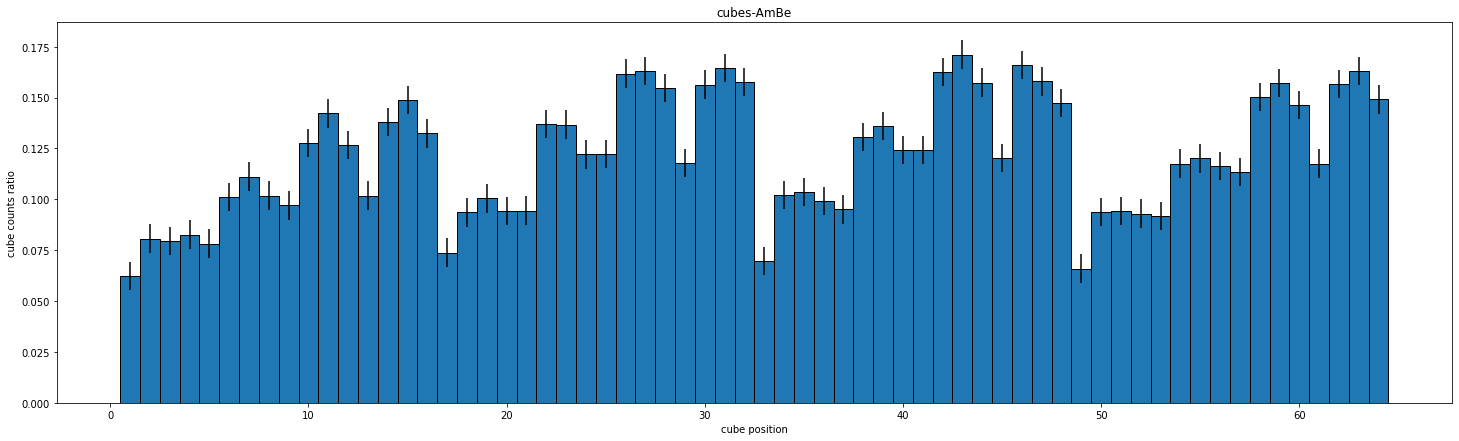

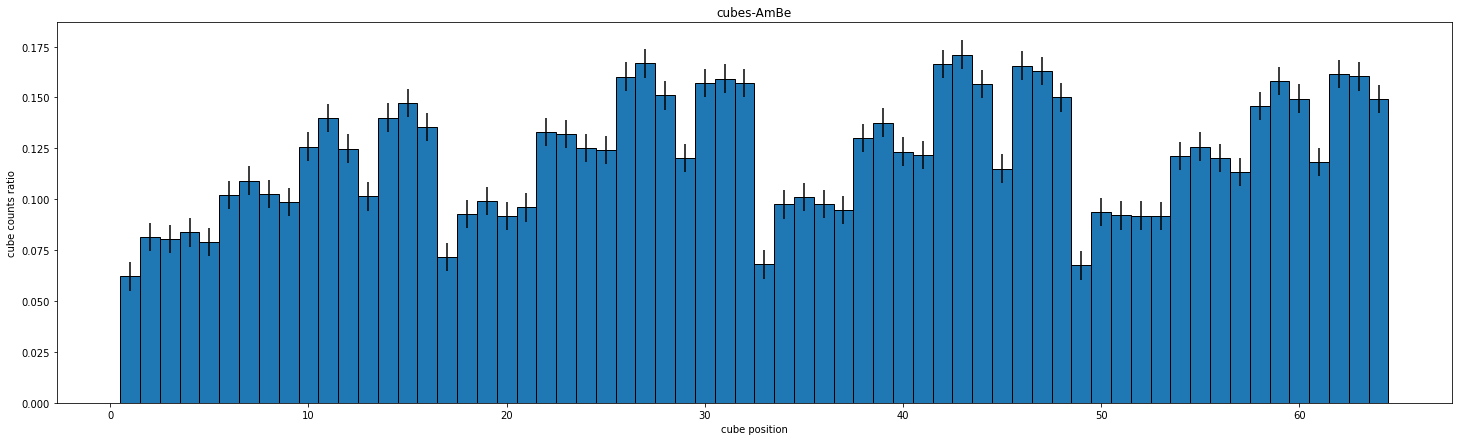

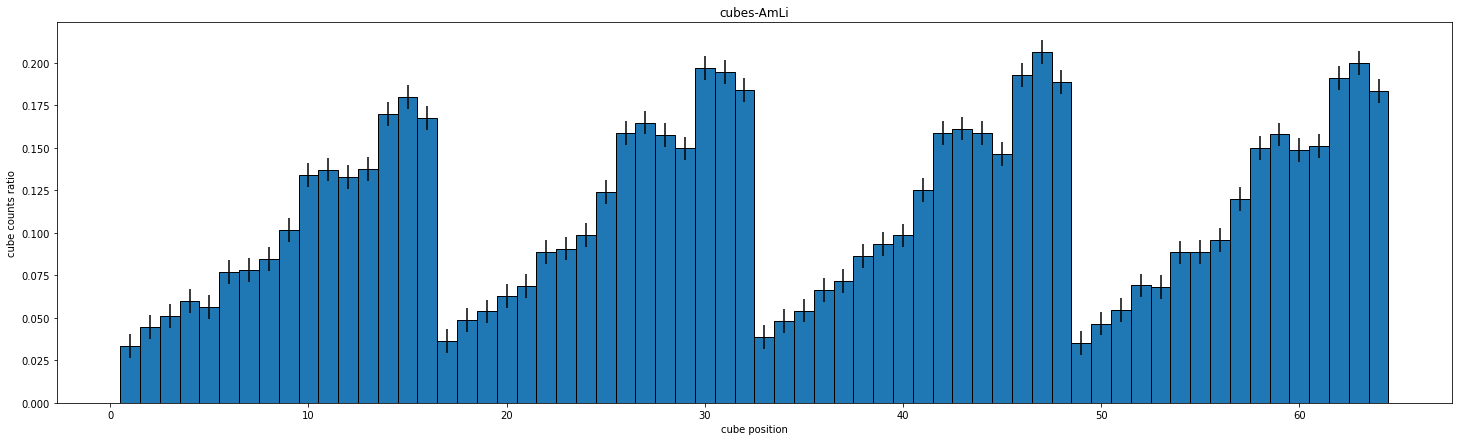

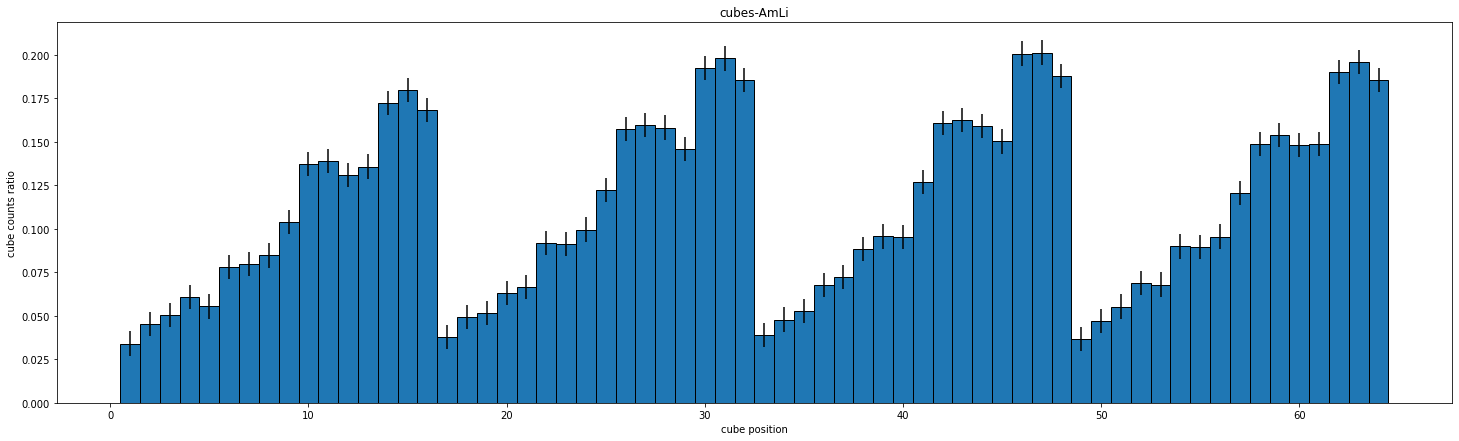

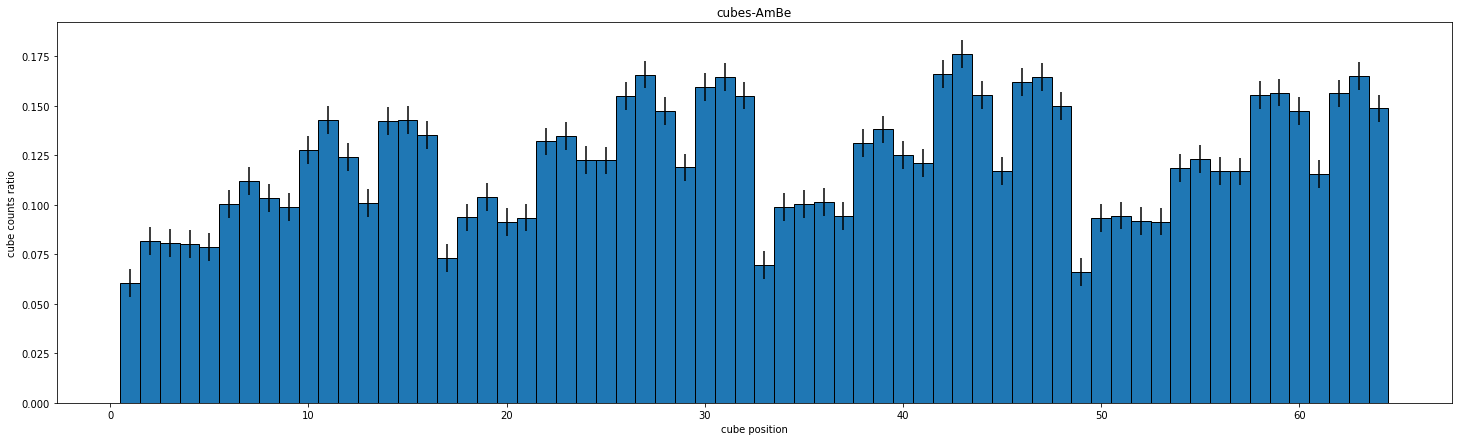

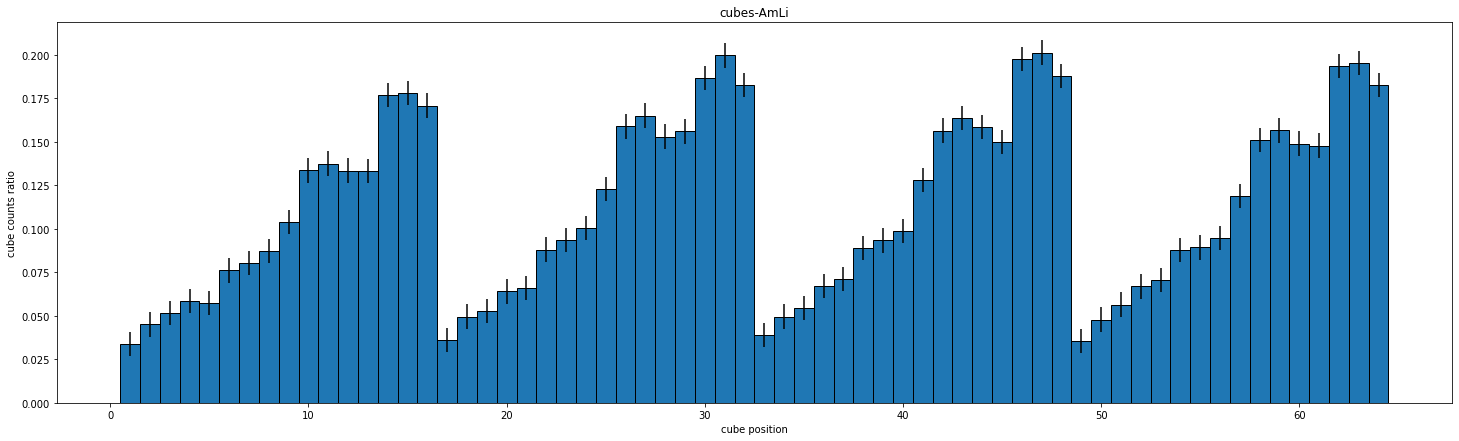

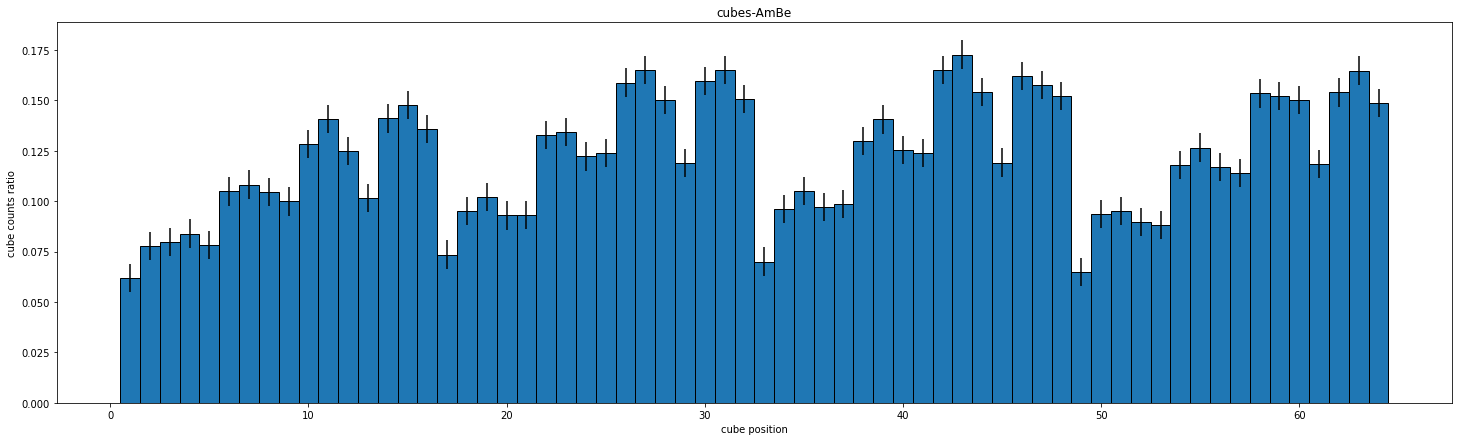

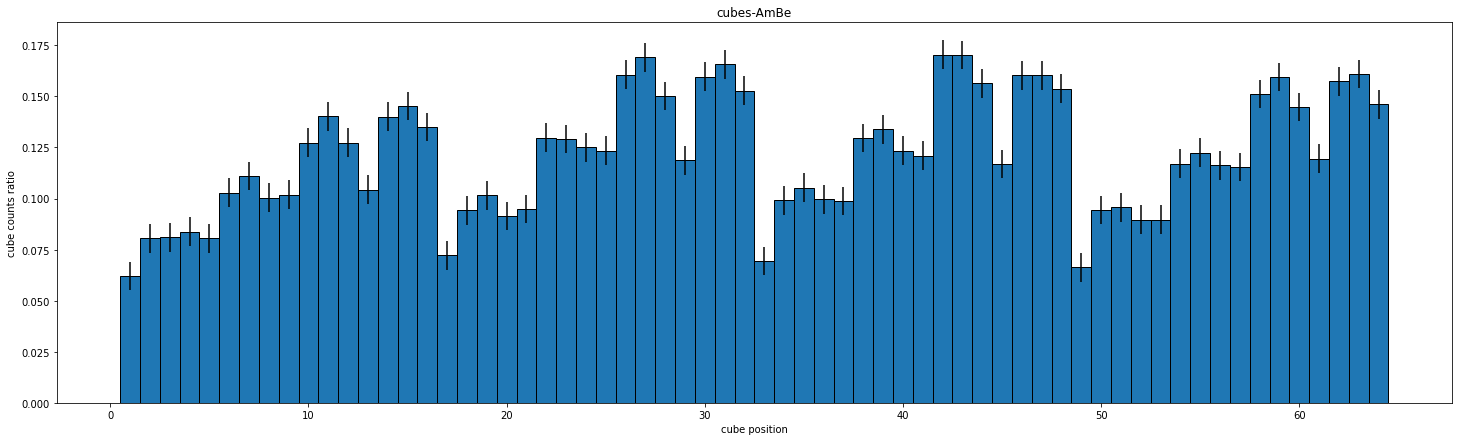

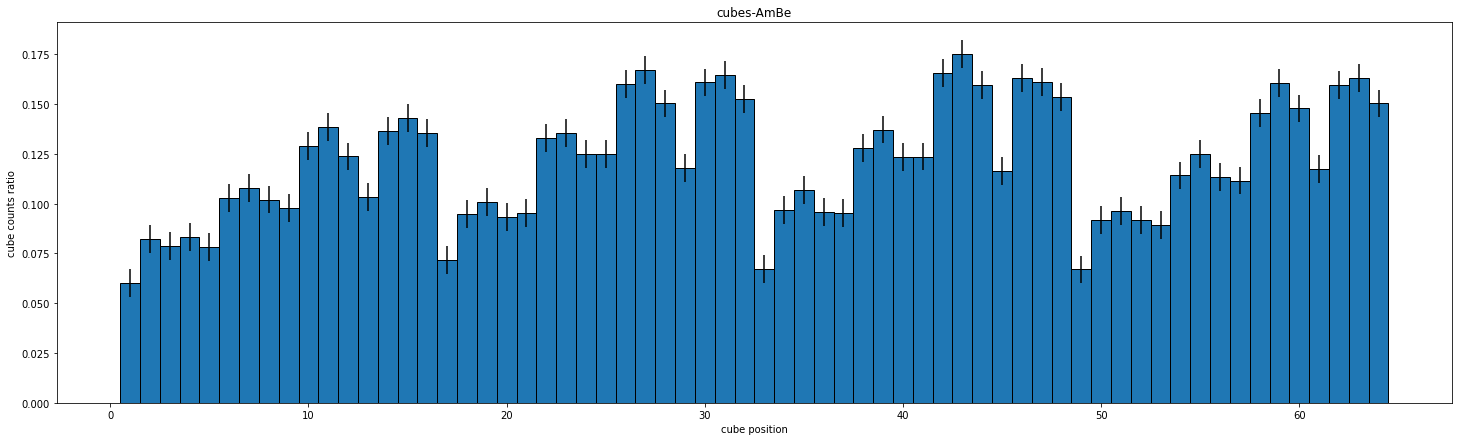

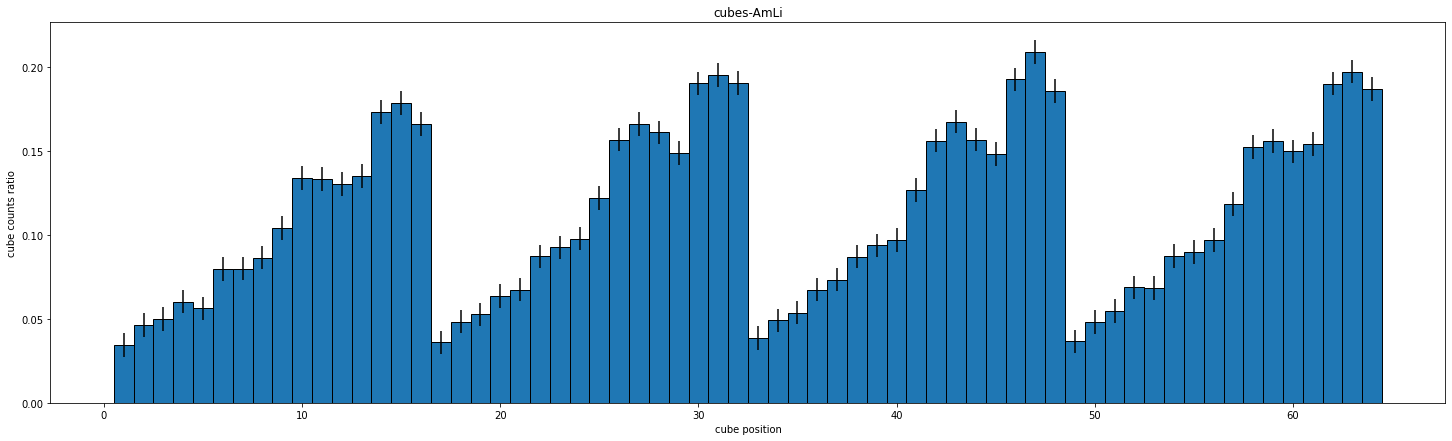

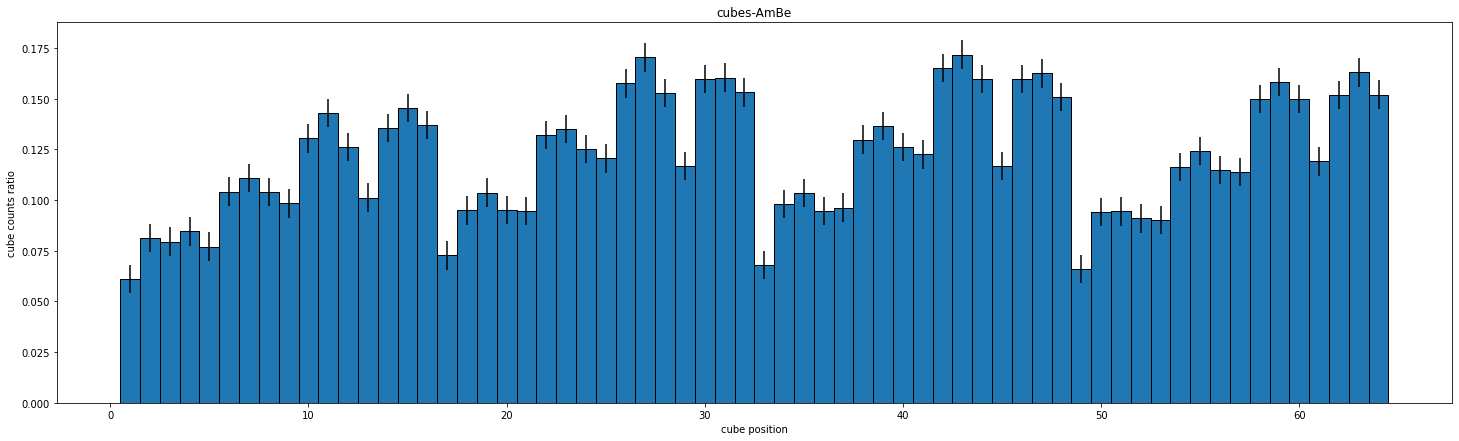

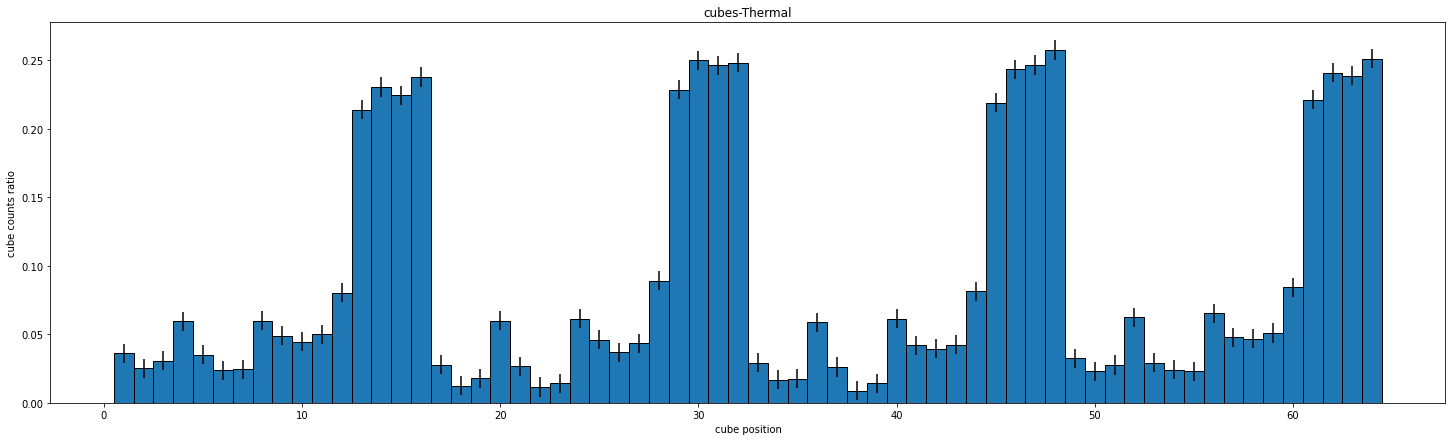

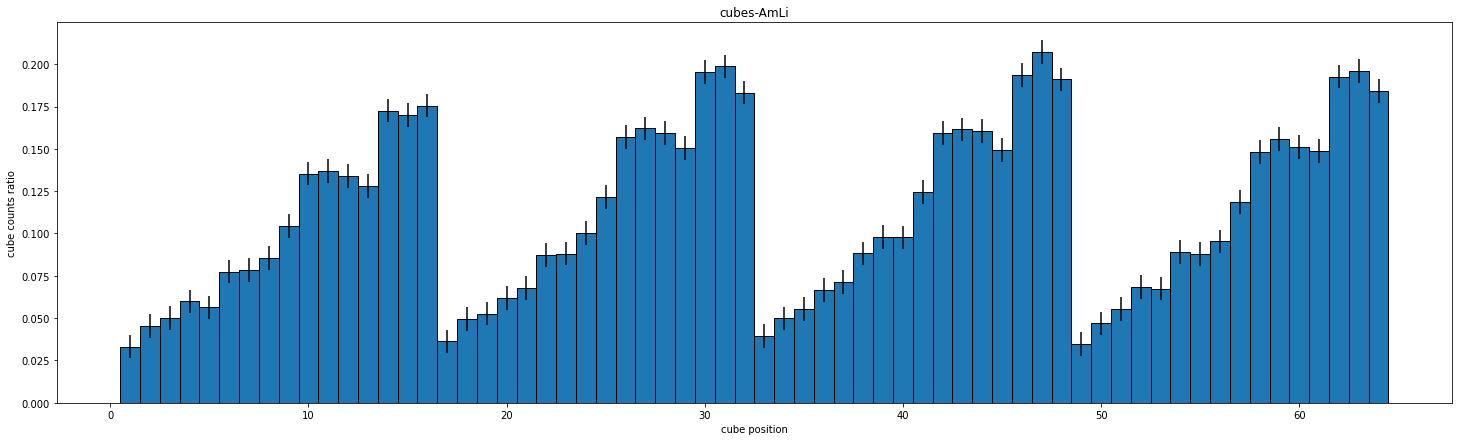

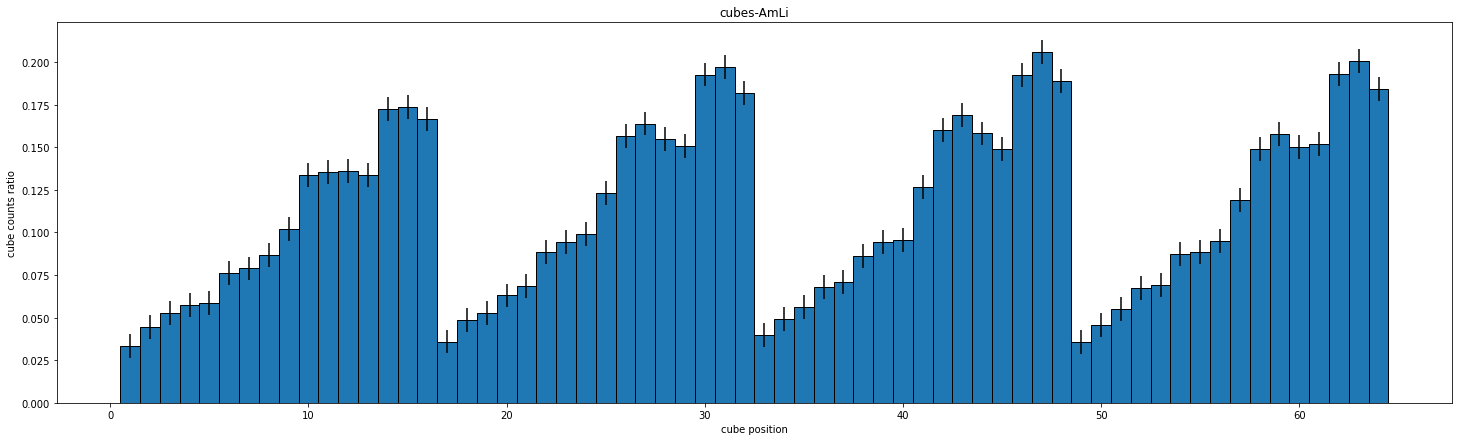

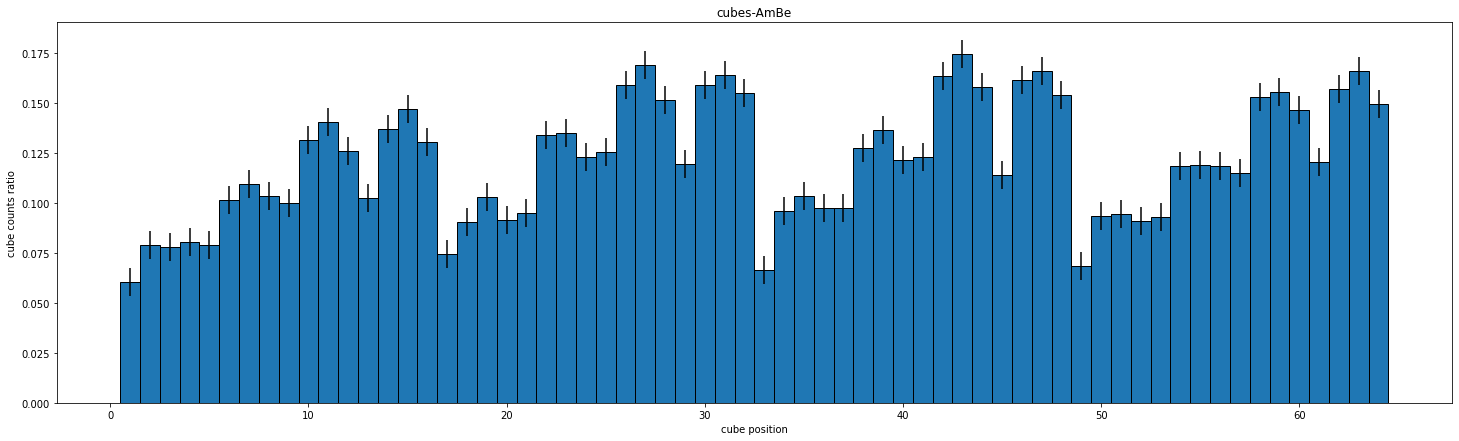

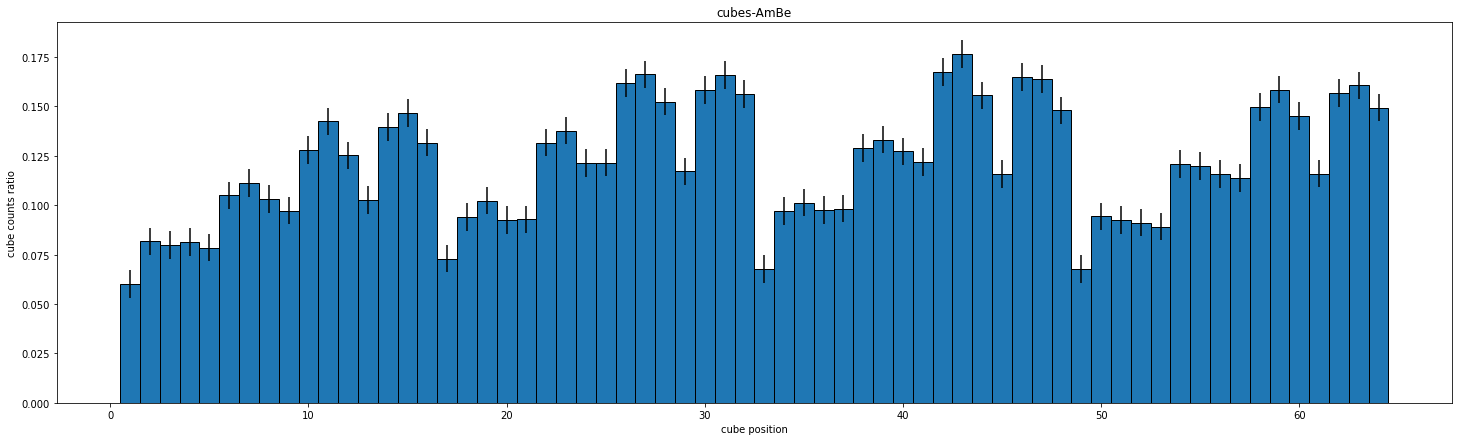

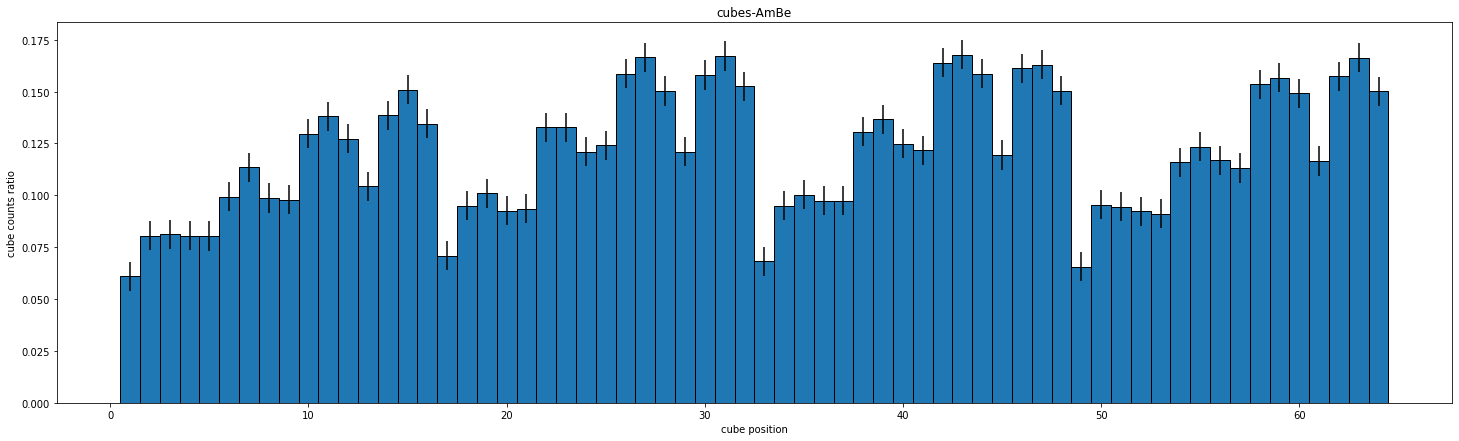

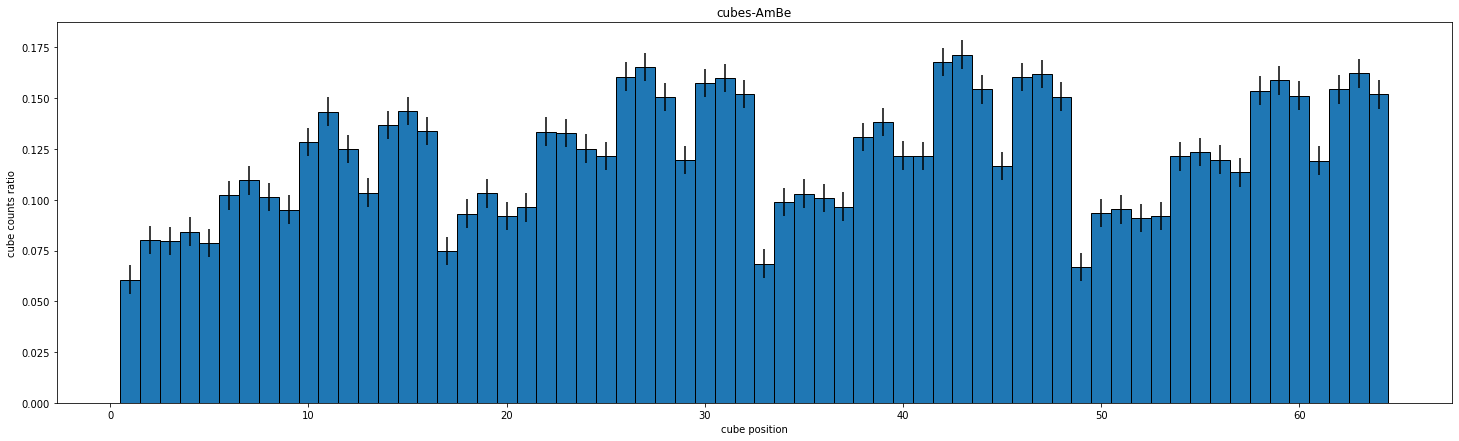

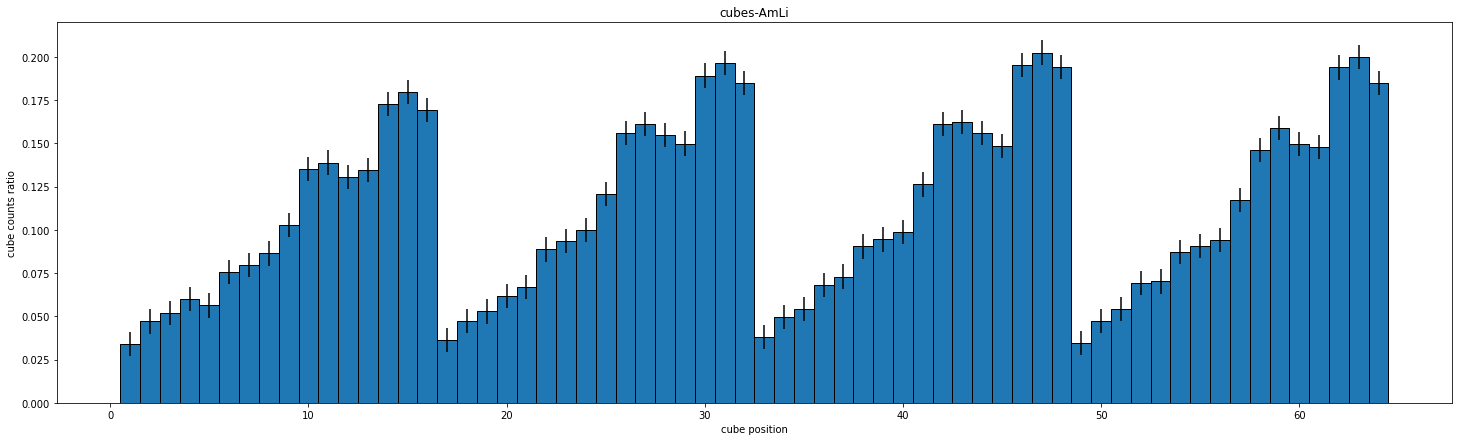

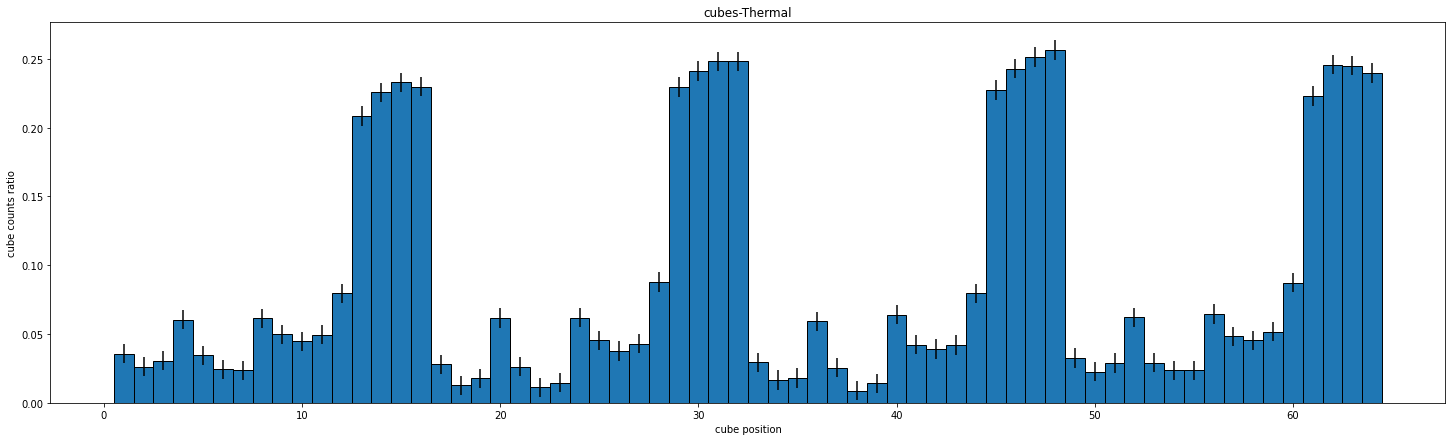

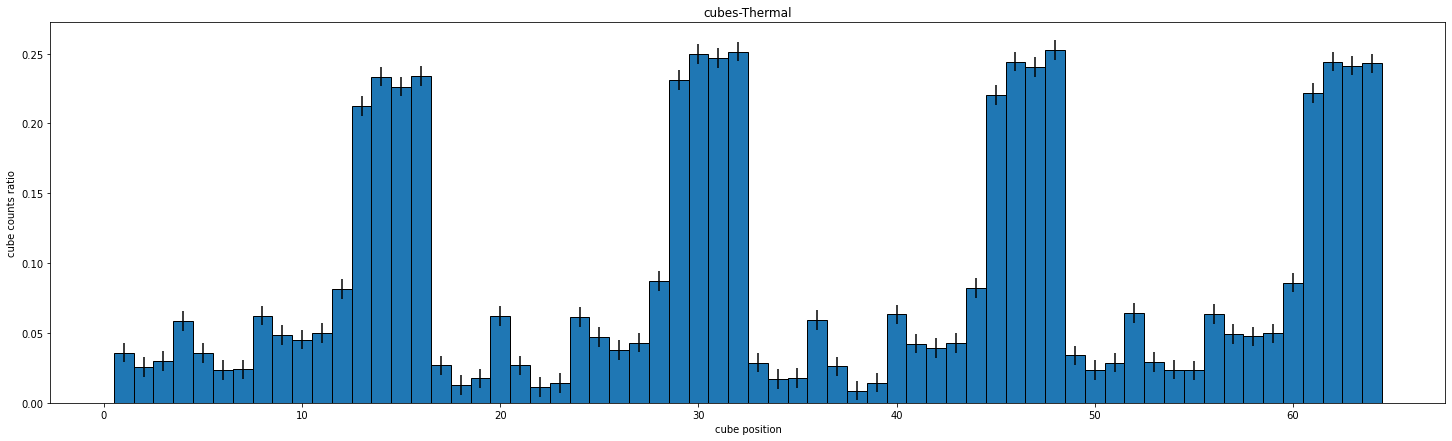

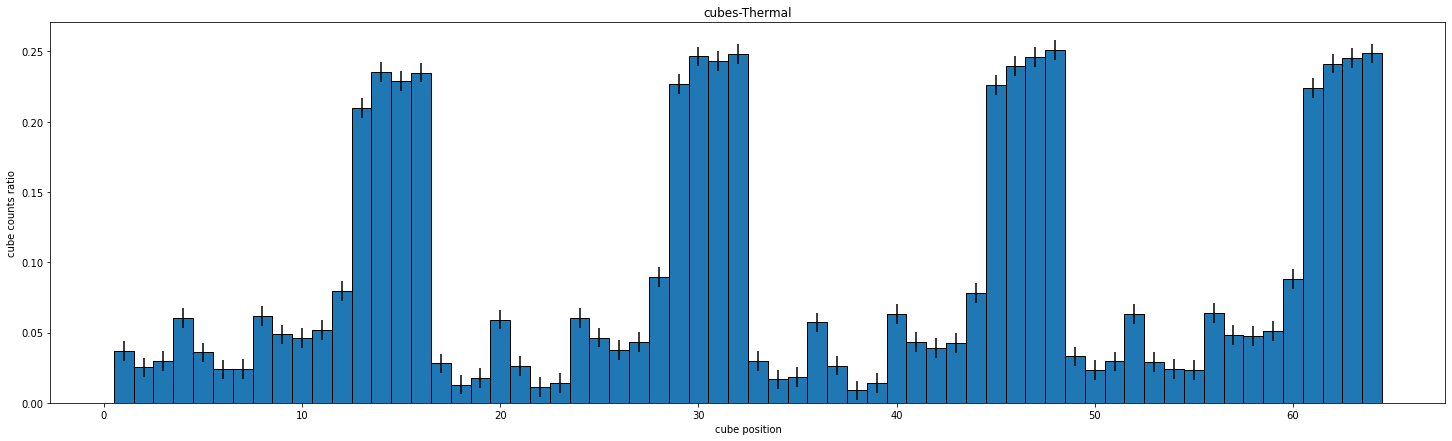

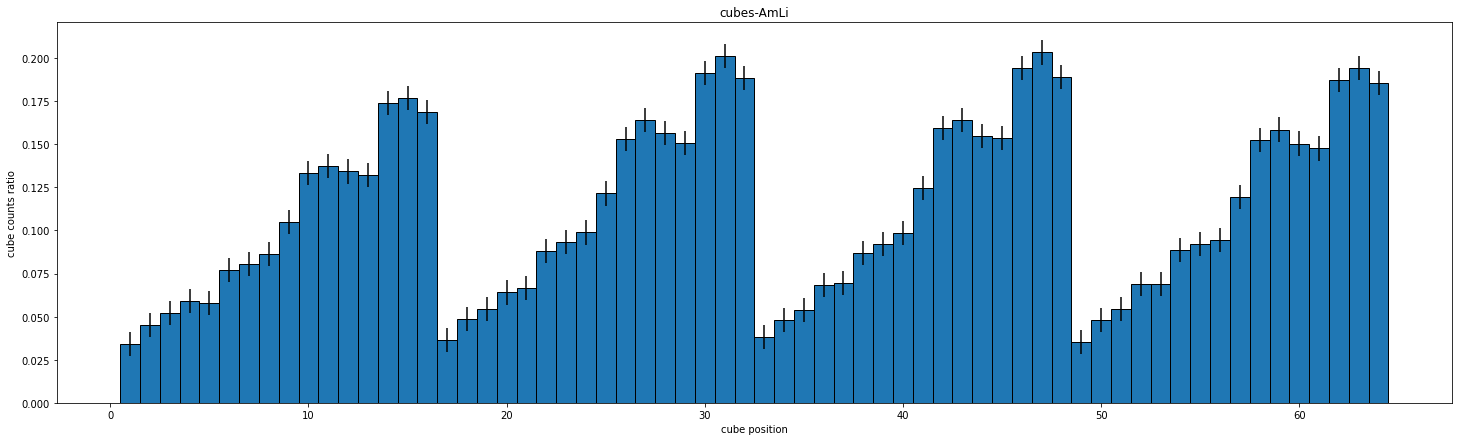

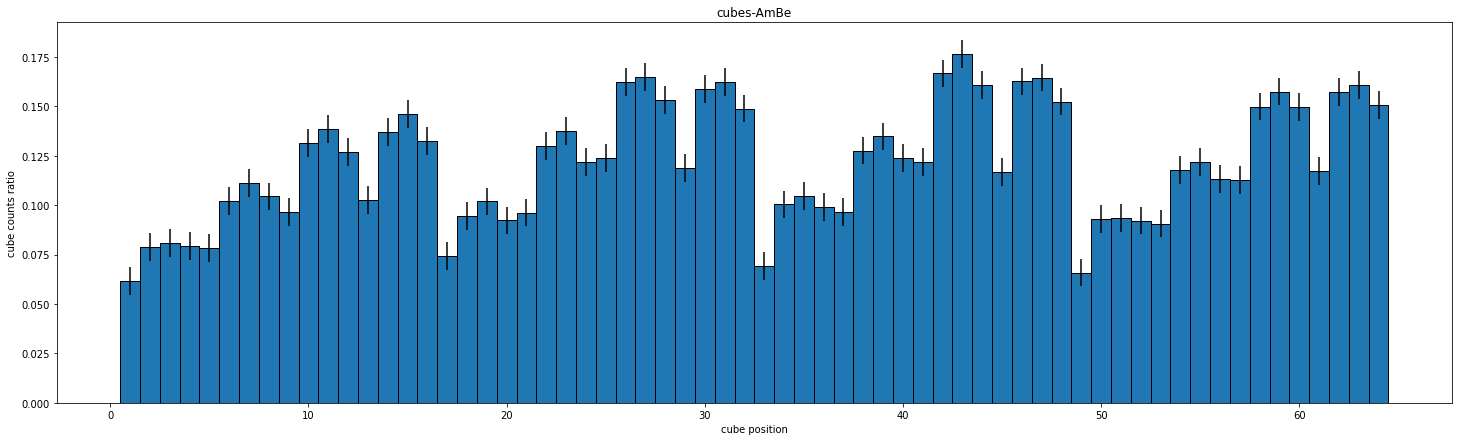

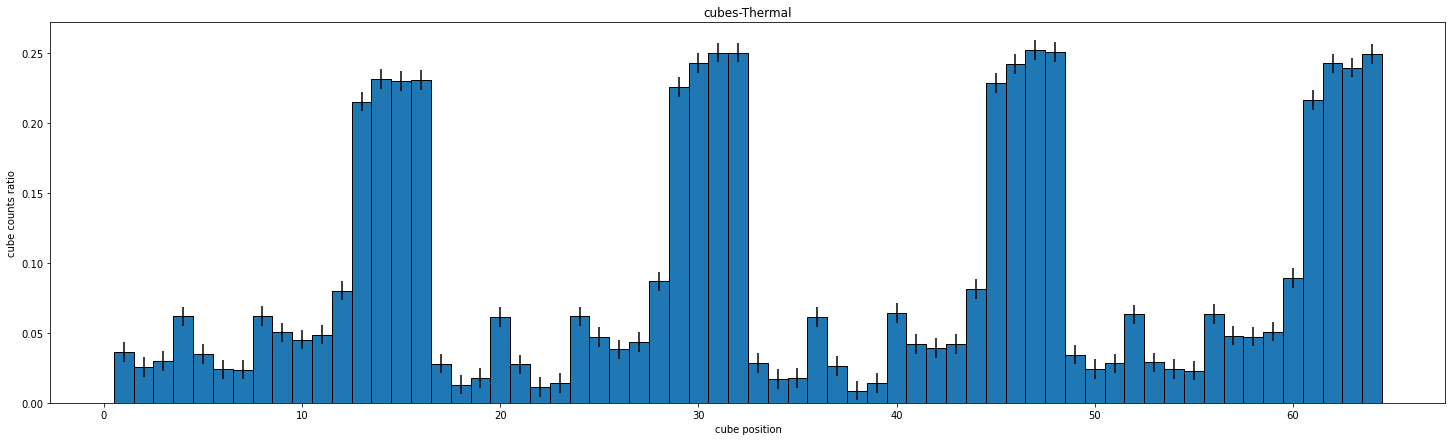

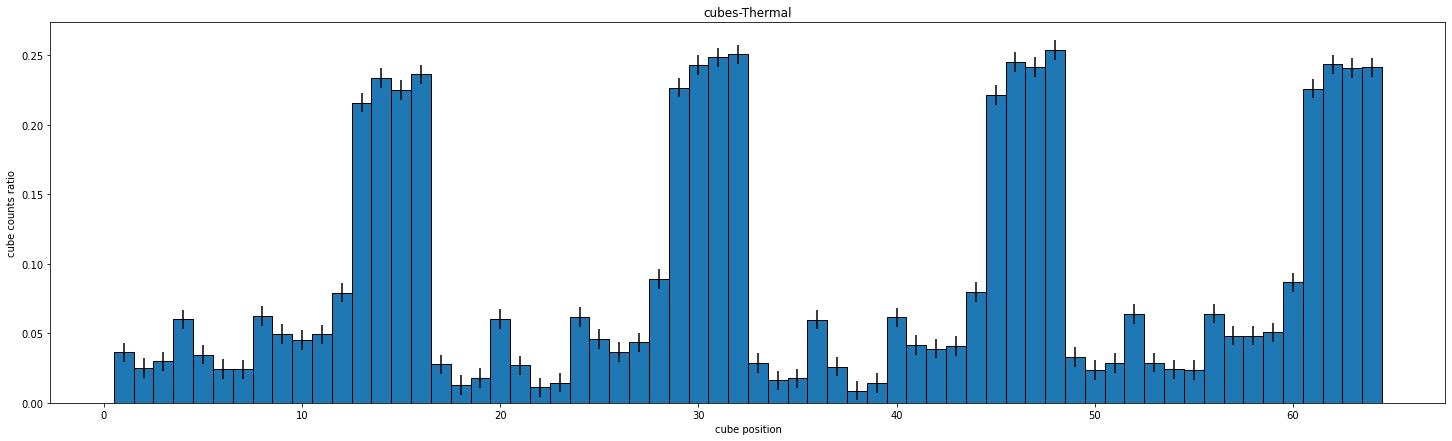

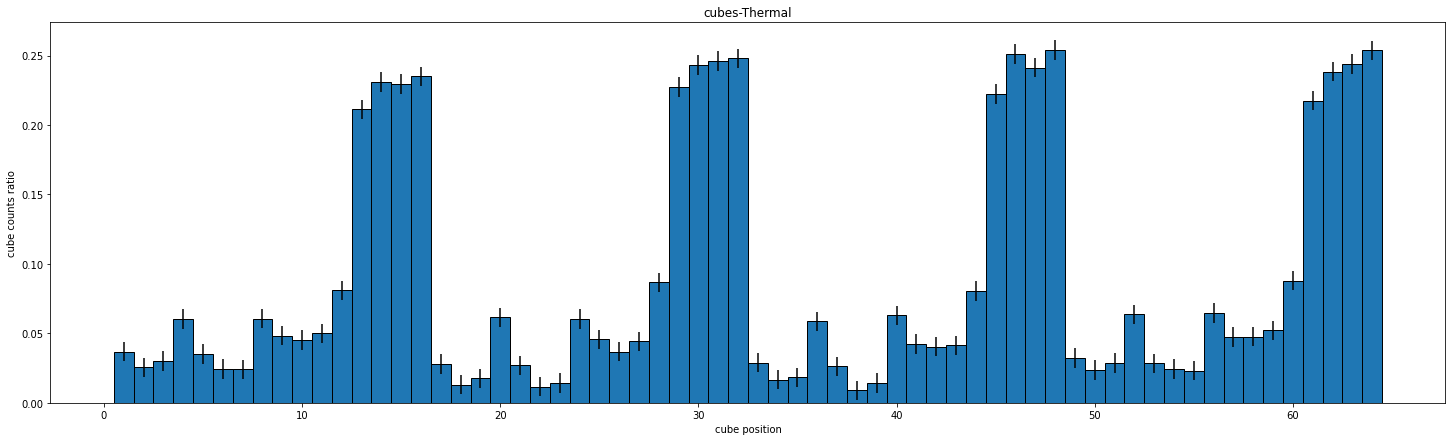

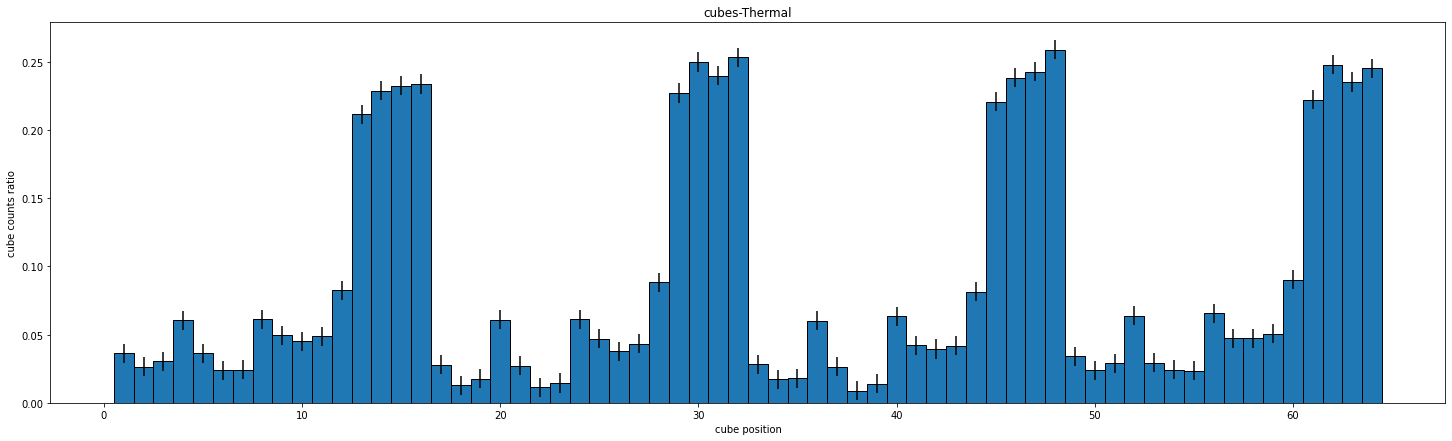

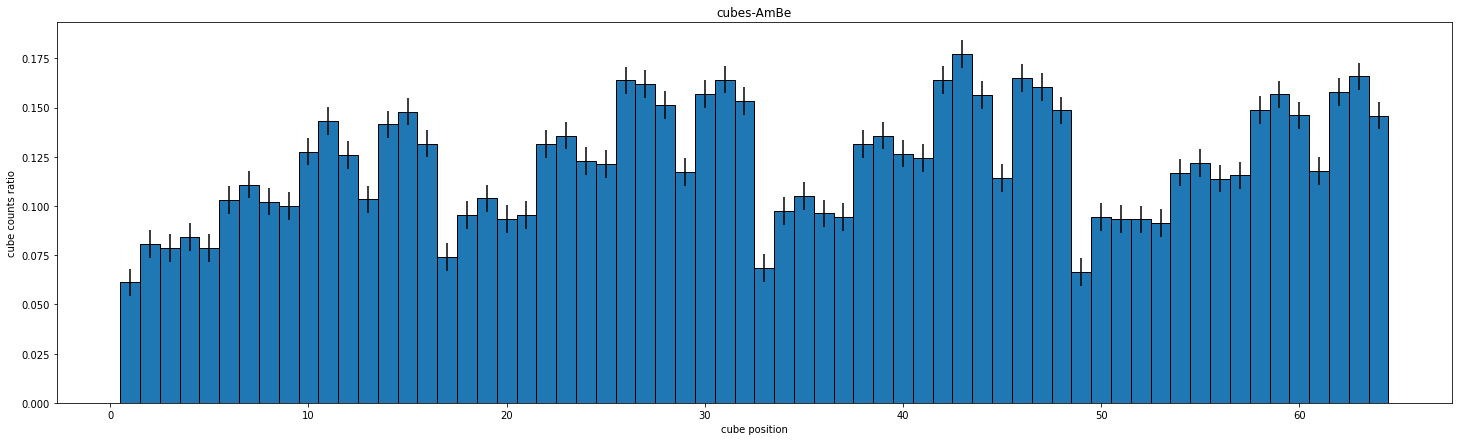

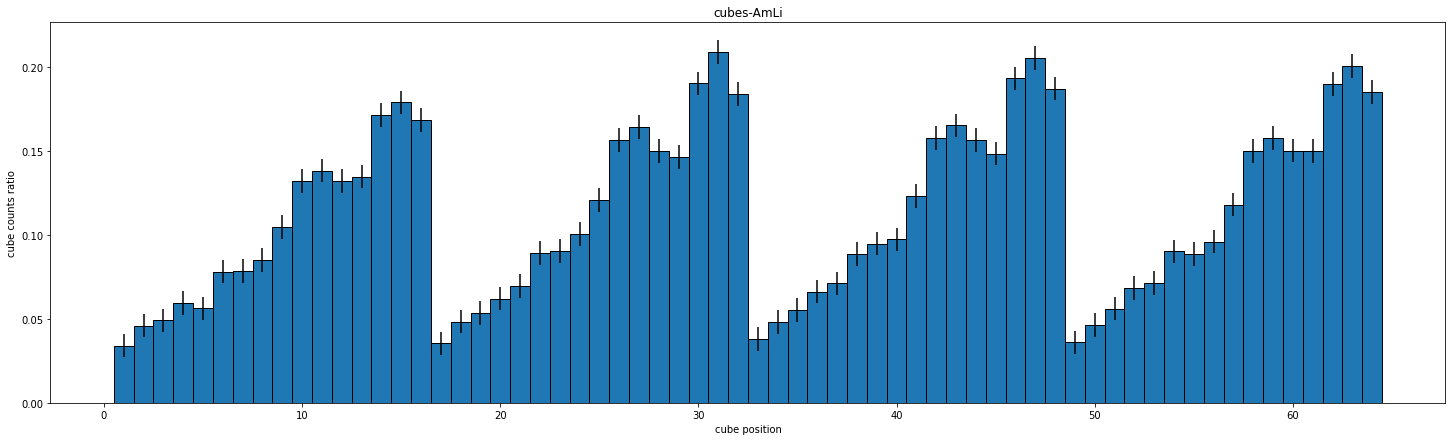

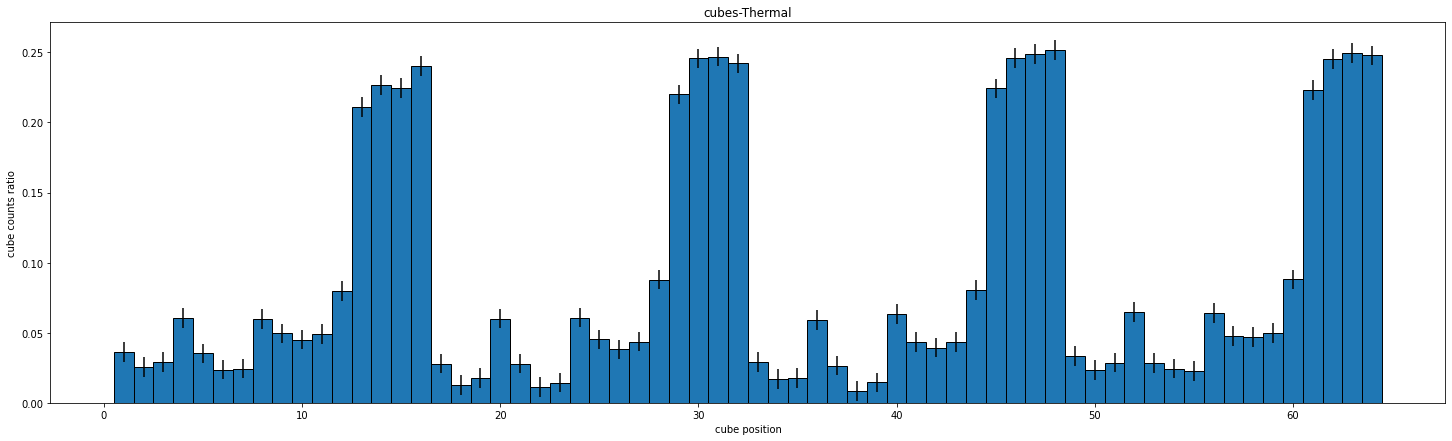

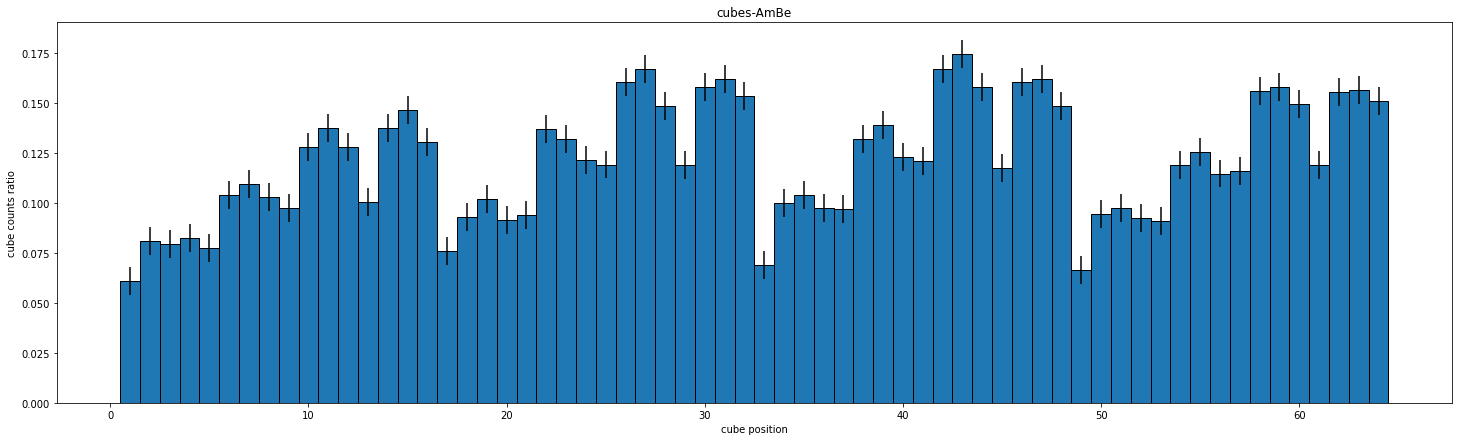

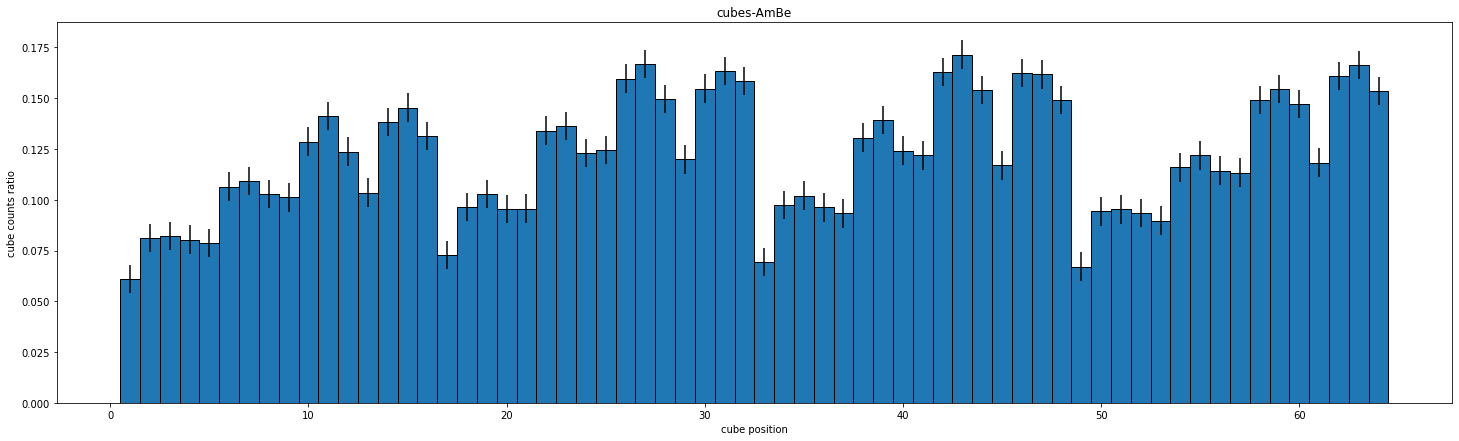

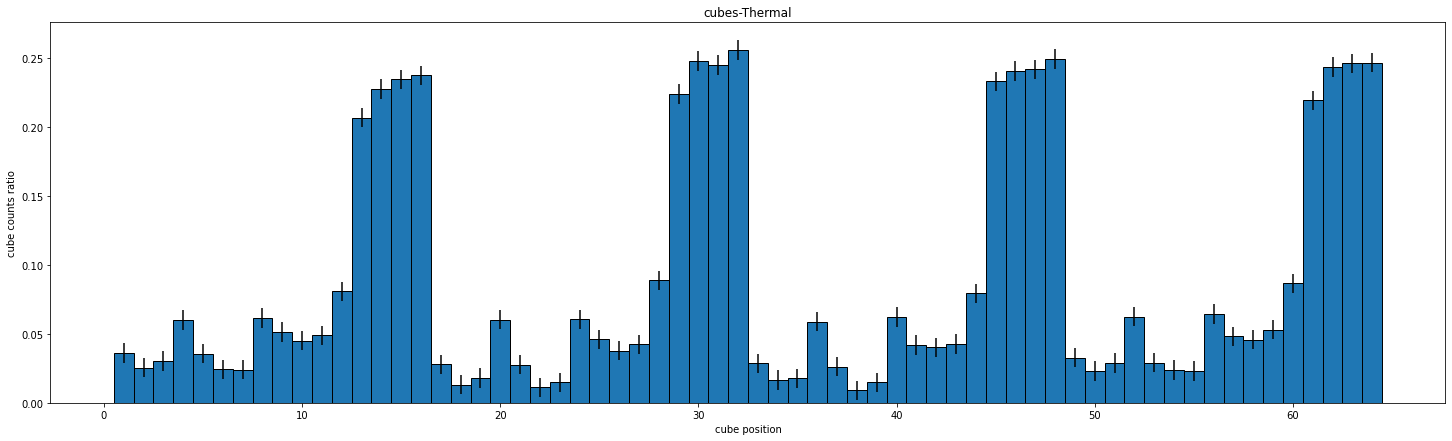

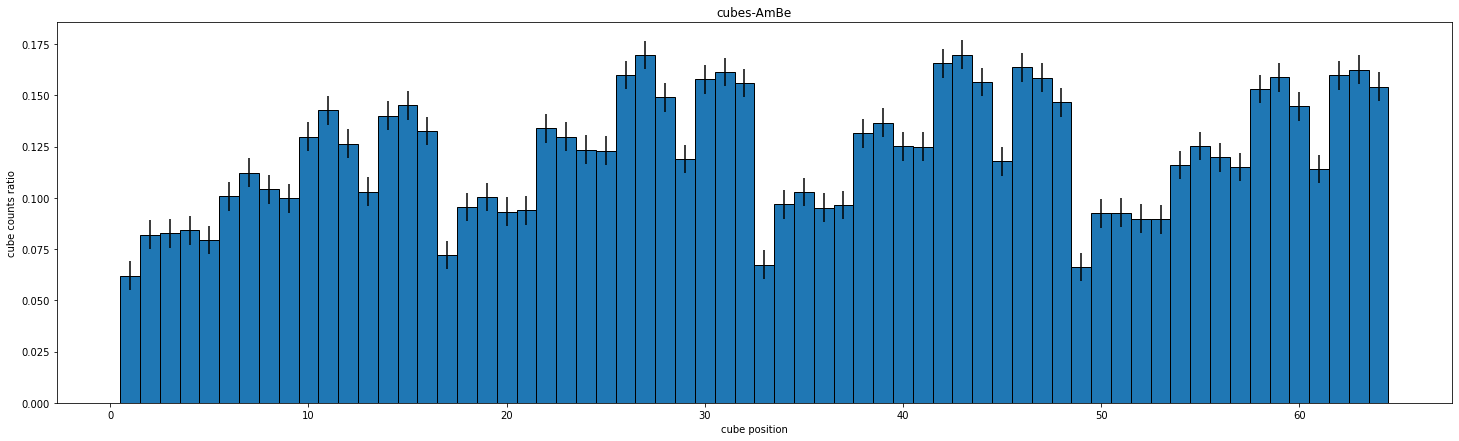

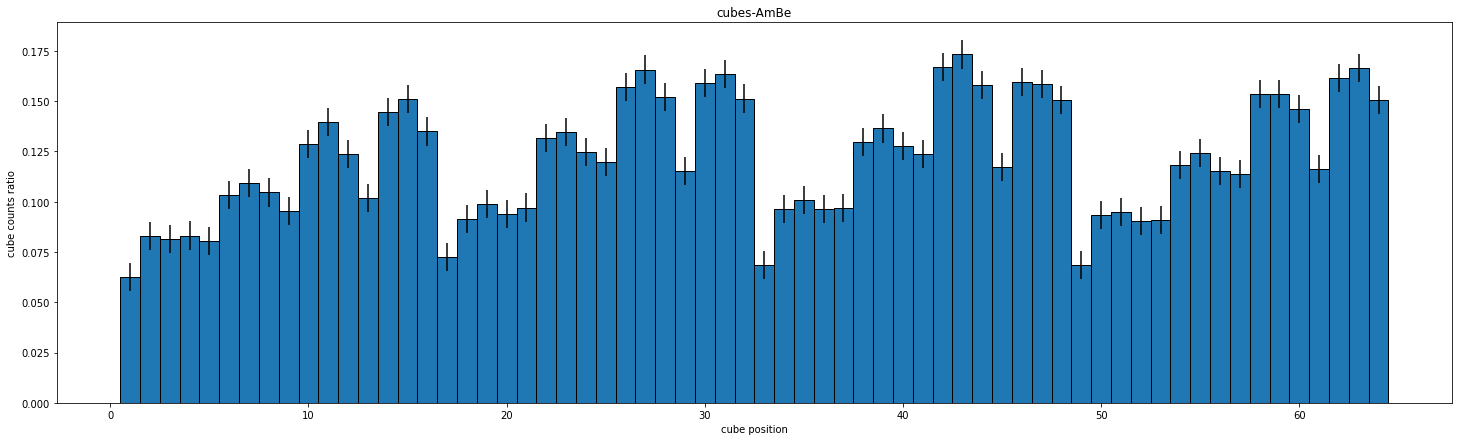

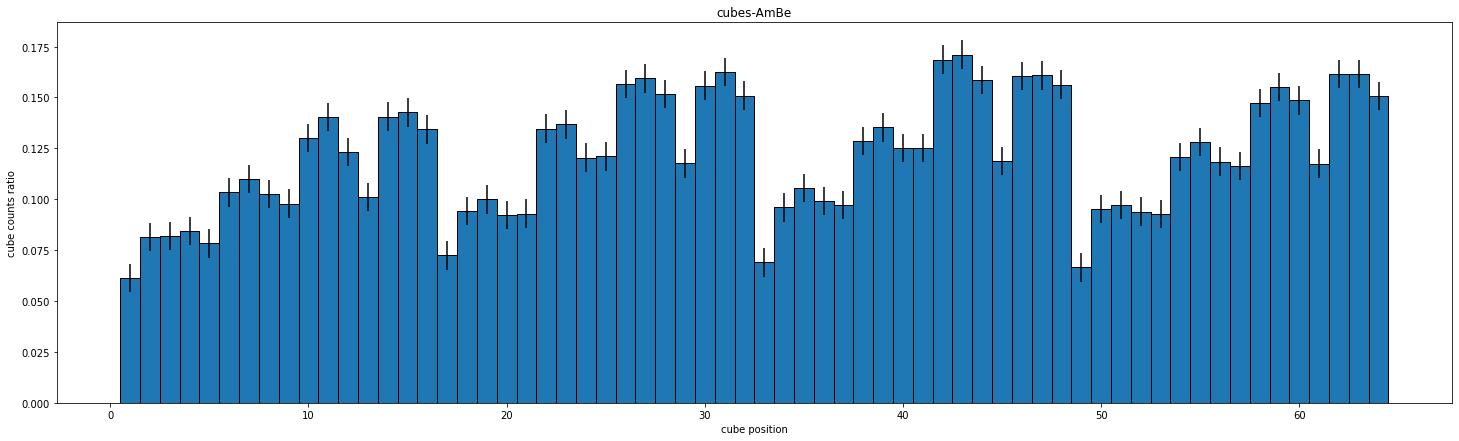

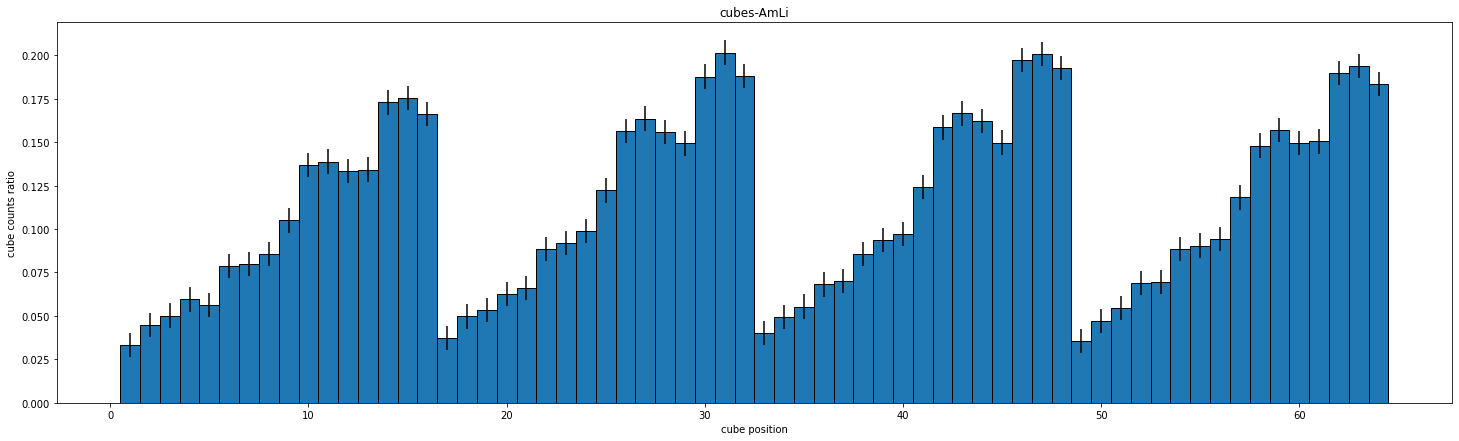

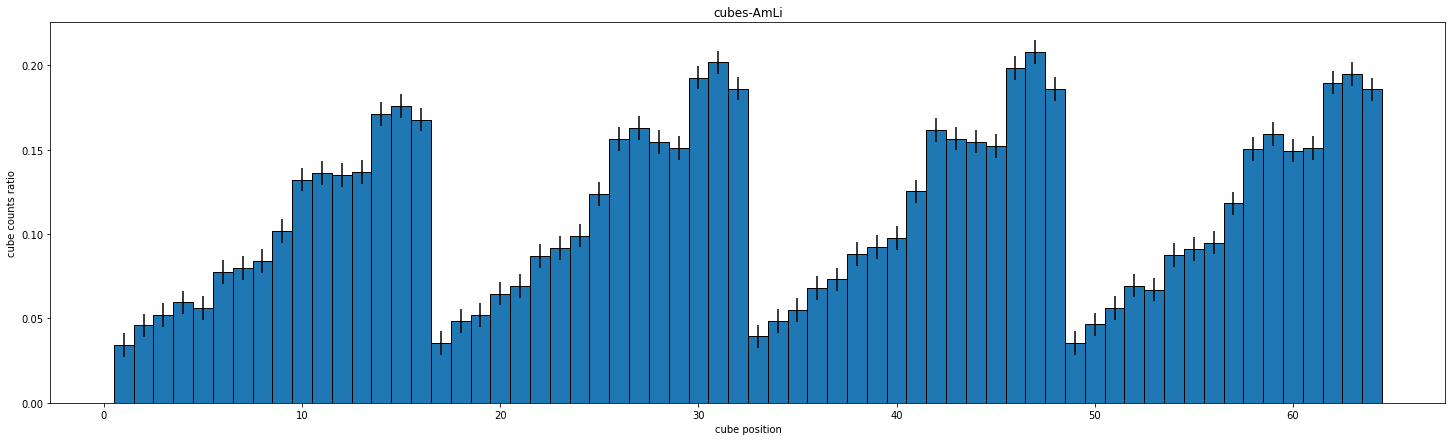

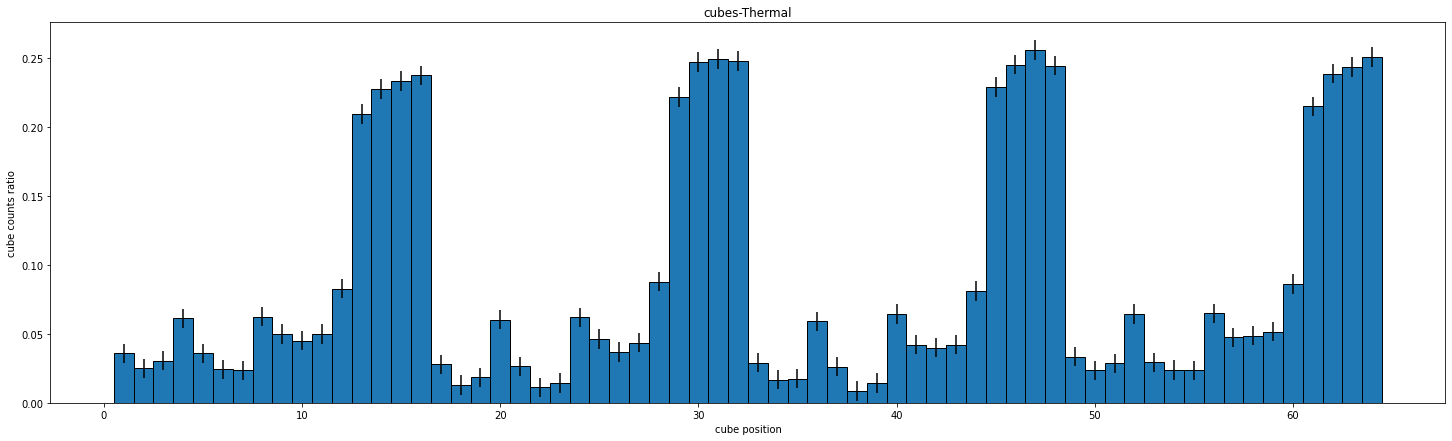

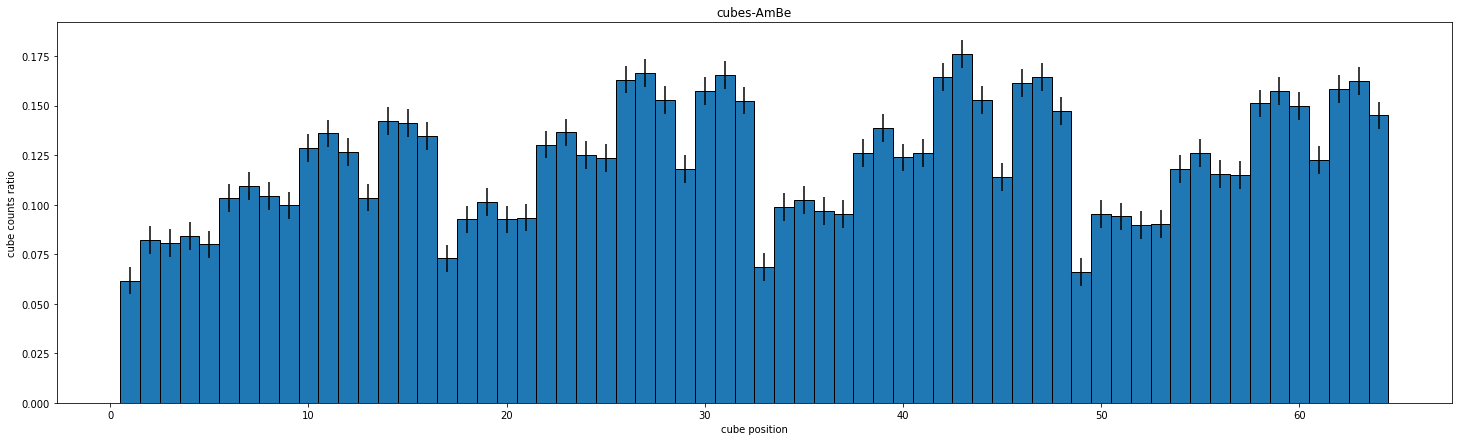

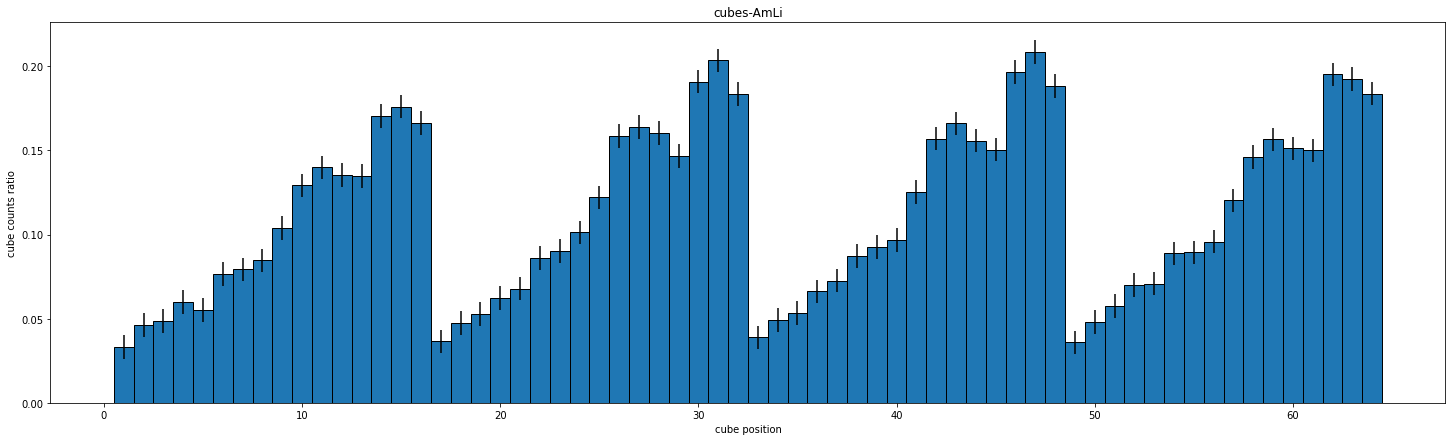

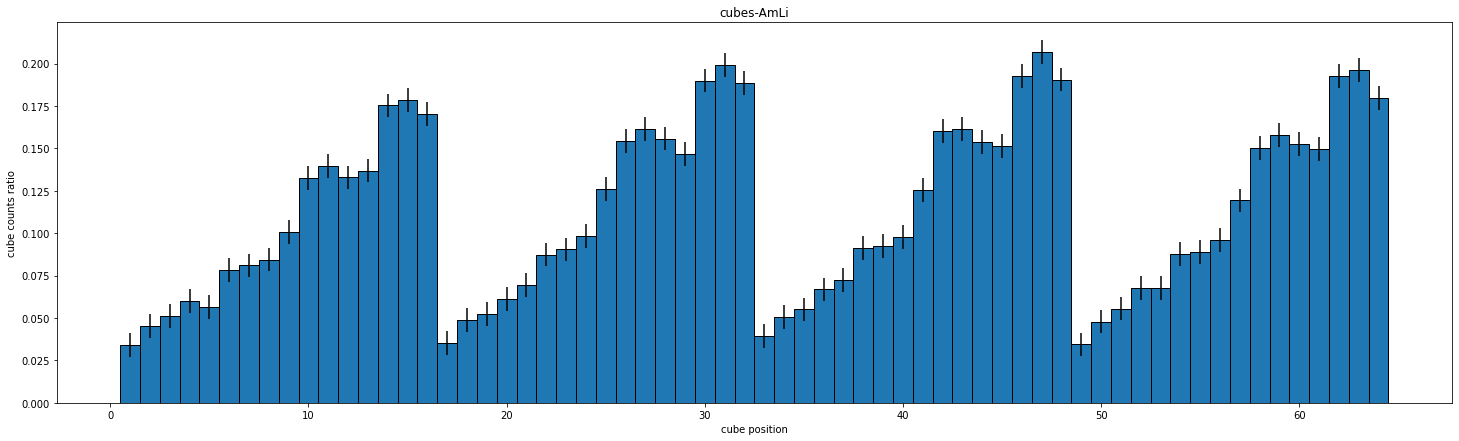

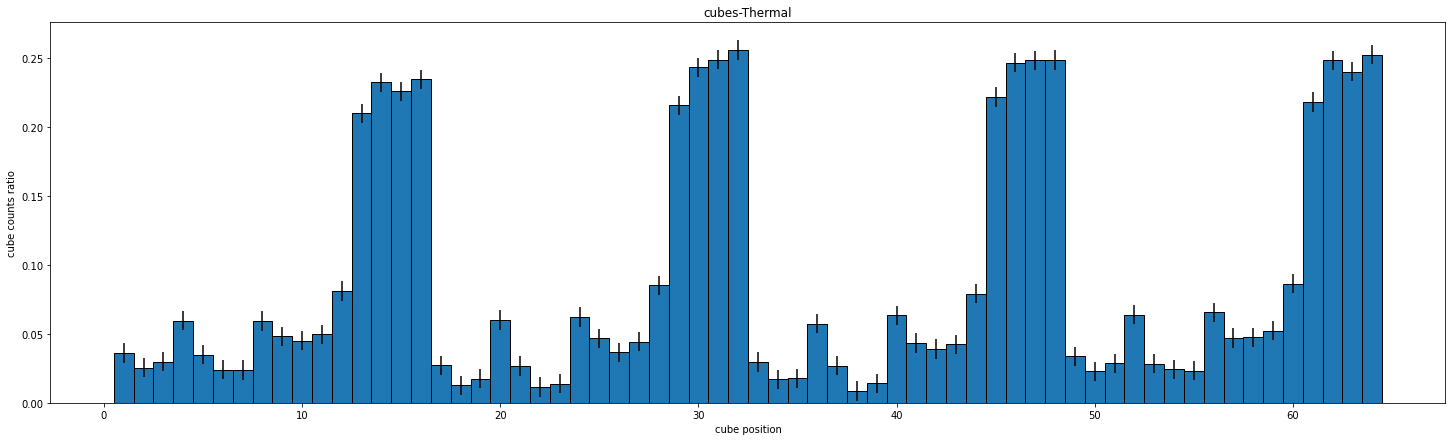

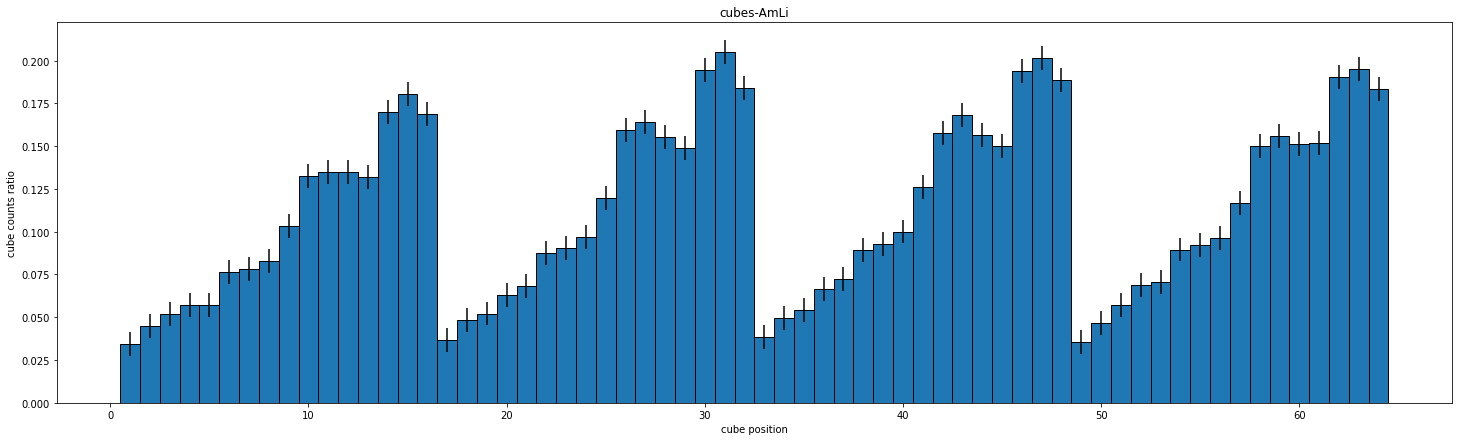

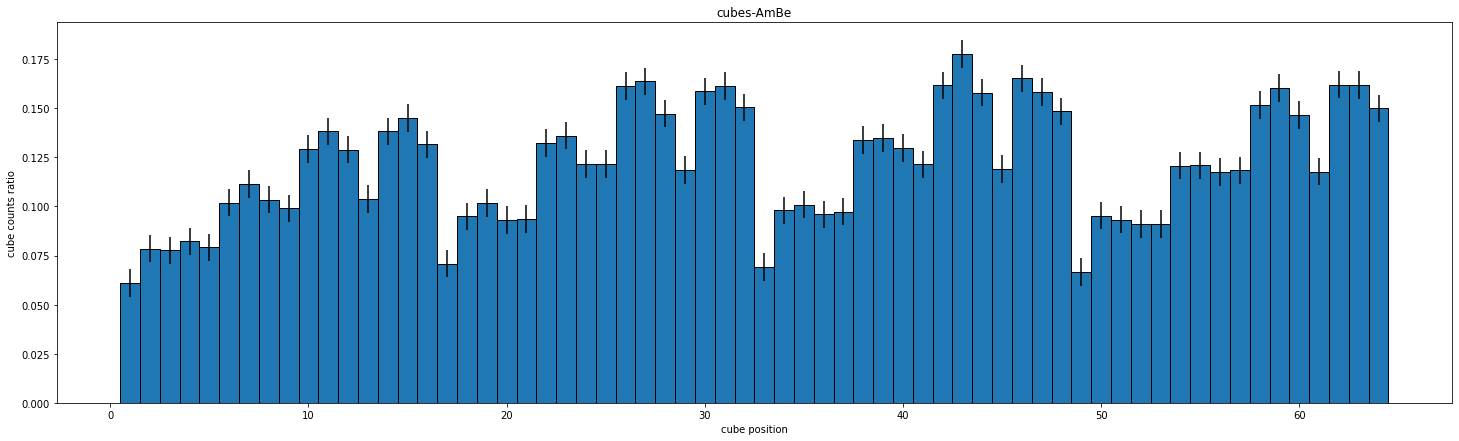

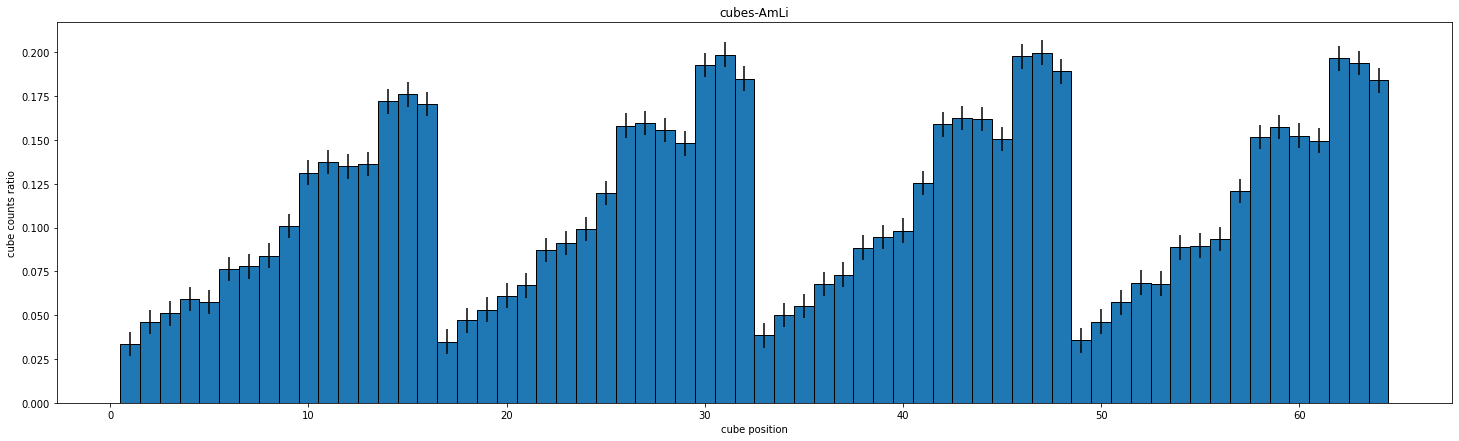

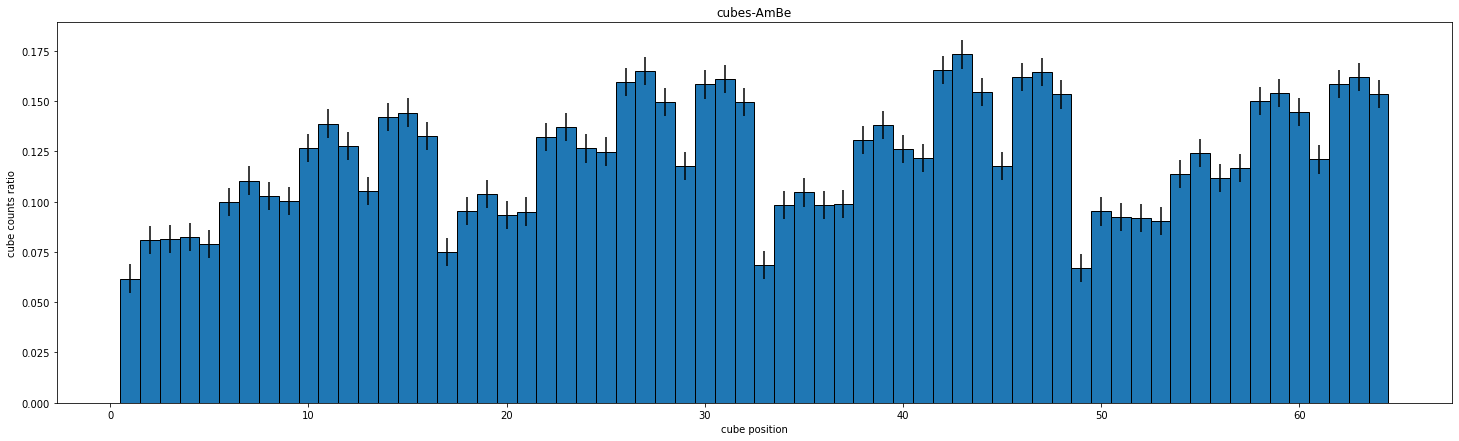

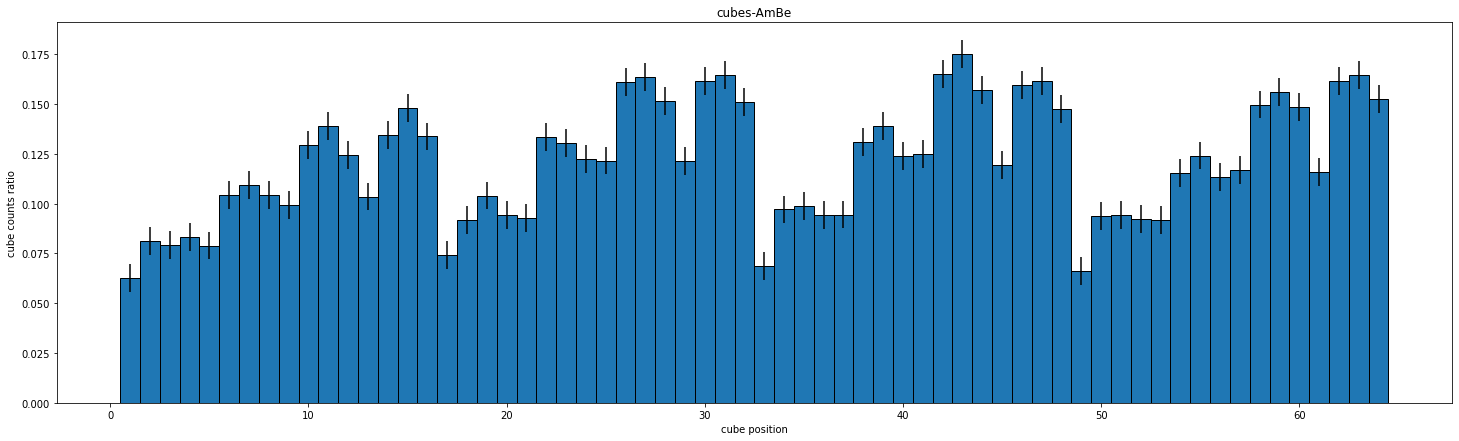

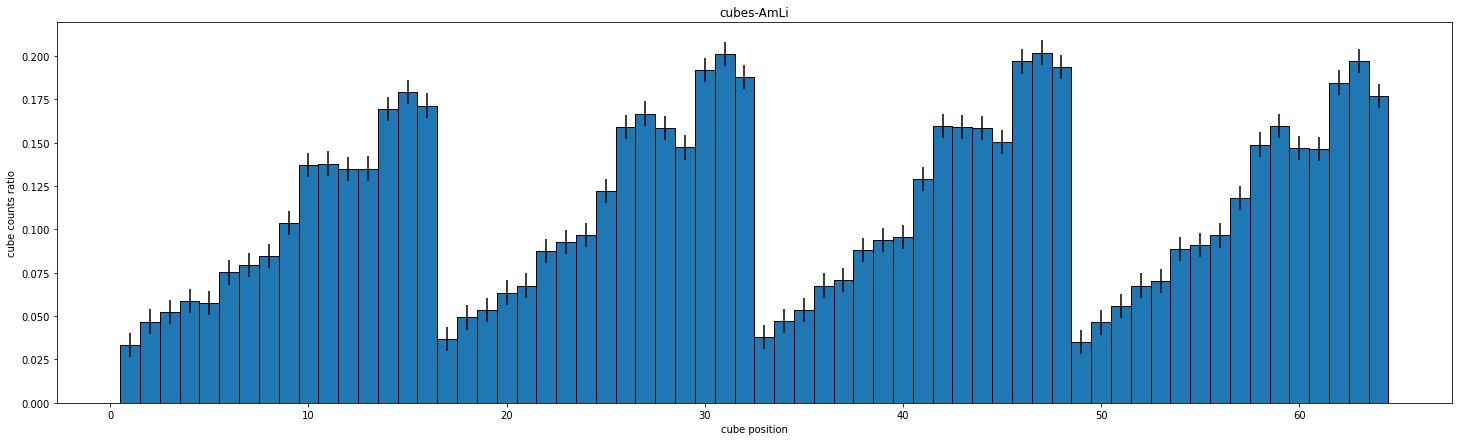

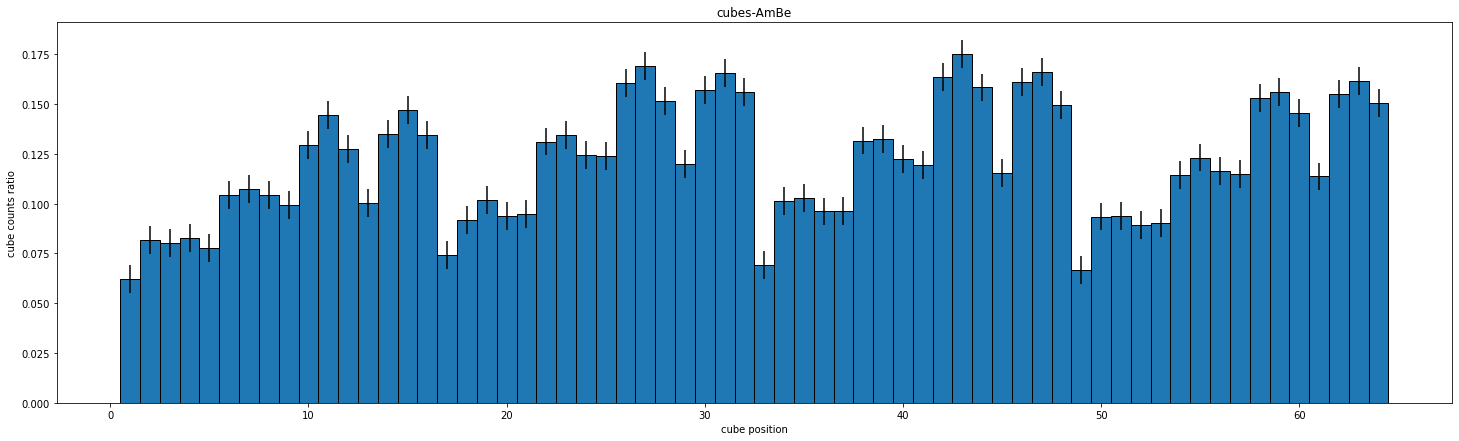

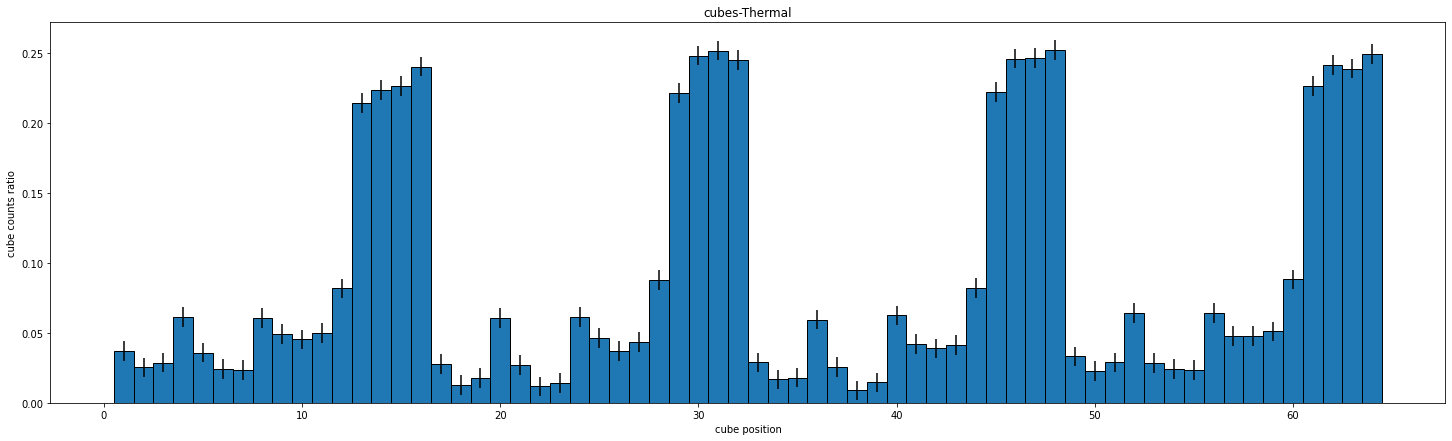

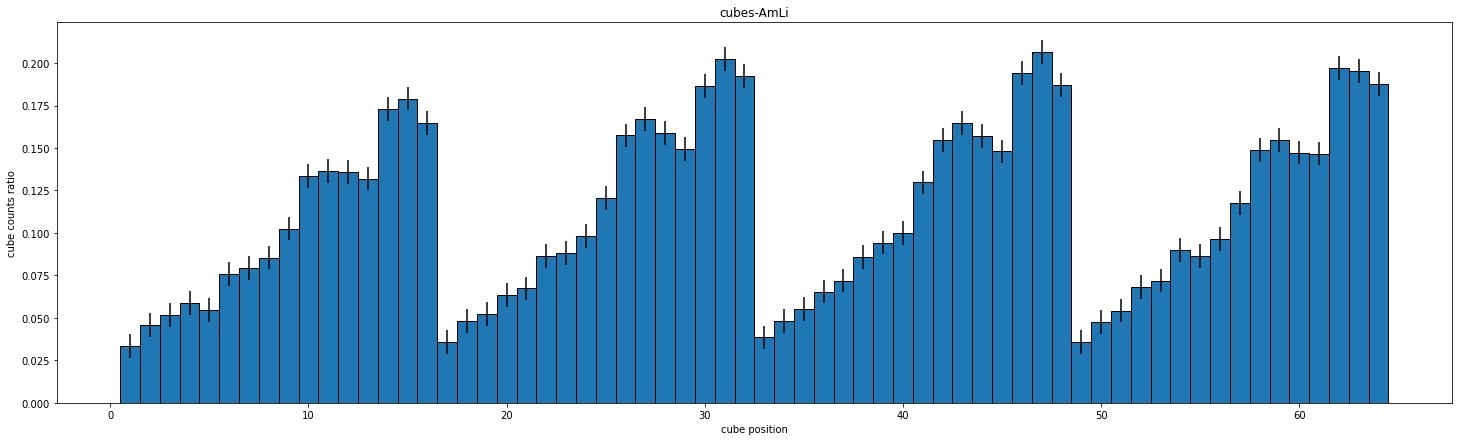

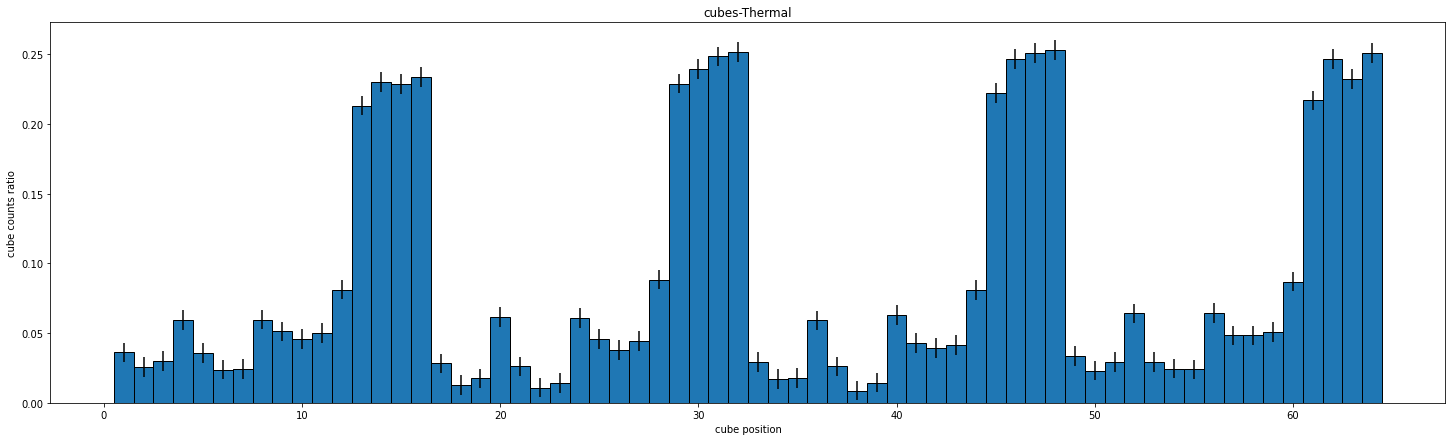

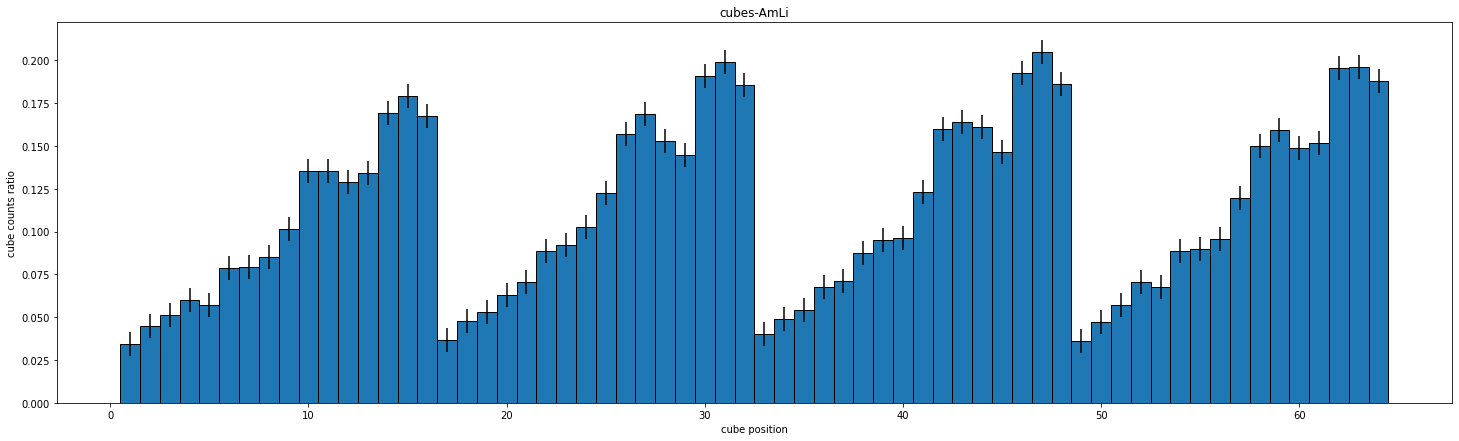

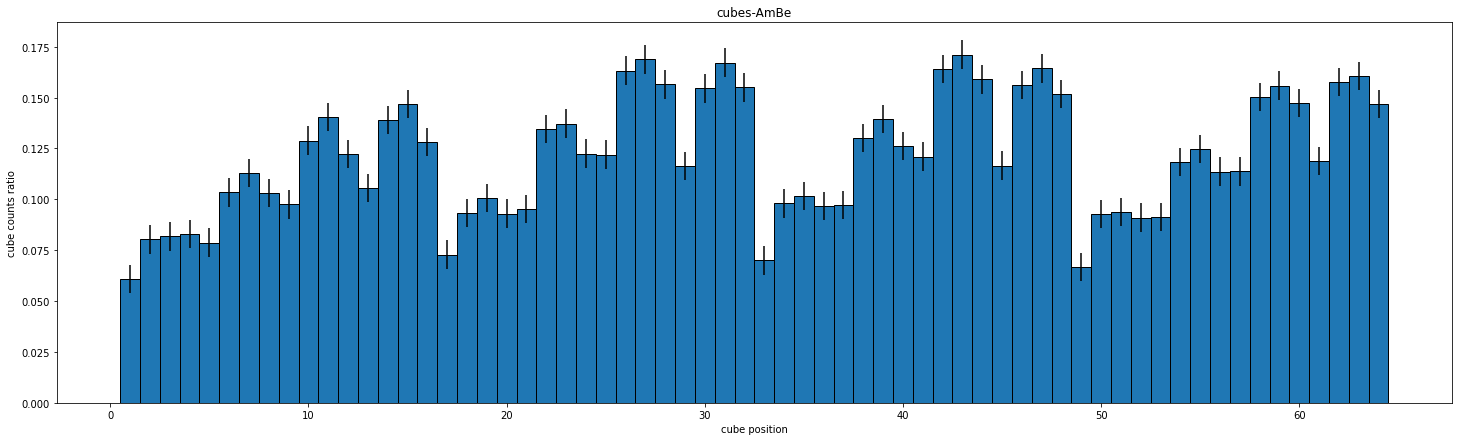

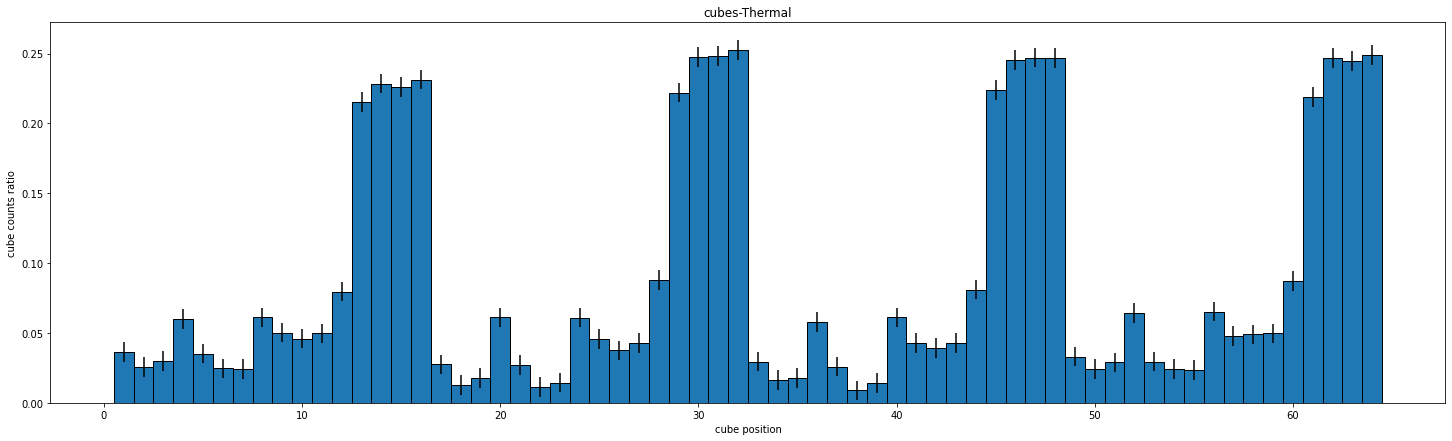

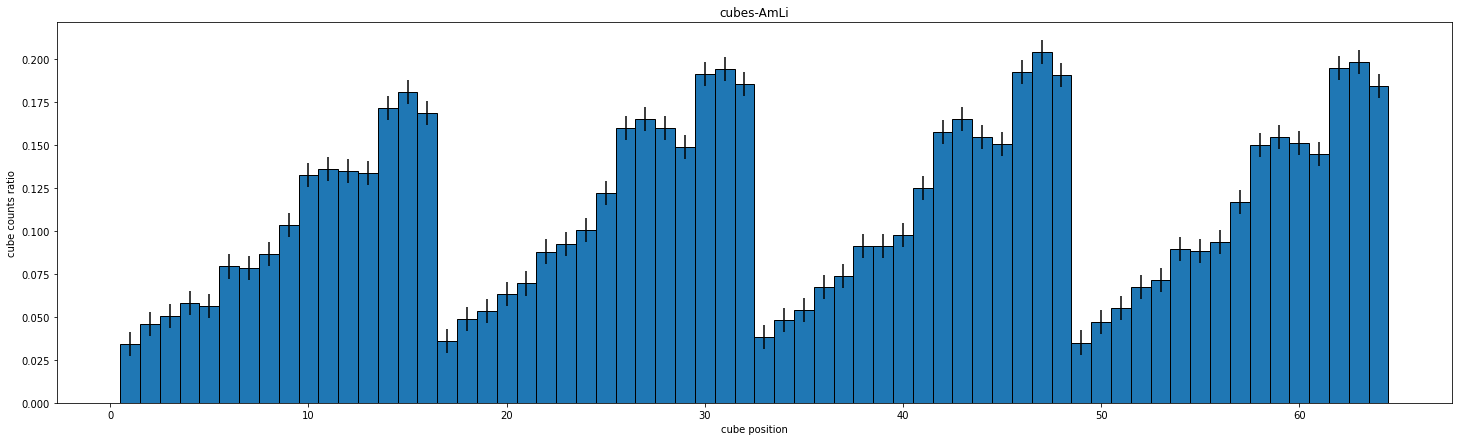

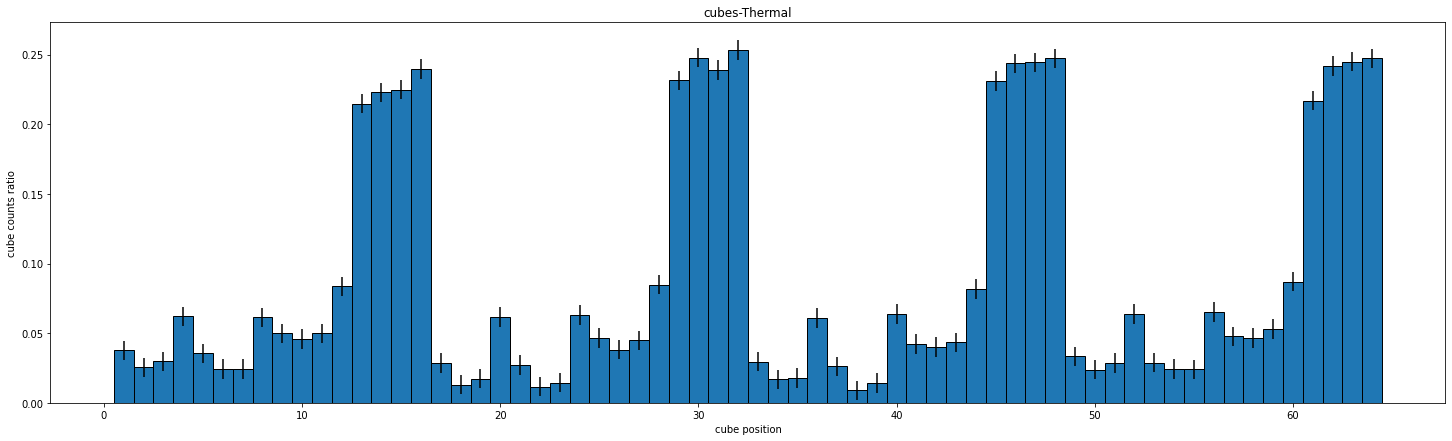

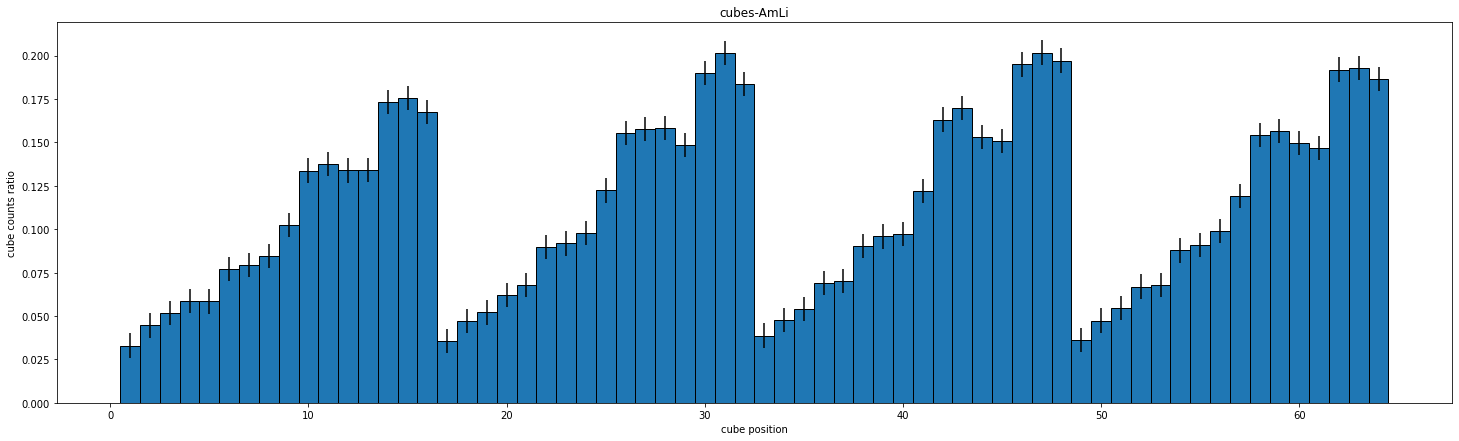

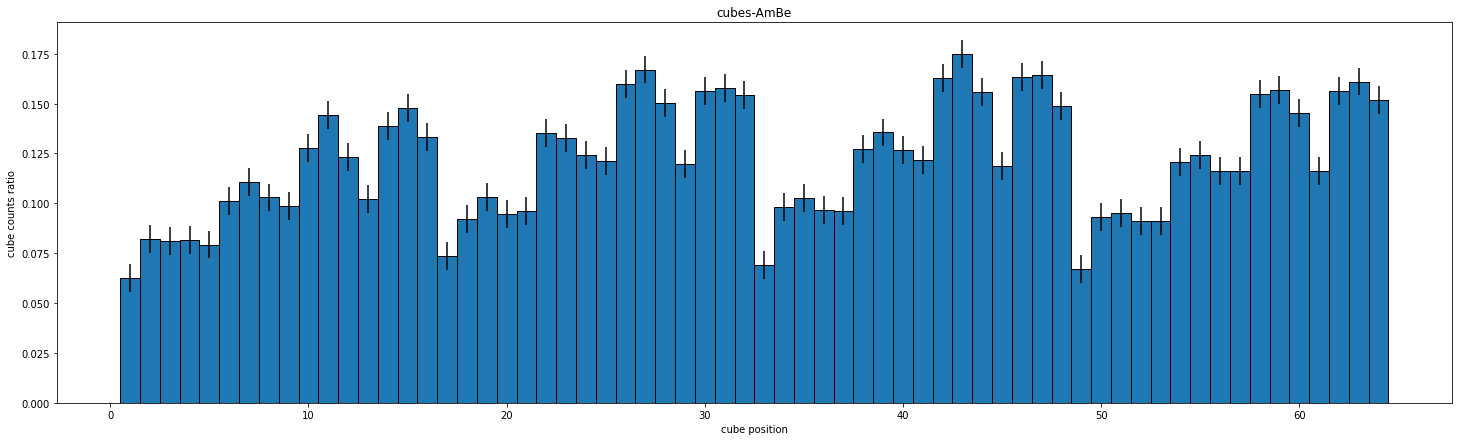

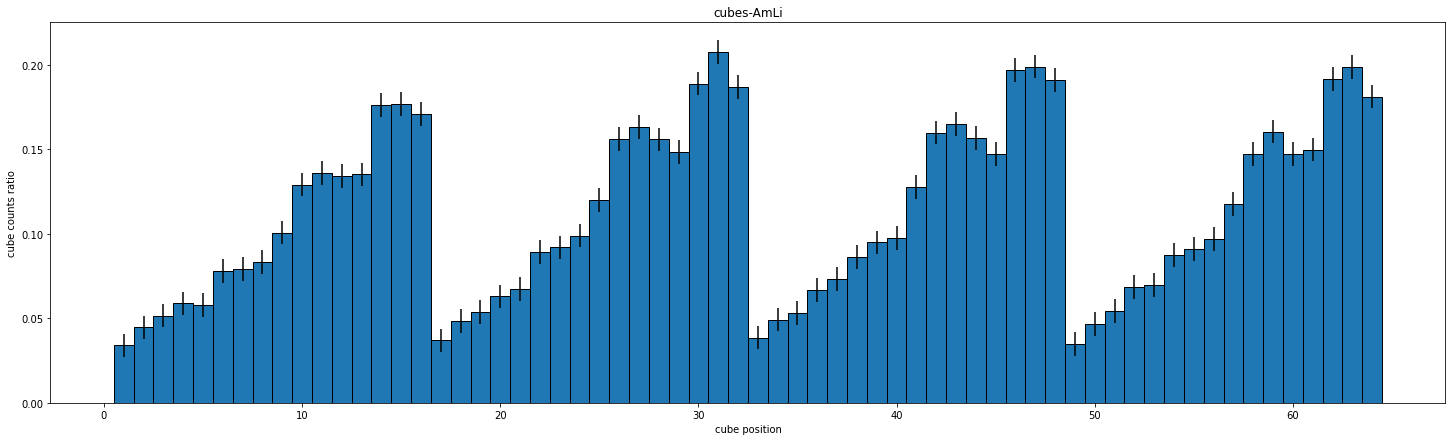

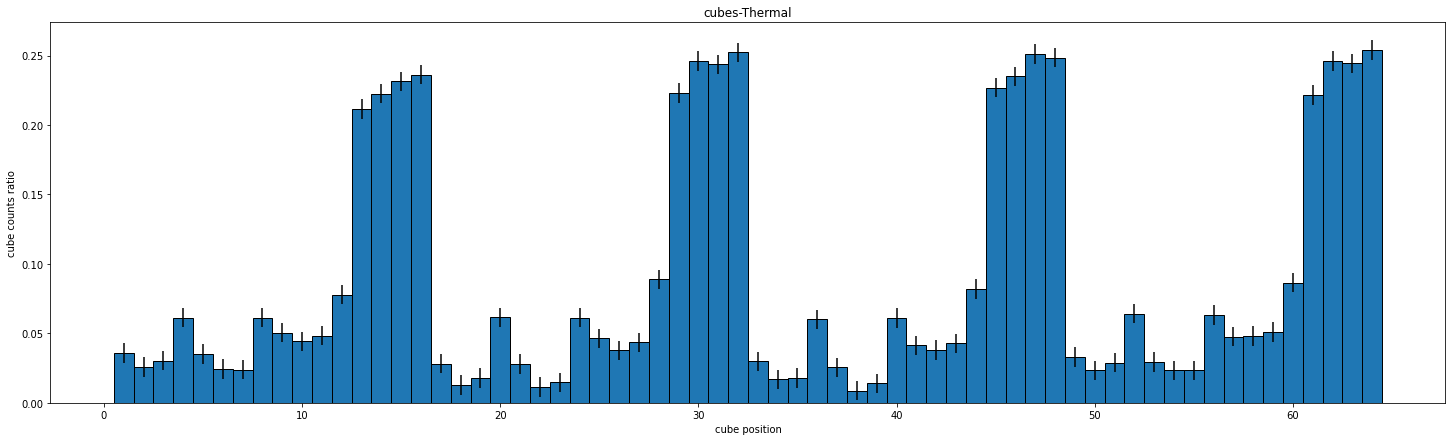

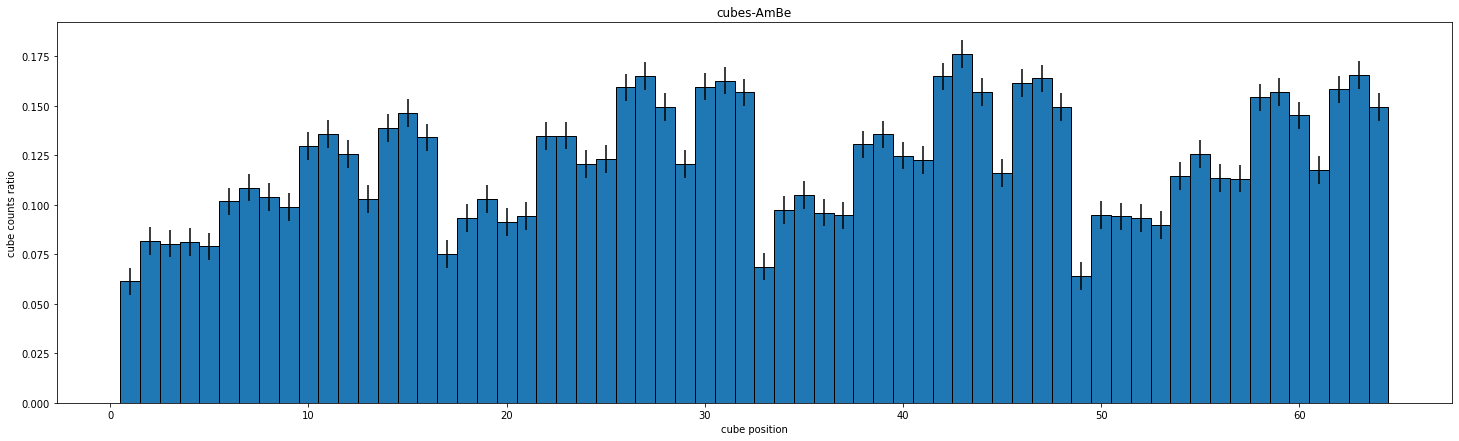

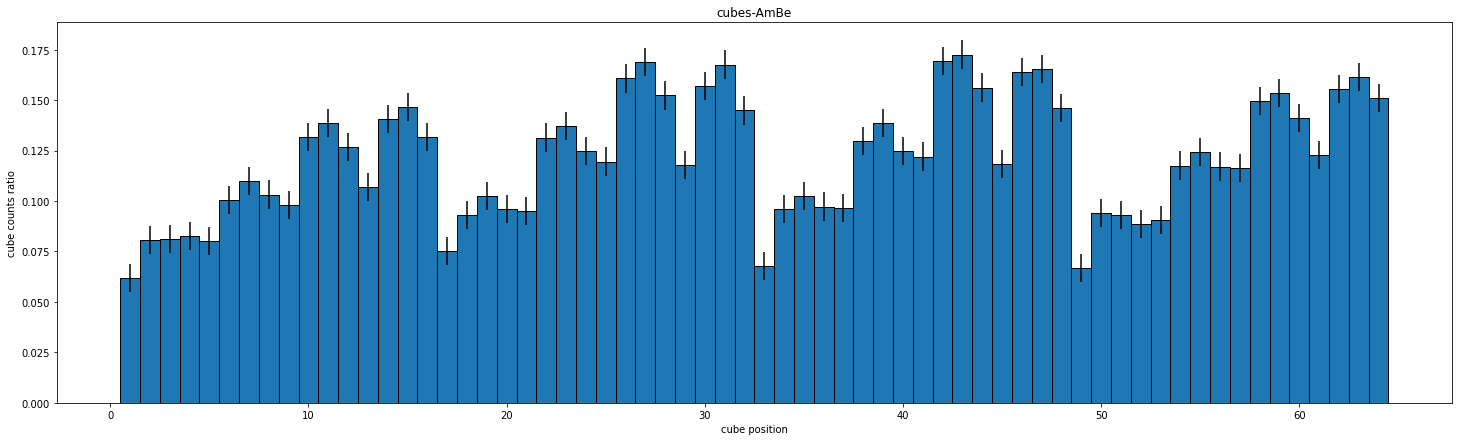

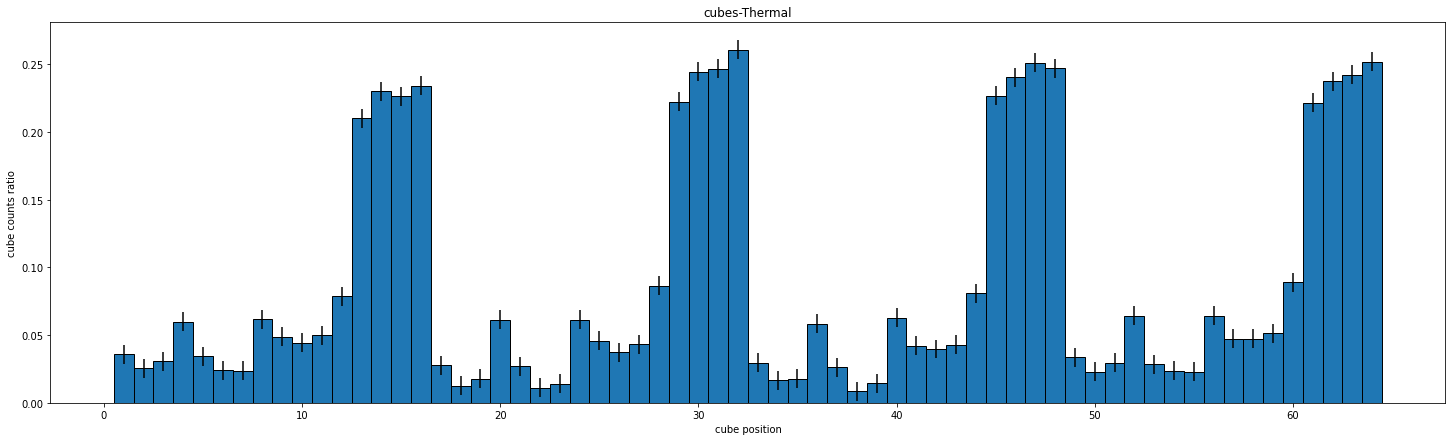

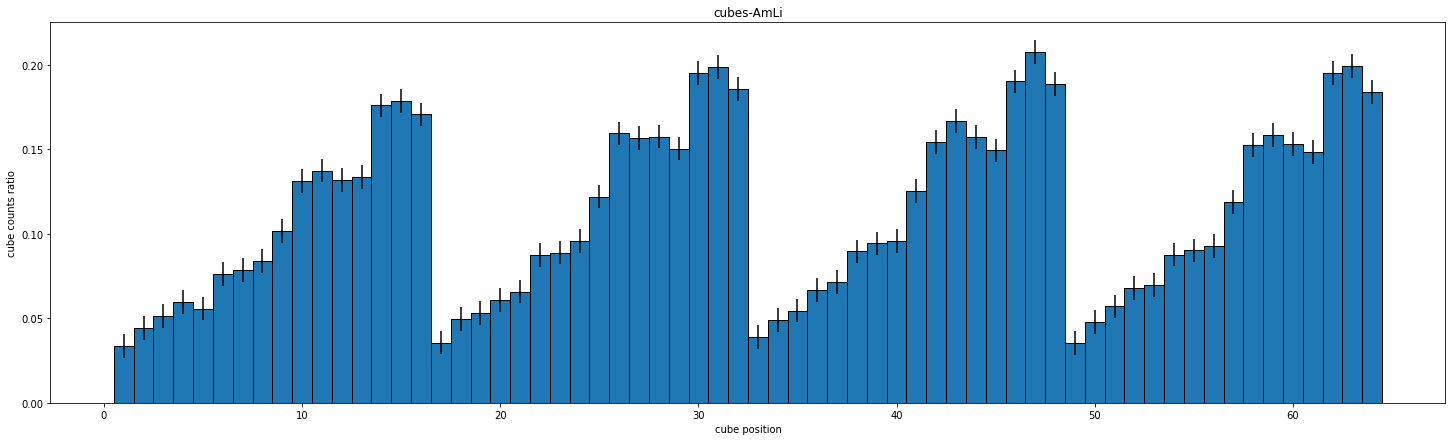

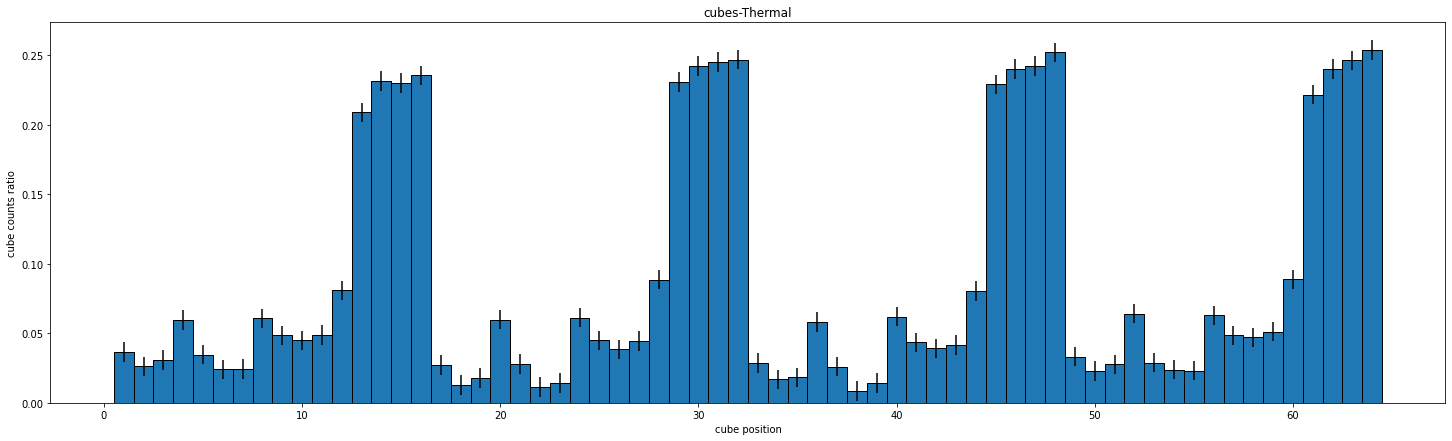

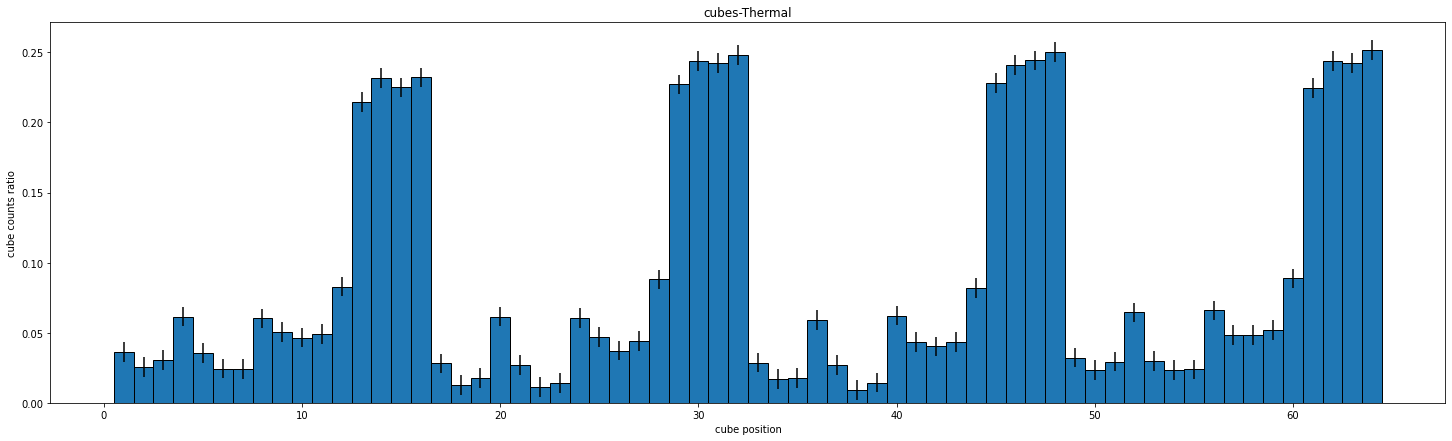

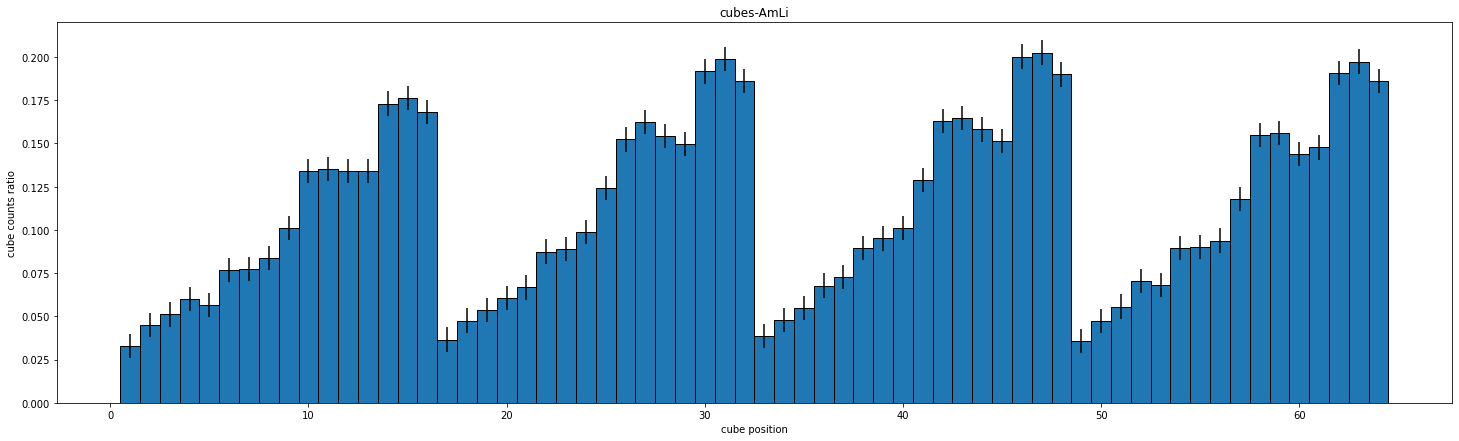

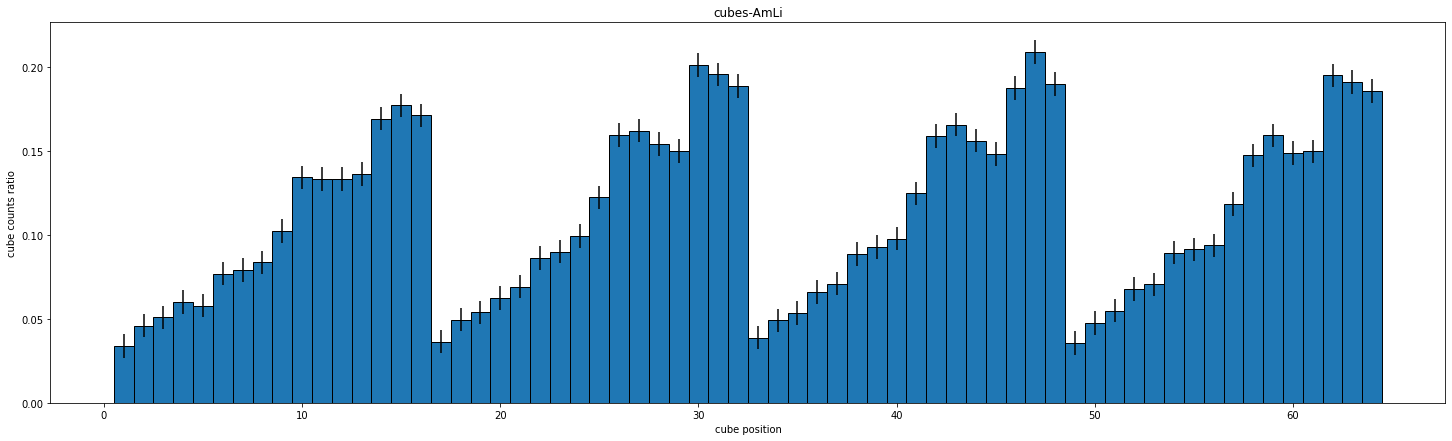

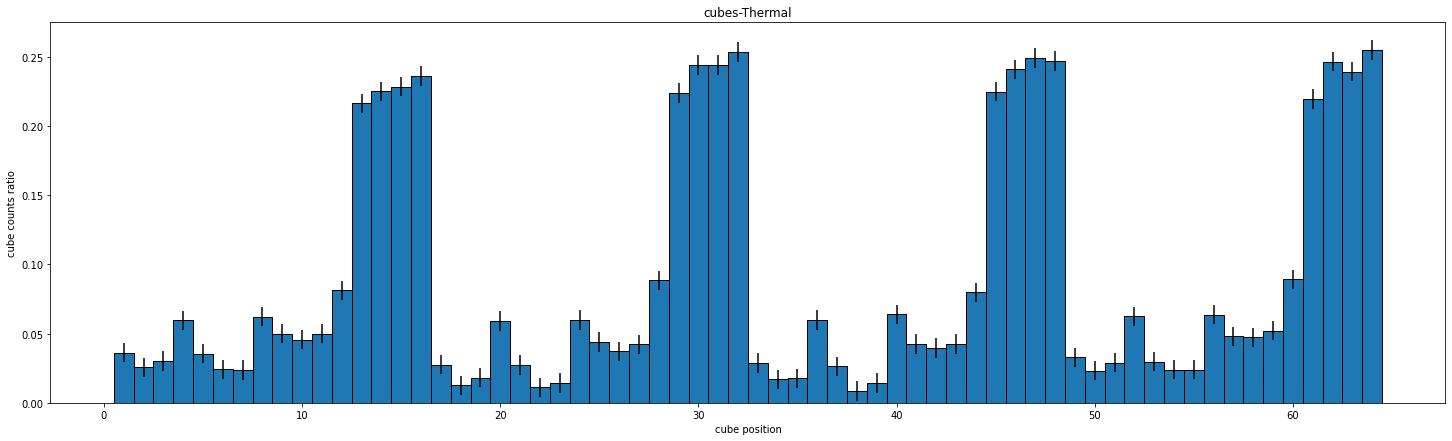

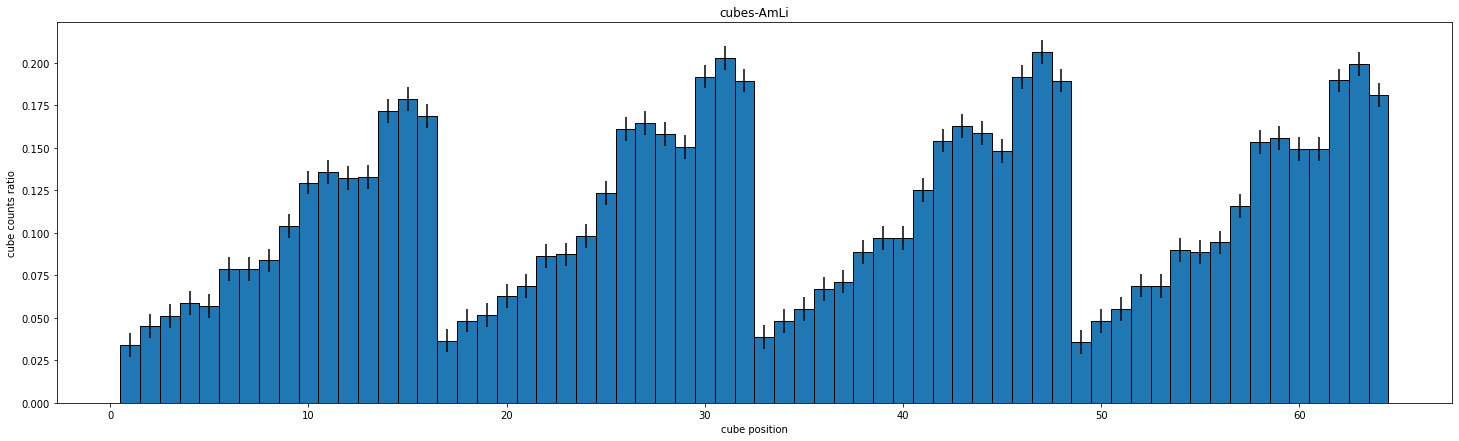

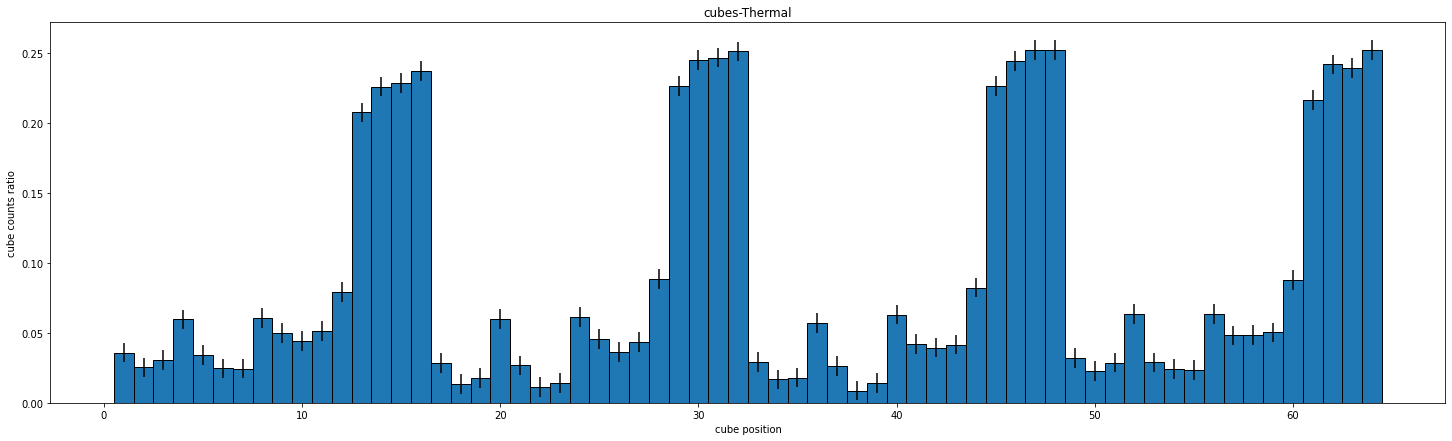

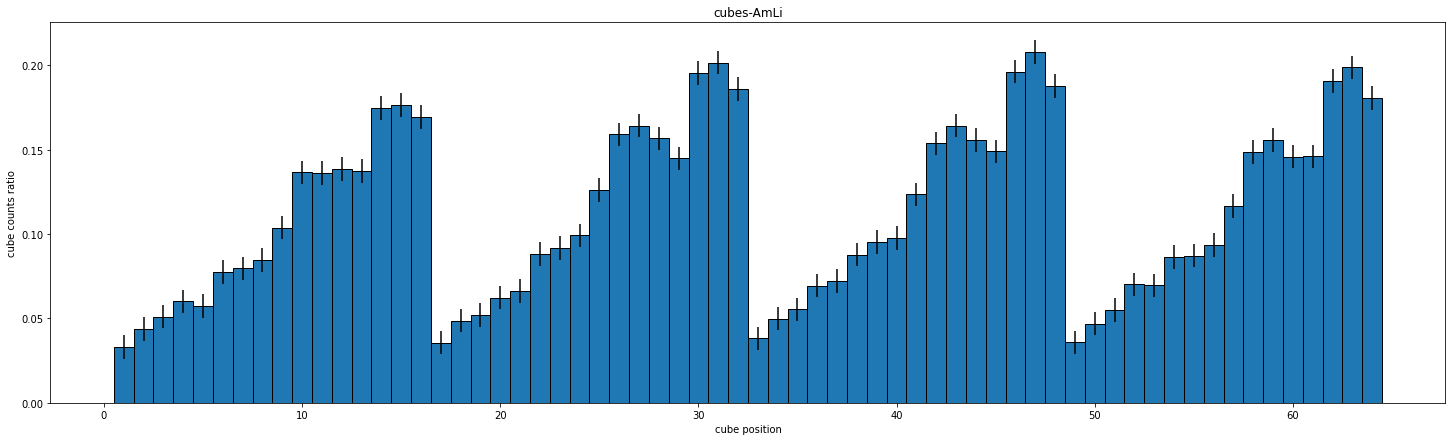

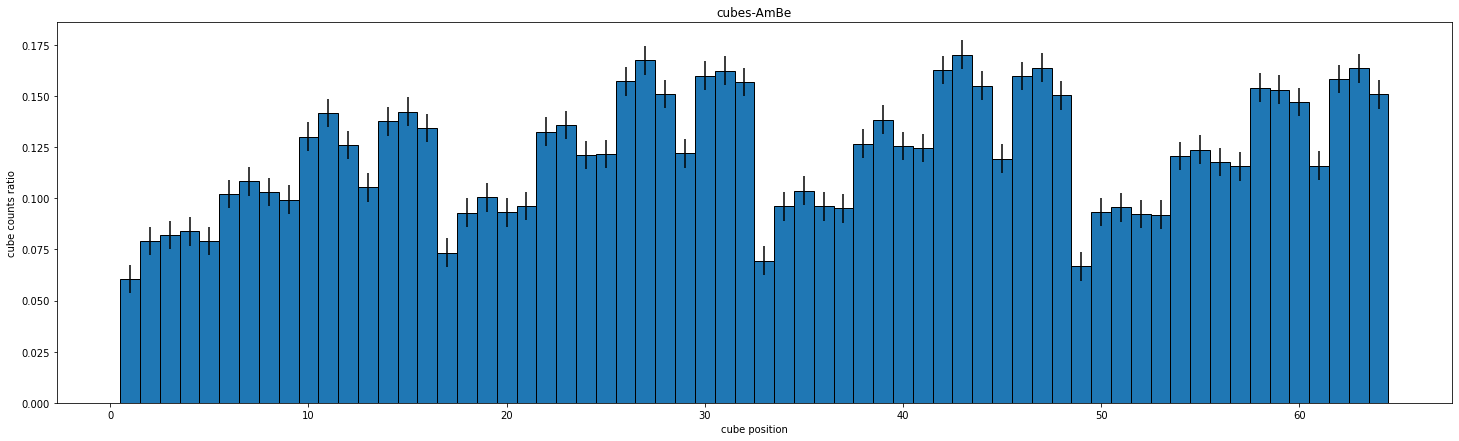

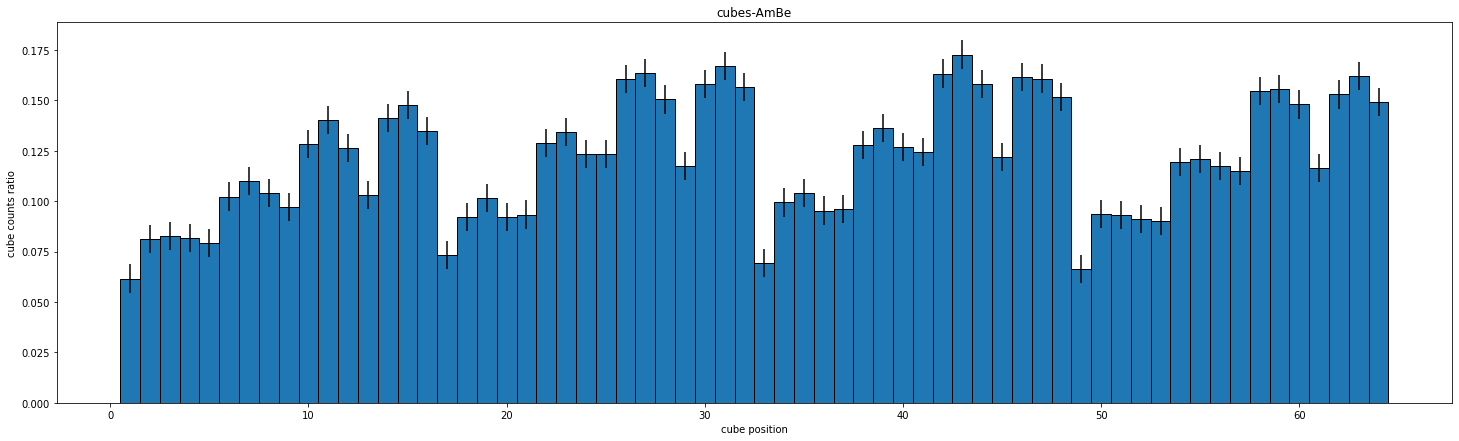

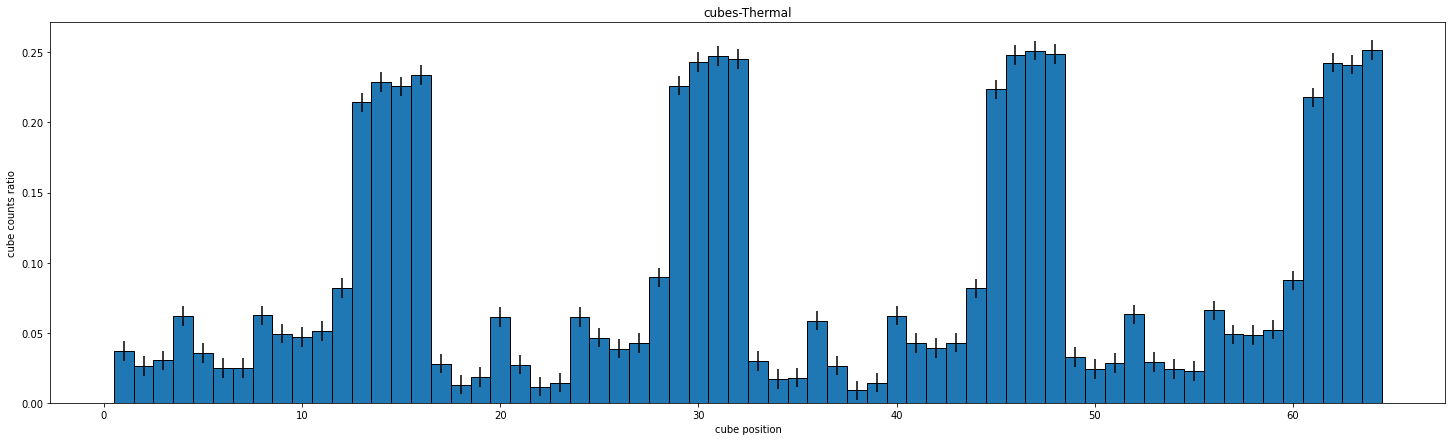

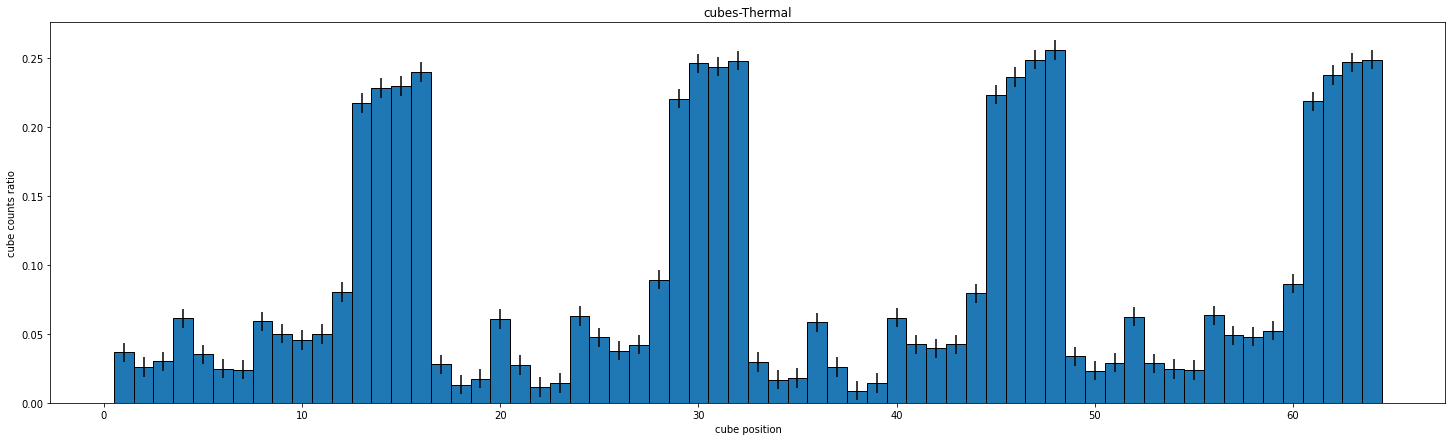

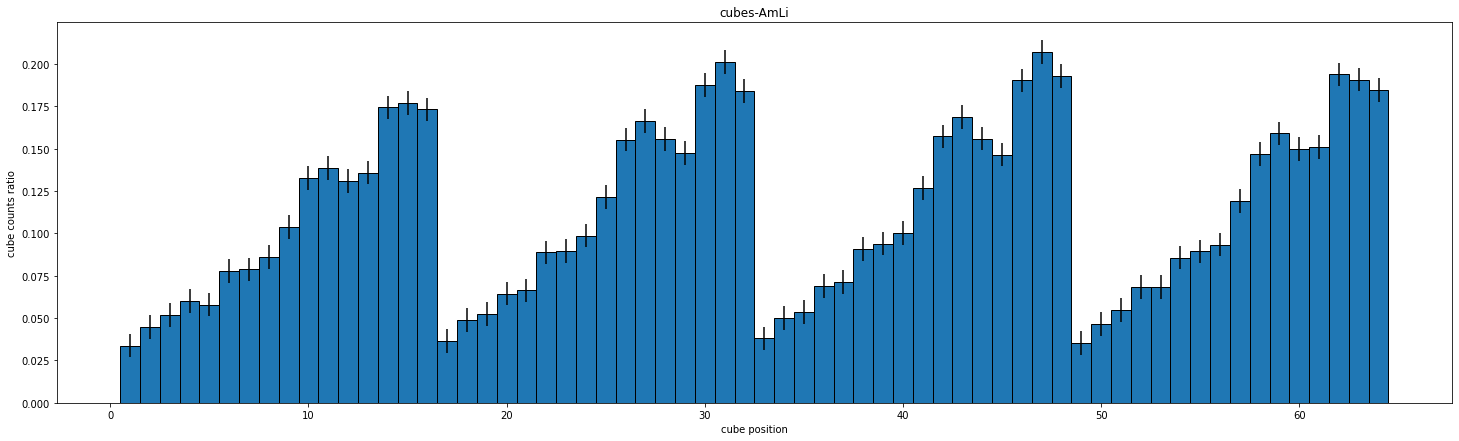

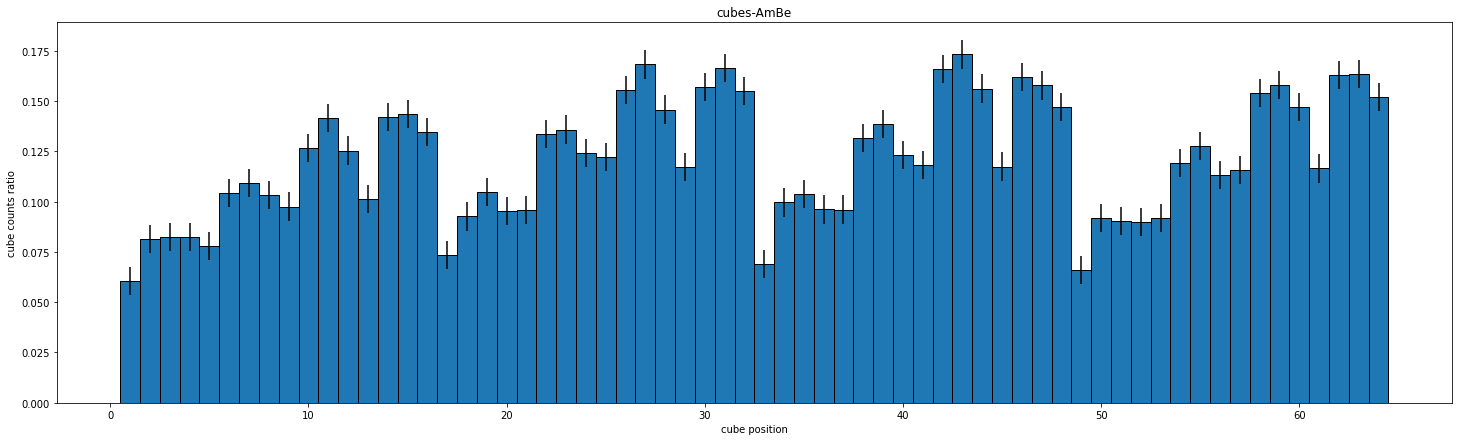

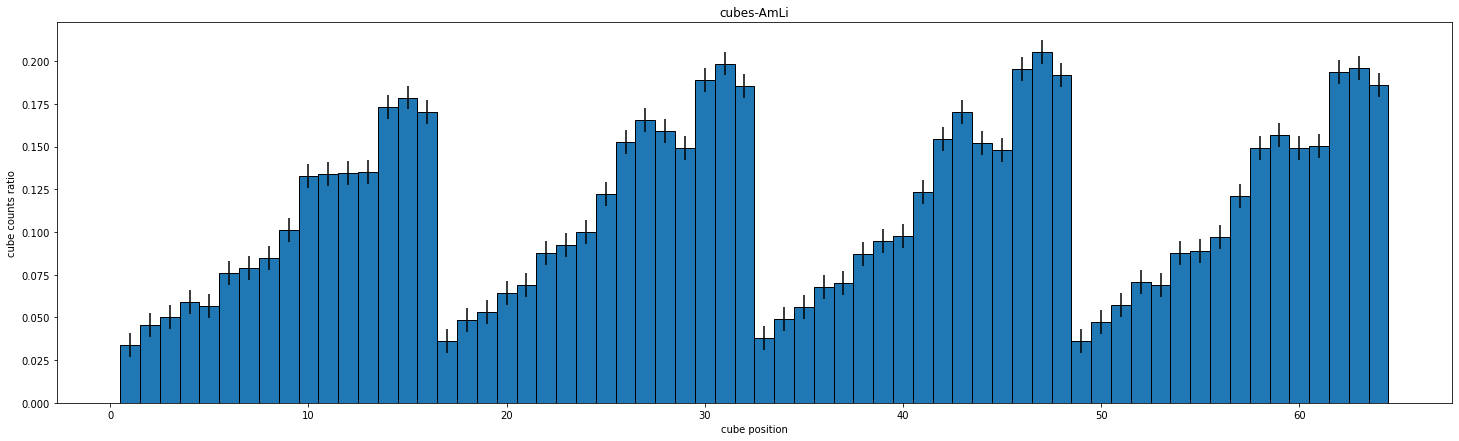

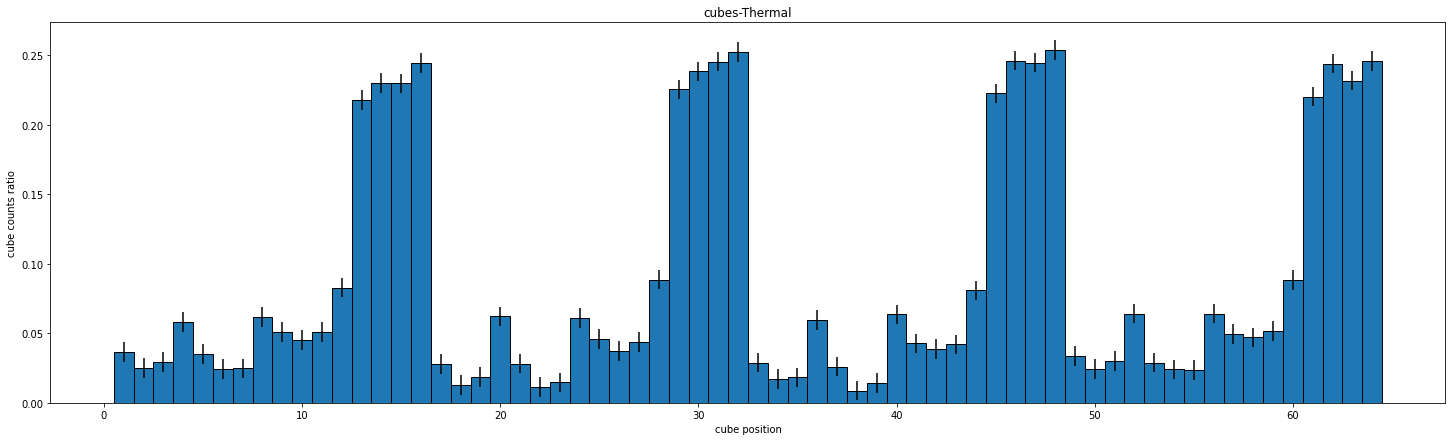

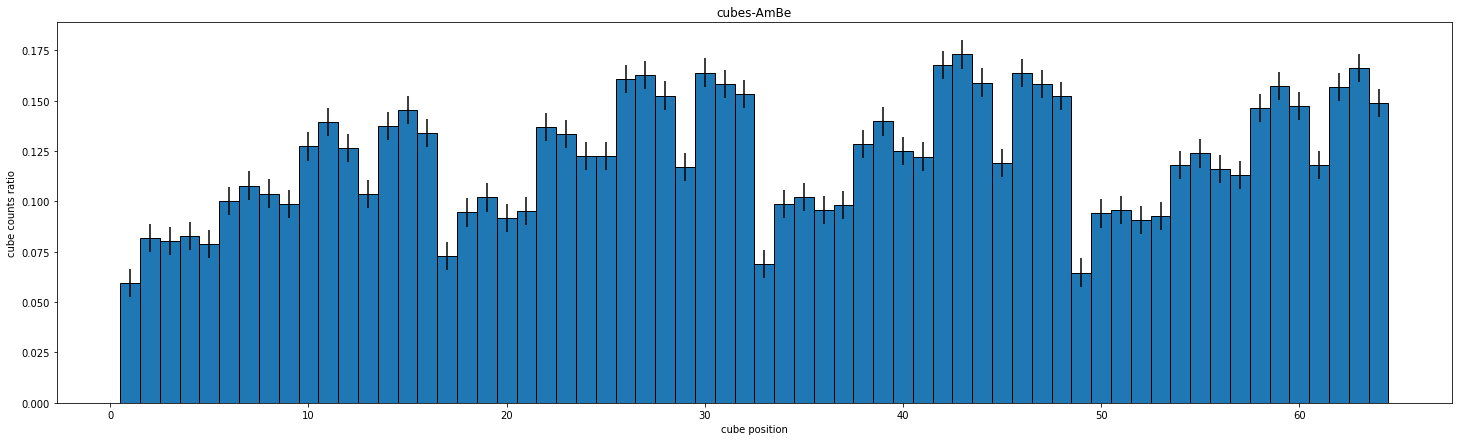

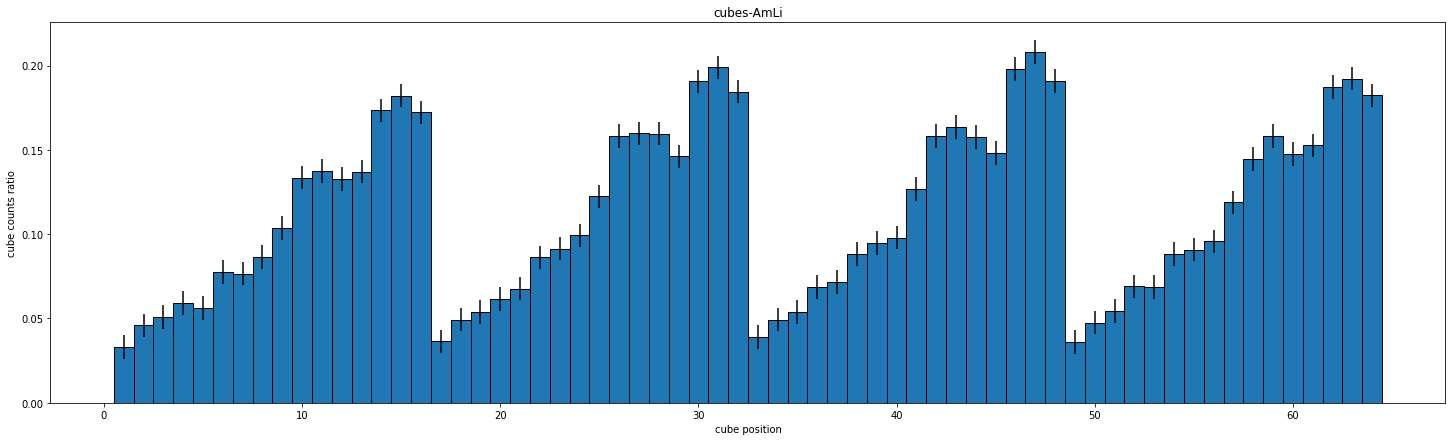

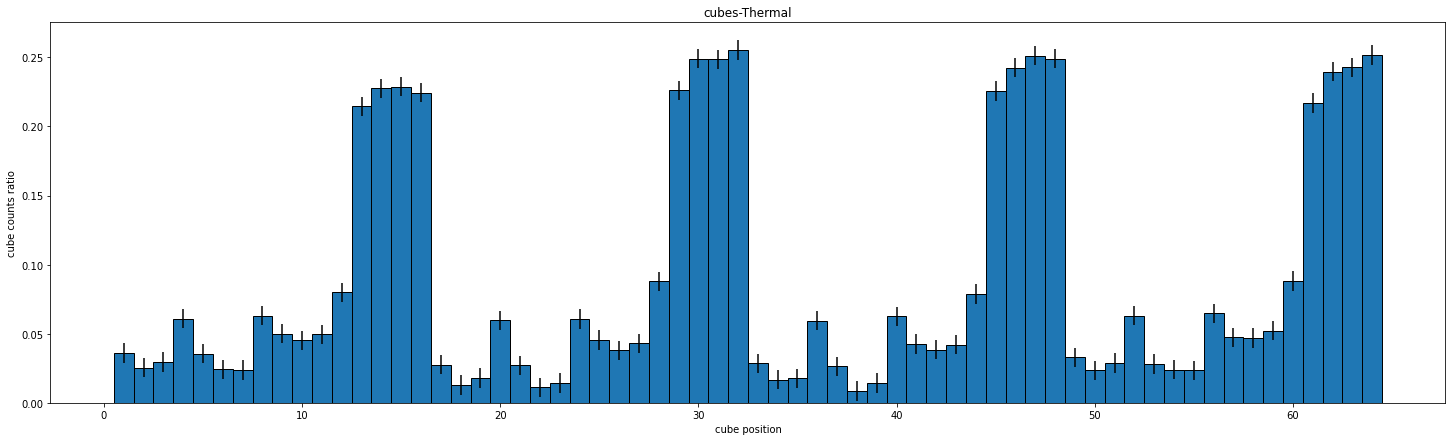

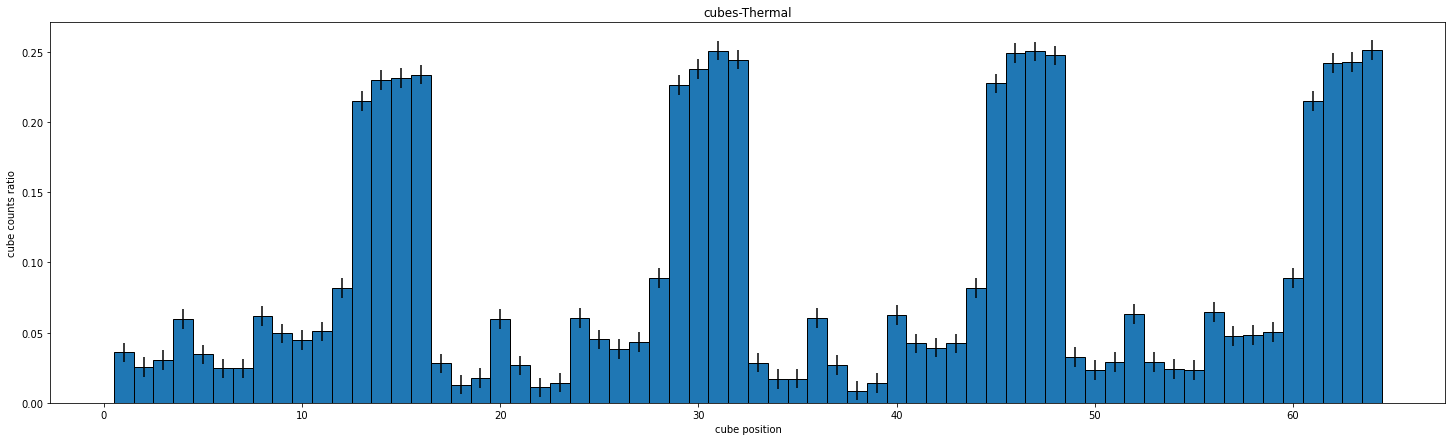

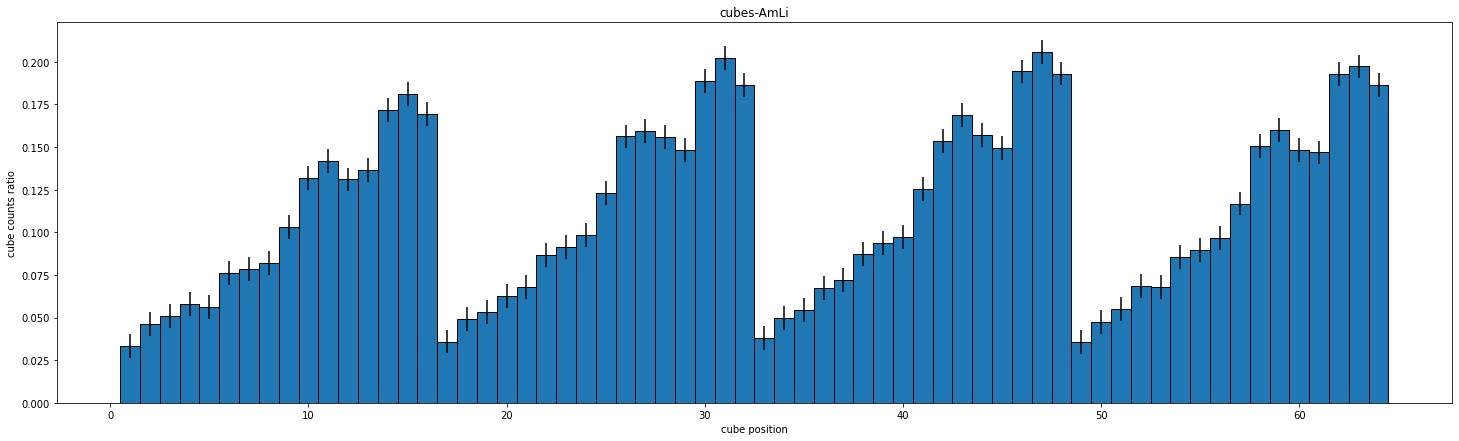

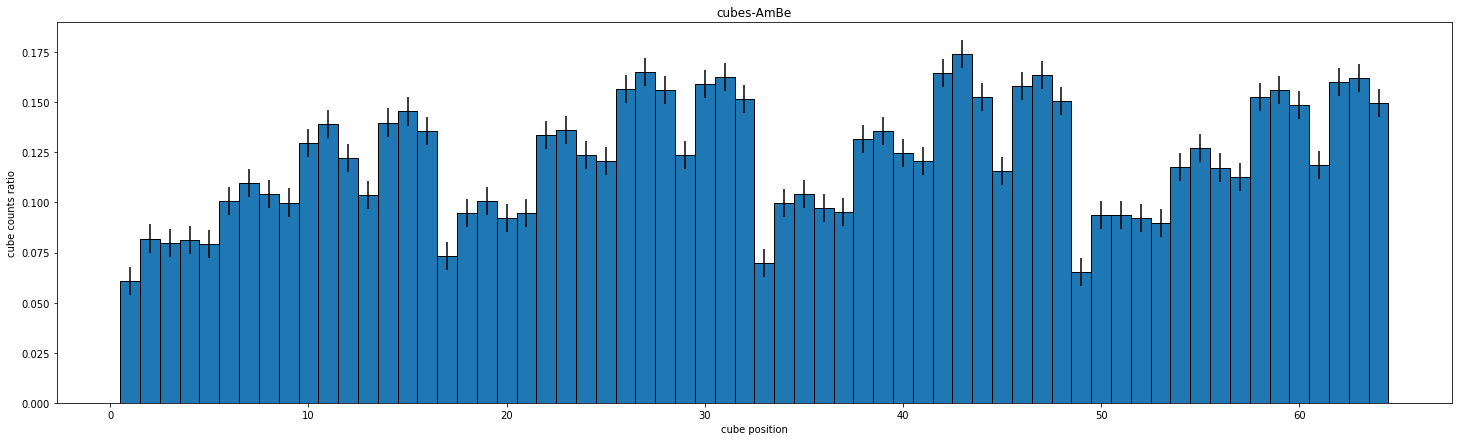

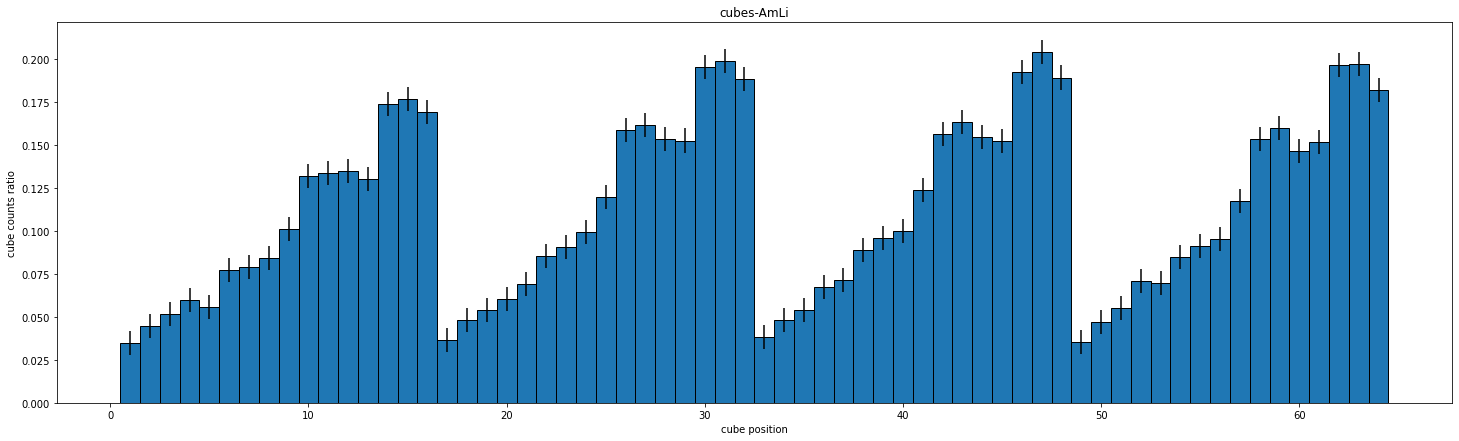

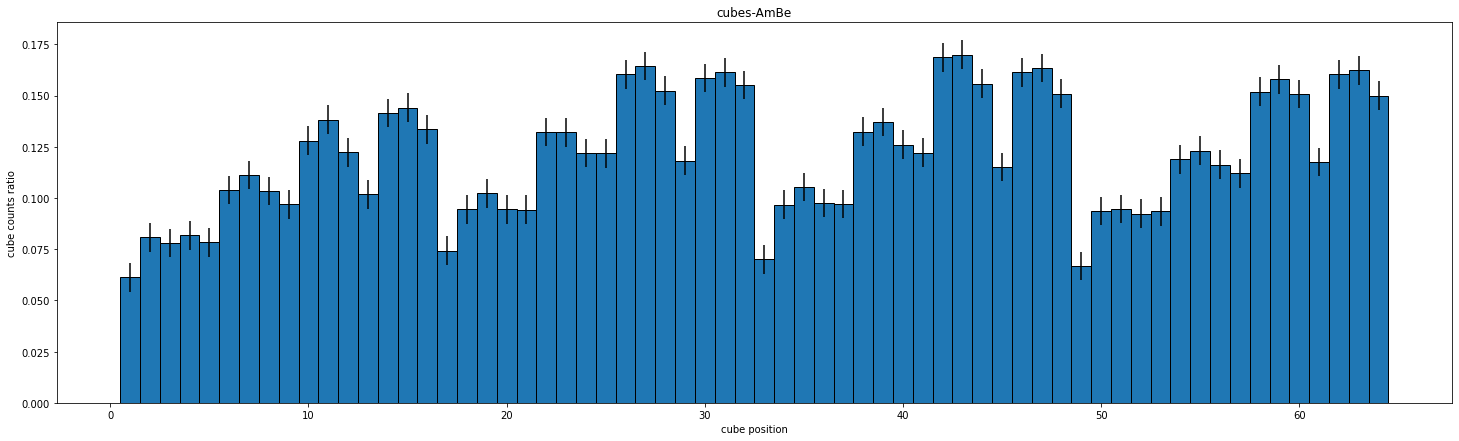

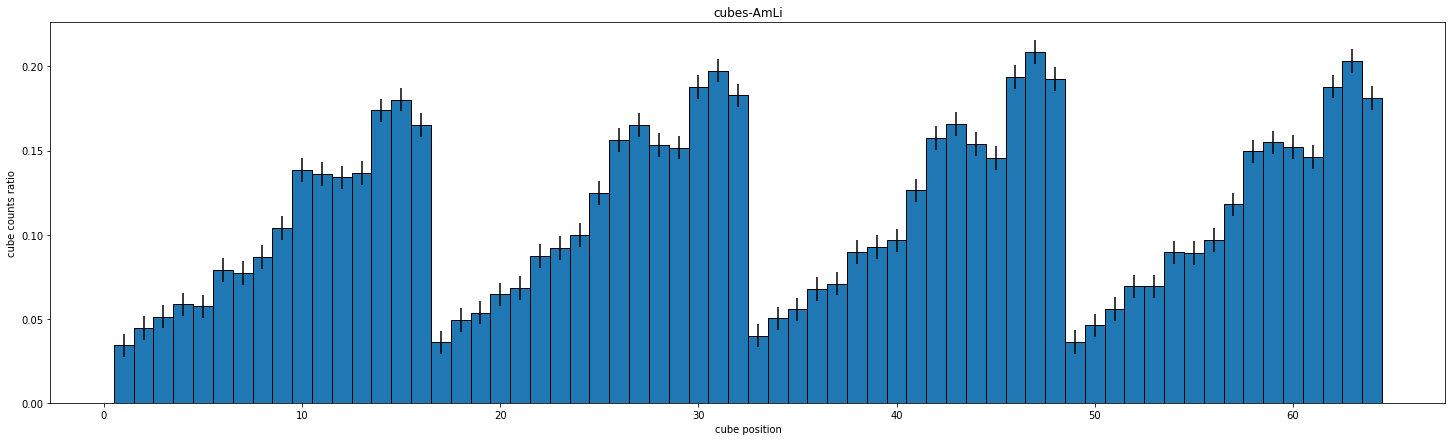

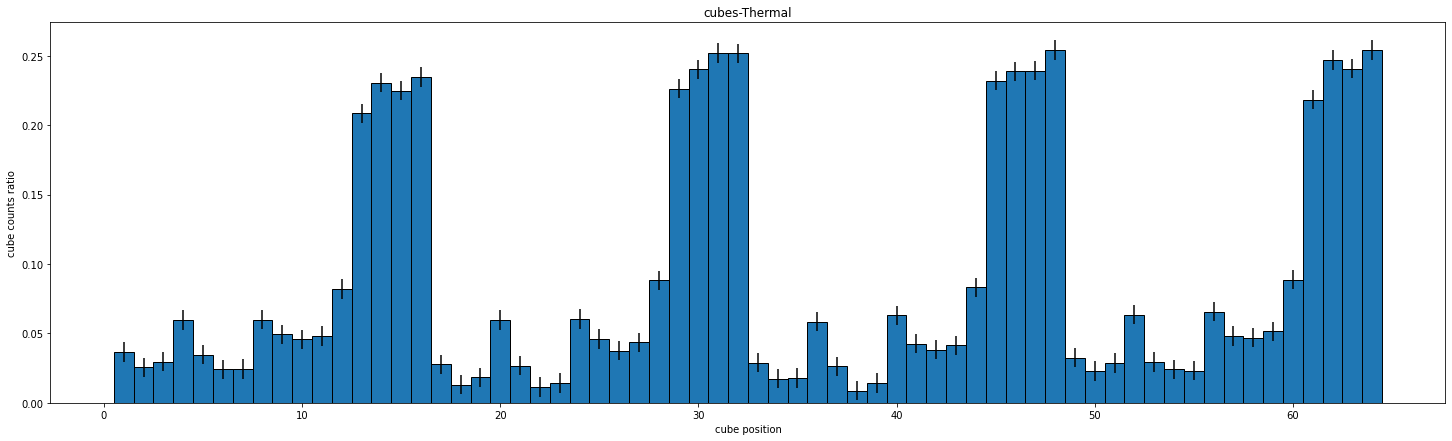

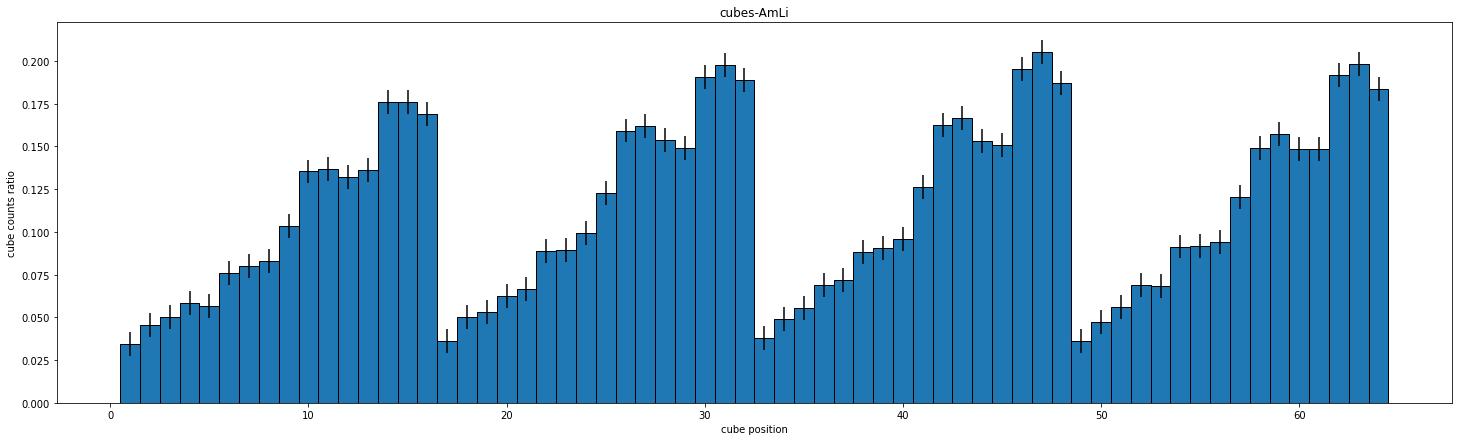

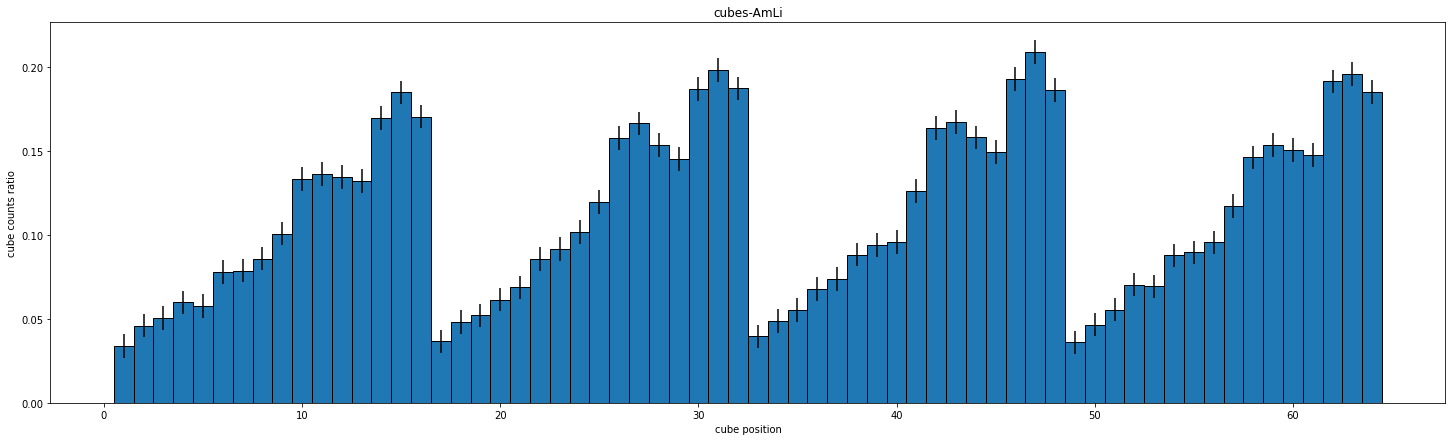

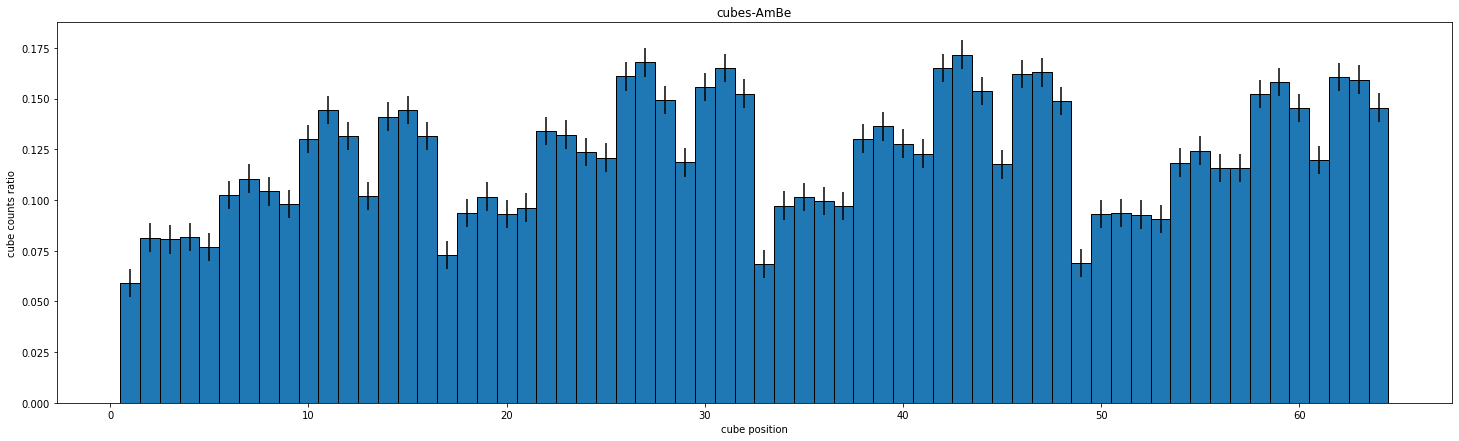

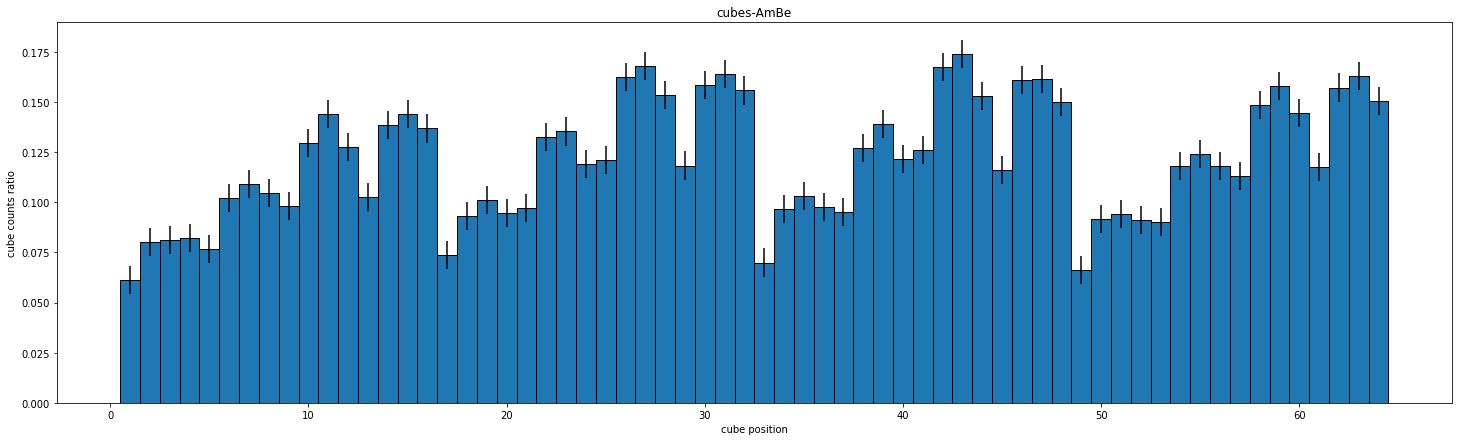

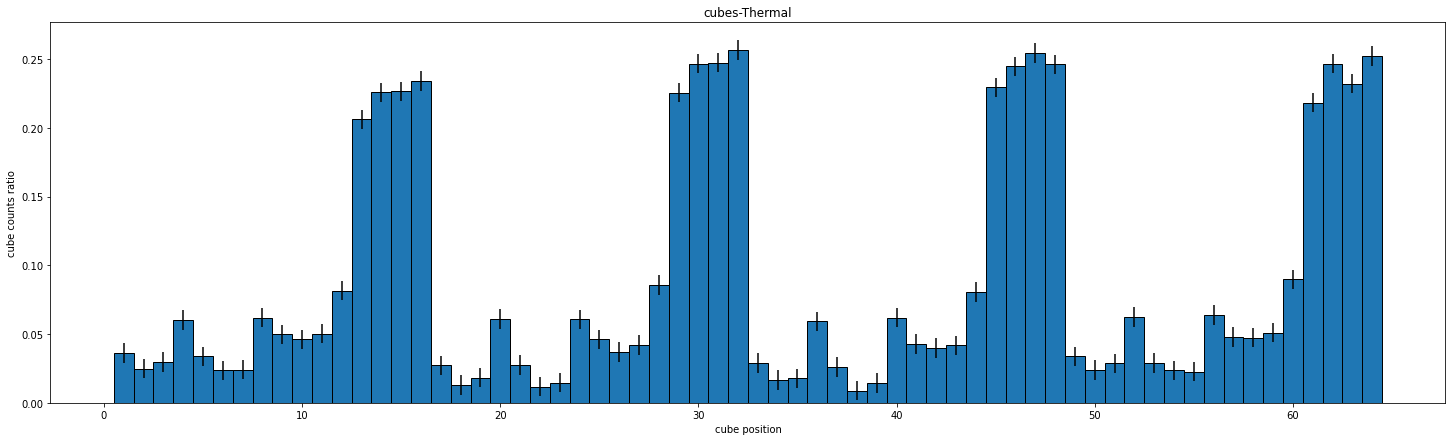

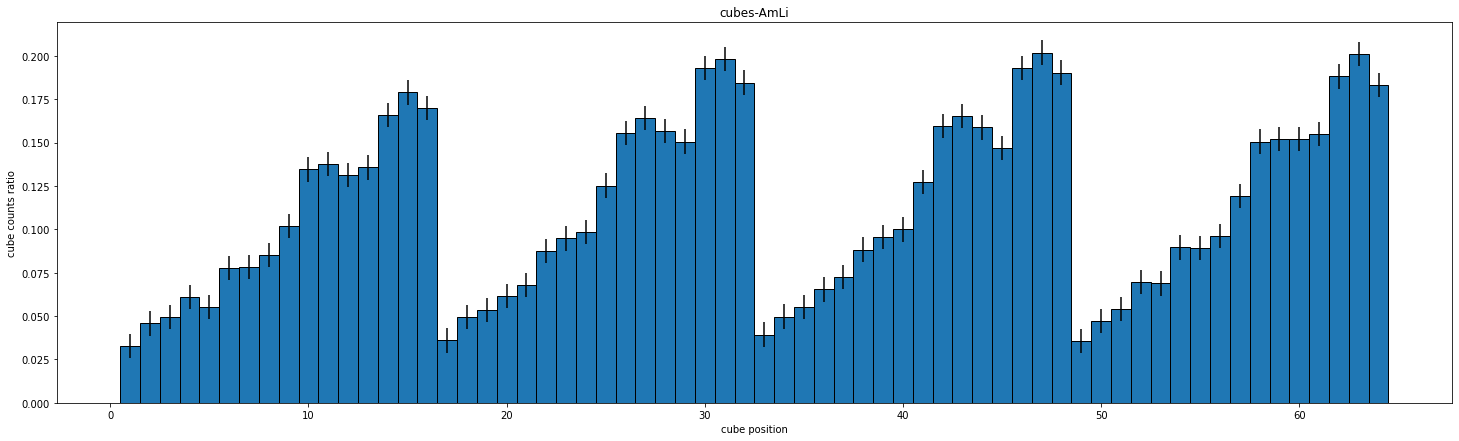

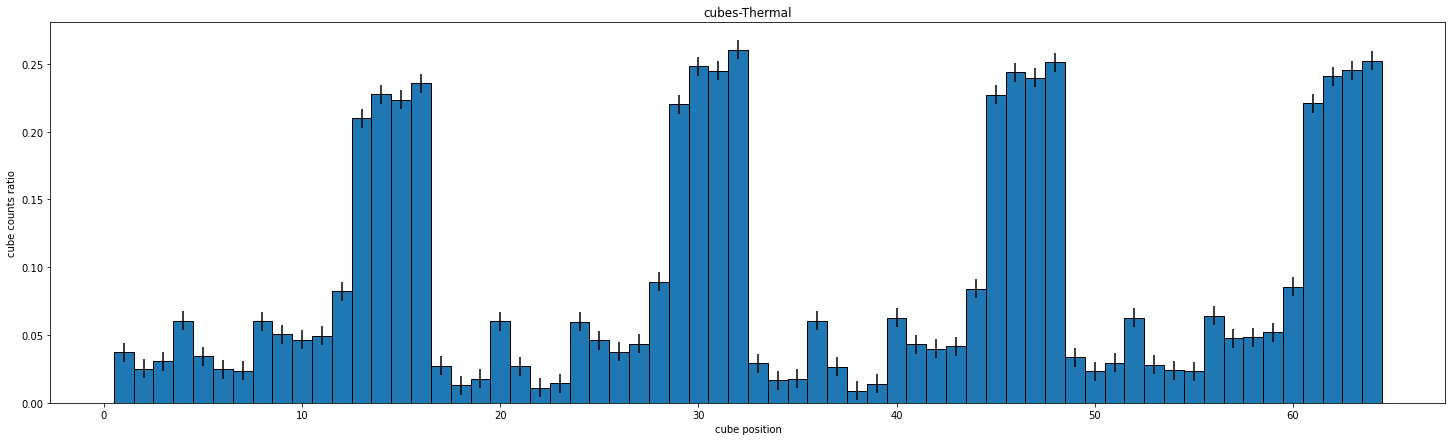

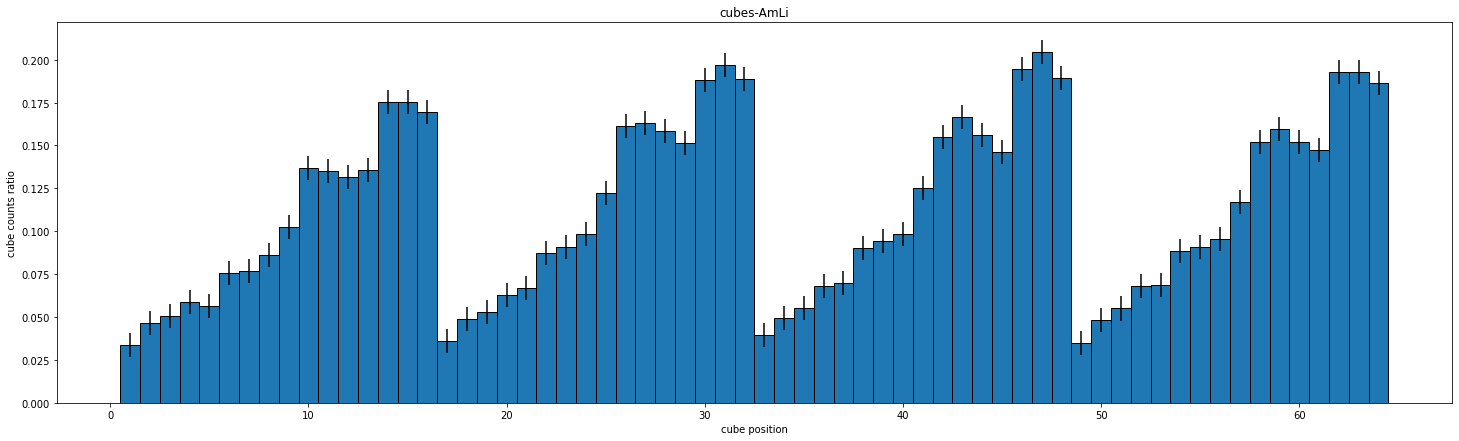

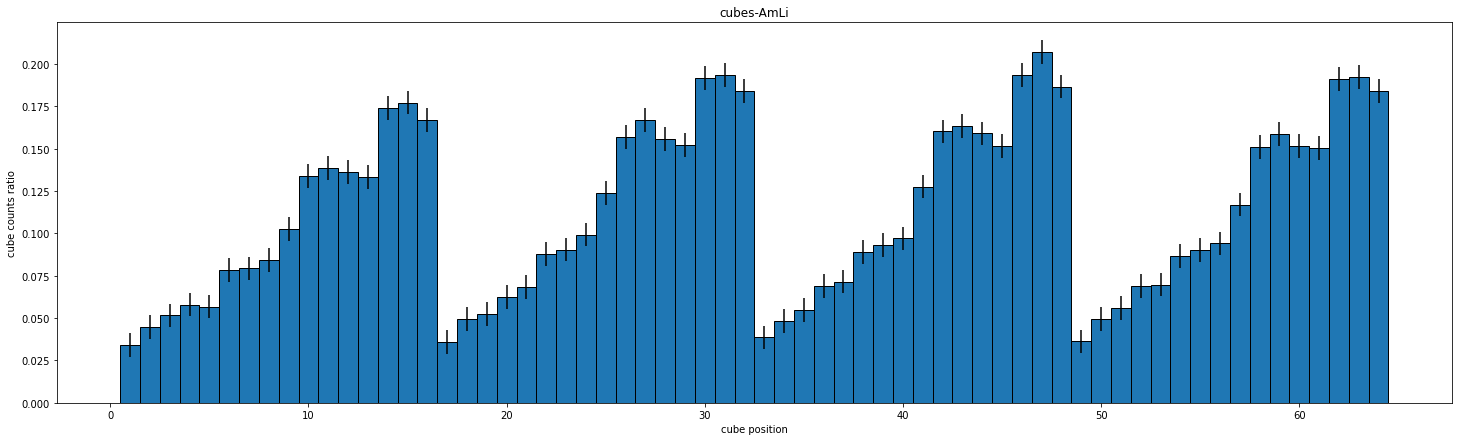

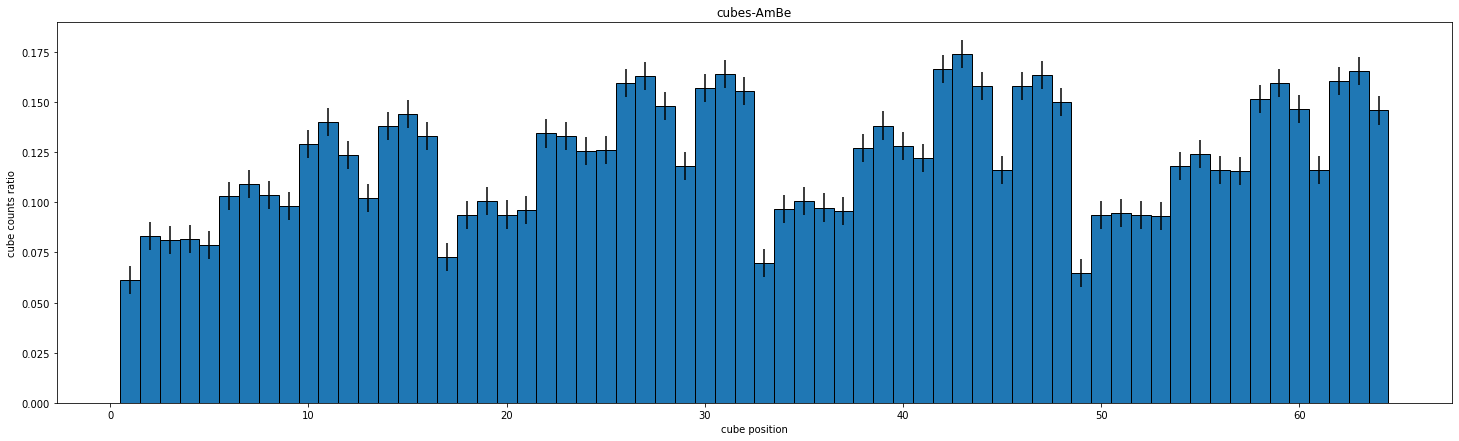

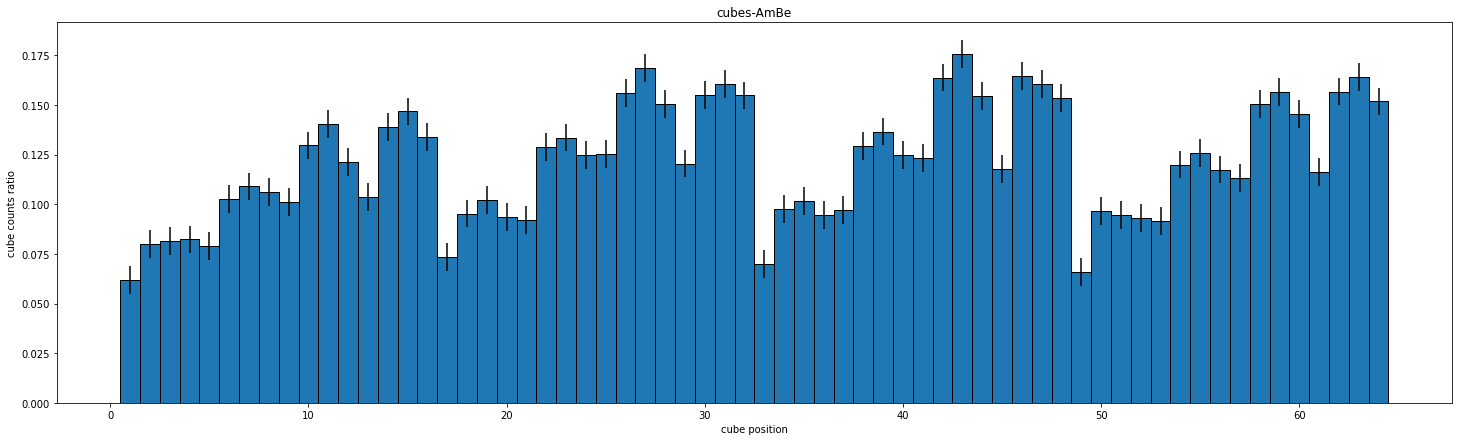

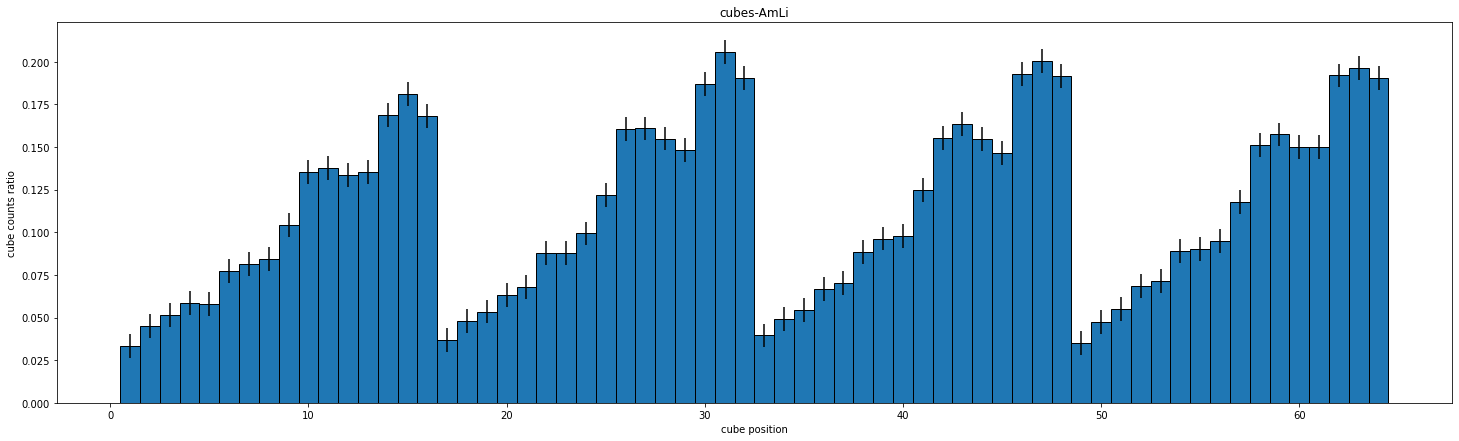

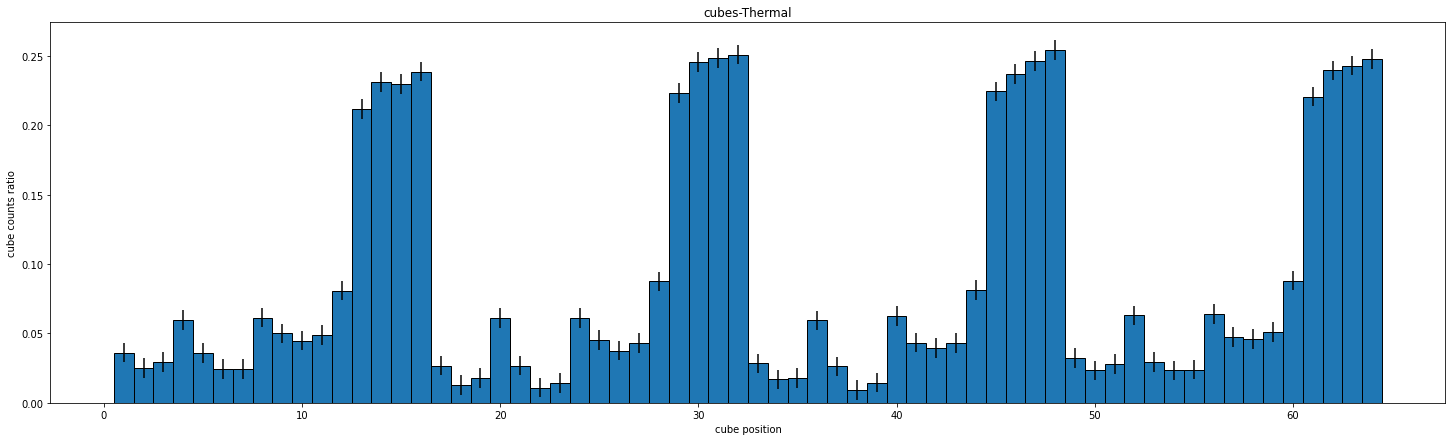

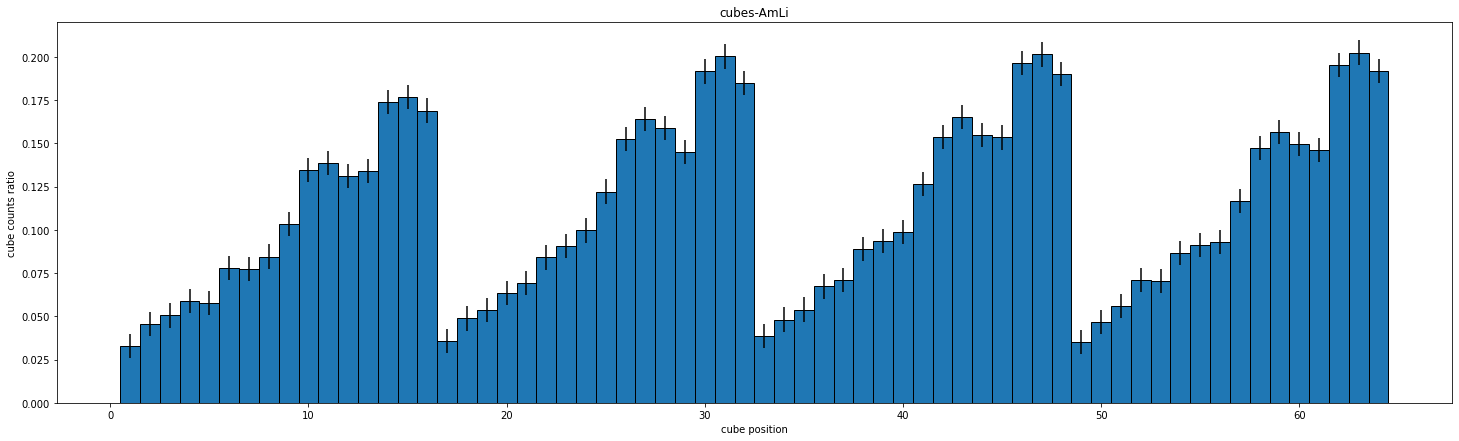

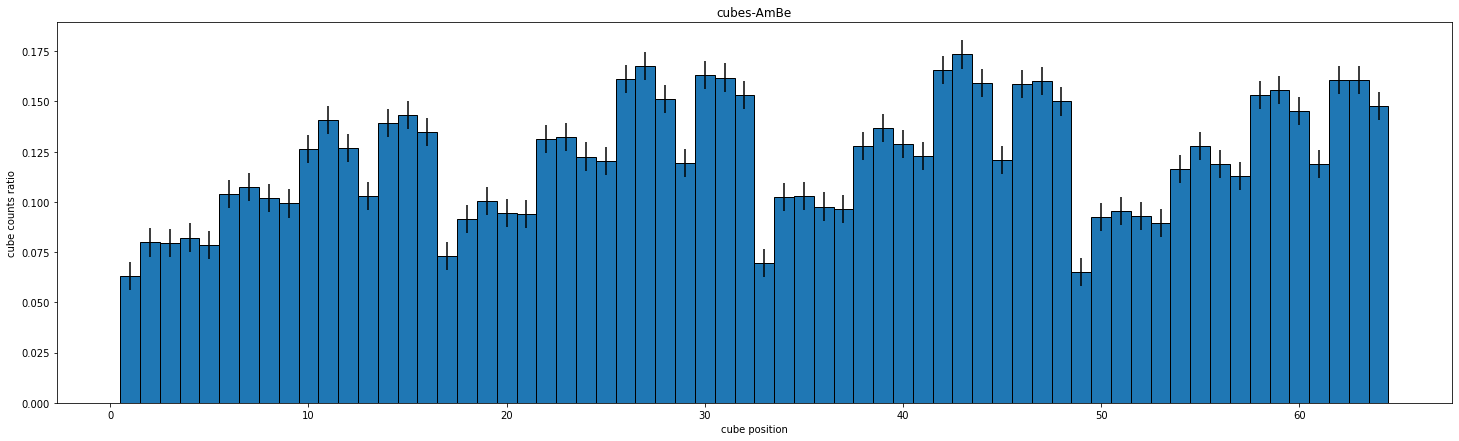

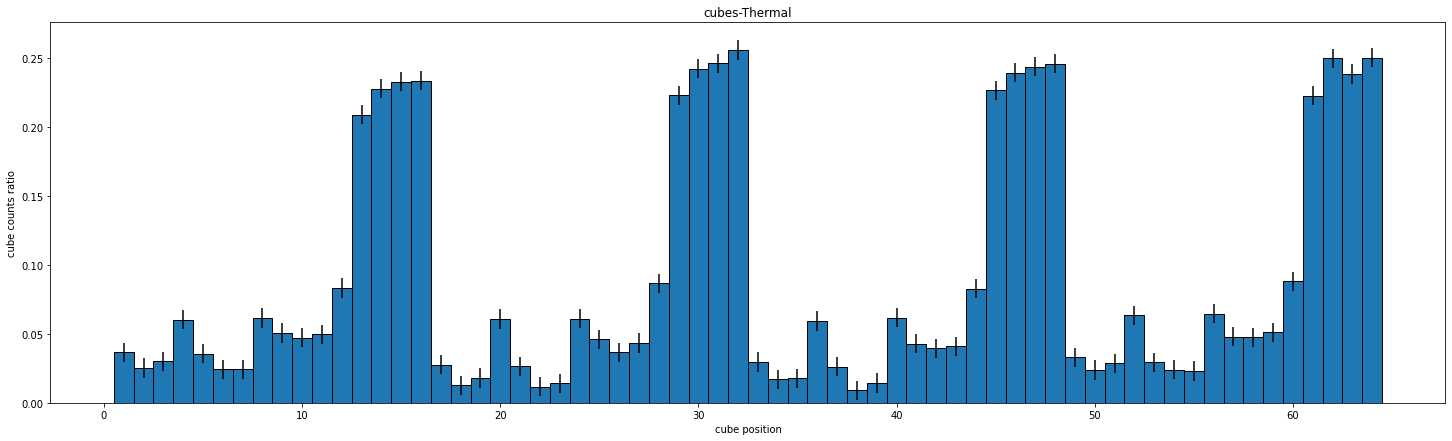

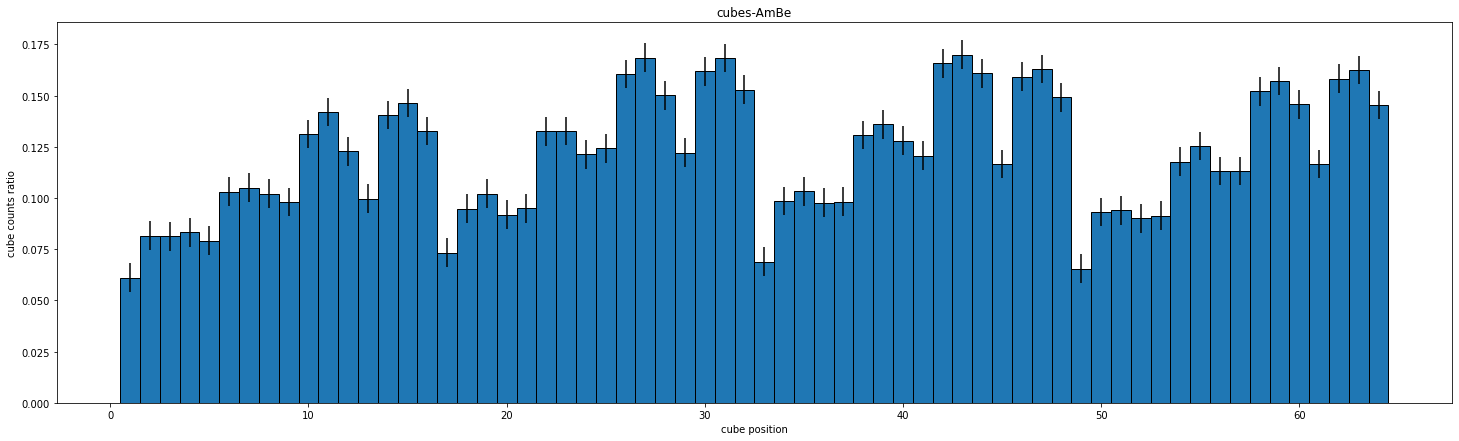

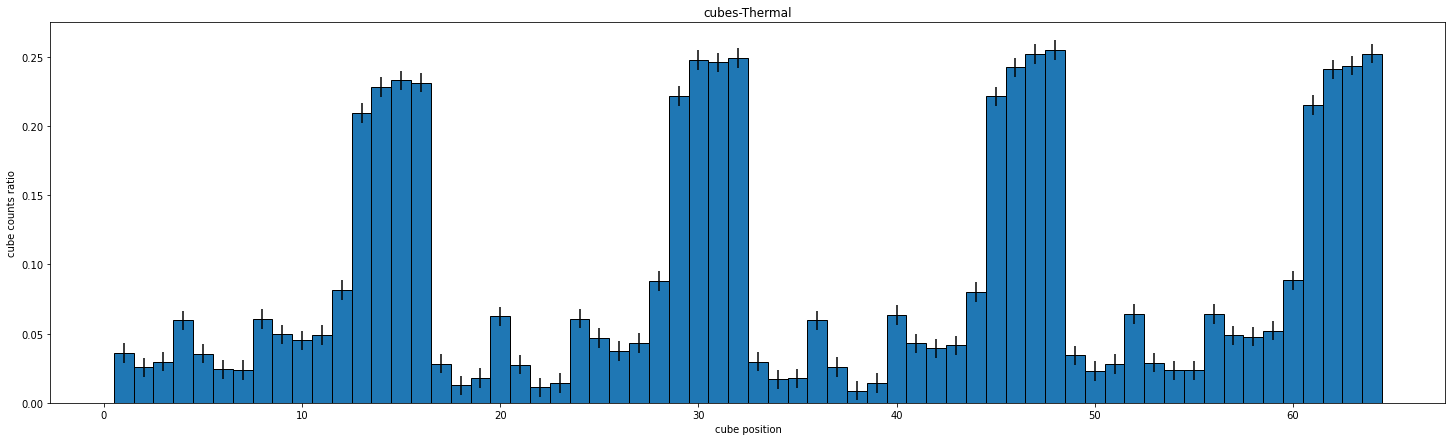

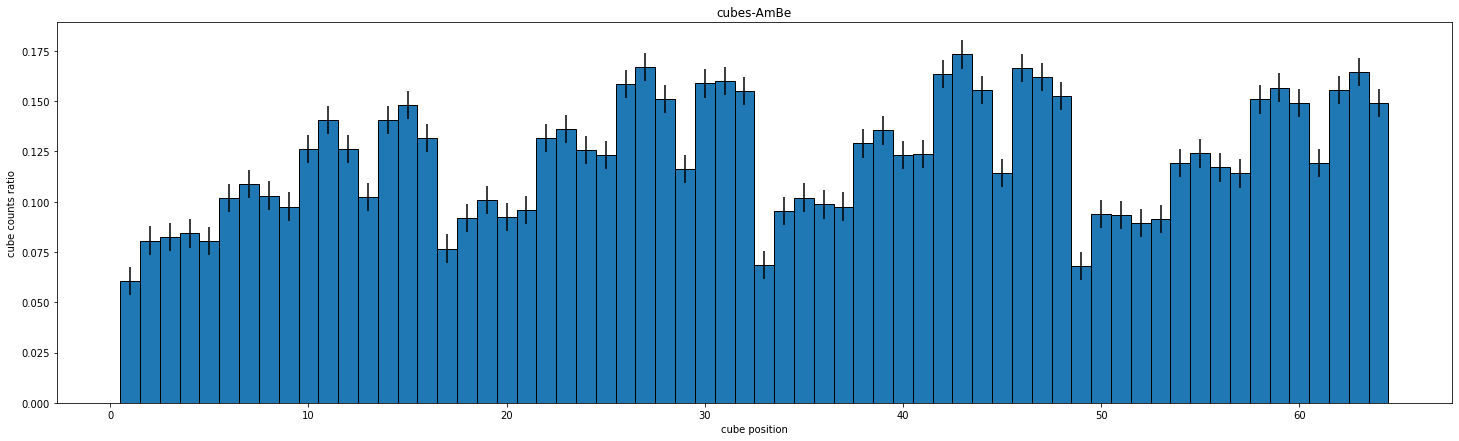

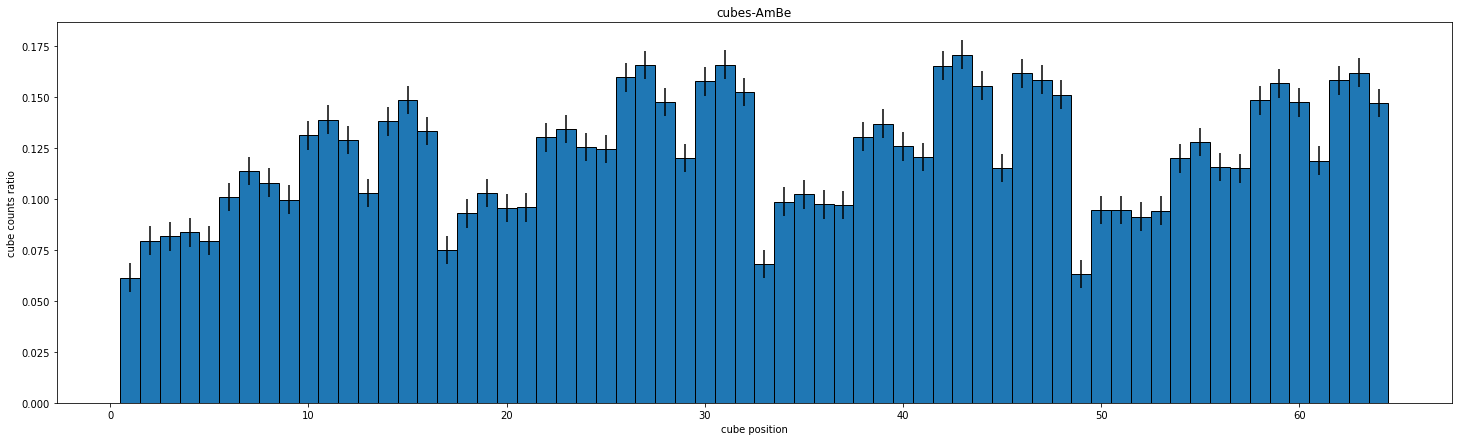

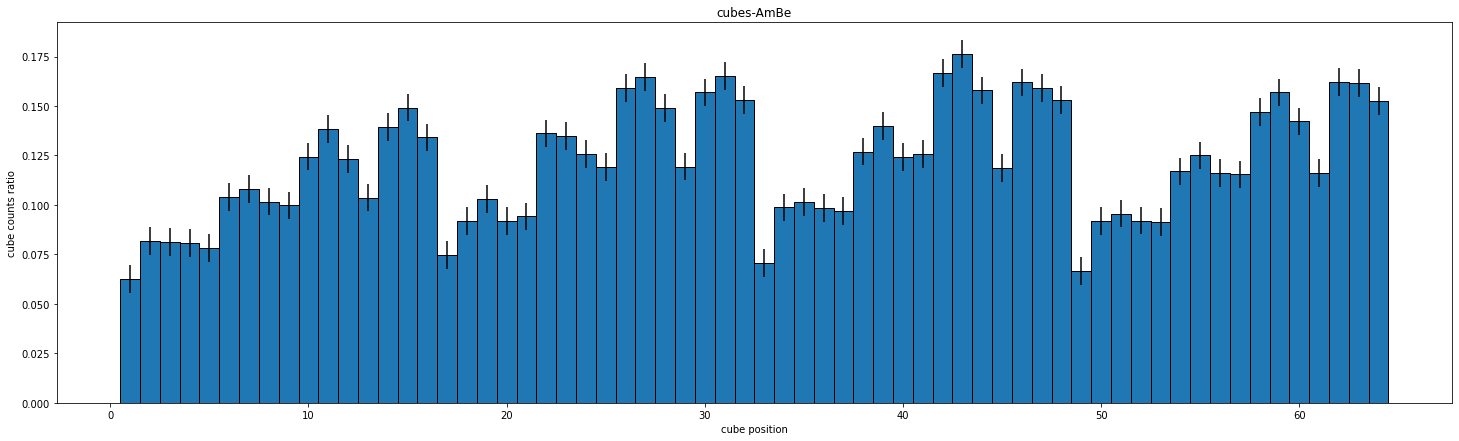

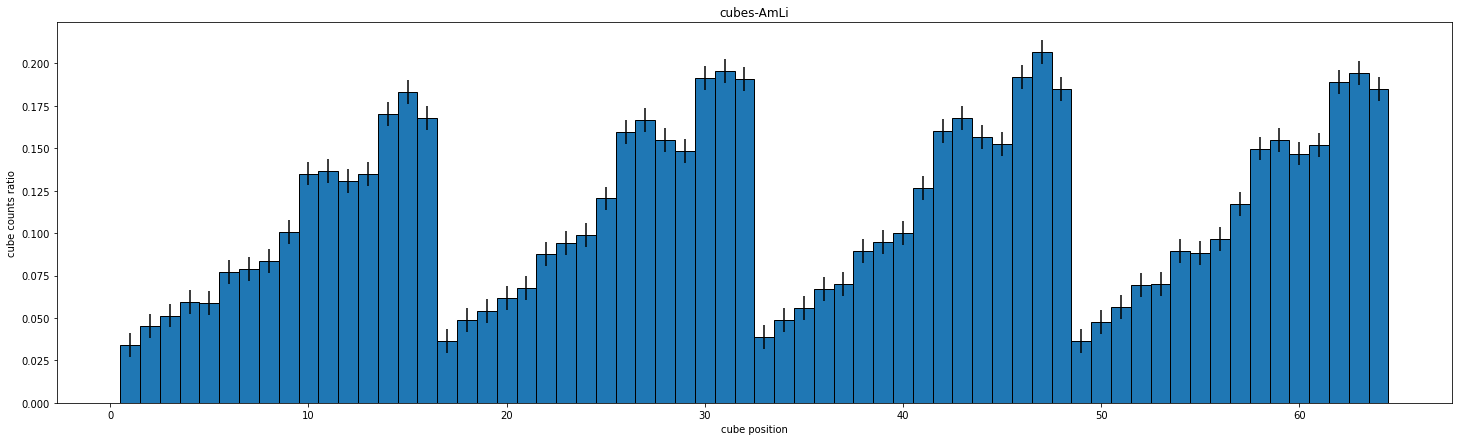

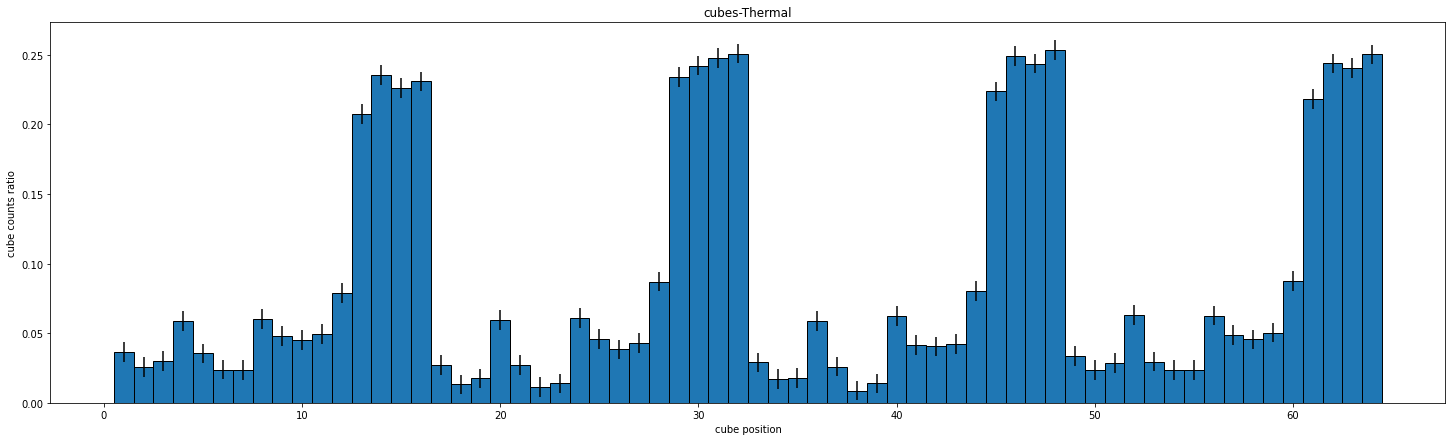

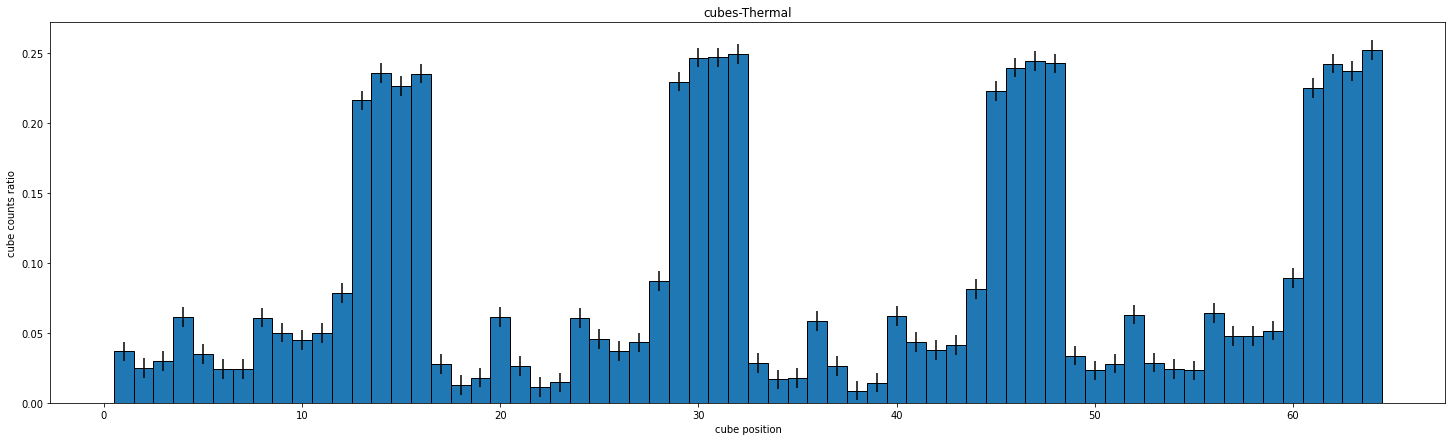

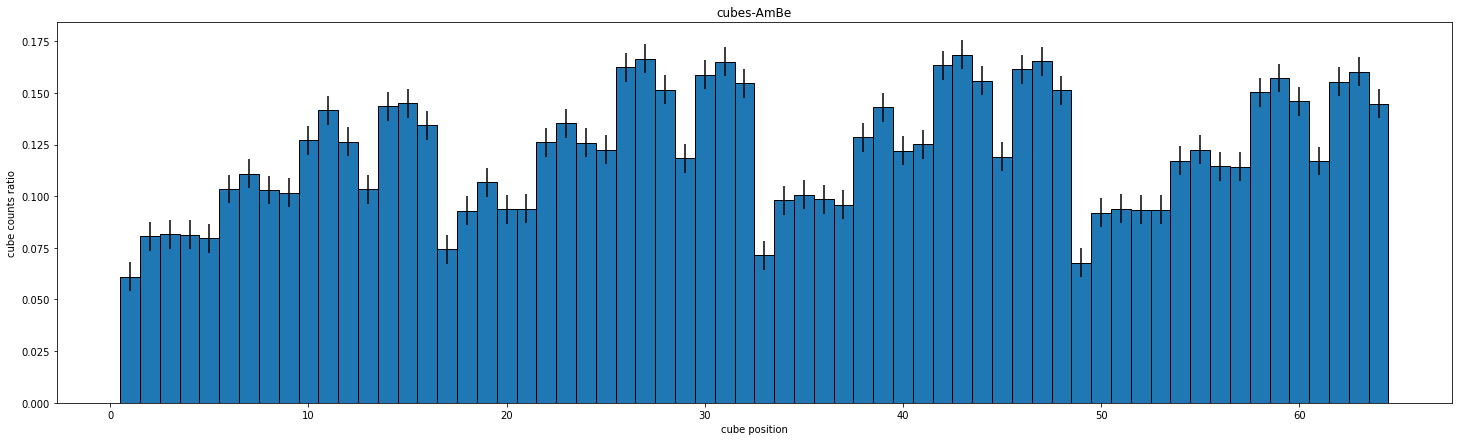

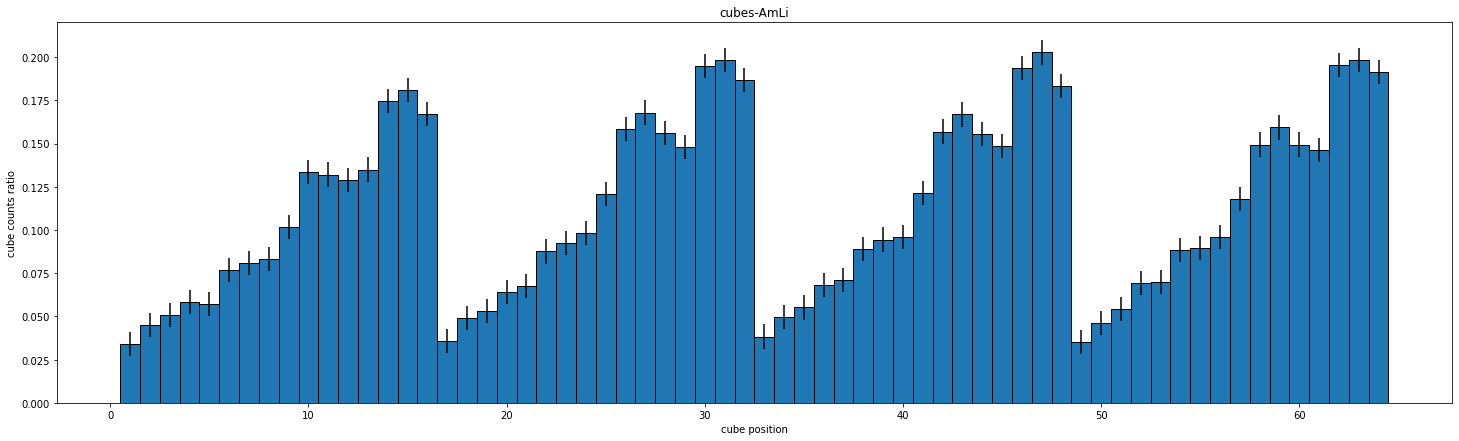

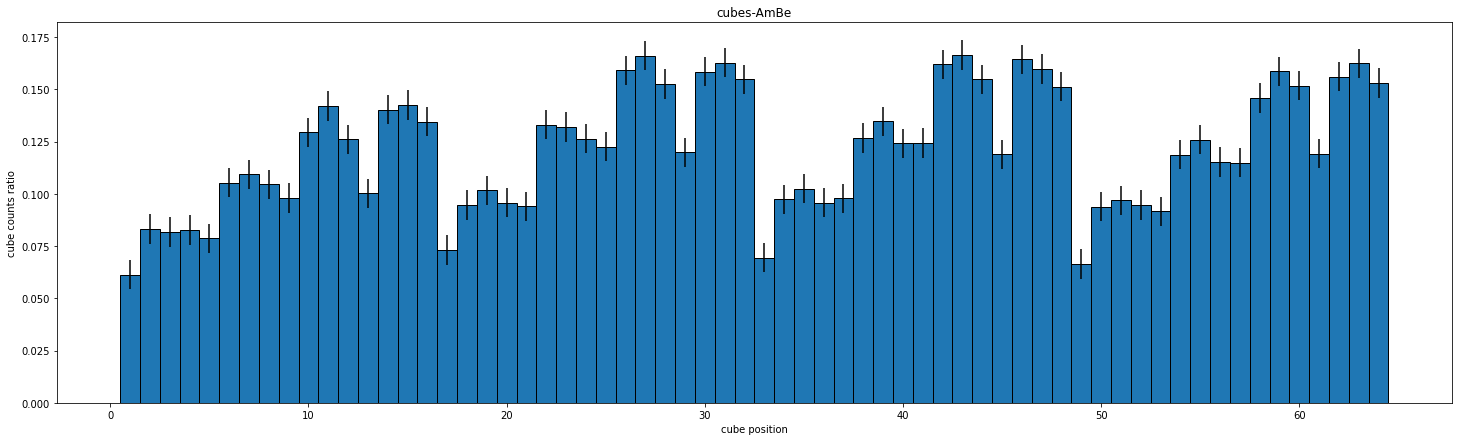

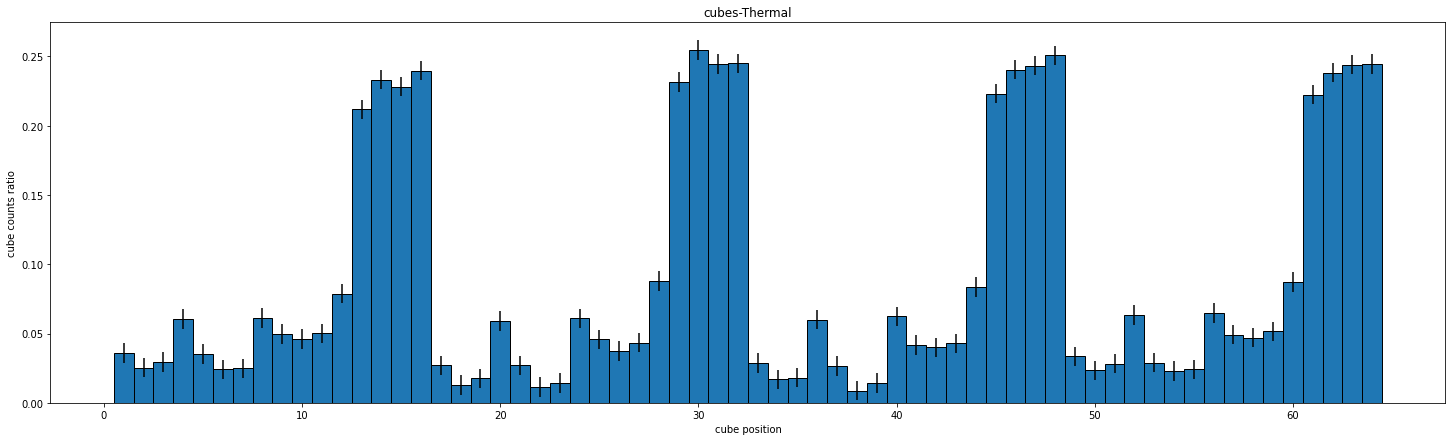

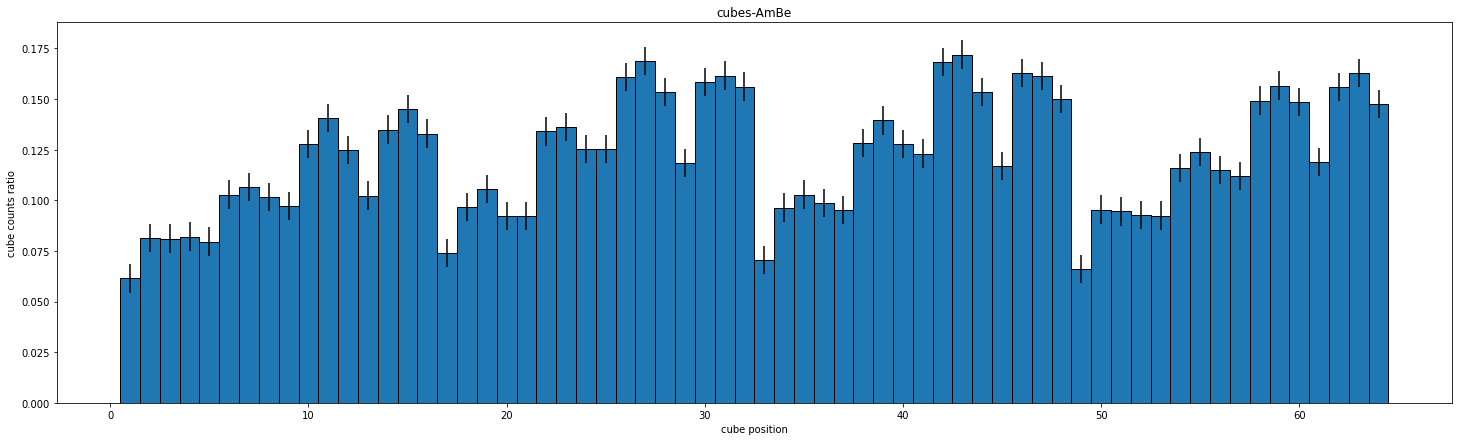

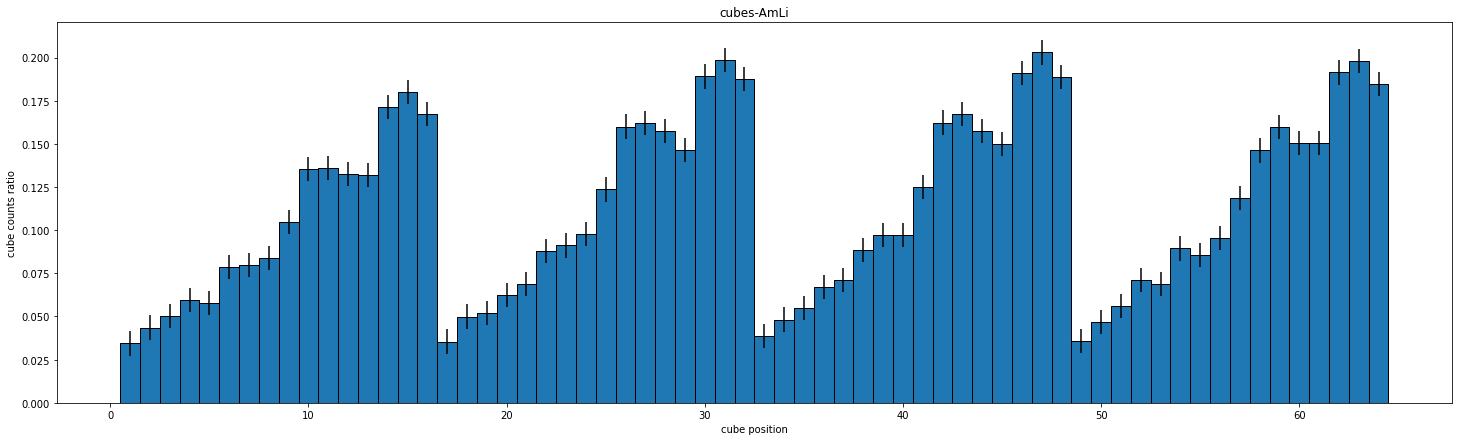

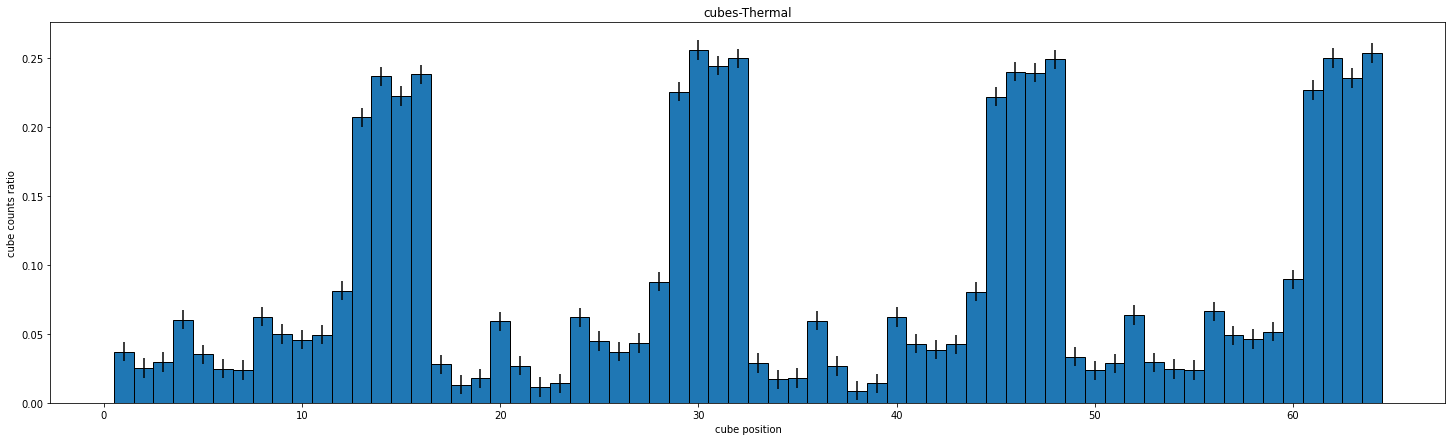

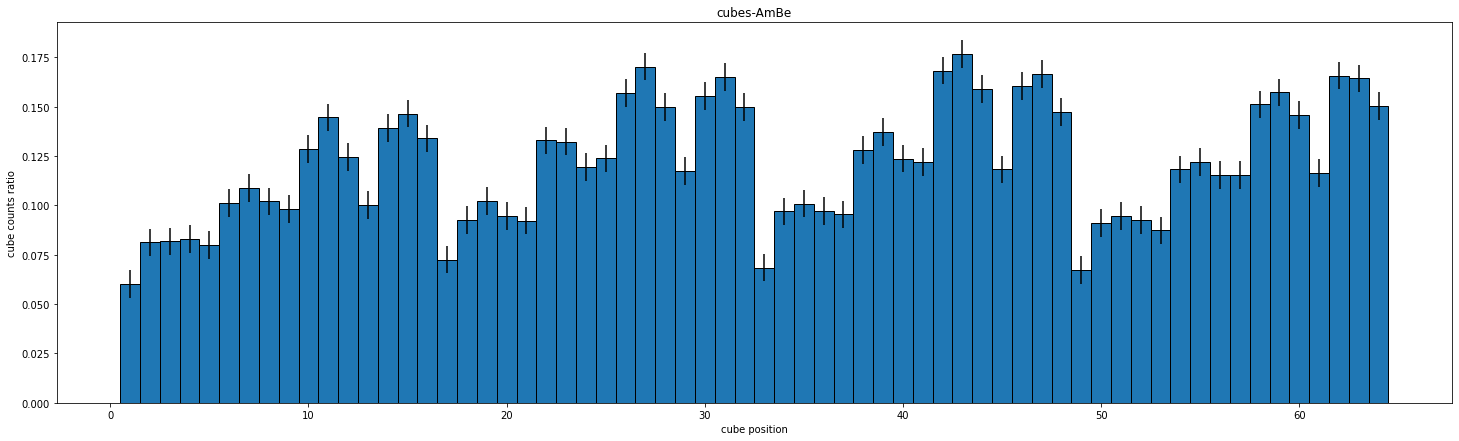

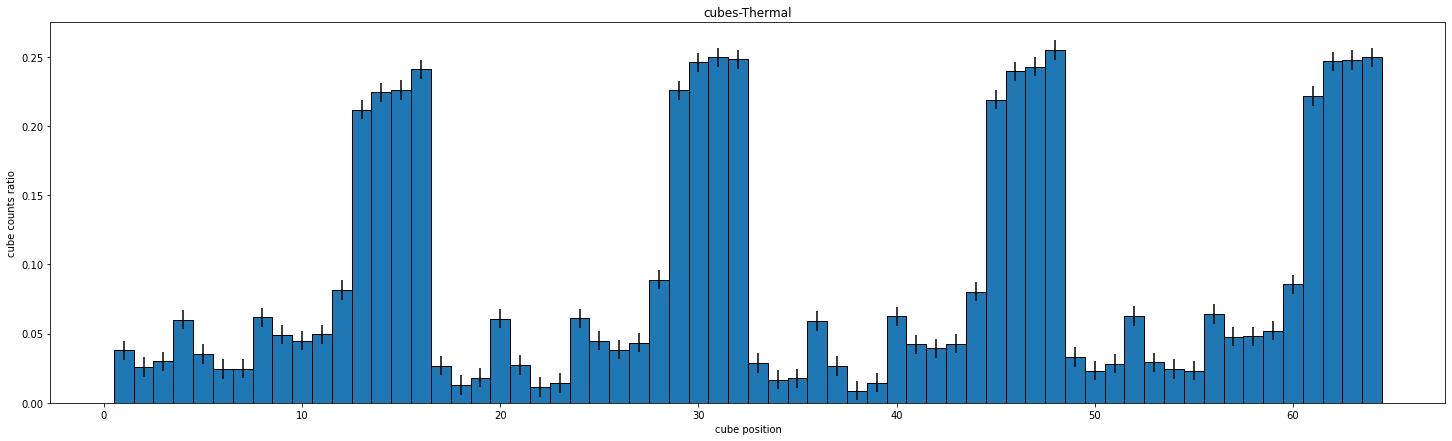

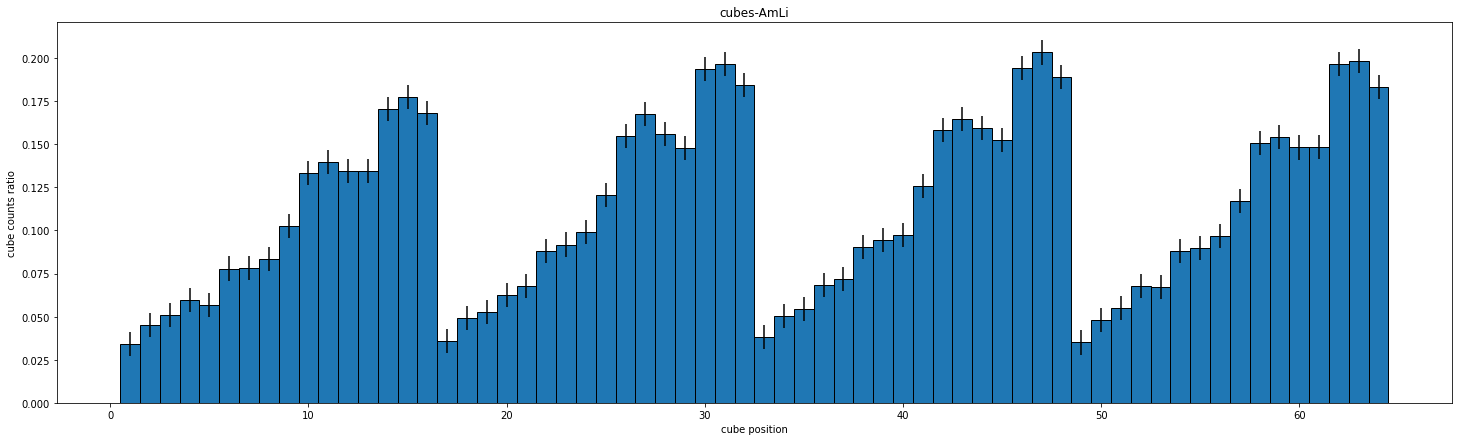

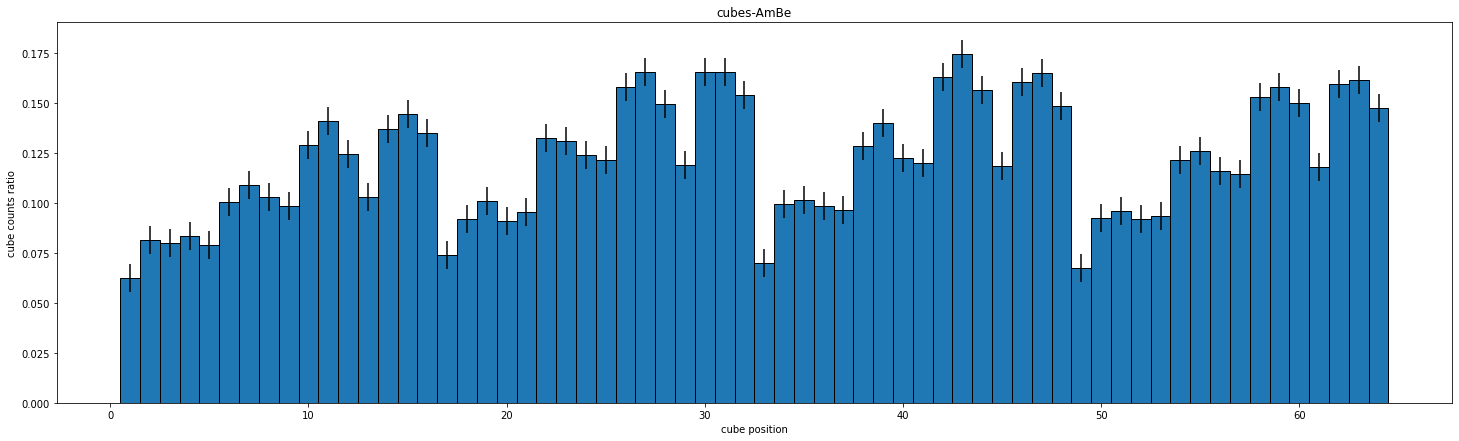

In [13]:
x_axis = list(range(1, 65))
# print(x_axis)


plt.rcParams['figure.figsize'] = (25, 7)
for i in range (128):
    event = events[i].flatten()
    event = event/sum(event)
    event = np.array(event).tolist()
    label = labels[i]
    title = category_list[label]
    plt.subplot(1, 1, 1)
    
    plt.bar(x_axis, np.sqrt(event), width=1, linewidth=1, yerr = 0.007, edgecolor='k')
    plt.xlabel('cube position')
    plt.ylabel('cube counts ratio')
    plt.title(title)
    plt.show()

In [14]:
# train_counts = []
# for counts, labels in train_loader:
#     train_counts.append(counts)
# train_counts = torch.cat(train_counts, dim=0)
# train_data_variance = torch.var(train_counts)

# print(train_data_variance)

In [15]:
class Encoder(nn.Module):
    """Encoder of VQ-VAE"""
    
    def __init__(self, in_dim=64, latent_dim=8):
        super().__init__()
        self.in_dim = in_dim
        self.latent_dim = latent_dim
        
        self.linears = nn.Sequential(
            nn.Linear(in_dim, 32, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(32, 16, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(16, latent_dim, bias=True)  
        )
        
    def forward(self, x):
        return self.linears(x)

In [16]:
# for idx, (x, y) in enumerate(train_loader):
#     model1 = Encoder().float()
#     output1 = model1(x.float())
#     print(output1.shape)

In [17]:
class Decoder(nn.Module):
    """Decoder of VQ-VAE"""
    
    def __init__(self, out_dim=64, latent_dim=8):
        super().__init__()
        self.out_dim = out_dim
        self.latent_dim = latent_dim
        
        self.linears = nn.Sequential(
            nn.Linear(latent_dim, 16, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(16, 32, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(32, out_dim, bias=True)
        )
        
    def forward(self, x):
        return self.linears(x)

In [18]:
class VectorQuantizer(nn.Module):
    """
    VQ-VAE layer: Input any tensor to be quantized. 
    Args:
        embedding_dim (int): the dimensionality of the tensors in the
          quantized space. Inputs to the modules must be in this format as well.
        num_embeddings (int): the number of vectors in the quantized space.
        commitment_cost (float): scalar which controls the weighting of the loss terms (see
          equation 4 in the paper - this variable is Beta).
    """
    def __init__(self, embedding_dim, num_embeddings, commitment_cost):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        # initialize embeddings
        self.embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        
    def forward(self, x):
        # [B, C, H, W] -> [B, H, W, C]
        x = x.permute(0, 2, 1).contiguous() # change the position of dimensions
        # [B, H, W, C] -> [BHW, C]
        flat_x = x.reshape(-1, self.embedding_dim)
        
        encoding_indices = self.get_code_indices(flat_x)
        quantized = self.quantize(encoding_indices)
        quantized = quantized.view_as(x) # [B, H, W, C]
        
        if not self.training:
            quantized = quantized.permute(0, 2, 1).contiguous() # [B, C, H, W]
            return quantized
        
        # embedding loss: move the embeddings towards the encoder's output
        embedding_loss = F.mse_loss(quantized, x.detach())
        # commitment loss
        e_latent_loss = F.mse_loss(x, quantized.detach())
        commitment_loss = self.commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = x + (quantized - x).detach()
        
        quantized = quantized.permute(0, 2, 1).contiguous()
        return encoding_indices, quantized, embedding_loss, commitment_loss
    
    def get_code_indices(self, flat_x):
        # compute L2 distance
        distances = (
            torch.sum(flat_x ** 2, dim=1, keepdim=True) +
            torch.sum(self.embeddings.weight ** 2, dim=1) - 
            2. * torch.matmul(flat_x, self.embeddings.weight.t())
        ) # [N, M]
        encoding_indices = torch.argmin(distances, dim=1) # [N,]
        return encoding_indices
    
    def quantize(self, encoding_indices):
        """Returns embedding tensor for a batch of indices."""
        return self.embeddings(encoding_indices)      

In [19]:
# for idx, (x, y) in enumerate(train_loader):
#     model1 = Encoder().float()
#     output1 = model1(x.float())
#     print(output1.shape)
#     model2 =  VectorQuantizer(embedding_dim, num_embeddings, commitment_cost=0.25).float()
#     encoding_indices, quantized, embedding_loss, commitment_loss = model2(output1)
#     print(encoding_indices.shape)
#     print(quantized.shape)
#     model3 = Decoder().float()
#     output3 = model3(quantized)
#     print(output3.shape)

In [20]:
train_data_variance = torch.tensor(1082476.9326, dtype=torch.float64)


In [21]:
class VQVAE(nn.Module):
    """VQ-VAE"""
    
    def __init__(self, in_dim, latent_dim, embedding_dim, num_embeddings, data_variance,
                 commitment_cost=0.25):
        super().__init__()
        self.in_dim = in_dim
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.data_variance = data_variance
        
        self.encoder = Encoder(in_dim, latent_dim)
        self.vq_layer = VectorQuantizer(embedding_dim, num_embeddings, commitment_cost)
        self.decoder = Decoder(in_dim, latent_dim)
        
    def forward(self, x):
        z = self.encoder(x)
        if not self.training:
            e = self.vq_layer(z)
            x_recon = self.decoder(e)
            return e, x_recon
        
        index, e, embedding_loss, commitment_loss = self.vq_layer(z)
        x_recon = self.decoder(e)
        
        recon_loss = F.mse_loss(x_recon, x)/ self.data_variance
        
        return index, e, embedding_loss, commitment_loss, x_recon, recon_loss 

In [22]:
# print(train_data_variance)

In [23]:
model = VQVAE(in_dim, latent_dim, embedding_dim, num_embeddings, train_data_variance)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [24]:
# writer.add_graph(model.cuda(), events.cuda().float())
# writer.close()

In [25]:
# # train VQ-VAE

# epochs = 25

# print("Start training VQ-VAE...\n")

# recon_loss_list = []
# embedding_loss_list = []
# commitment_loss_list = []
# loss_list = []


# for epoch in range(epochs):
    
#     model.train()

#     for i, (counts, labels) in enumerate(train_loader):
        
#         counts = counts.cuda().float()
        
#         optimizer.zero_grad()
            
#         index, e, embedding_loss, commitment_loss, x_recon, recon_loss = model(counts)
#         loss = embedding_loss + commitment_loss + recon_loss
        
#         loss.backward()
#         optimizer.step()
        
#         recon_loss_list.append(recon_loss.item())
#         embedding_loss_list.append(embedding_loss.item())
#         commitment_loss_list.append(commitment_loss.item())
#         loss_list.append(loss.item())
        
#         writer.add_scalar('recon_loss/train', float(recon_loss), len(train_loader)*epoch+i)
#         writer.add_scalar('embedding_loss/train', float(embedding_loss), len(train_loader)*epoch+i)
#         writer.add_scalar('commitment_loss/train', float(commitment_loss), len(train_loader)*epoch+i)
#         writer.add_scalar('all_loss/train', float(loss), len(train_loader)*epoch+i)
        
#         if (i + 1) % print_freq == 0 or (i + 1) == len(train_loader):
#              print("epoch:", epoch + 1, "  step:", i + 1, "   recon_loss:", recon_loss.item(), 
#               "\n\t\t\tcommit_loss: ", commitment_loss.item(), 
#               "\n\t\t\tembedding loss: ", embedding_loss.item(), 
#               "\n\t\t\ttotal_loss: ", loss.item())


# print("Finish!!")



In [26]:
# torch.save(model, './model_nFacet.pth')
# torch.save(optimizer, './optimizer_nFacet_8.pth')


In [27]:
model = torch.load('./model_nFacet.pth')
optimizer = torch.load('./optimizer_nFacet.pth')


# Generate New Data

In [28]:
test_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)

# Reconstructing data

In [29]:
dataiter = iter(test_loader)
events, labels = dataiter.next()

# plt.rcParams['figure.figsize'] = (5, 5)
# for i in range (128):
#     event = np.array(events[i].reshape(64)).tolist()
#     label = labels[i]
#     title = category_list[label]
#     plt.subplot(1, 1, 1)
#     plt.plot(event)
#     plt.title(title)
#     plt.show()

In [30]:
# output = model.encoder(events)
# print(output.shape)

In [31]:
events = events.cuda().float()

with torch.inference_mode():
    z = model.encoder(events)
    index, e, embedding_loss, commitment_loss = model.vq_layer(z)
    x_recon = model.decoder(e)
#     print(x_recon.shape)

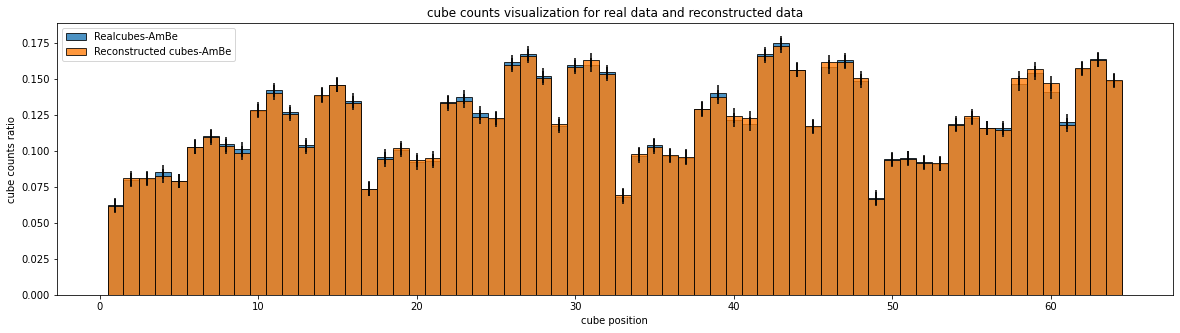

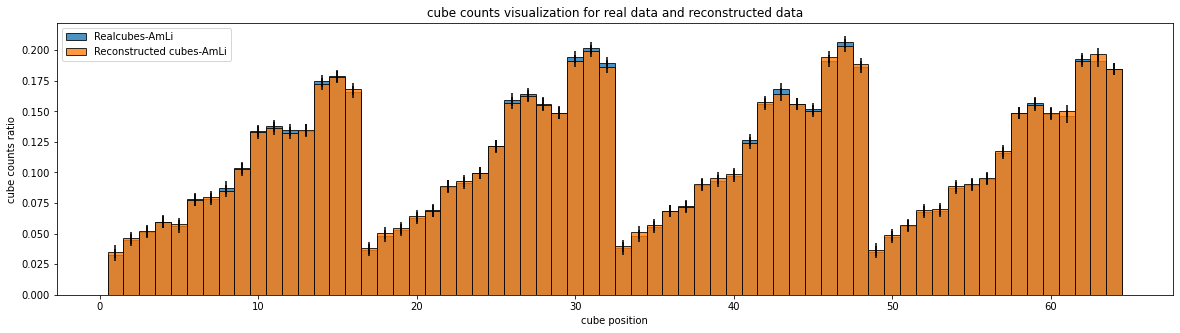

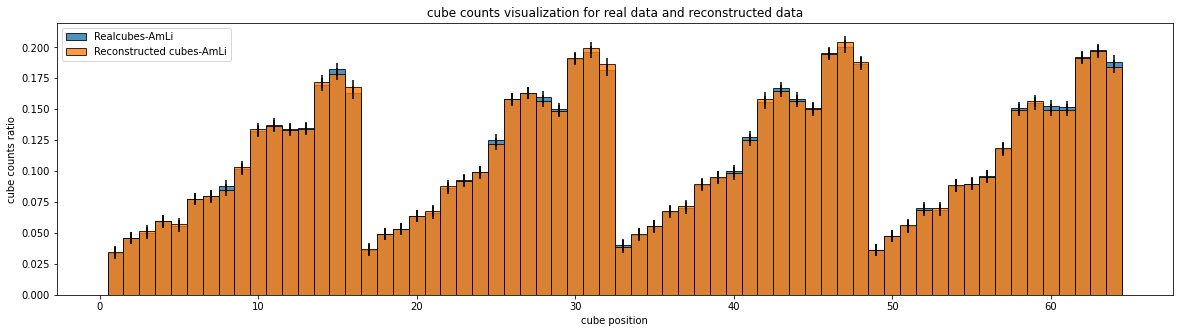

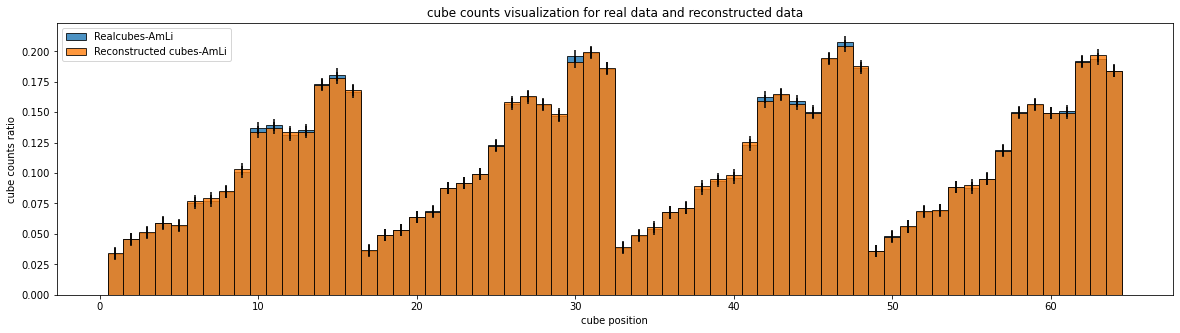

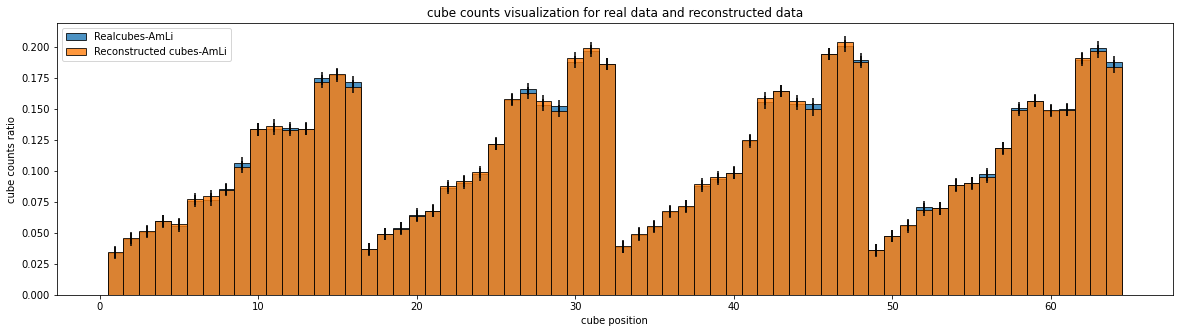

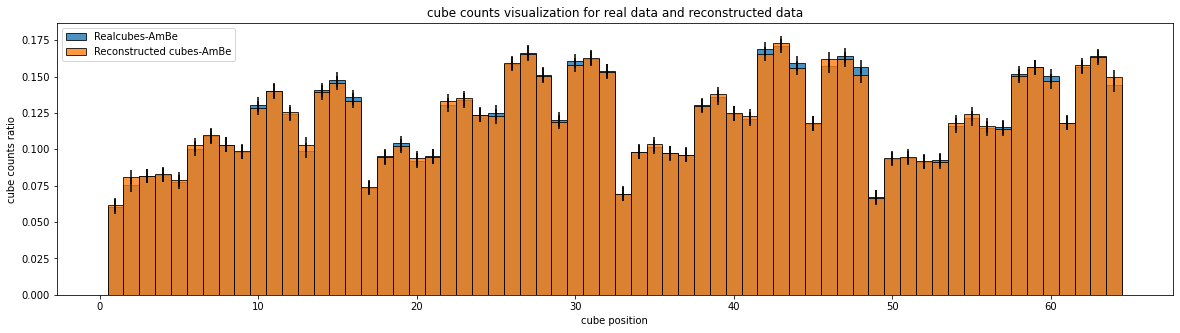

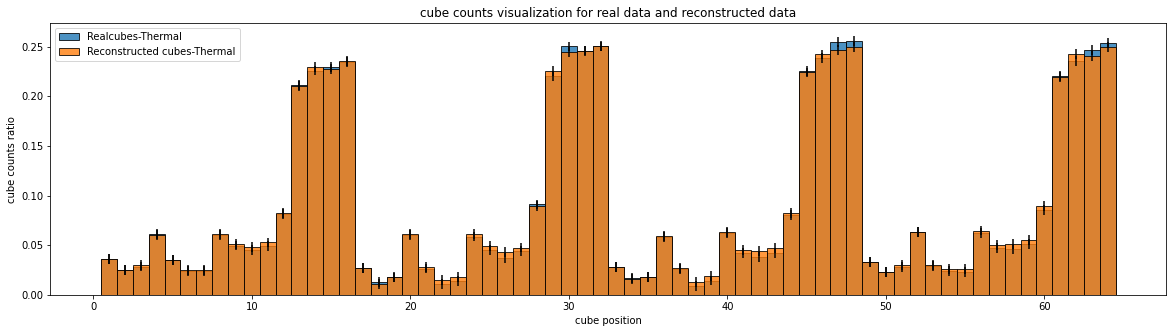

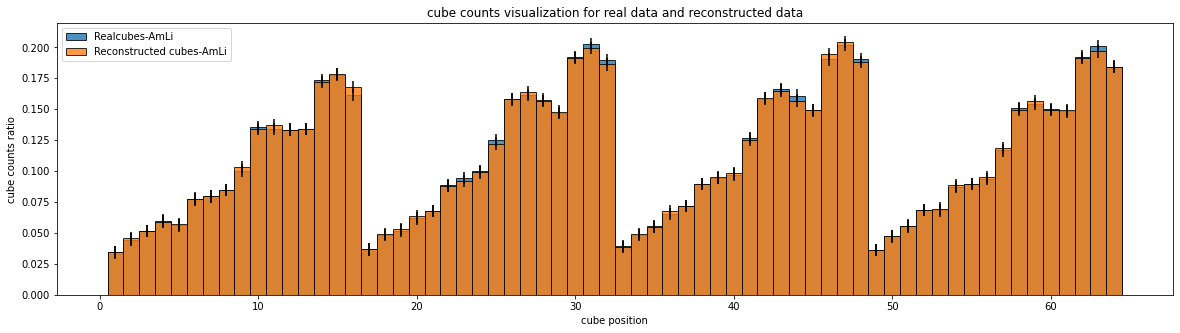

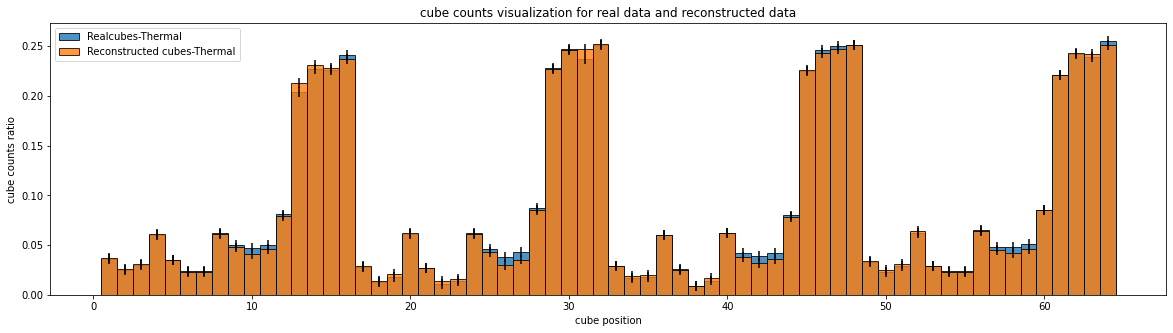

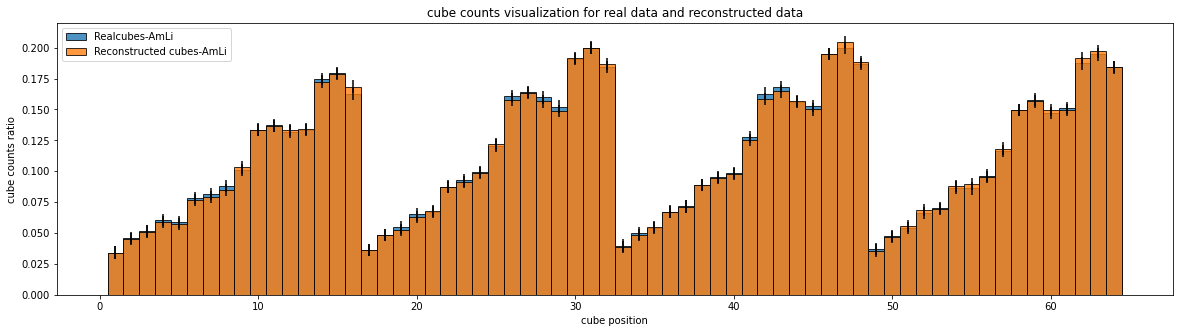

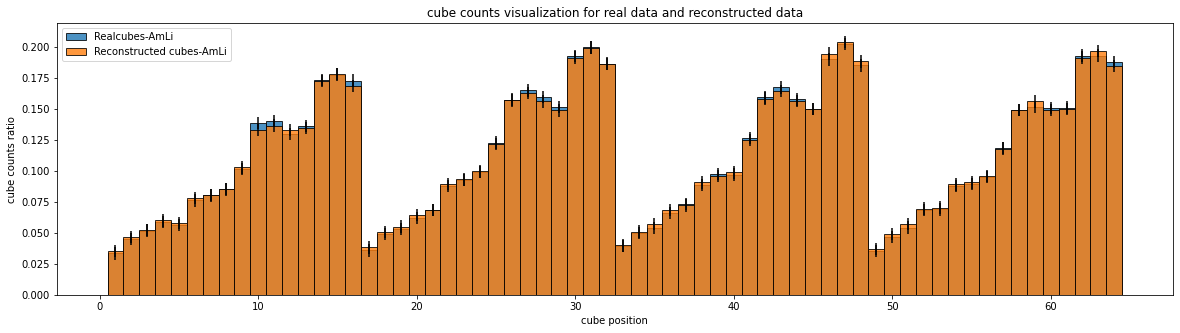

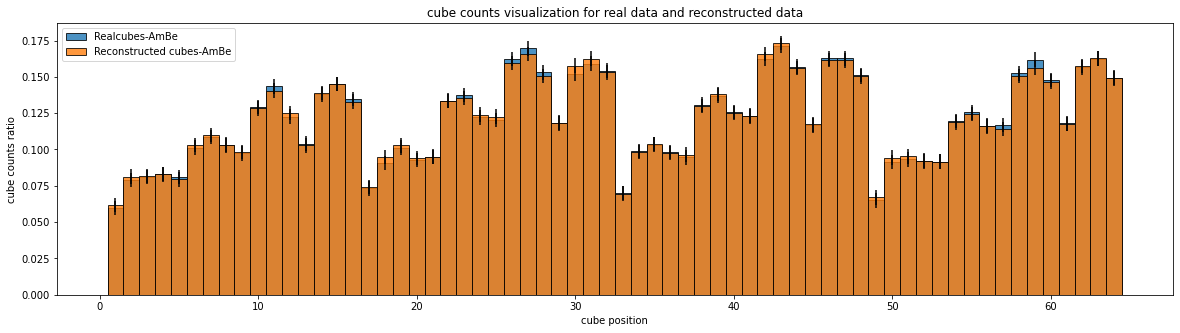

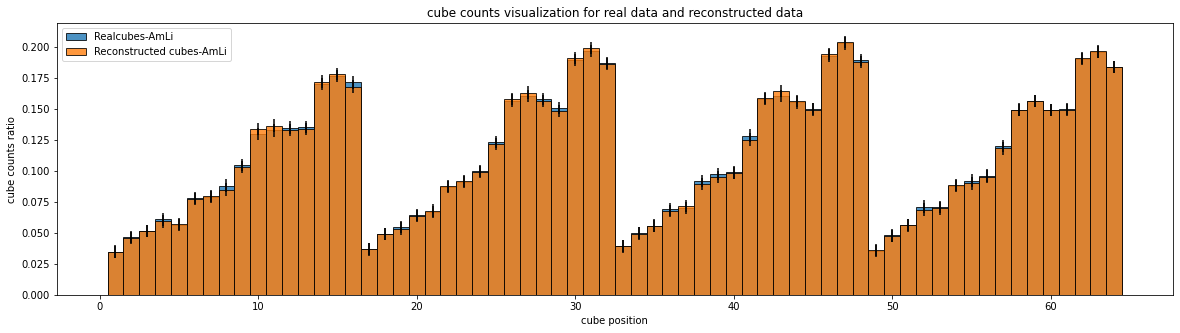

/tmp/ipykernel_1086/243123559.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x_axis, np.sqrt(recon_event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label = "Reconstructed " + title, alpha=0.8)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


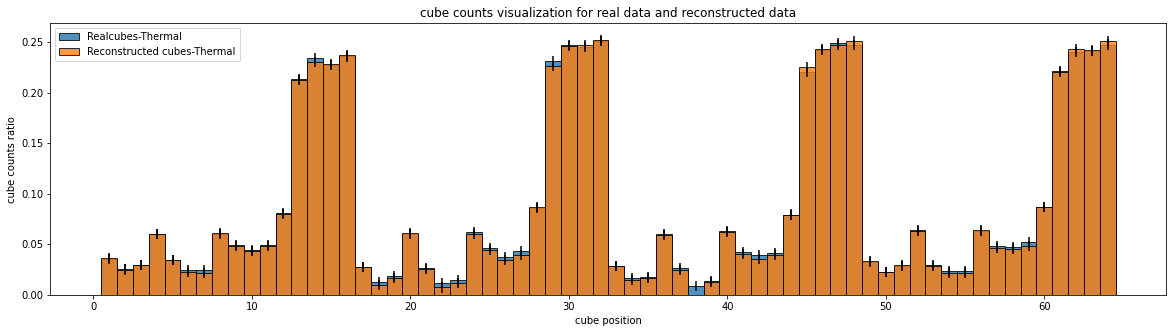

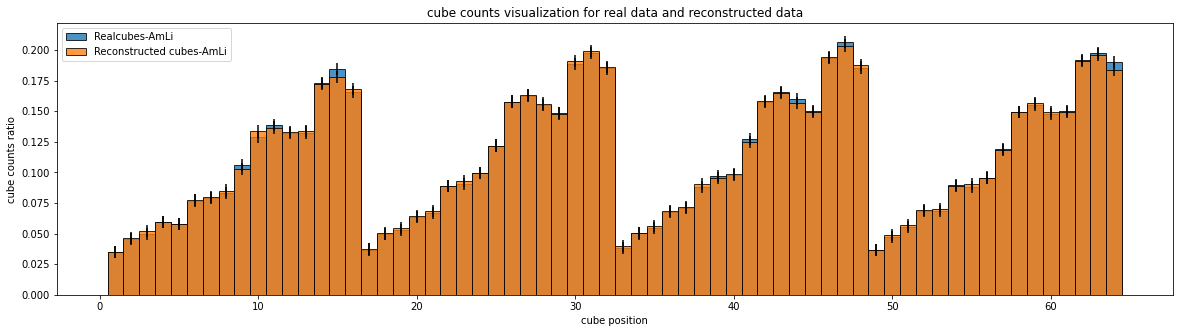

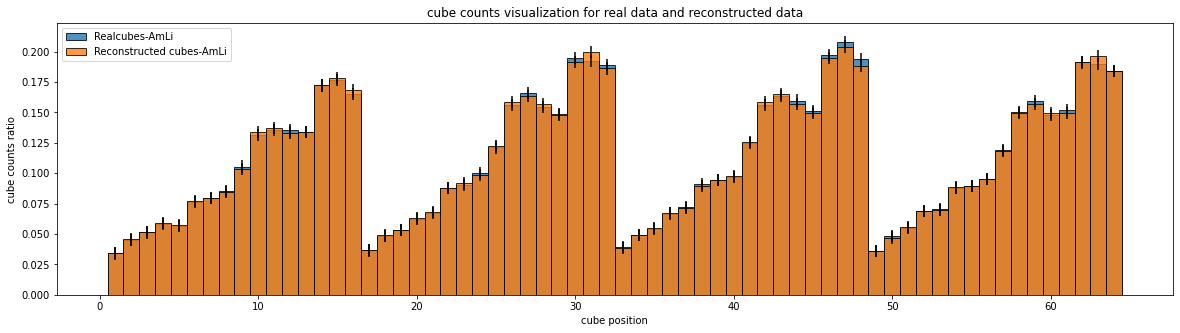

/tmp/ipykernel_1086/243123559.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x_axis, np.sqrt(recon_event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label = "Reconstructed " + title, alpha=0.8)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


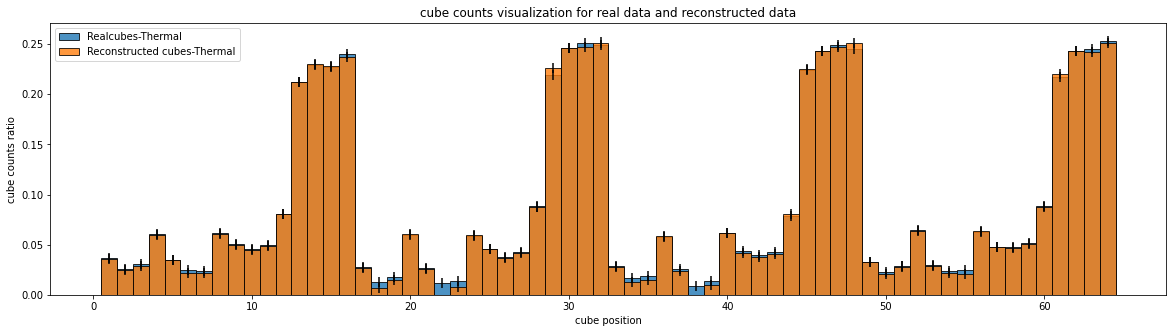

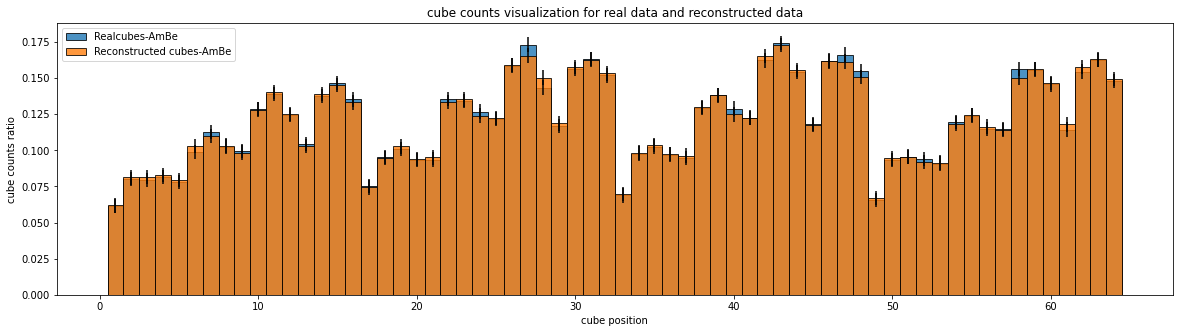

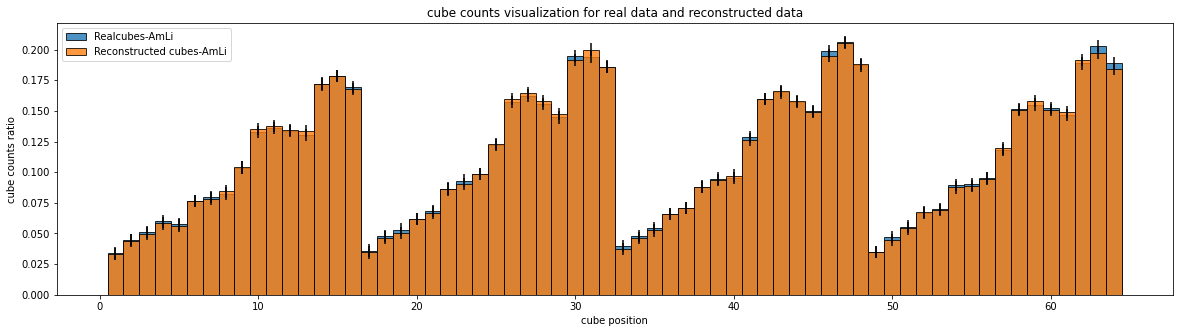

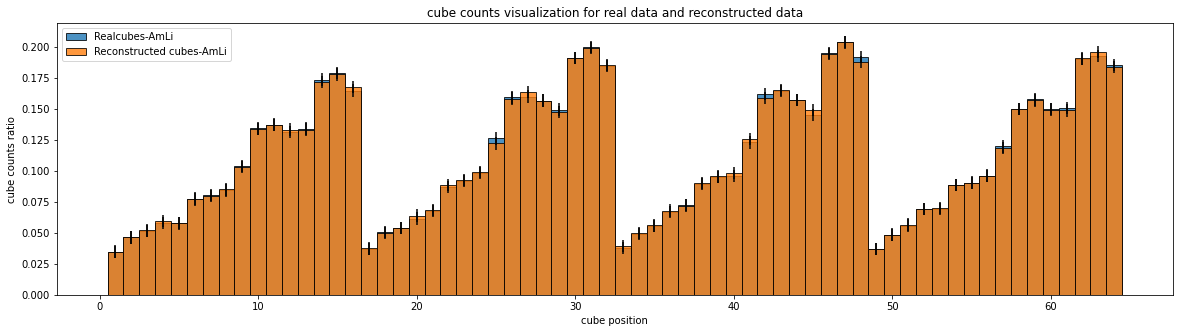

/tmp/ipykernel_1086/243123559.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x_axis, np.sqrt(recon_event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label = "Reconstructed " + title, alpha=0.8)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


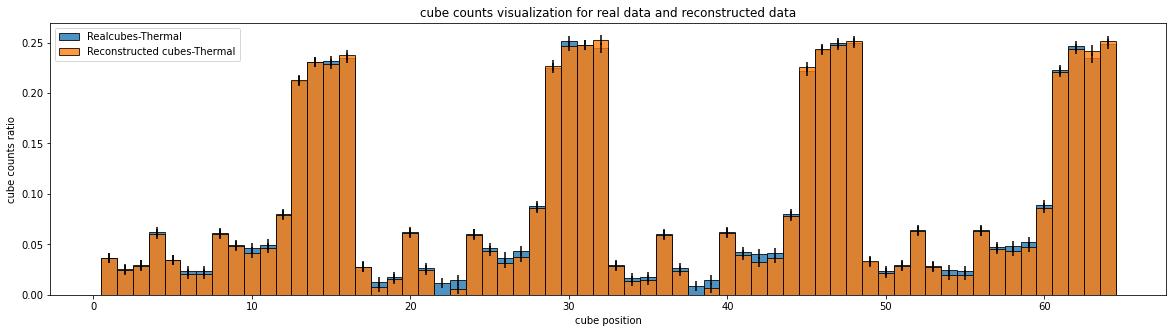

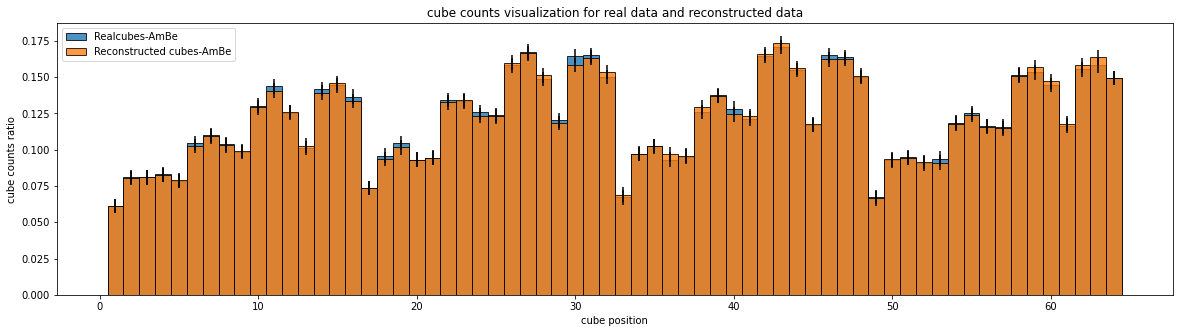

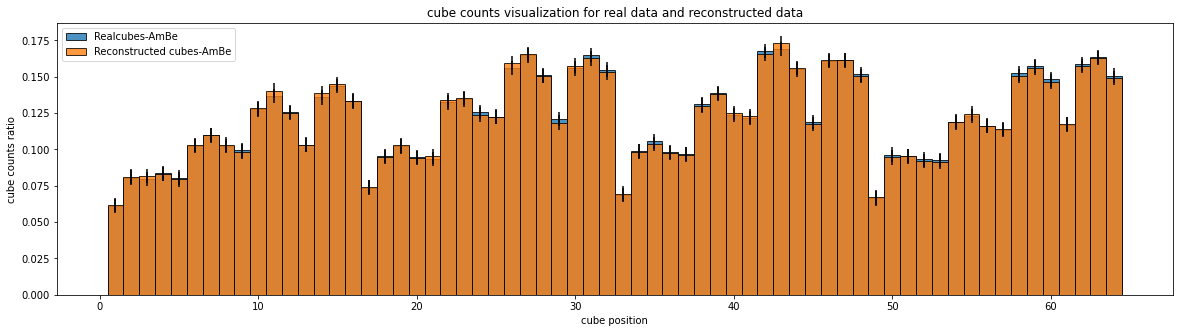

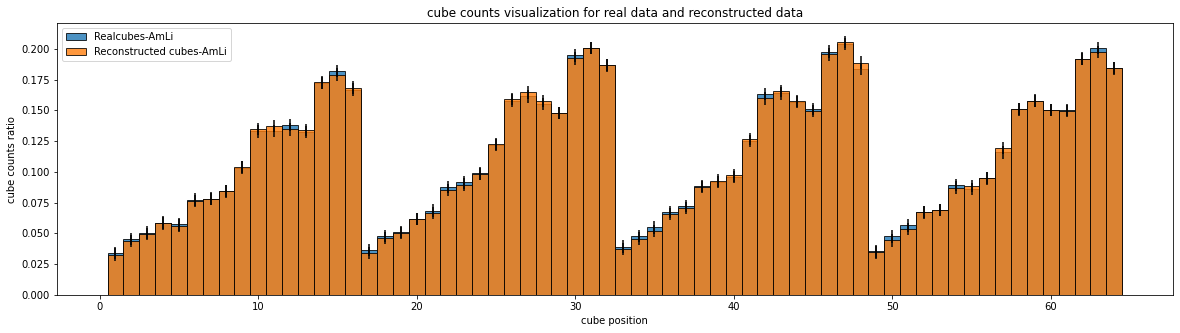

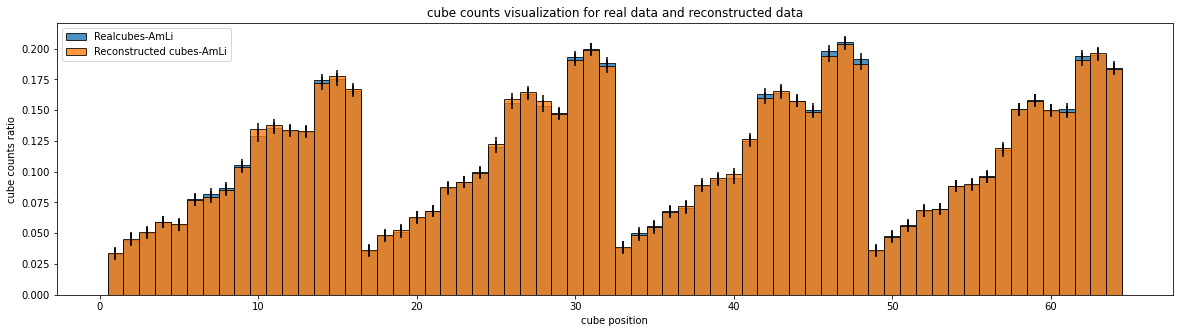

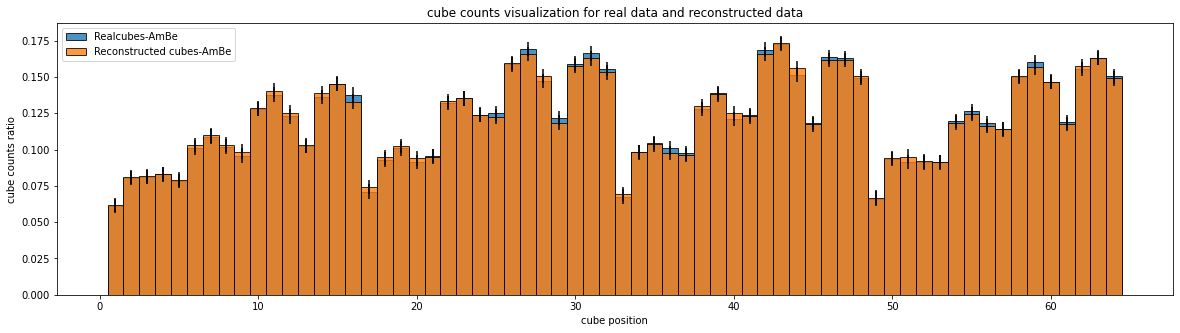

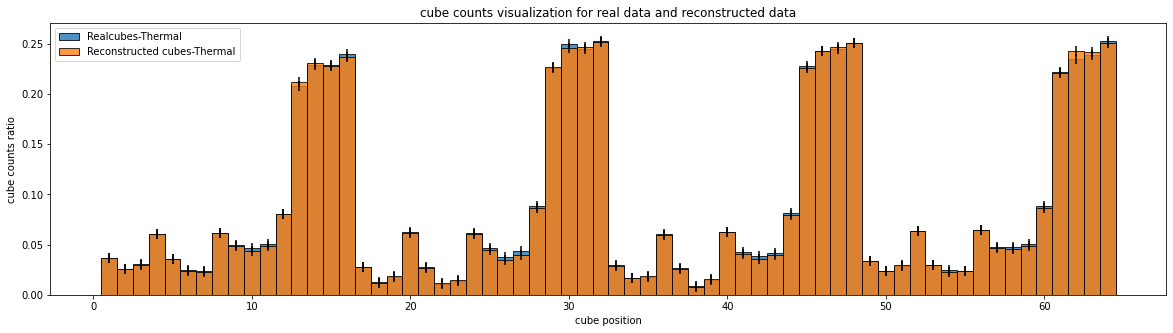

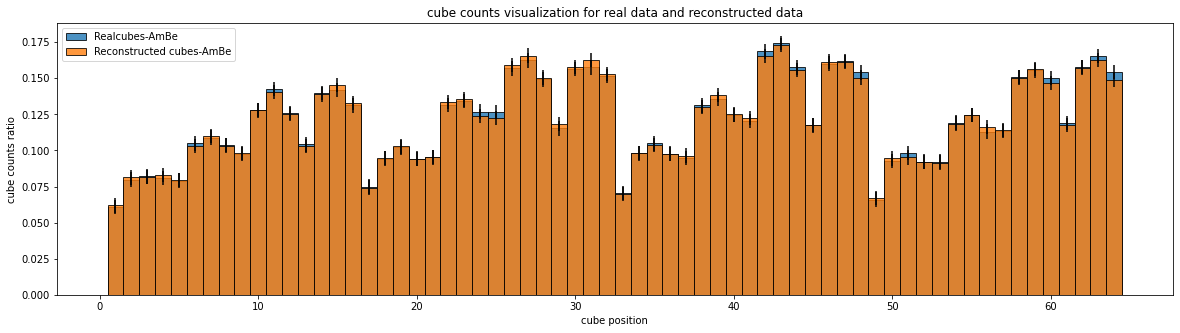

/tmp/ipykernel_1086/243123559.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x_axis, np.sqrt(recon_event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label = "Reconstructed " + title, alpha=0.8)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


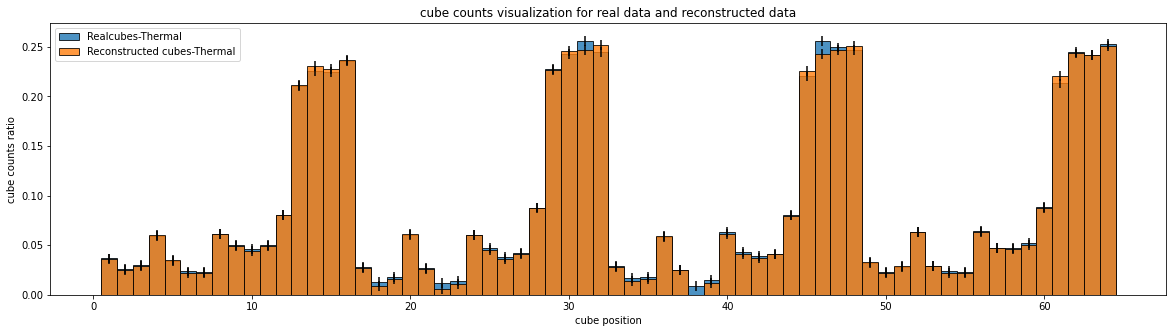

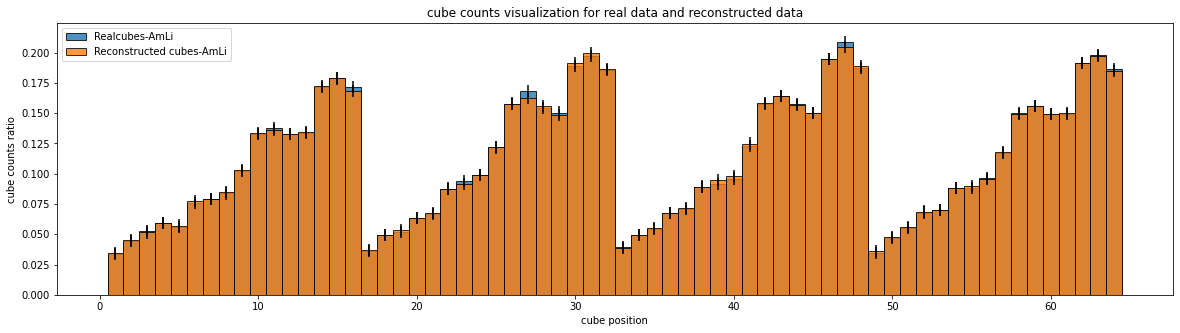

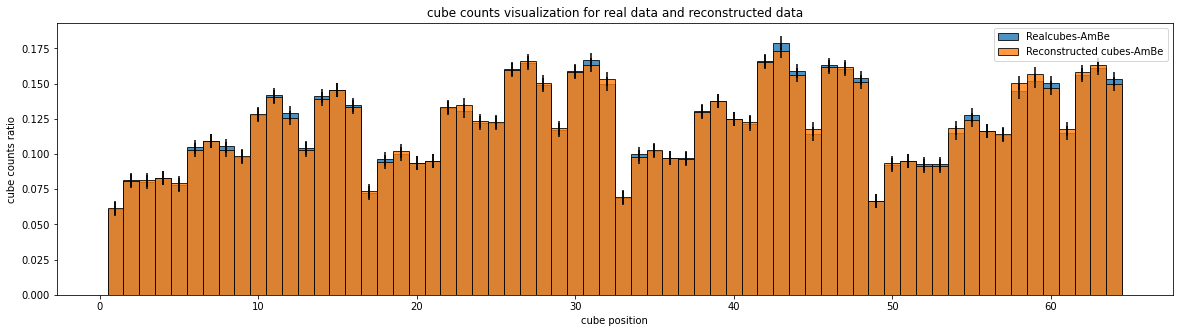

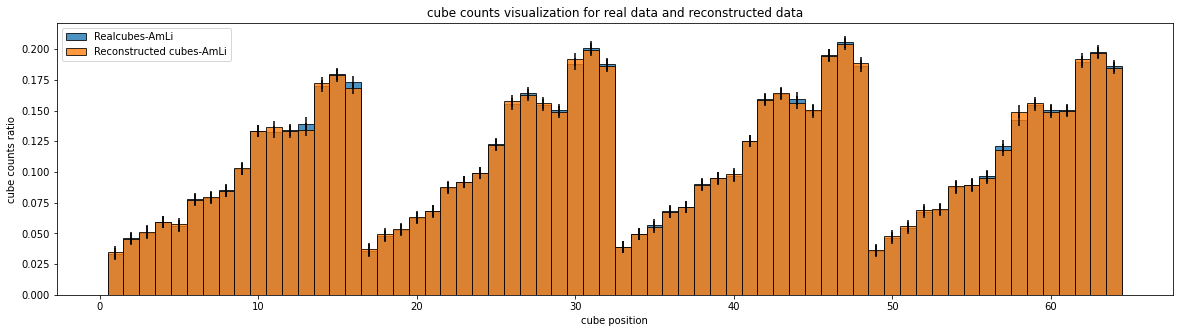

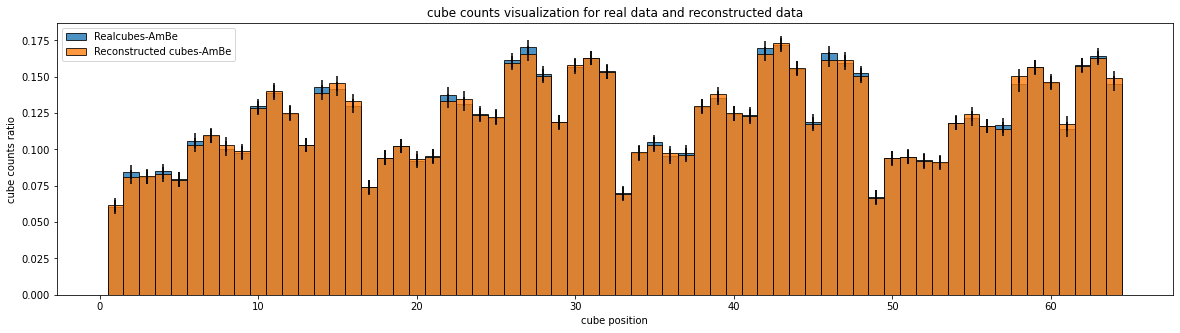

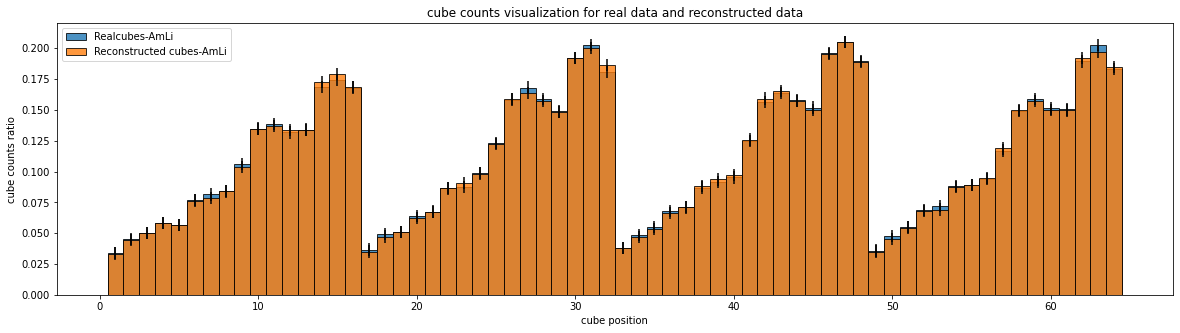

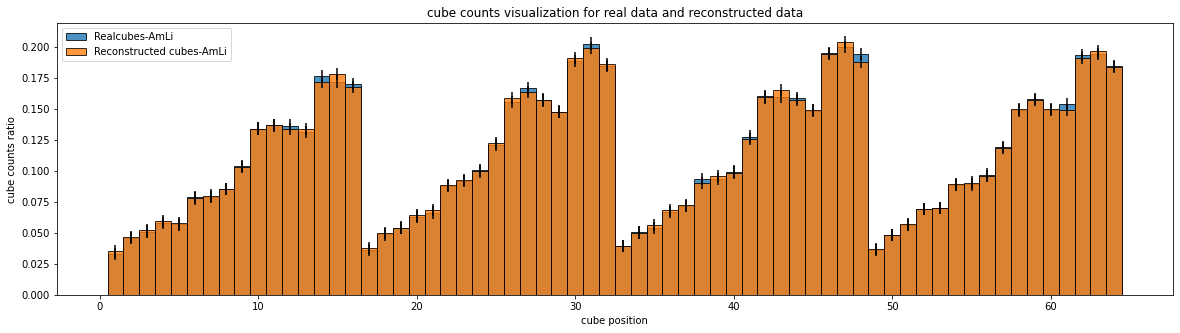

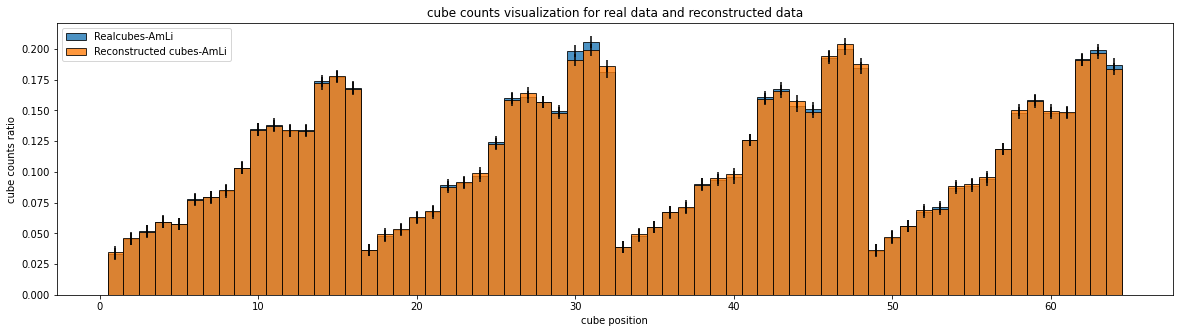

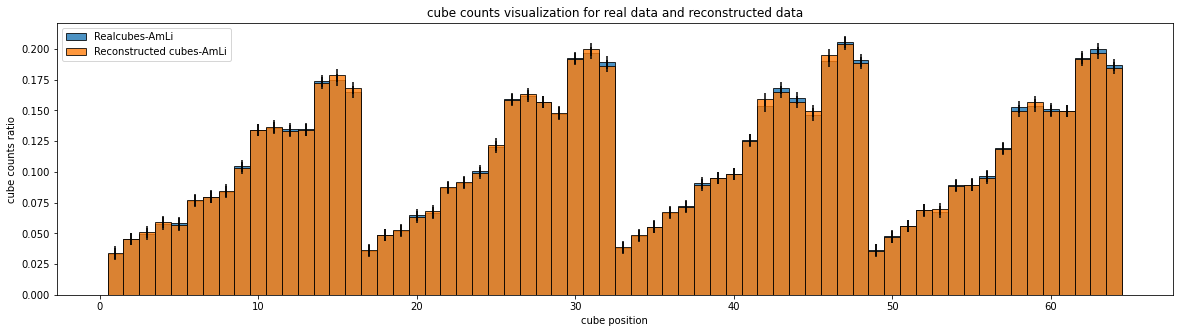

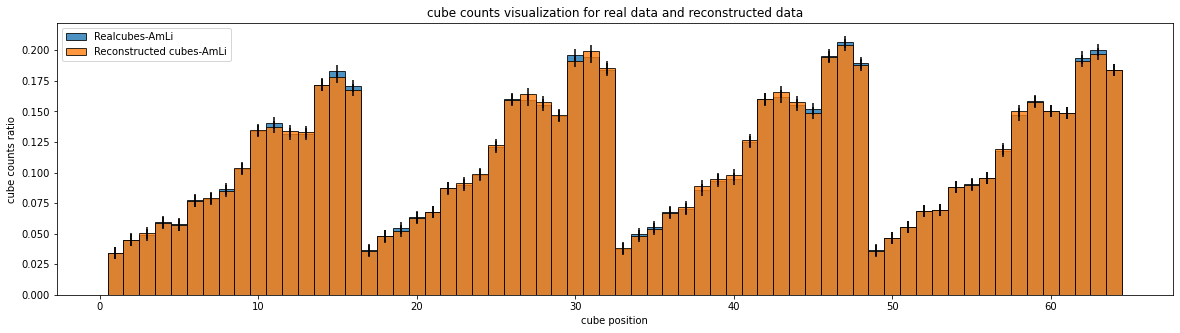

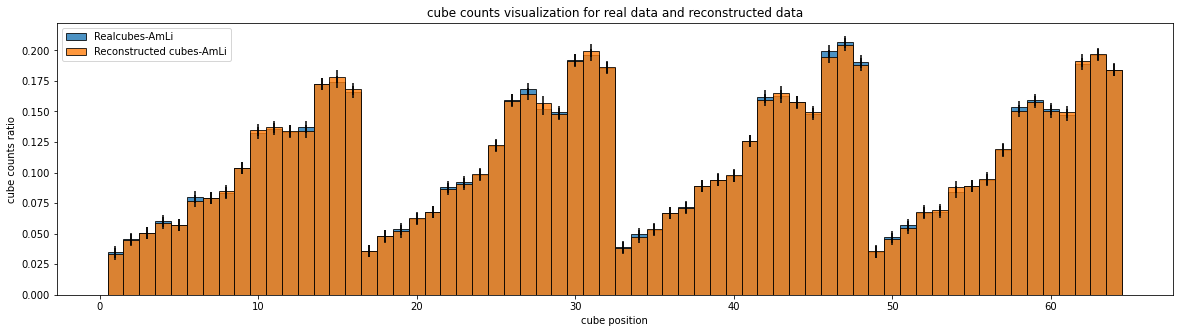

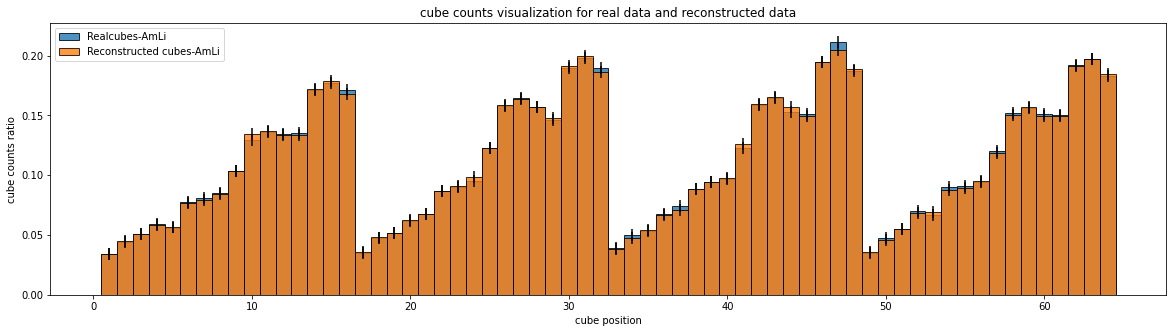

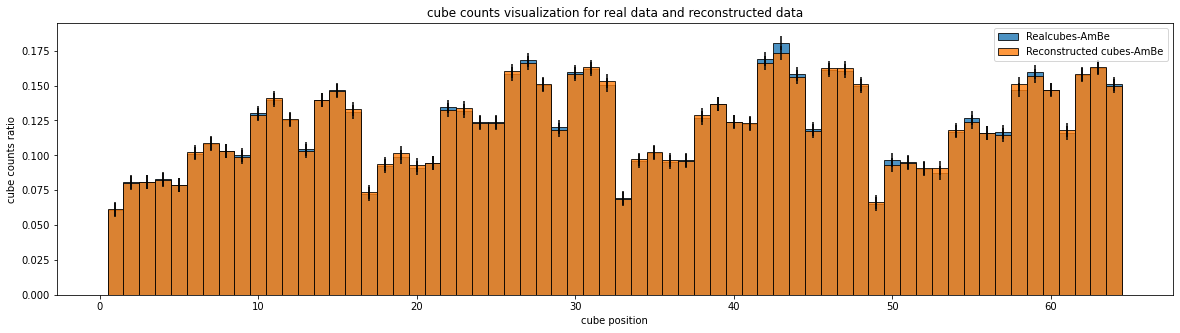

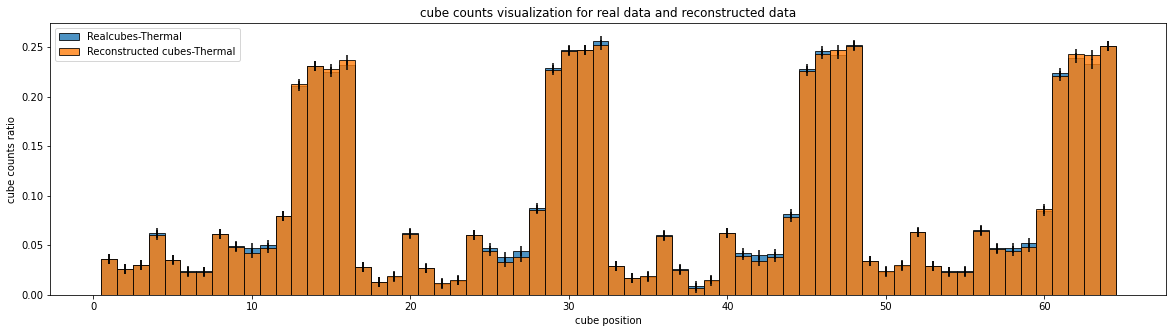

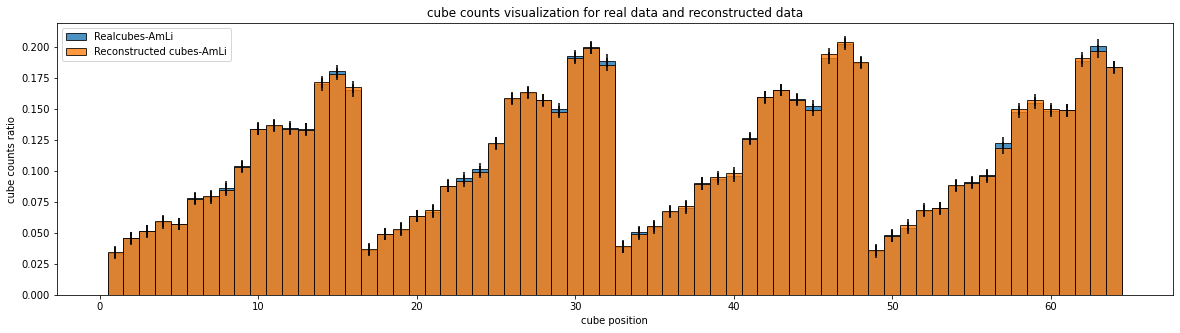

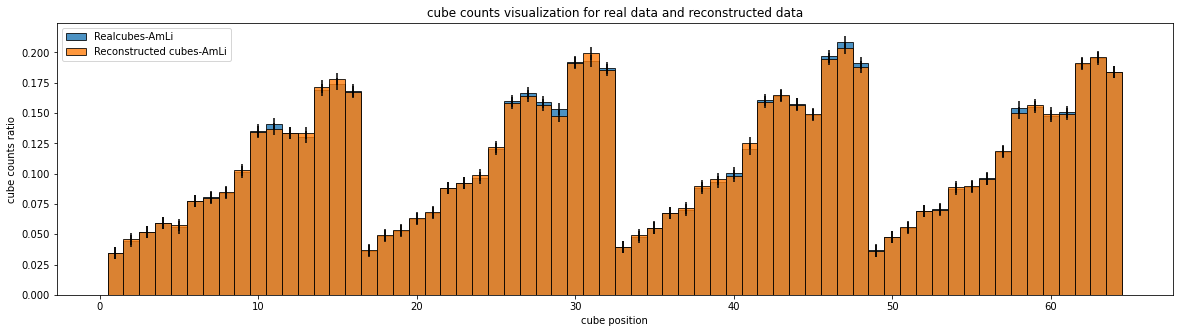

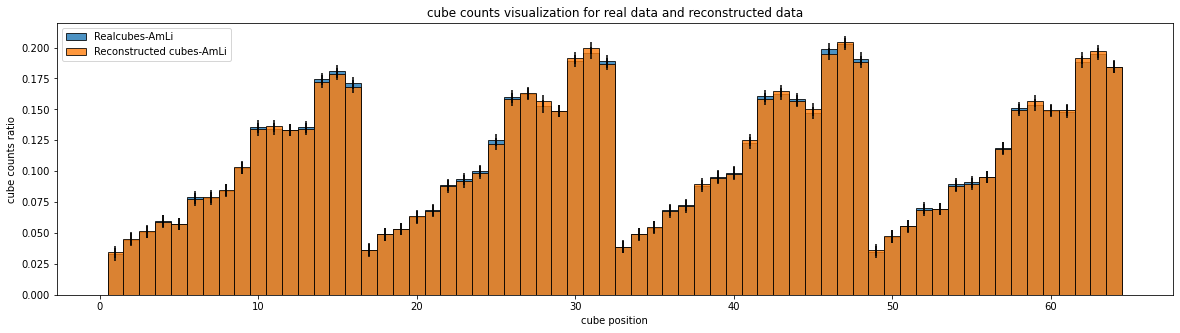

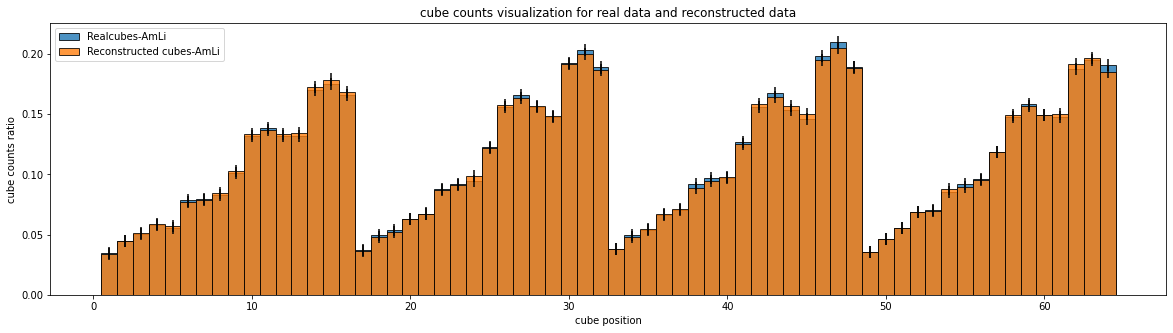

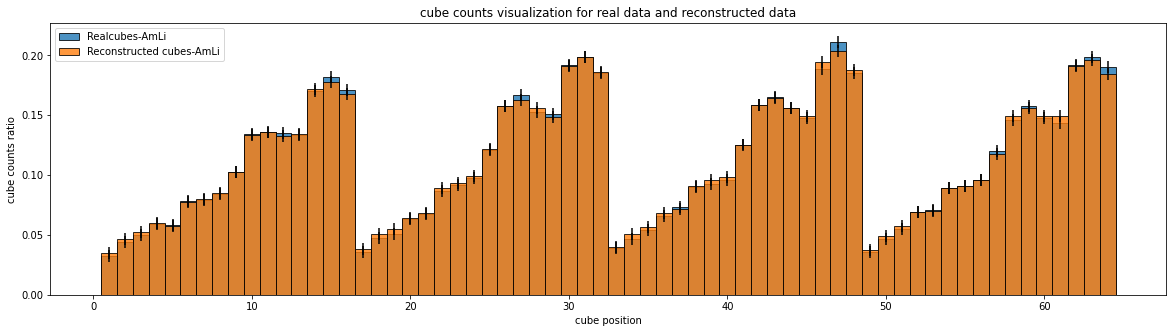

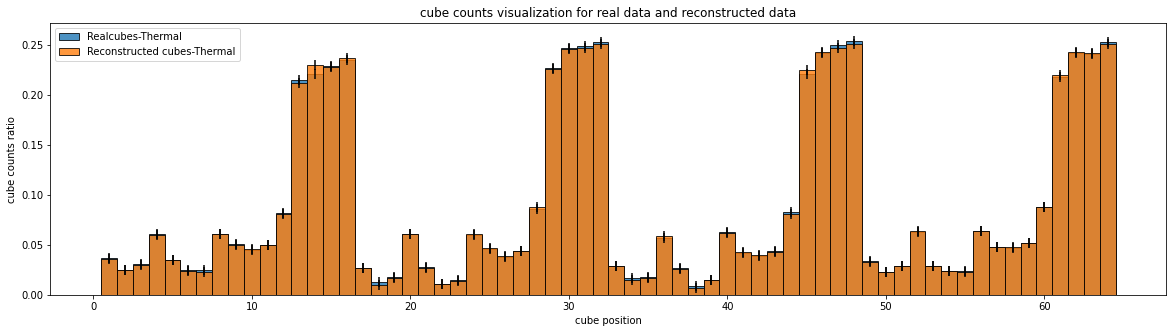

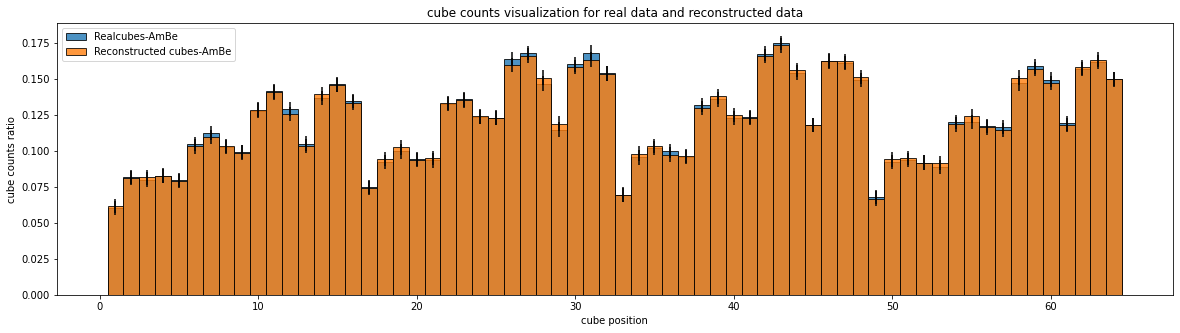

/tmp/ipykernel_1086/243123559.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x_axis, np.sqrt(recon_event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label = "Reconstructed " + title, alpha=0.8)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


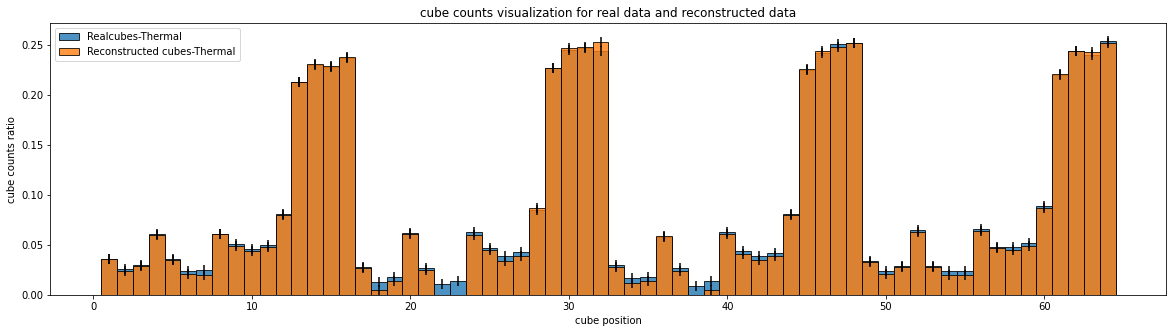

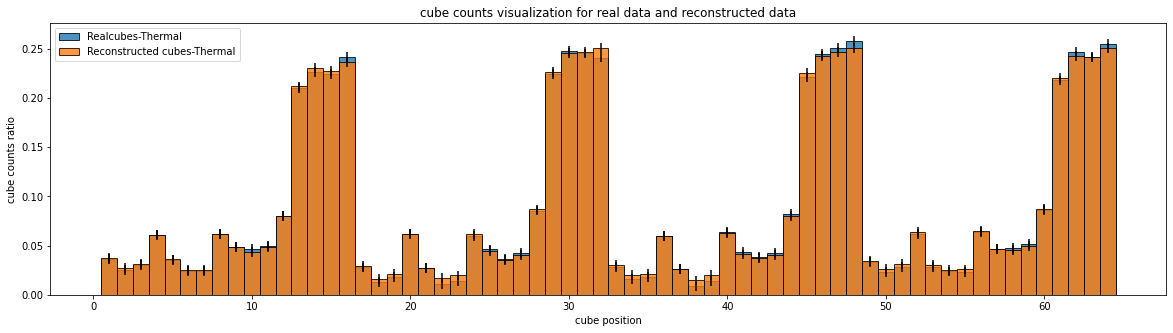

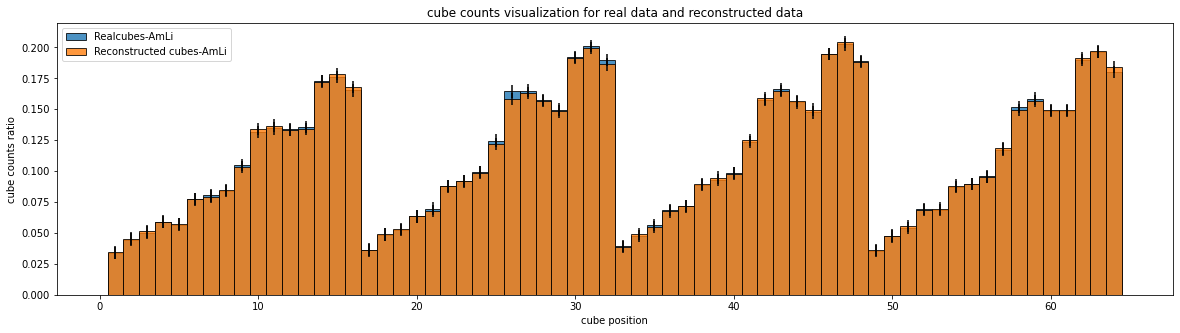

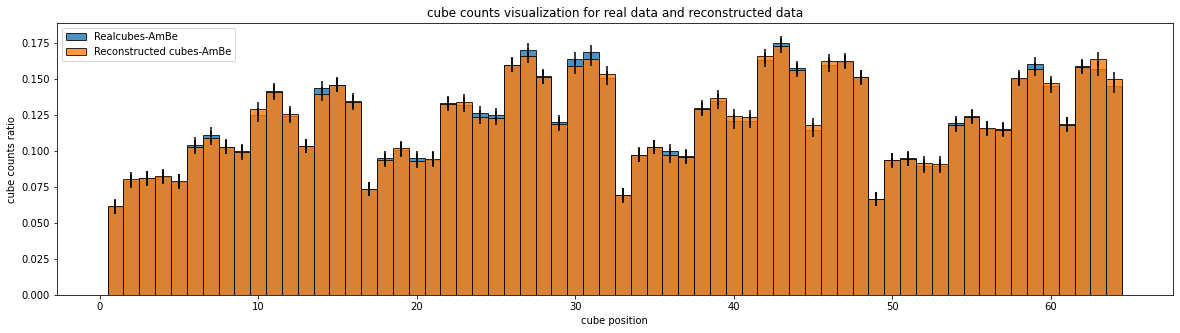

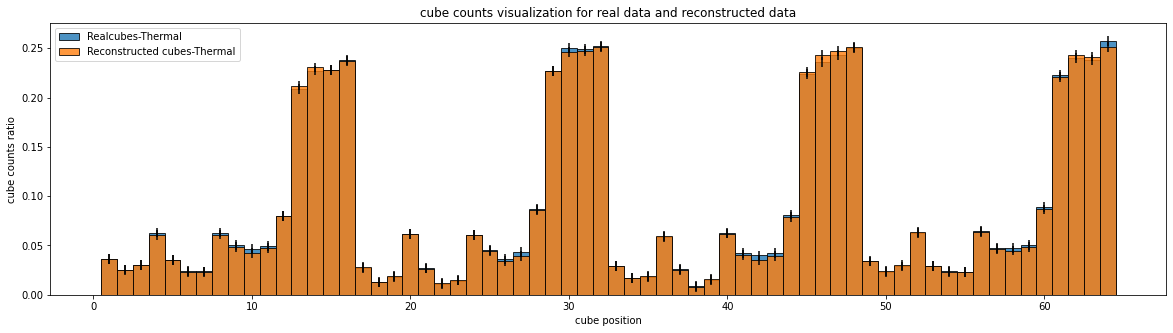

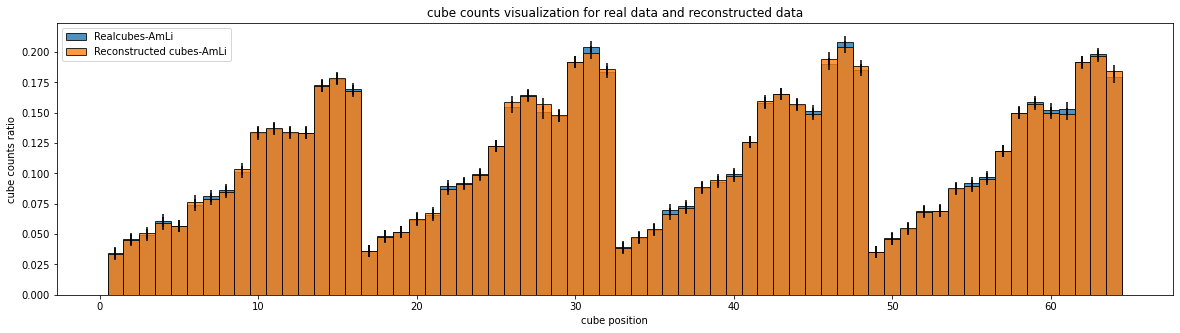

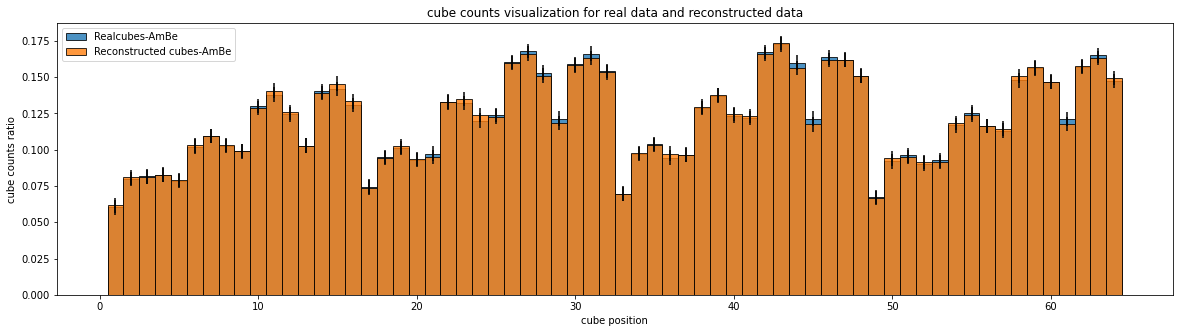

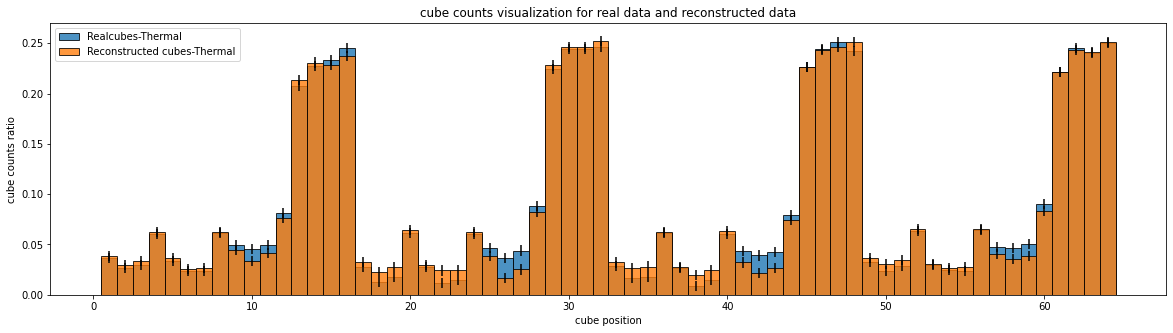

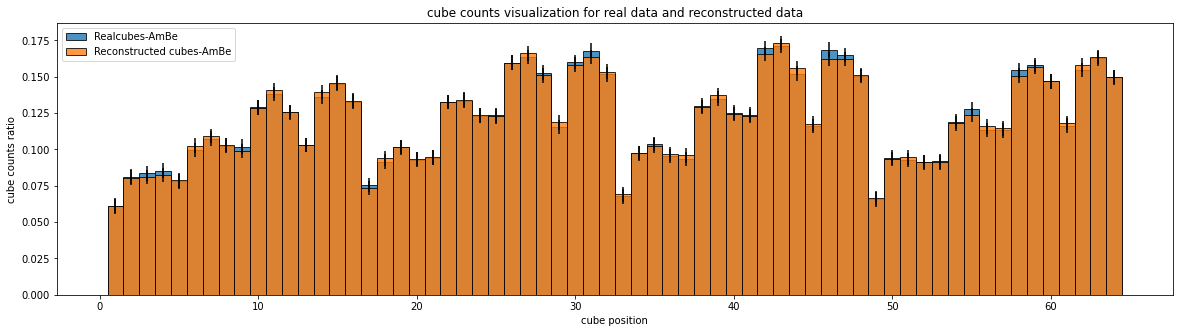

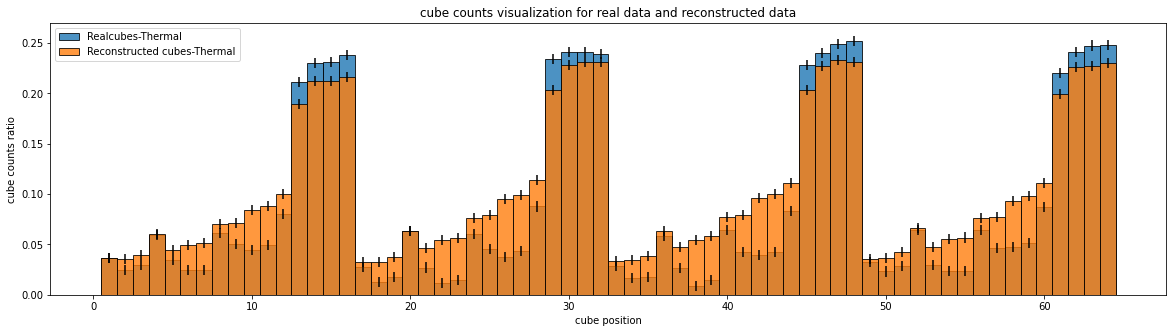

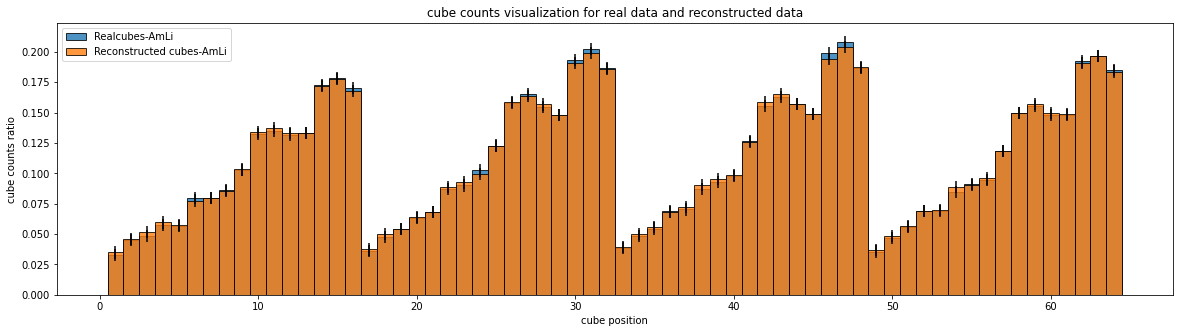

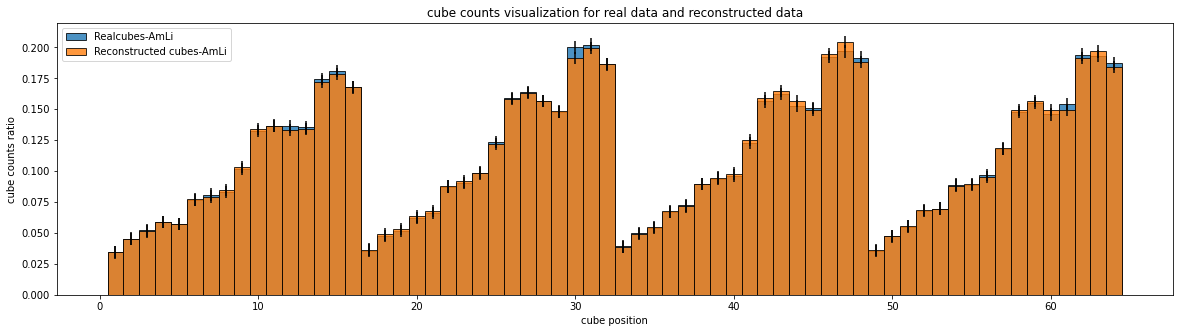

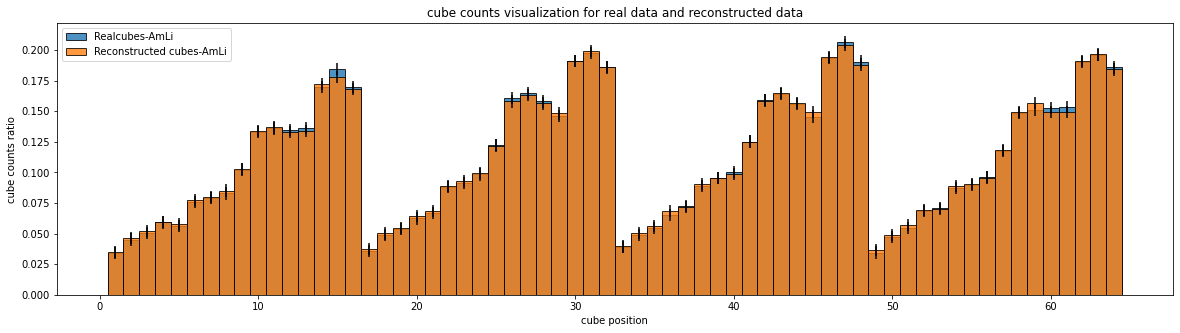

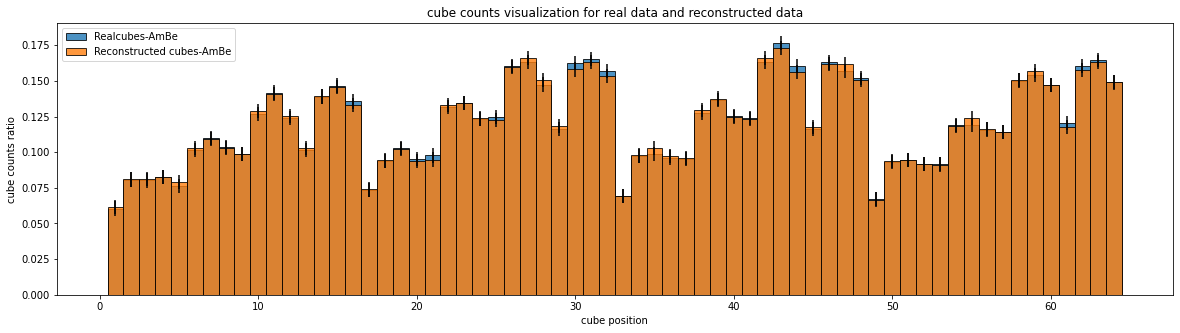

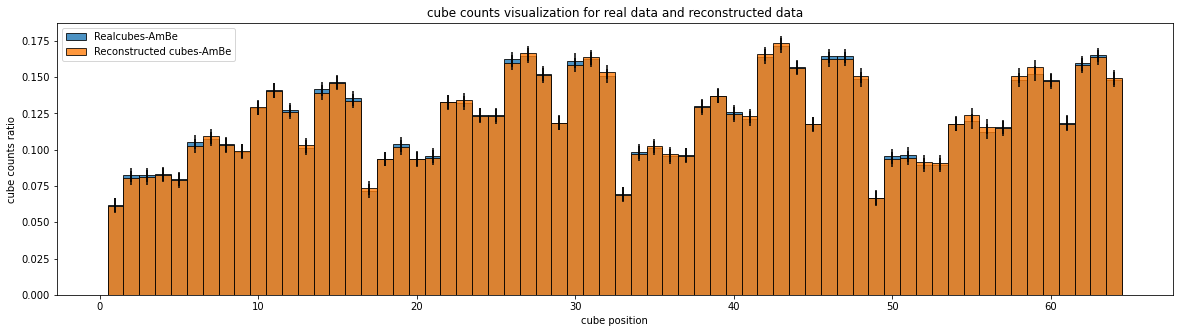

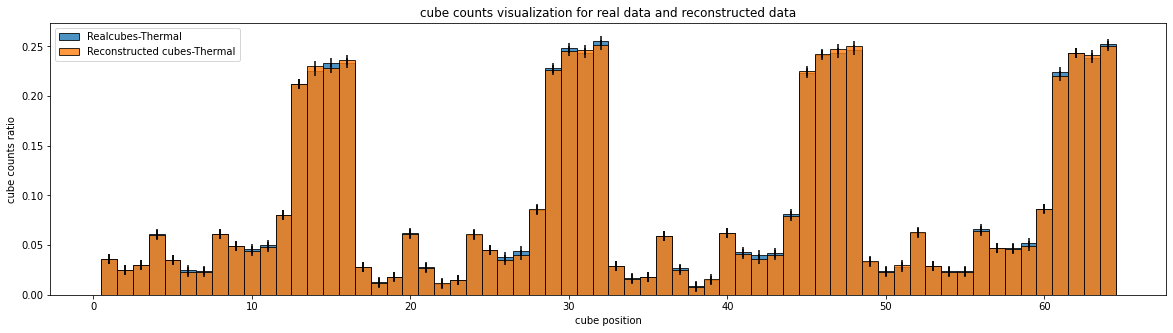

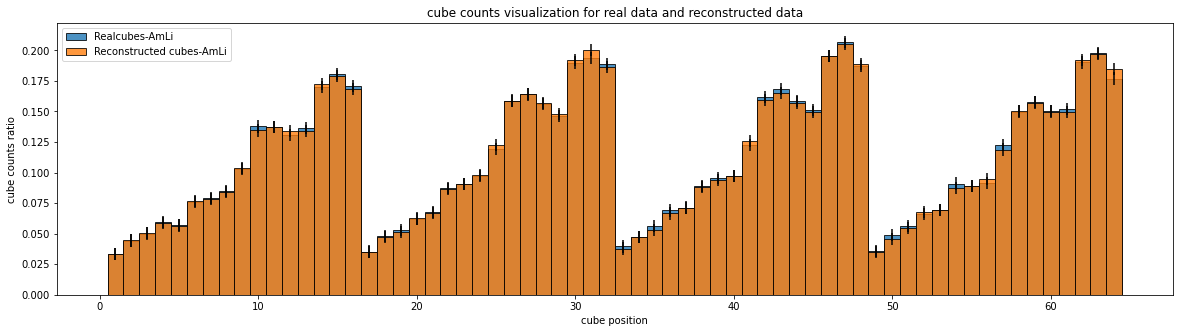

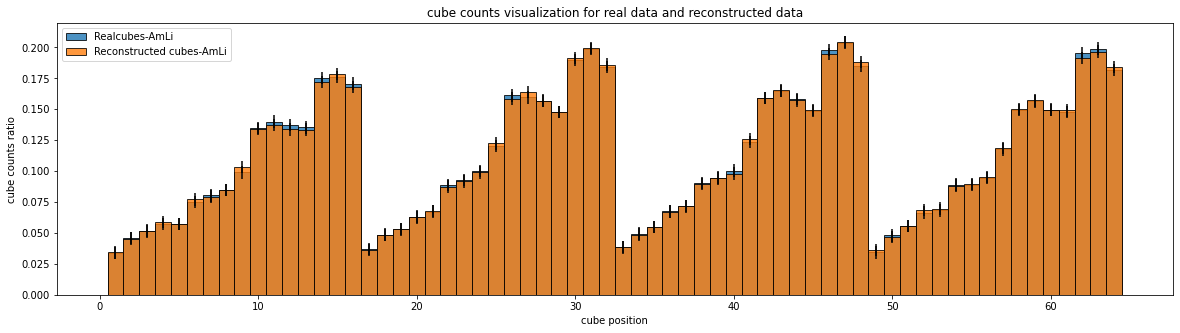

/tmp/ipykernel_1086/243123559.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x_axis, np.sqrt(recon_event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label = "Reconstructed " + title, alpha=0.8)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


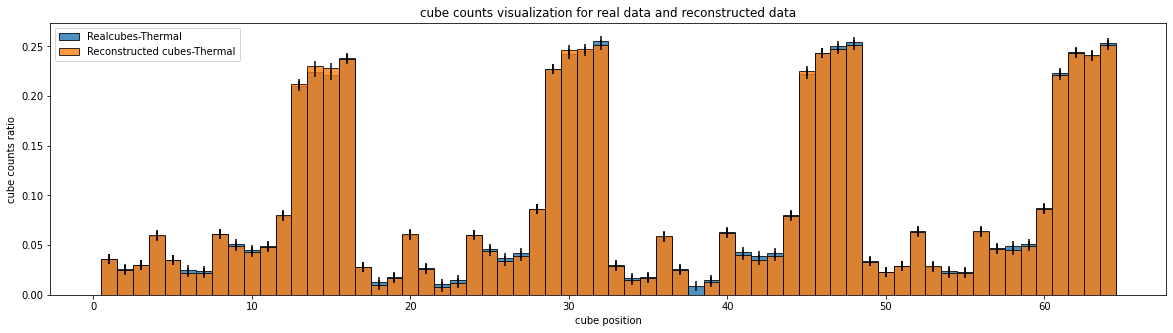

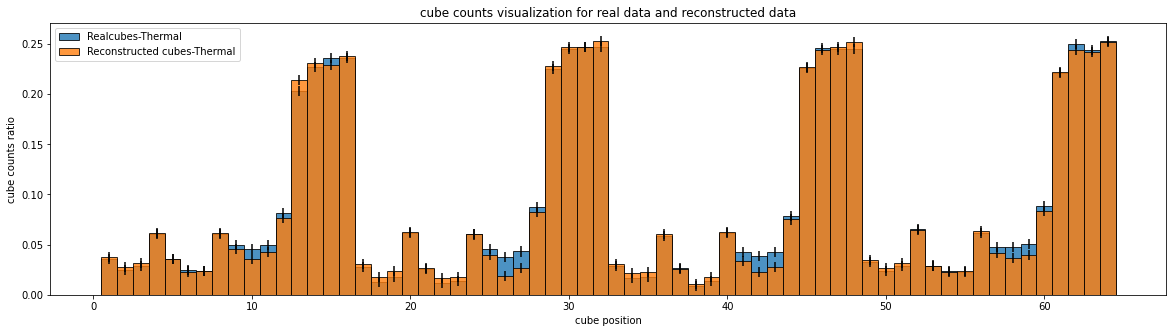

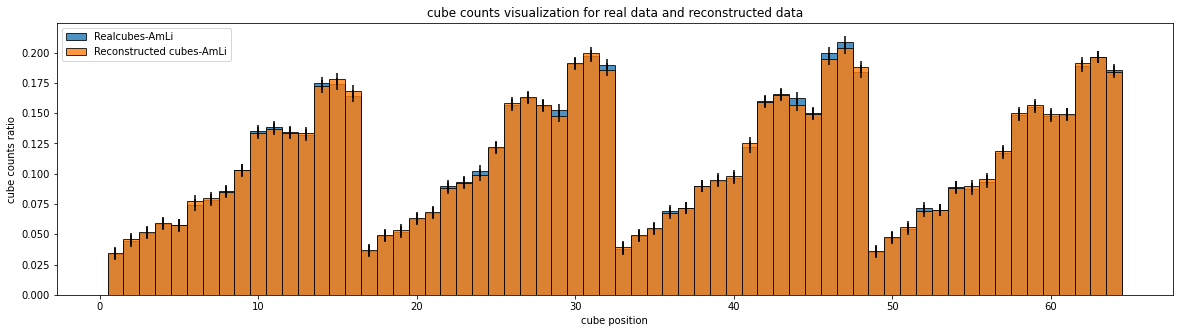

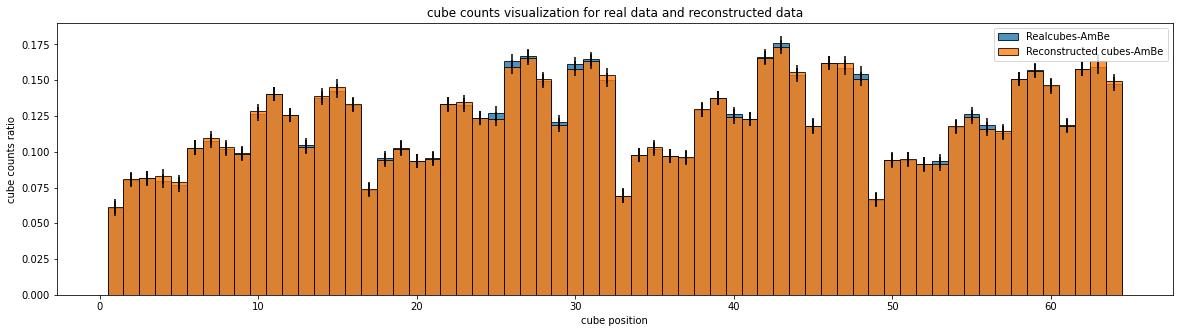

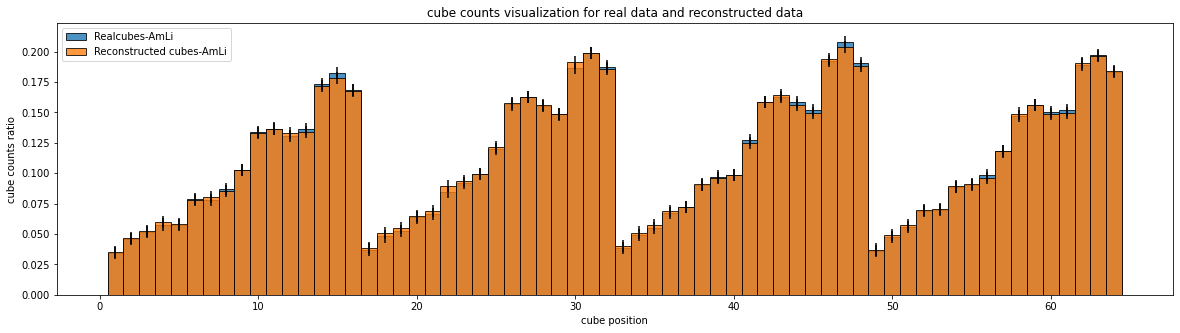

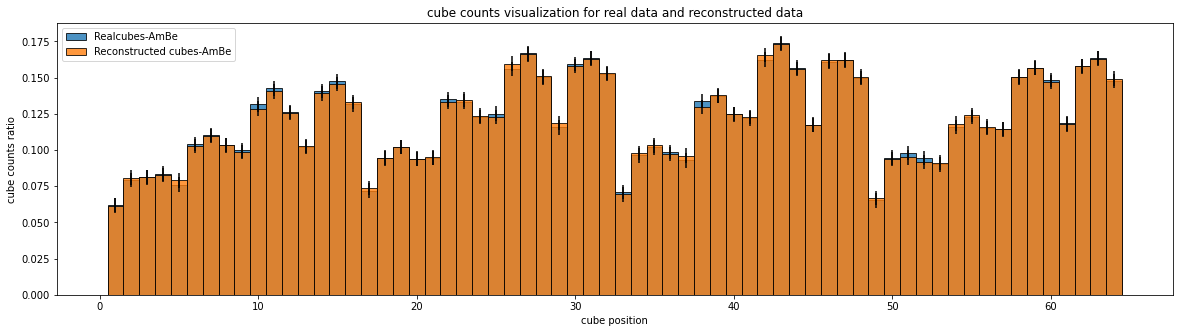

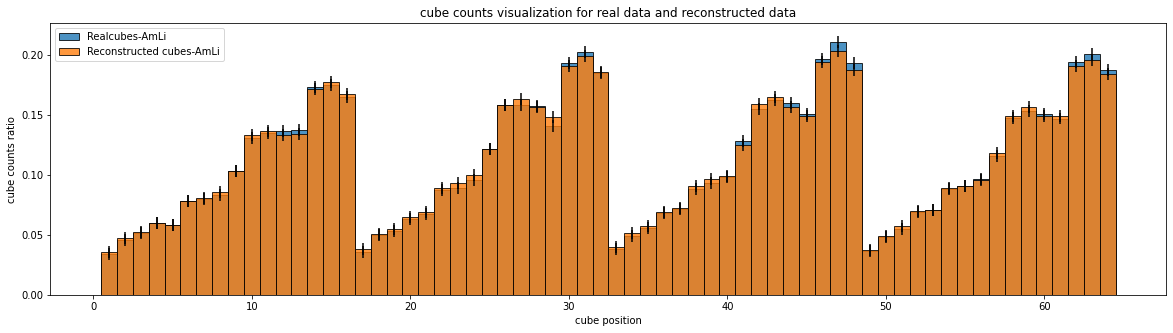

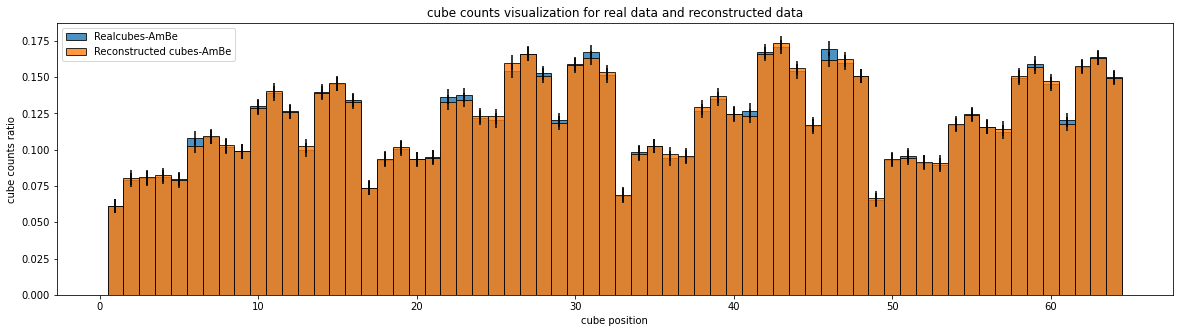

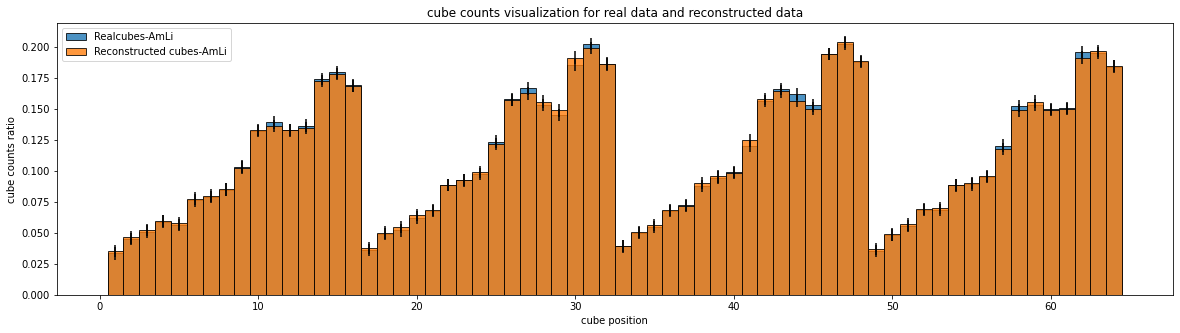

/tmp/ipykernel_1086/243123559.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x_axis, np.sqrt(recon_event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label = "Reconstructed " + title, alpha=0.8)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


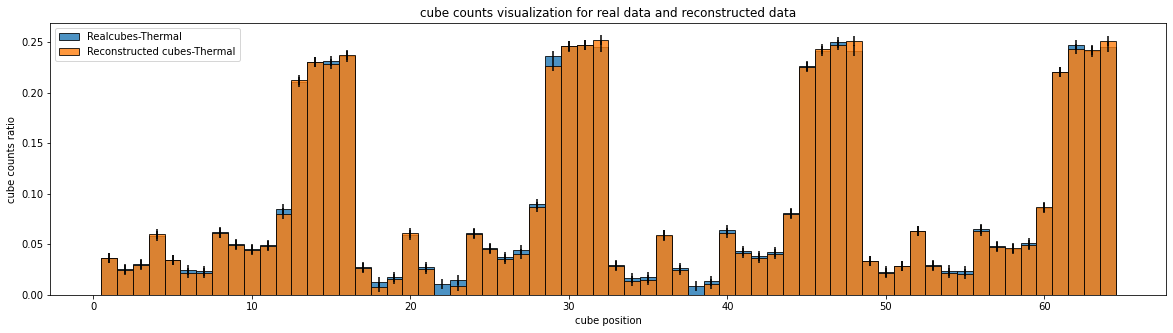

/tmp/ipykernel_1086/243123559.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x_axis, np.sqrt(recon_event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label = "Reconstructed " + title, alpha=0.8)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


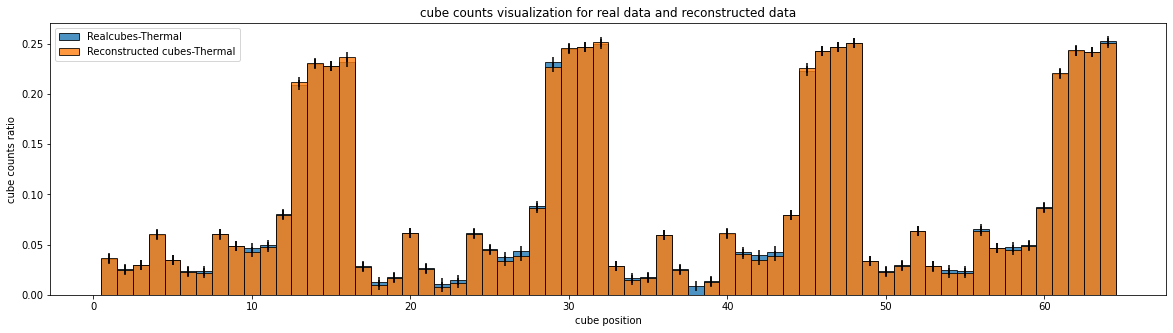

/tmp/ipykernel_1086/243123559.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x_axis, np.sqrt(recon_event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label = "Reconstructed " + title, alpha=0.8)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


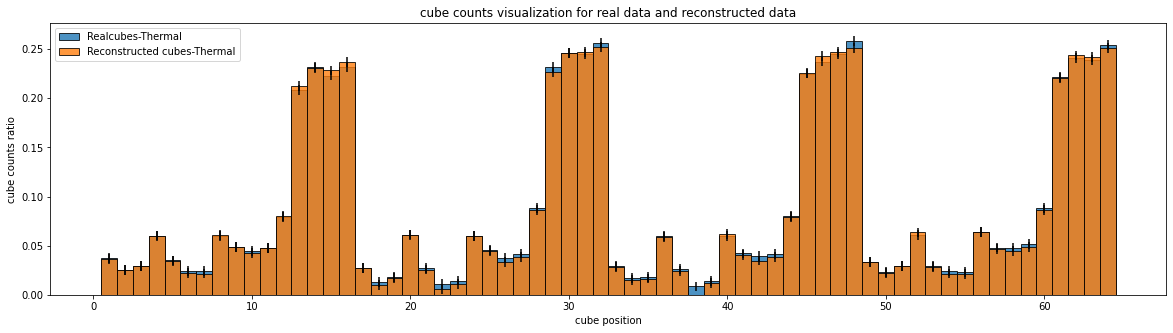

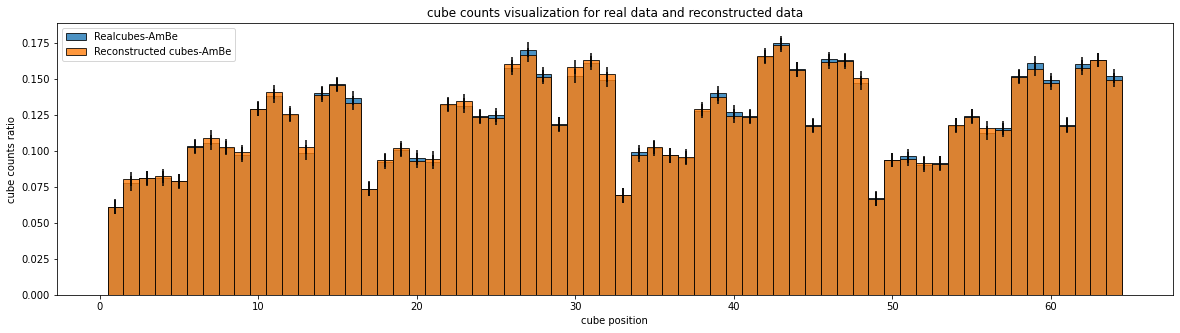

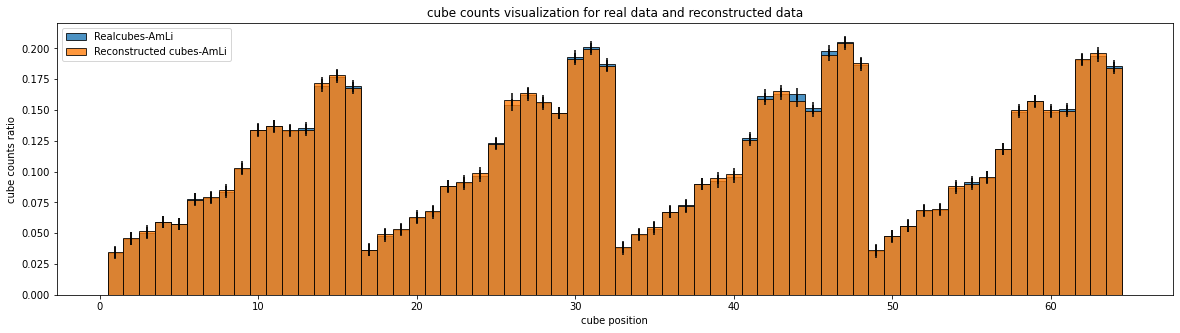

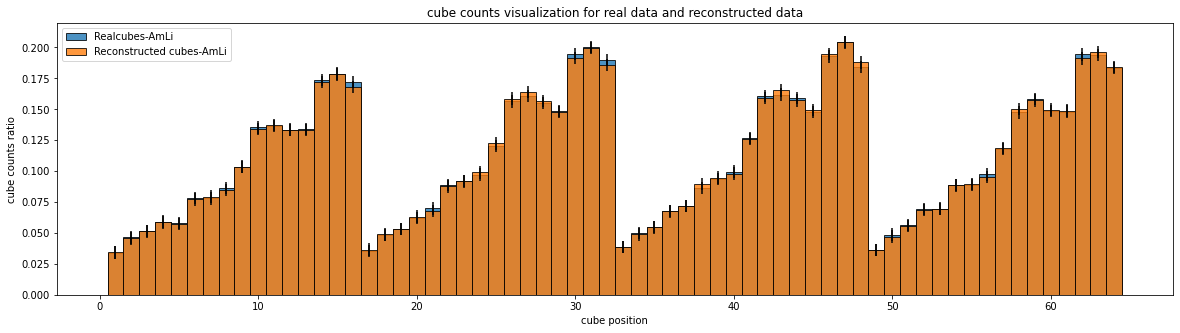

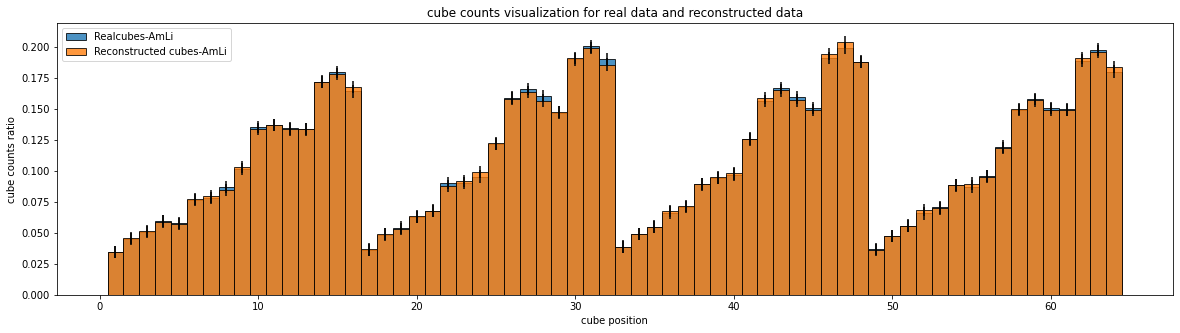

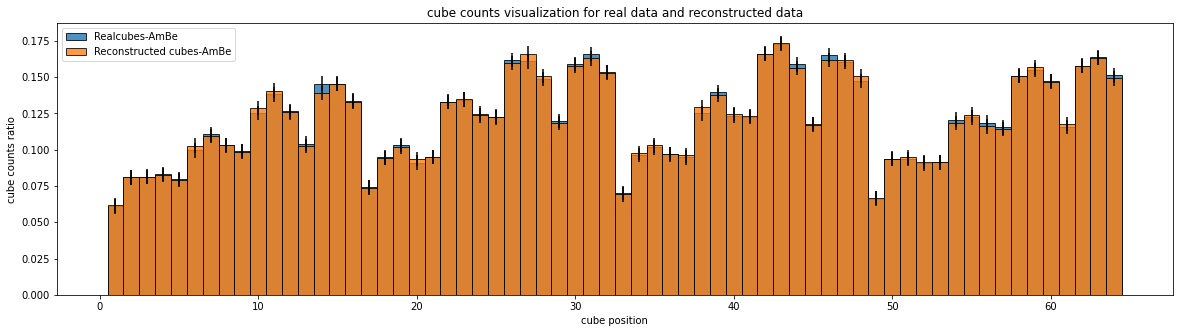

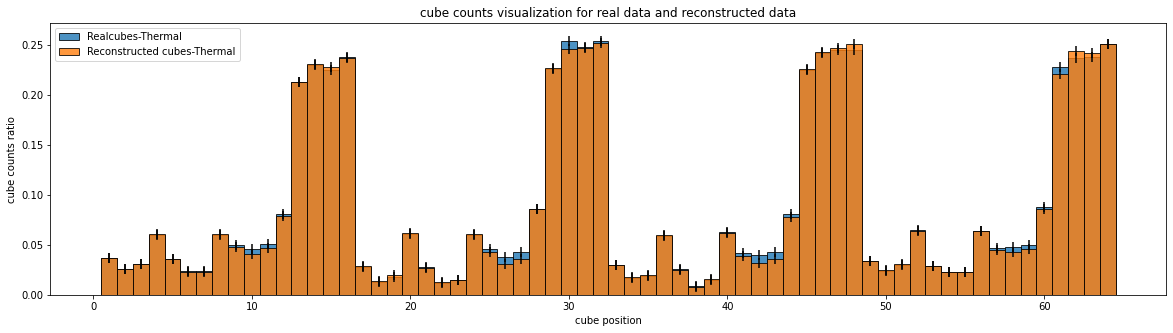

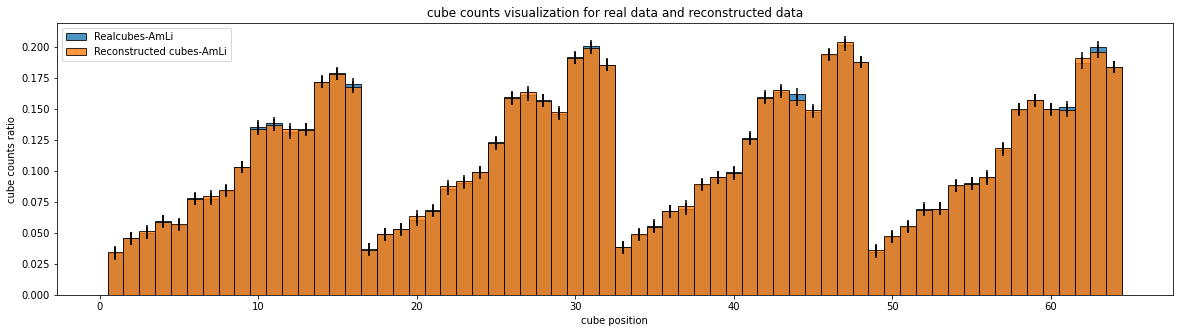

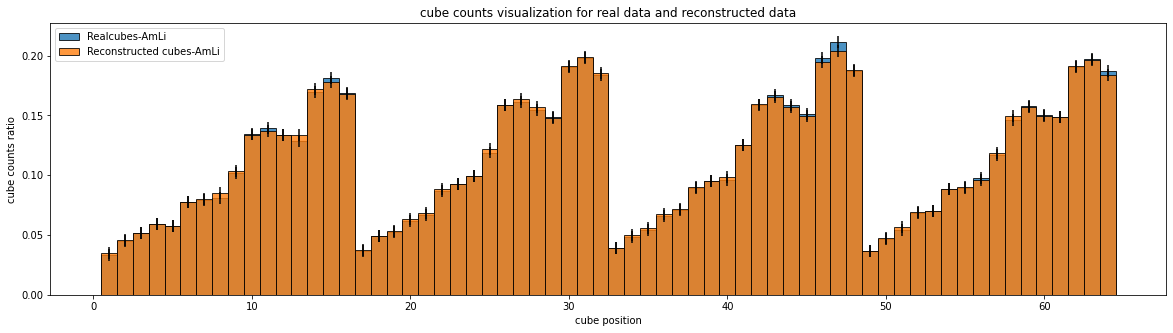

/tmp/ipykernel_1086/243123559.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x_axis, np.sqrt(recon_event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label = "Reconstructed " + title, alpha=0.8)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


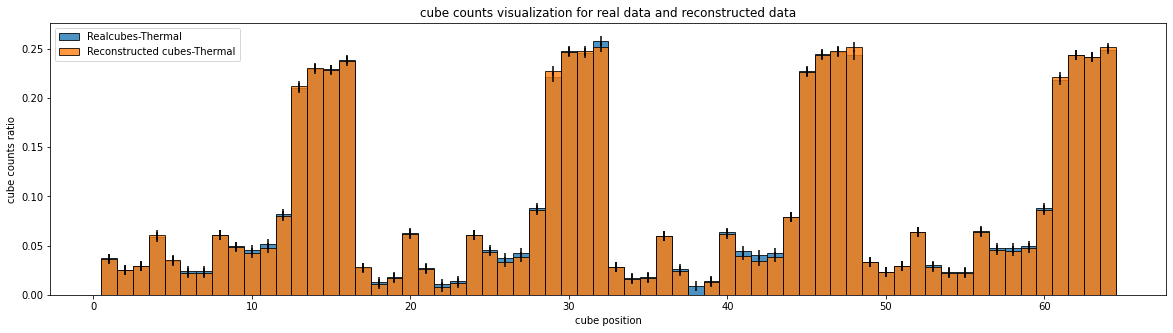

/tmp/ipykernel_1086/243123559.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x_axis, np.sqrt(recon_event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label = "Reconstructed " + title, alpha=0.8)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


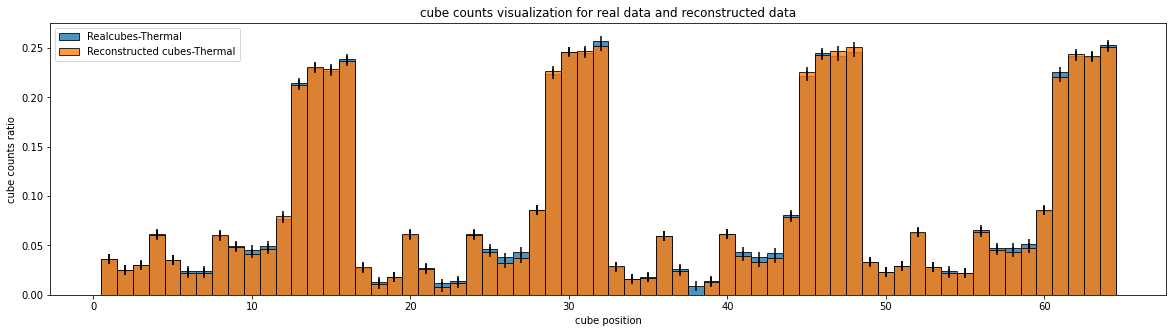

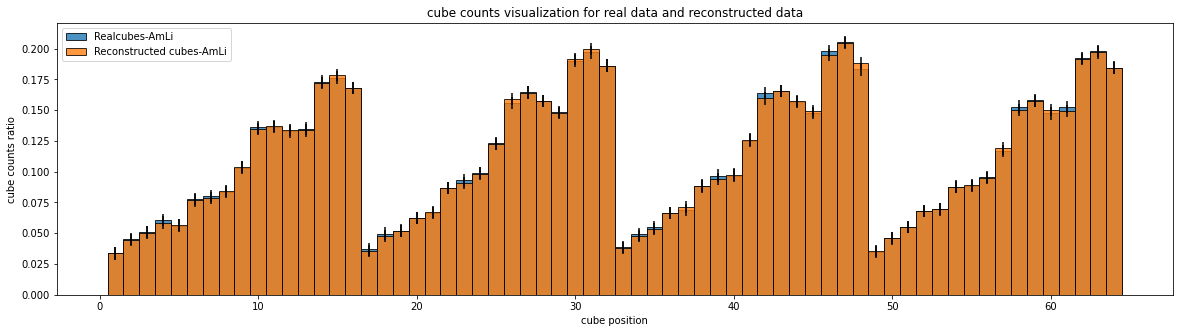

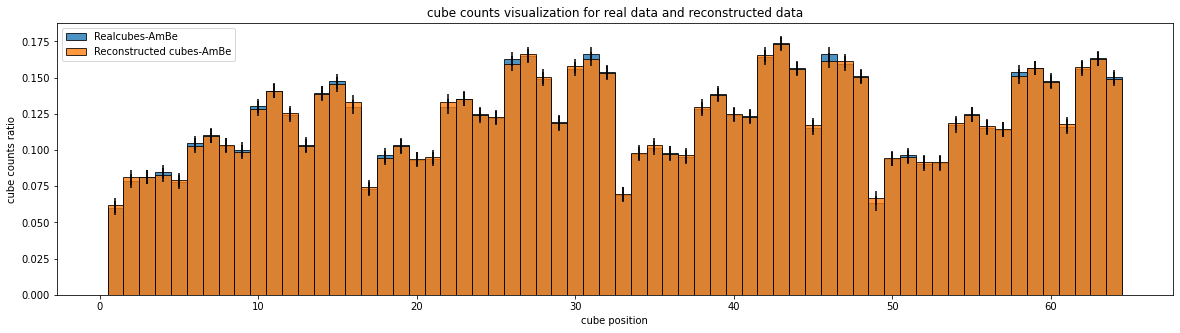

/tmp/ipykernel_1086/243123559.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x_axis, np.sqrt(recon_event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label = "Reconstructed " + title, alpha=0.8)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


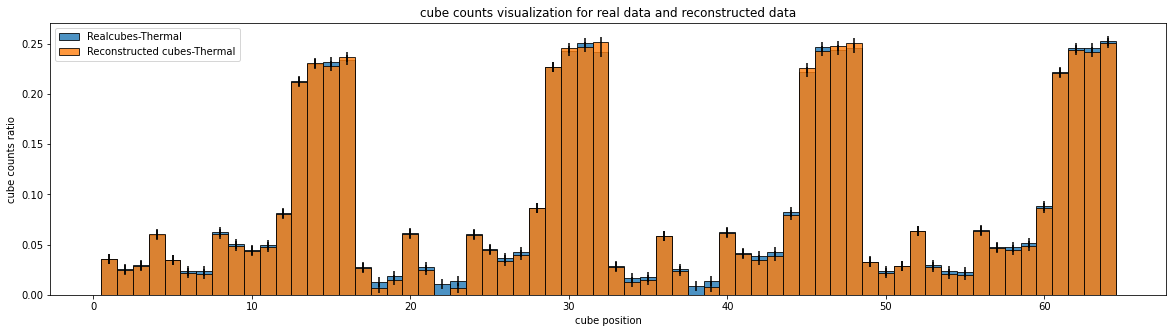

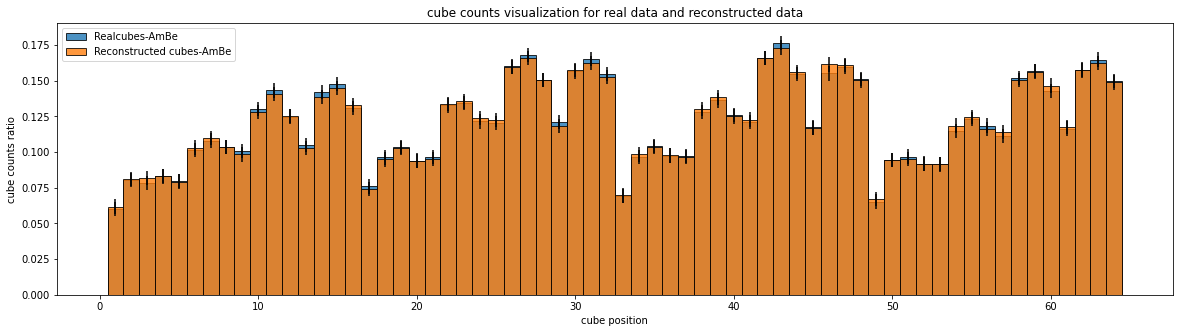

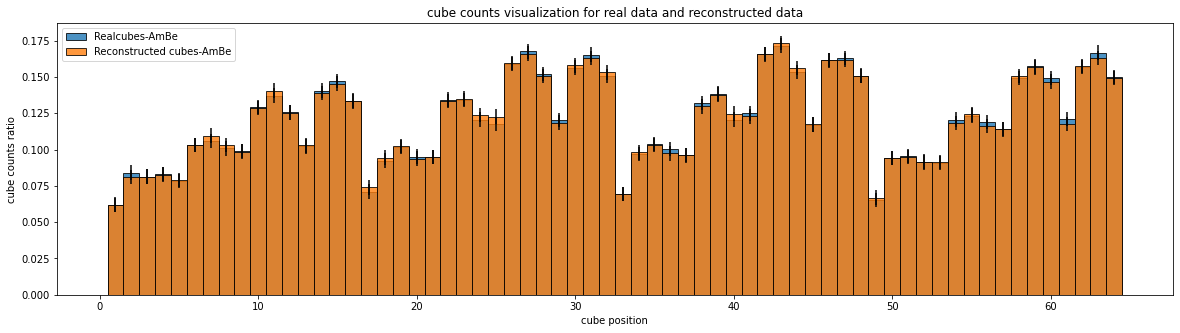

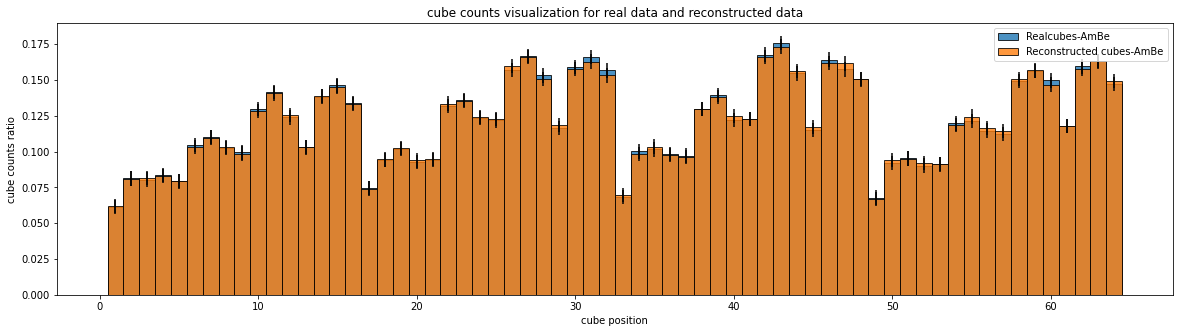

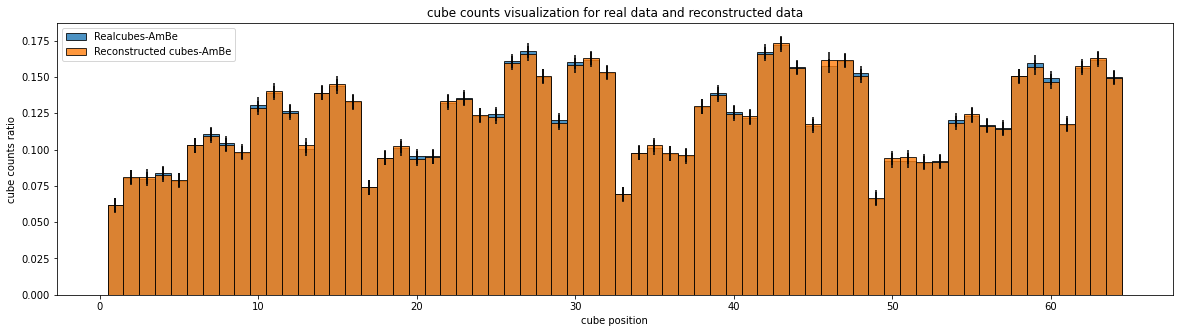

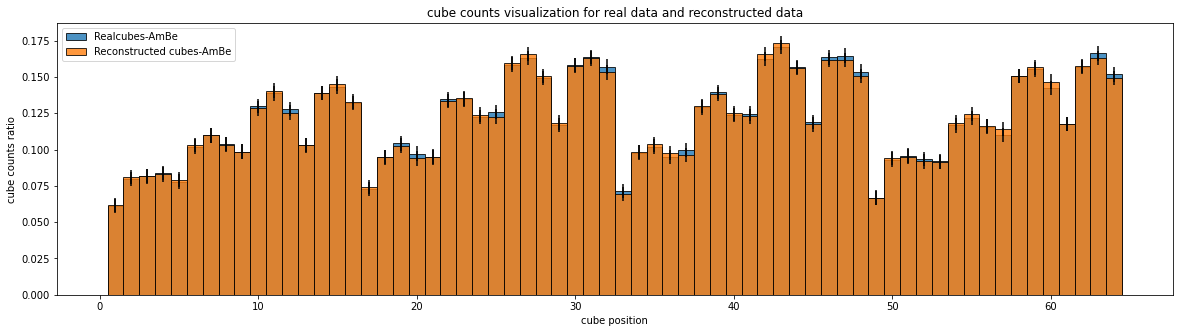

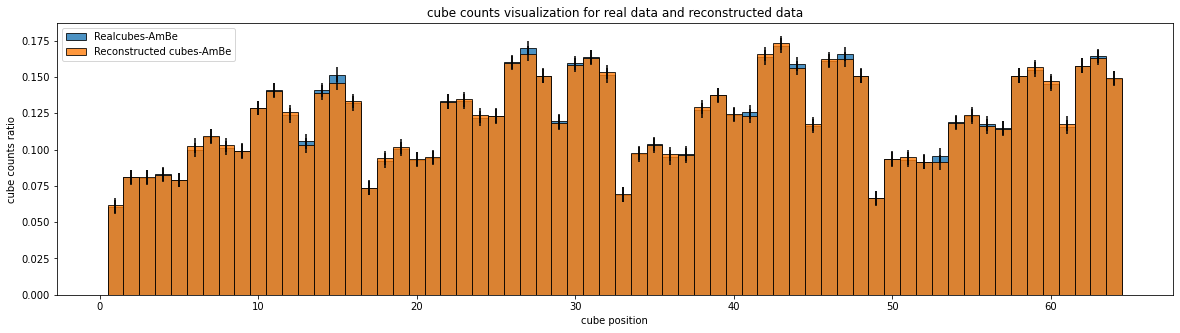

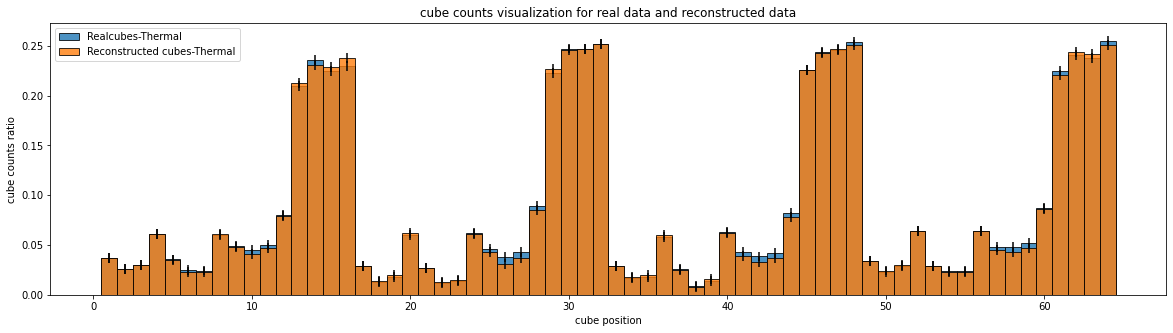

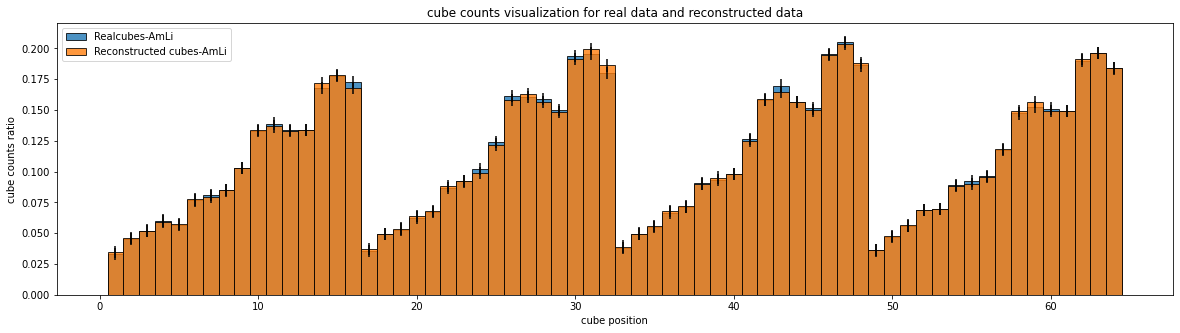

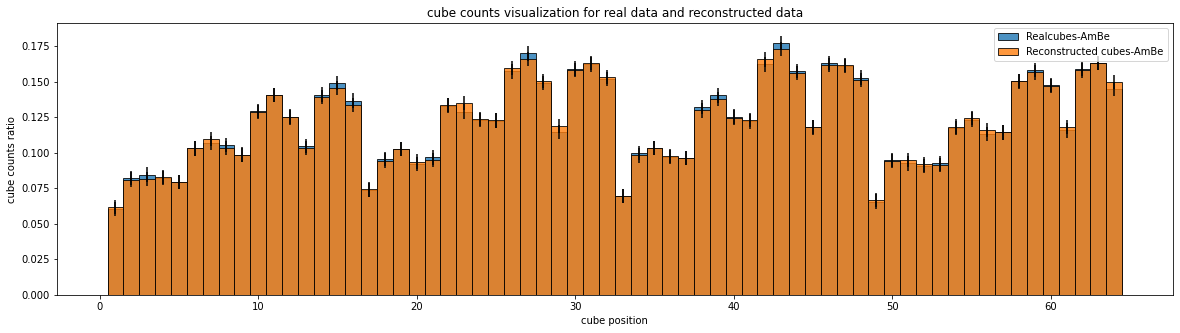

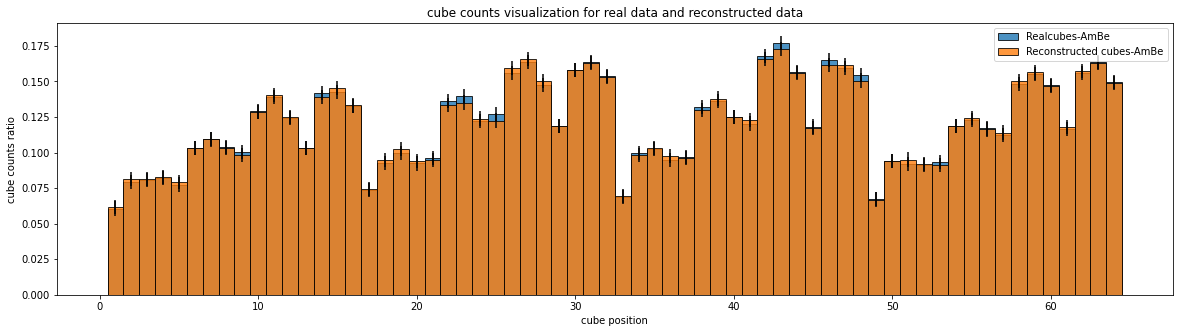

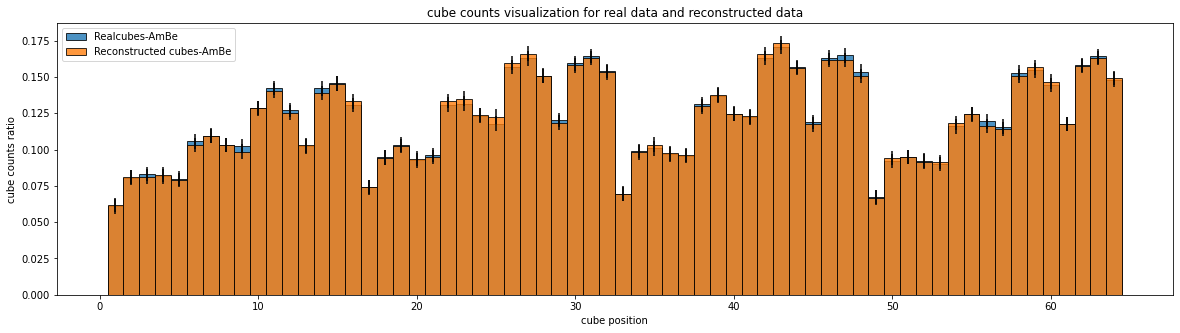

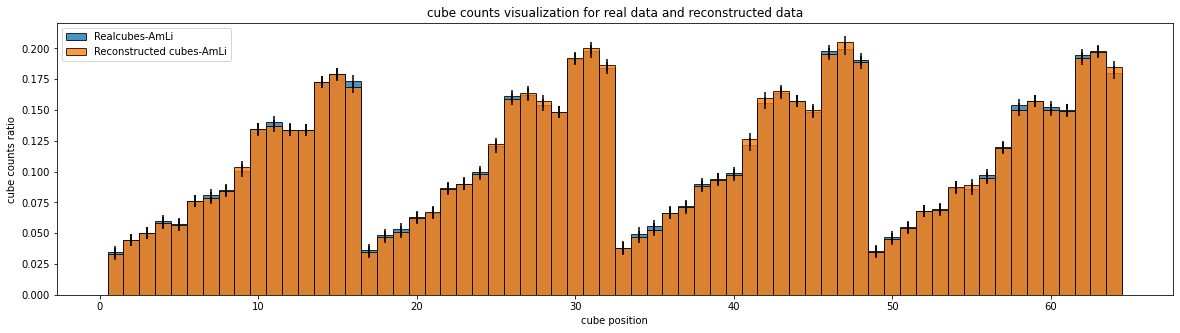

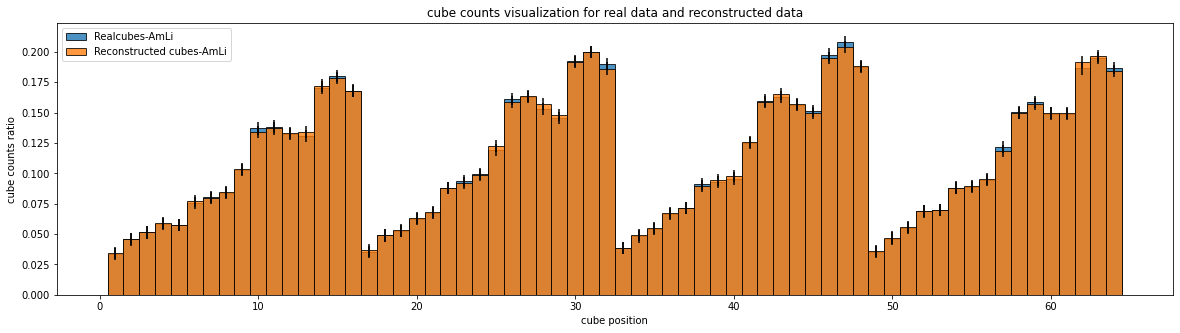

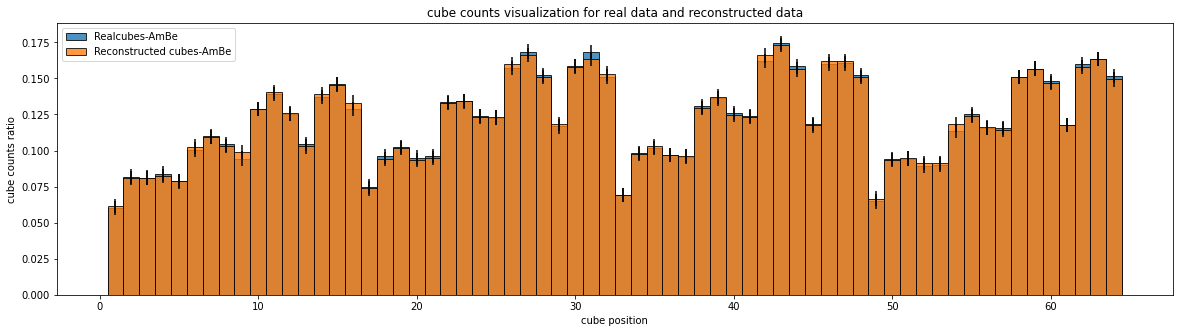

/tmp/ipykernel_1086/243123559.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x_axis, np.sqrt(recon_event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label = "Reconstructed " + title, alpha=0.8)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


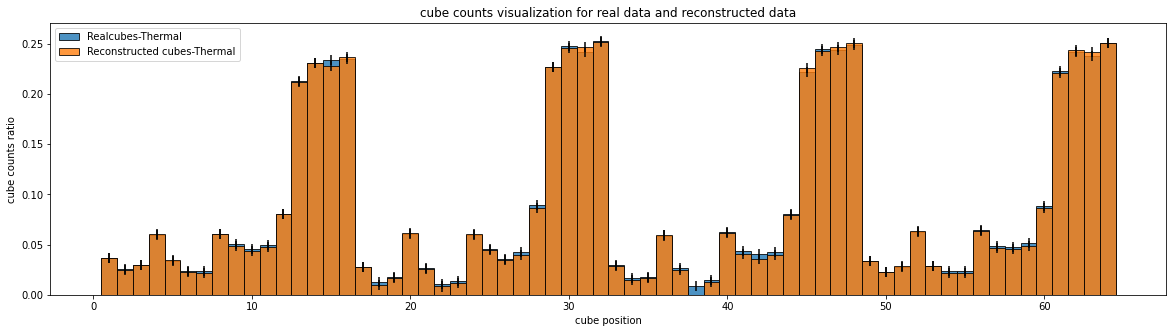

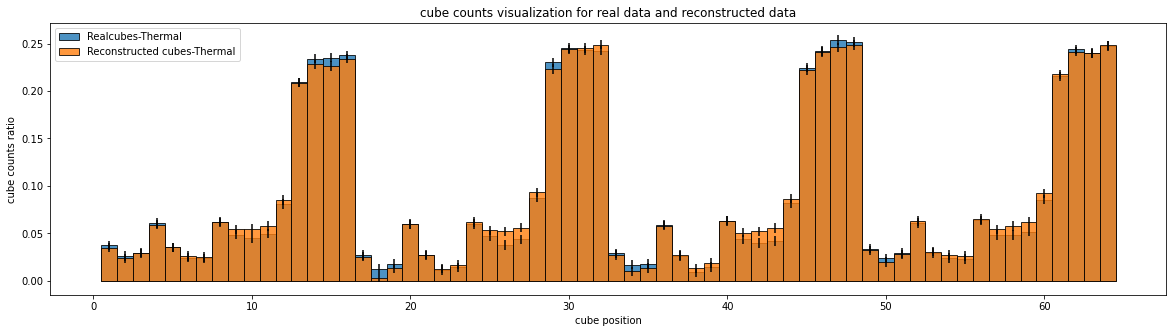

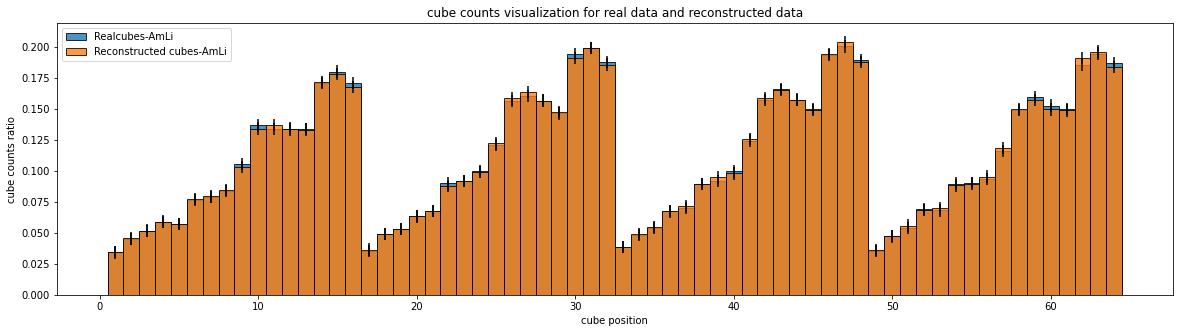

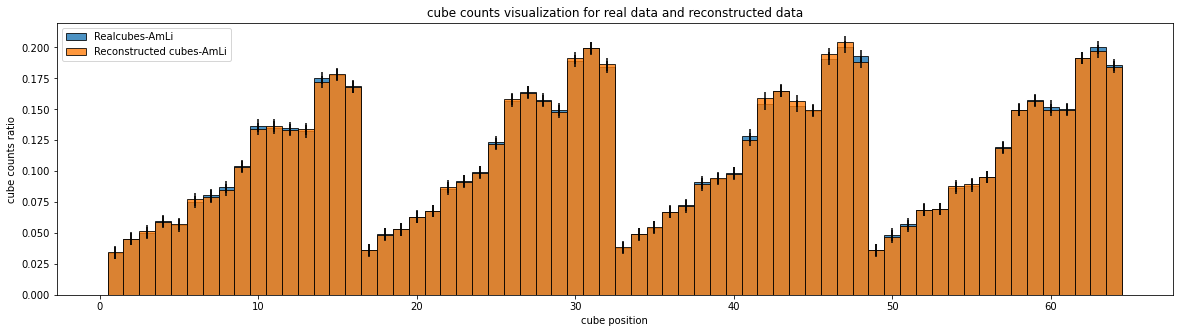

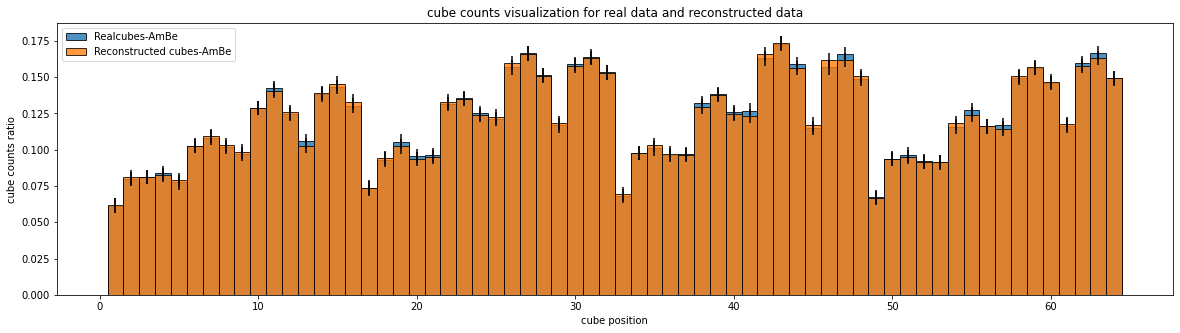

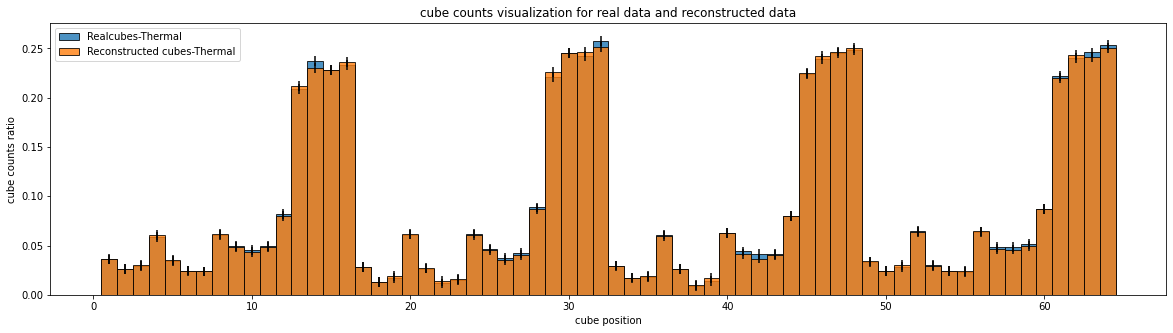

/tmp/ipykernel_1086/243123559.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x_axis, np.sqrt(recon_event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label = "Reconstructed " + title, alpha=0.8)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


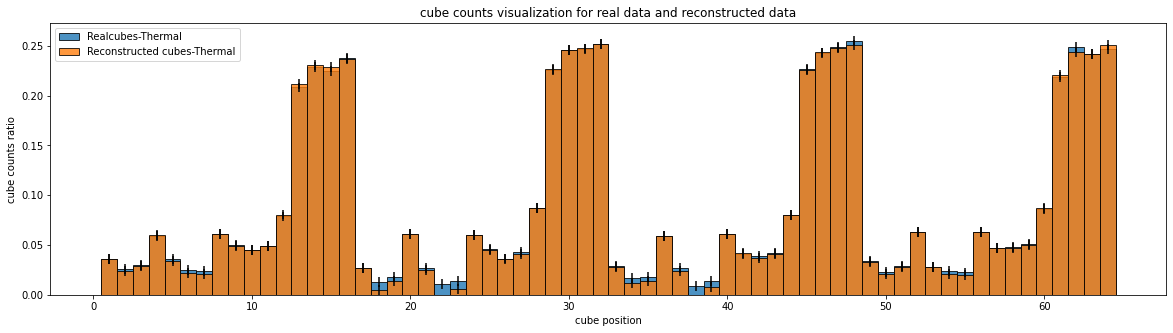

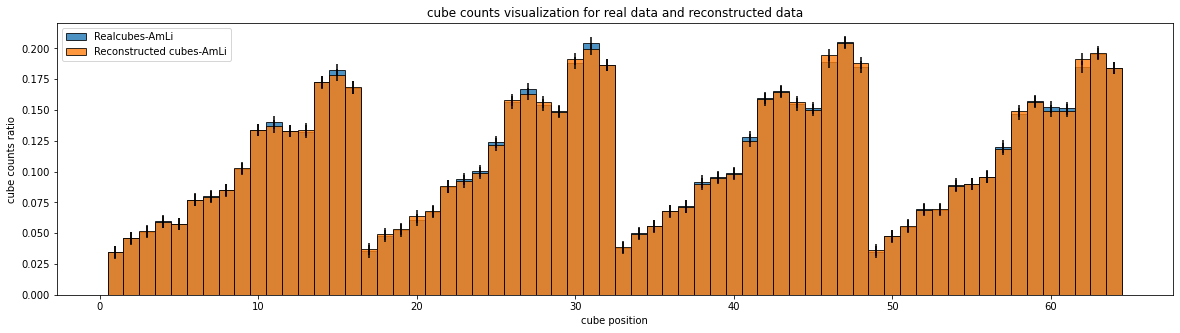

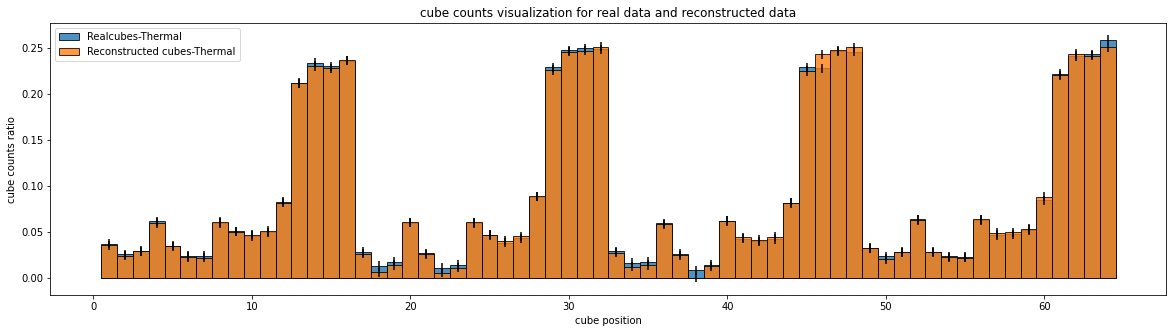

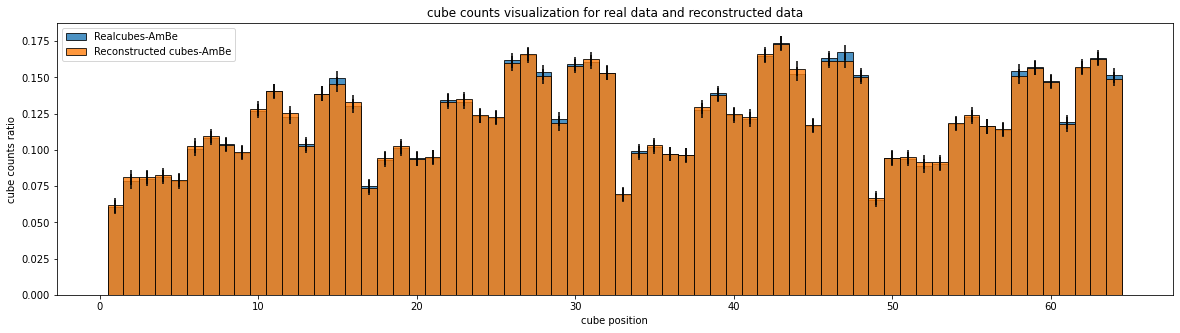

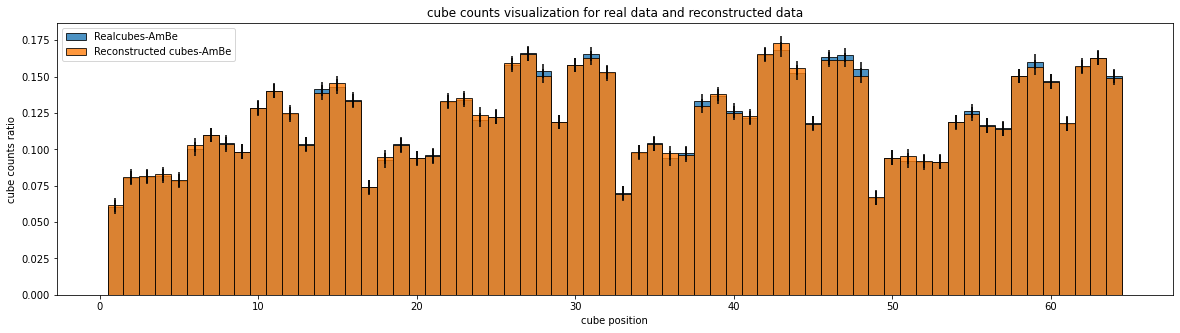

/tmp/ipykernel_1086/243123559.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x_axis, np.sqrt(recon_event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label = "Reconstructed " + title, alpha=0.8)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


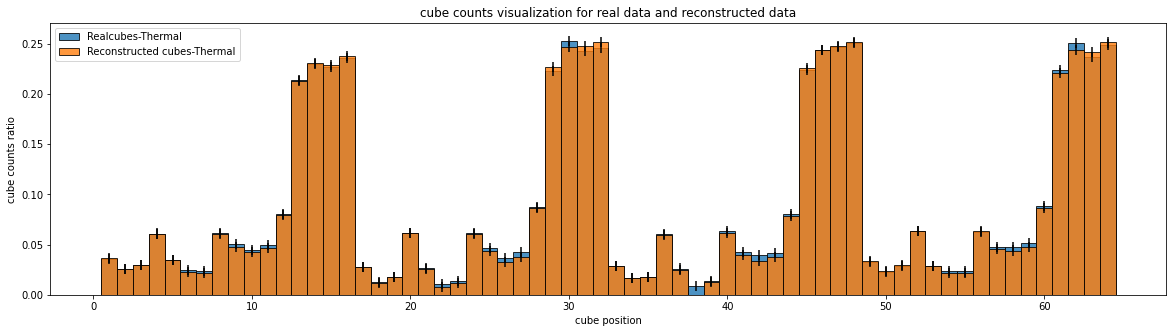

/tmp/ipykernel_1086/243123559.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x_axis, np.sqrt(recon_event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label = "Reconstructed " + title, alpha=0.8)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


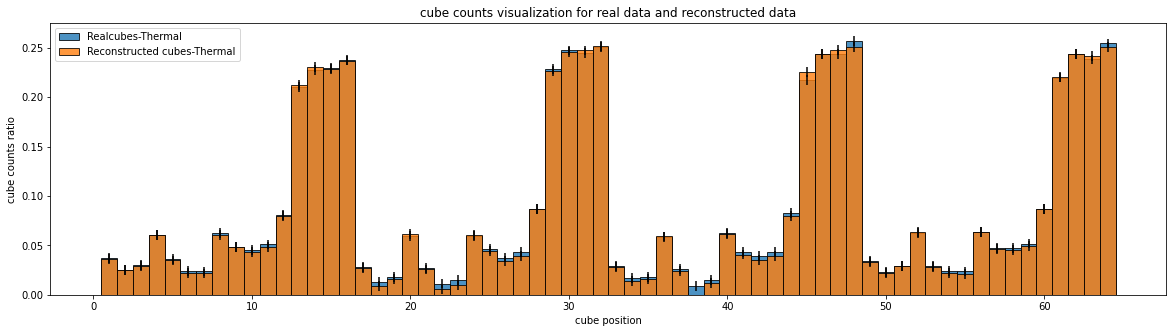

/tmp/ipykernel_1086/243123559.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x_axis, np.sqrt(recon_event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label = "Reconstructed " + title, alpha=0.8)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


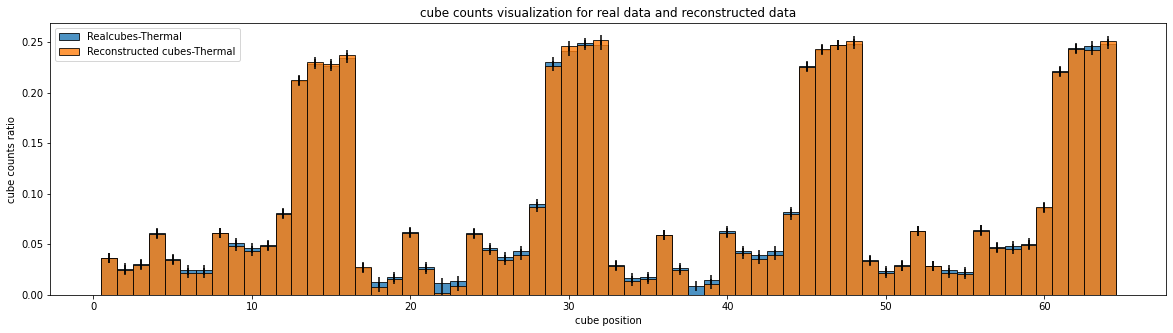

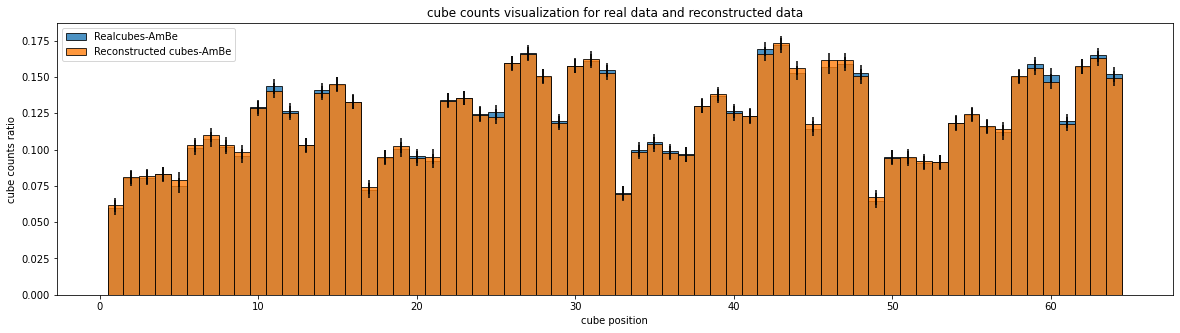

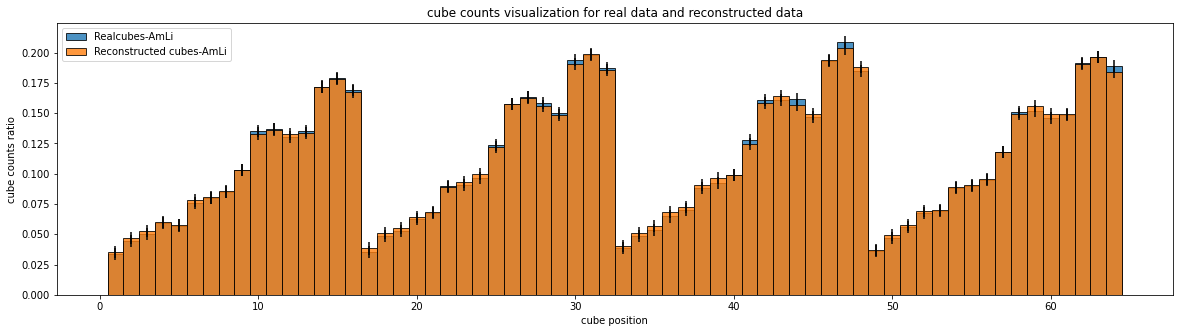

/tmp/ipykernel_1086/243123559.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x_axis, np.sqrt(recon_event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label = "Reconstructed " + title, alpha=0.8)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


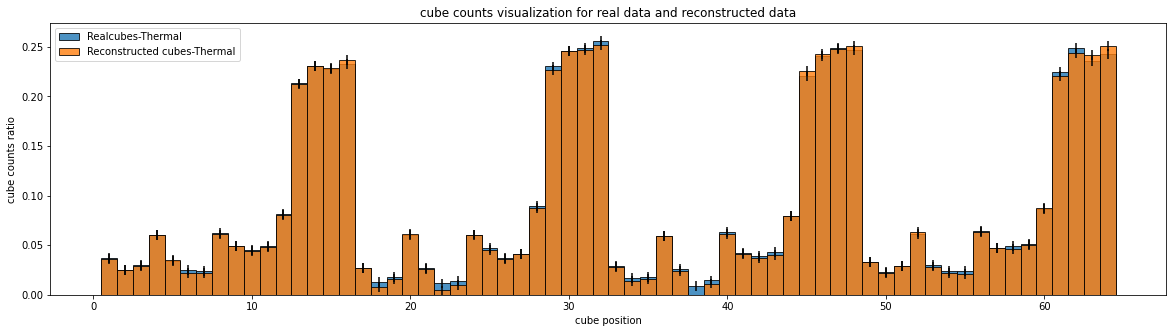

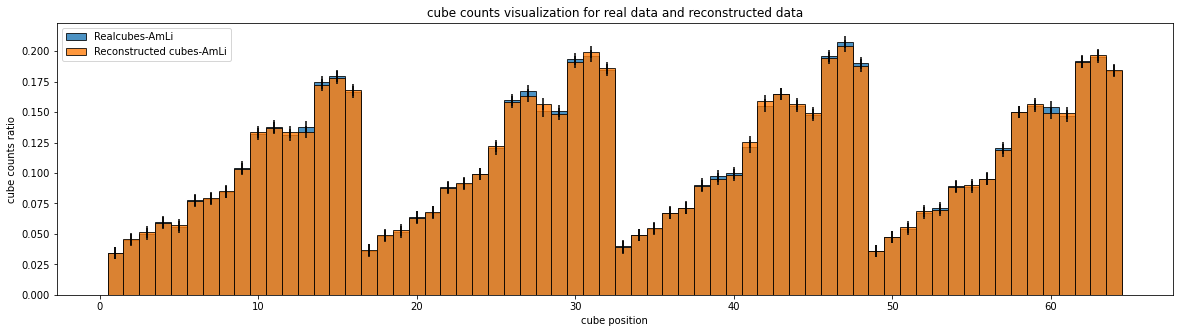

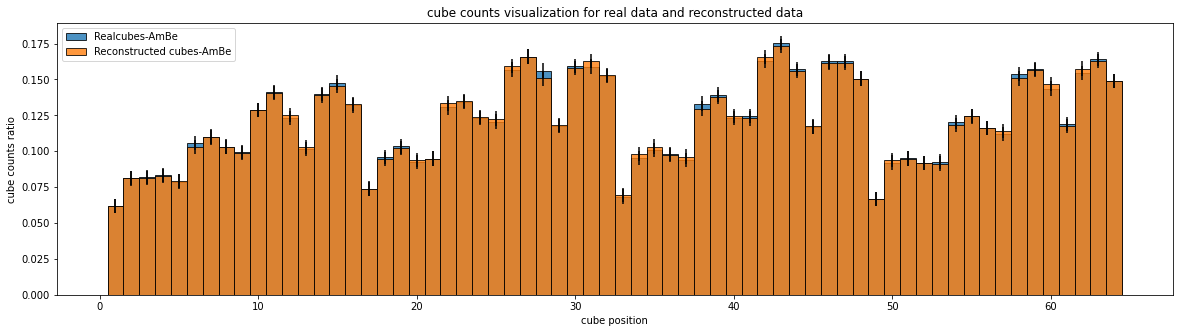

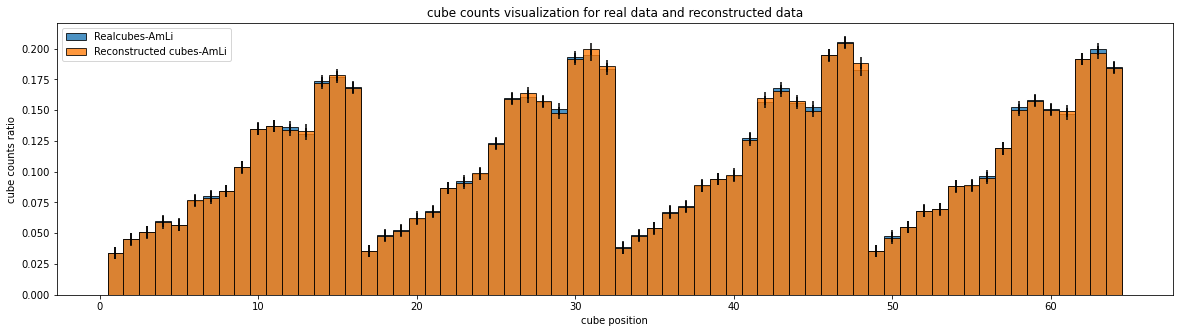

/tmp/ipykernel_1086/243123559.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x_axis, np.sqrt(recon_event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label = "Reconstructed " + title, alpha=0.8)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/hep/hl3520/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


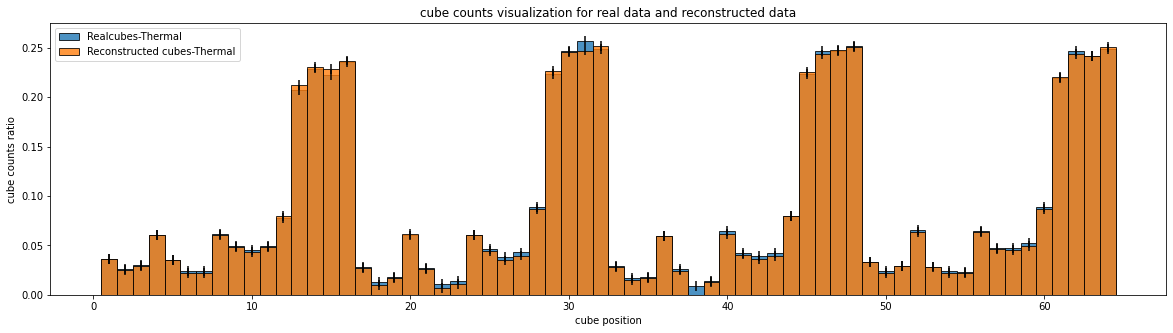

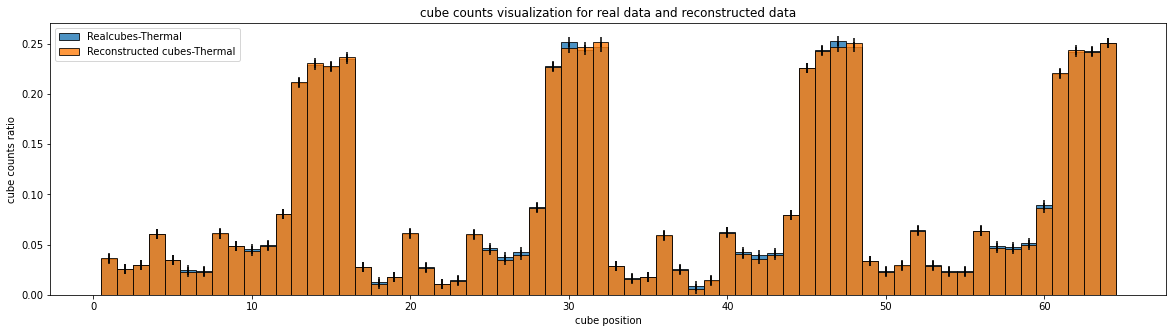

In [32]:
plt.rcParams['figure.figsize'] = (20, 5)

for i in range(128):
    
    event = events[i].cpu()
    #print(image.shape)
    recon_event = x_recon[i].cpu()


    plt.subplot(1, 1, 1)
    event = event.flatten()
    event = event/sum(event)
    event = np.array(event).tolist()
    label = labels[i]
    title = category_list[label]
#     plt.plot(event)
    plt.bar(x_axis, np.sqrt(event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label="Real" + title, alpha=0.8)
    
    

#     plt.subplot(1, 2, 2)
    recon_event = recon_event.flatten()
    recon_event = recon_event/sum(recon_event)
    recon_event = np.array(recon_event).tolist()
#     plt.plot(recon_event)
    difference_event = list(map(lambda x: x[0]-x[1], zip(recon_event, event)))
#     print(difference_event)

    plt.bar(x_axis, np.sqrt(recon_event), width=1, linewidth=1, yerr = 0.005, edgecolor='k', label = "Reconstructed " + title, alpha=0.8)
    plt.xlabel('cube position')
    plt.ylabel('cube counts ratio')
    plt.title('cube counts visualization for real data and reconstructed data')

    plt.legend()
    plt.show()

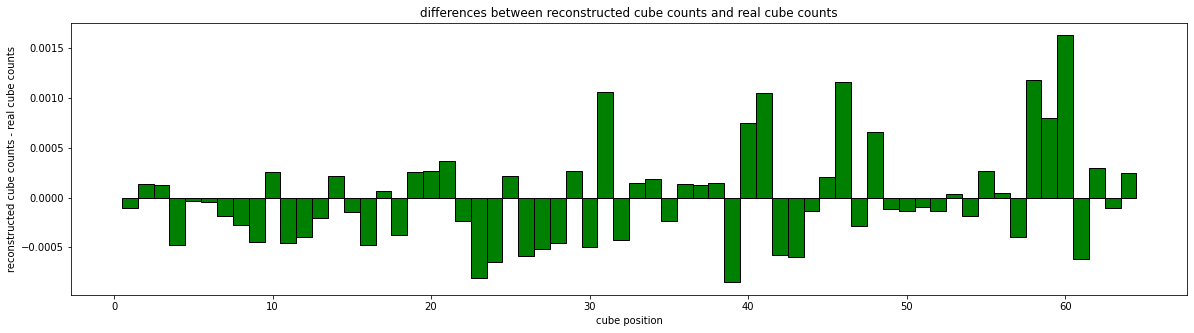

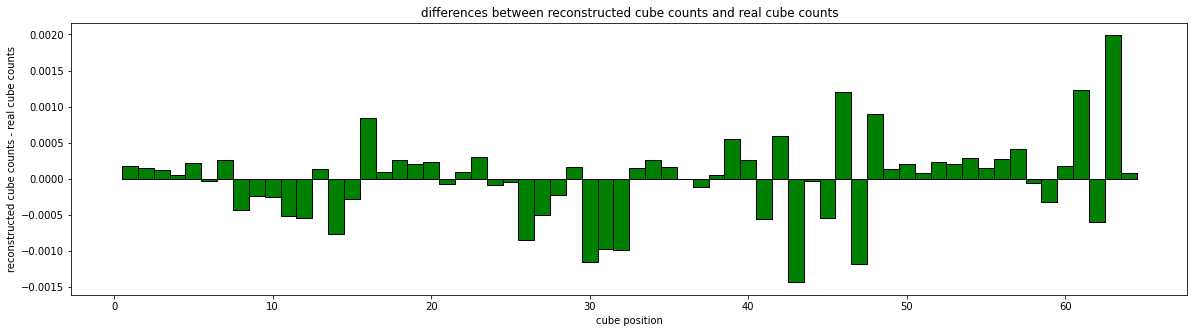

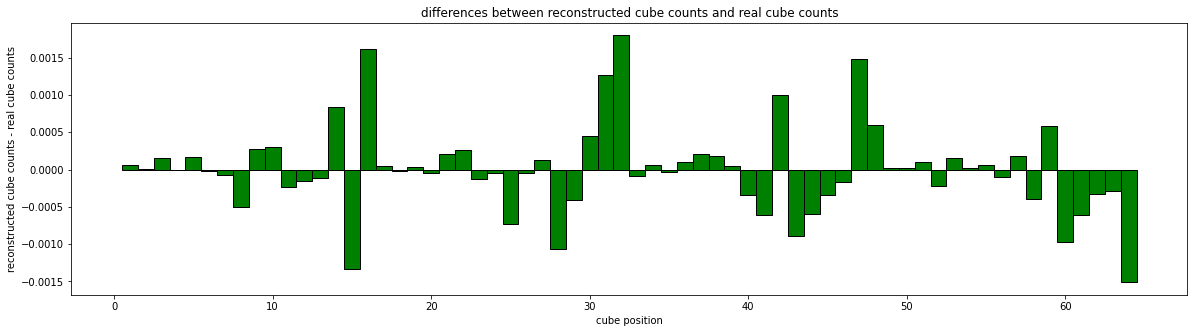

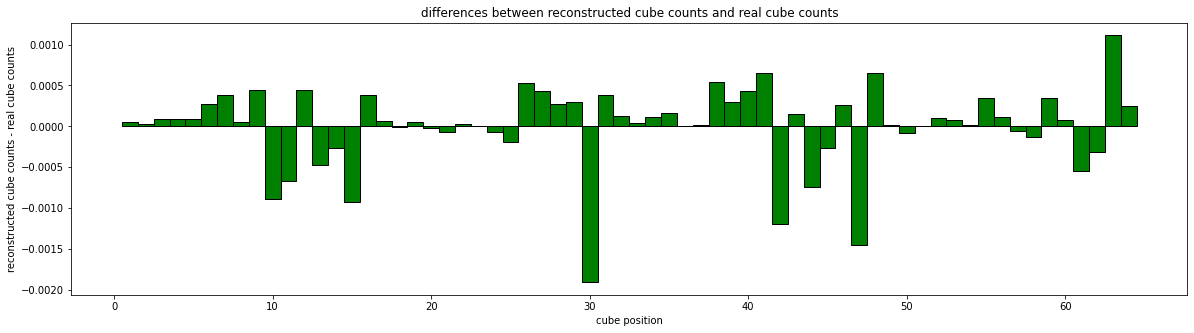

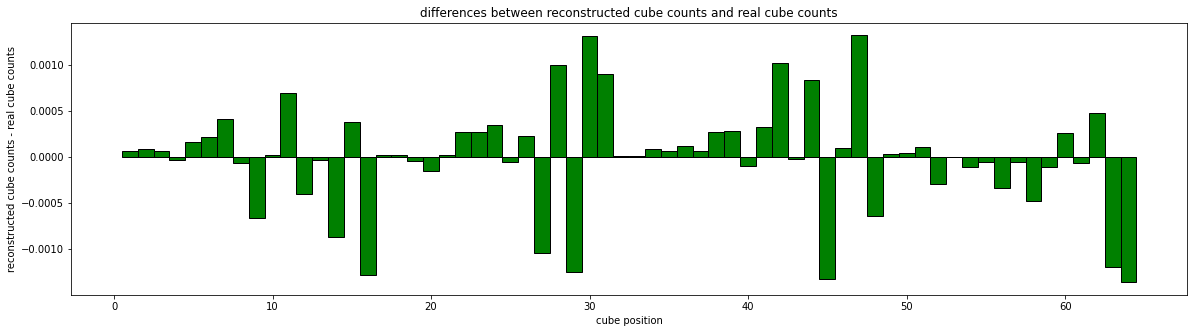

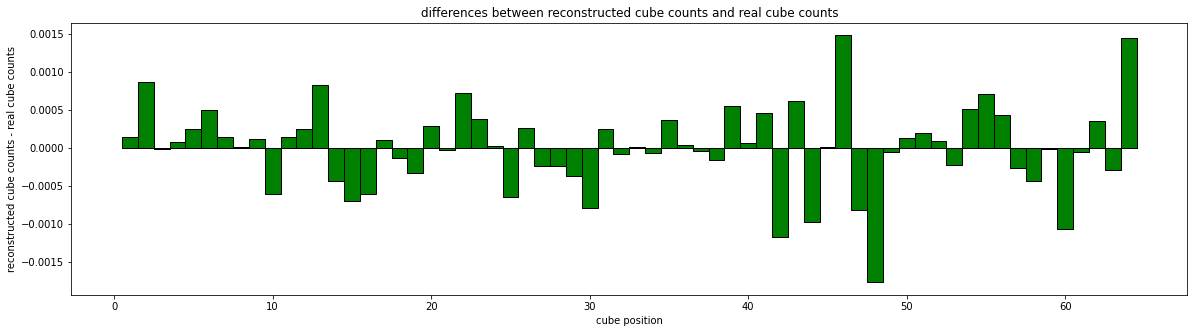

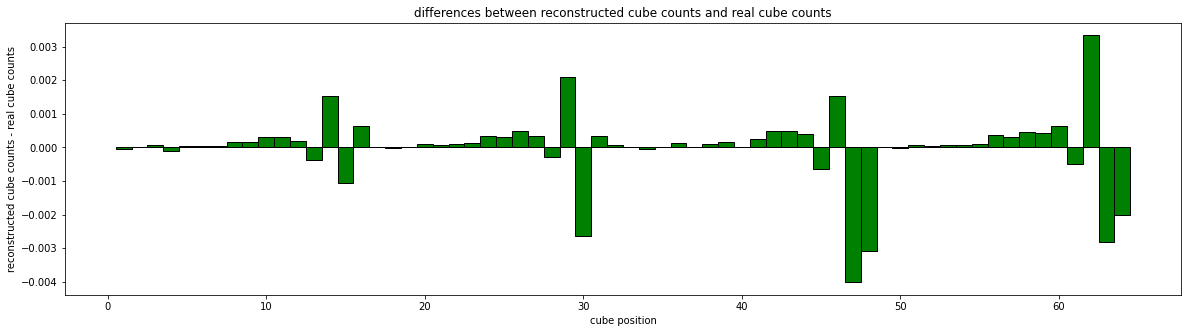

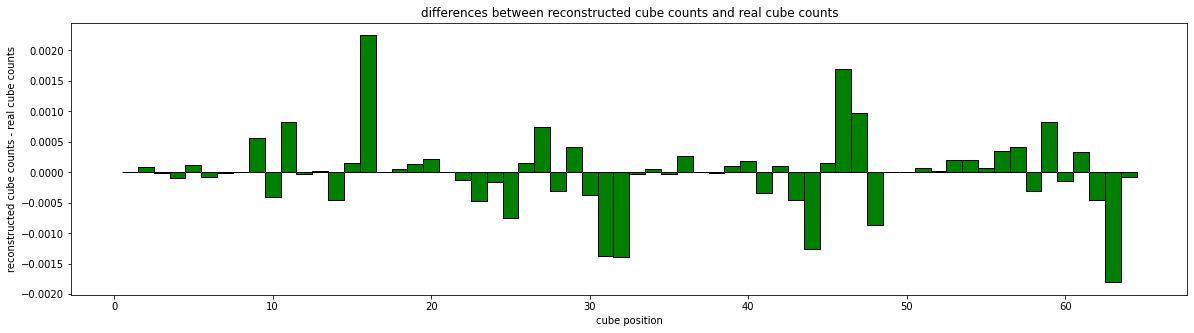

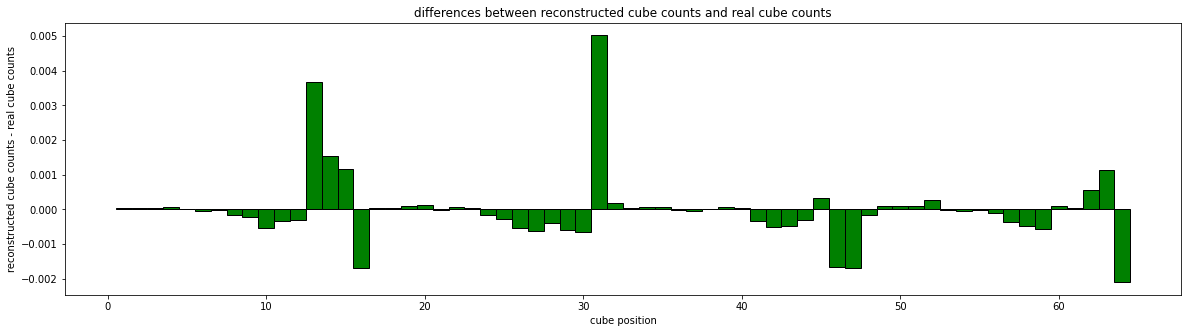

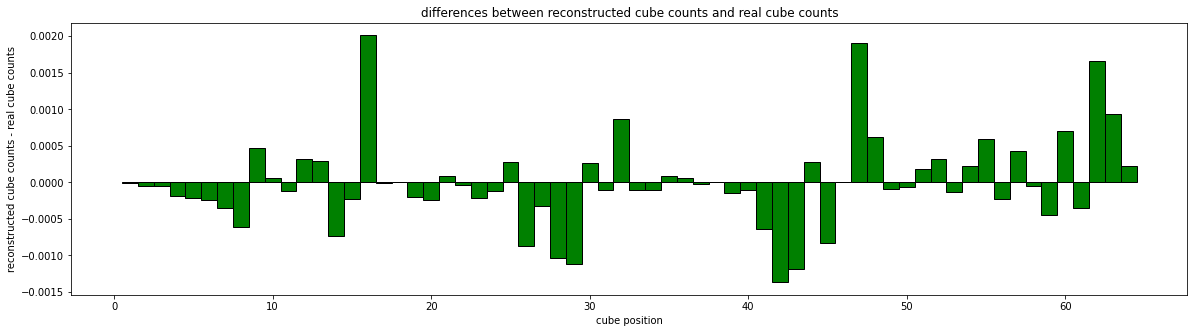

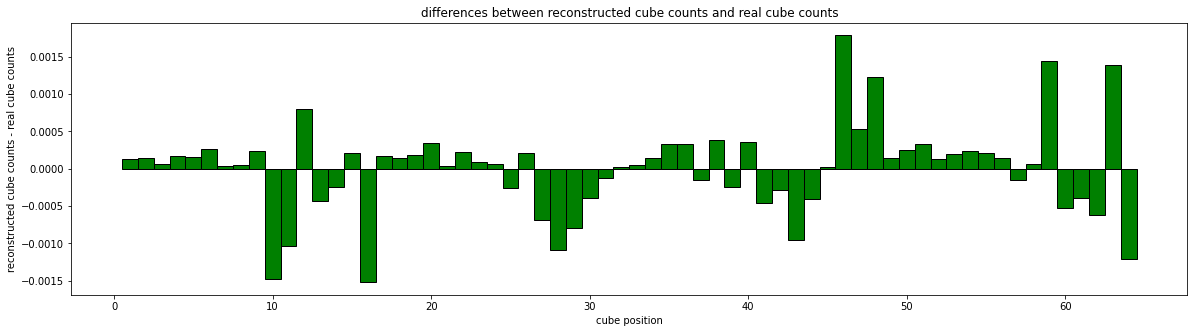

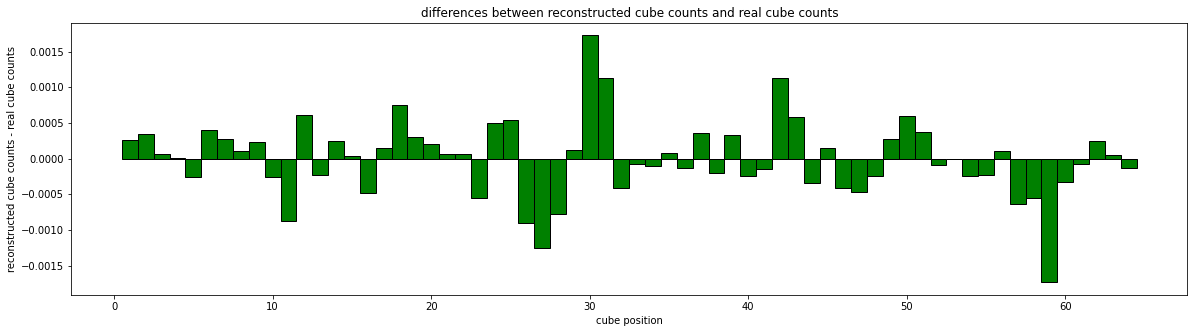

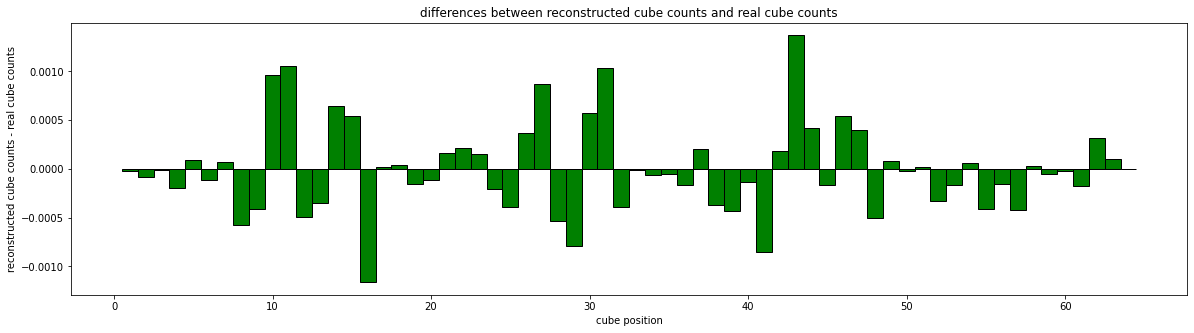

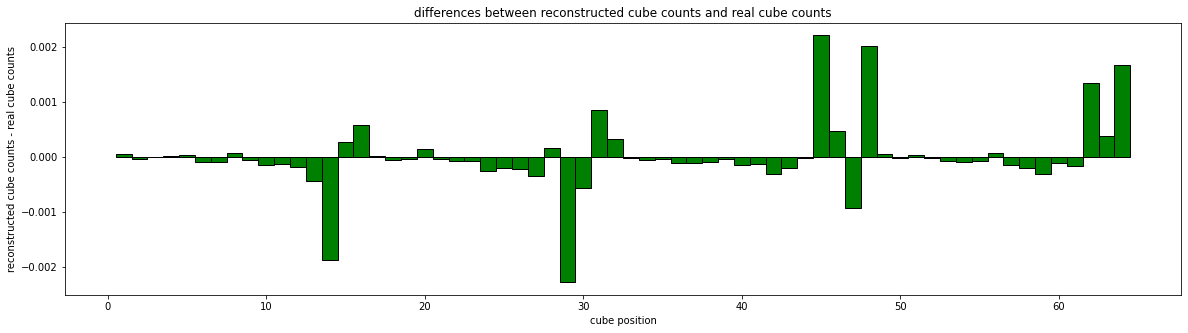

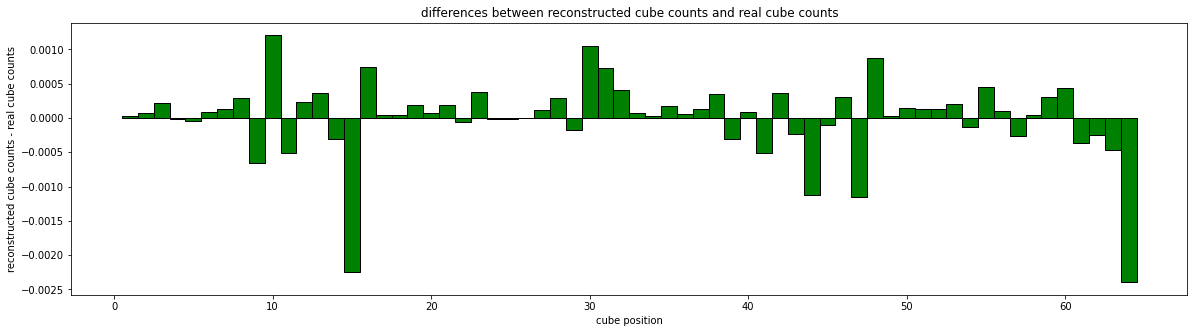

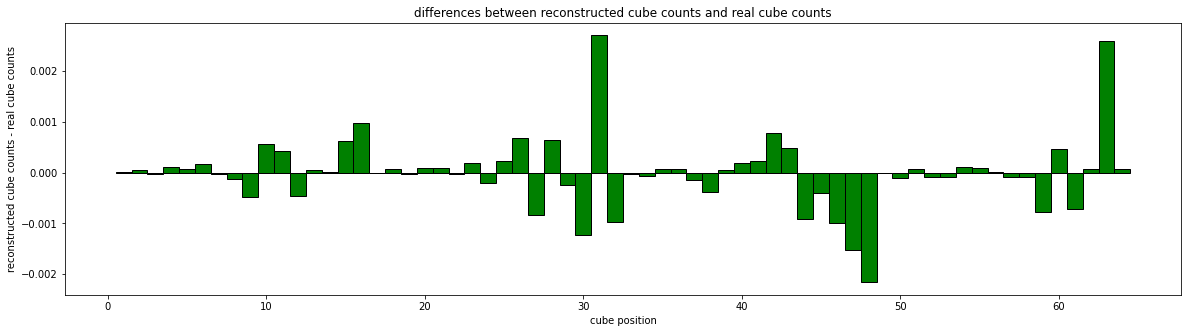

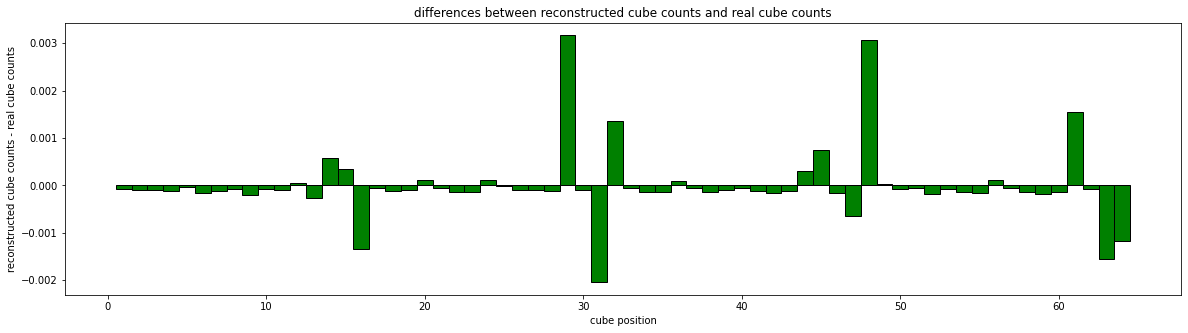

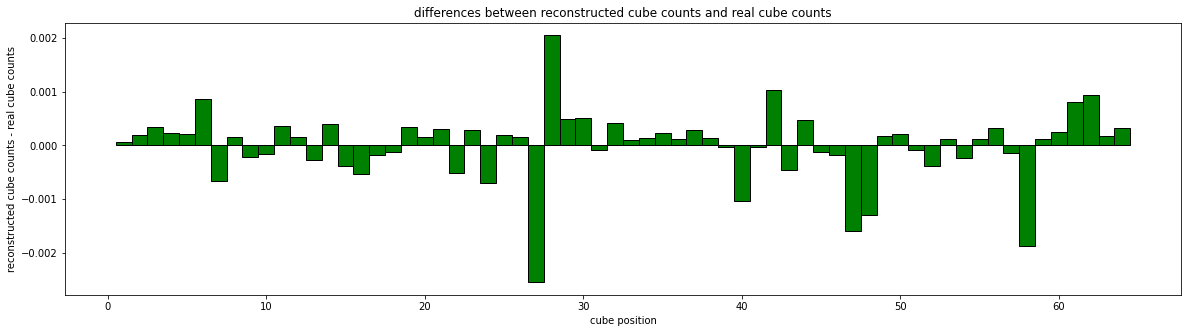

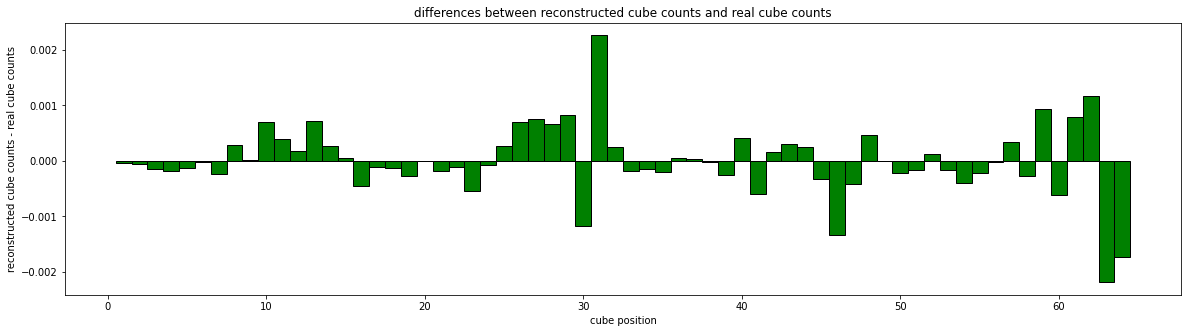

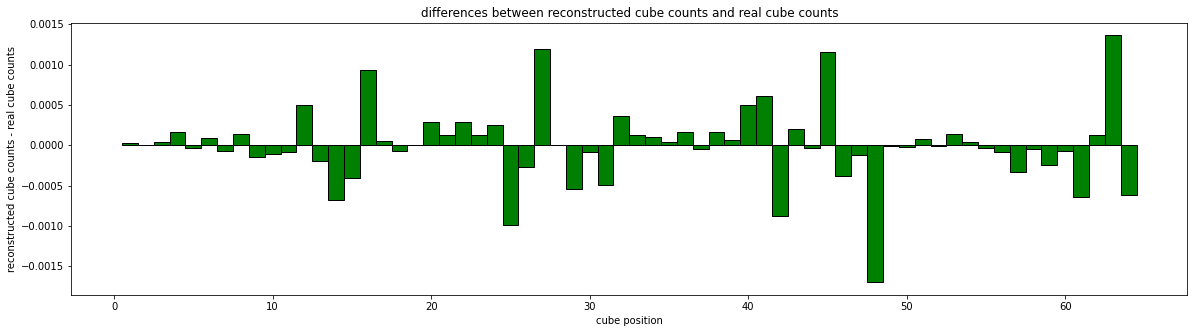

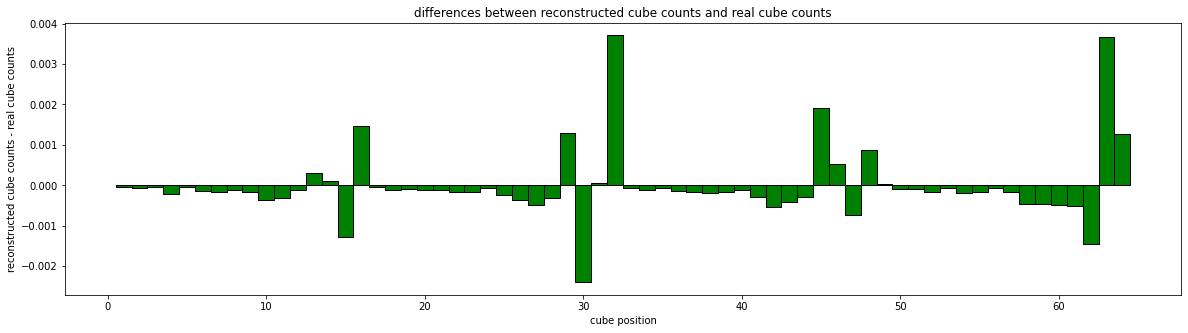

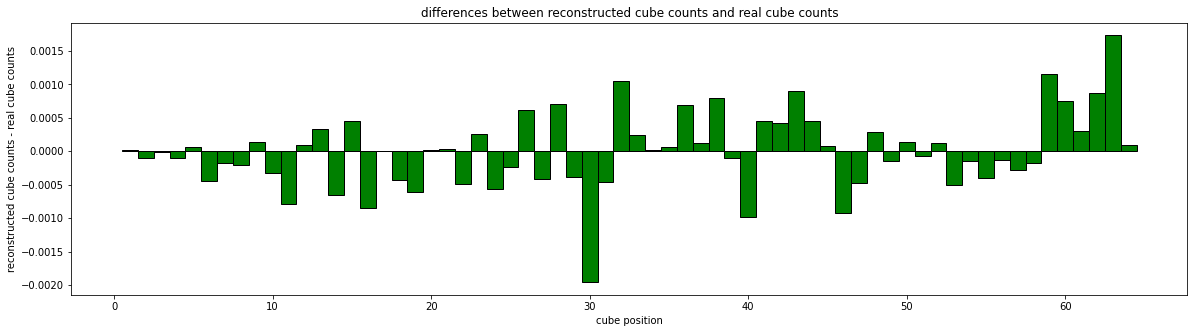

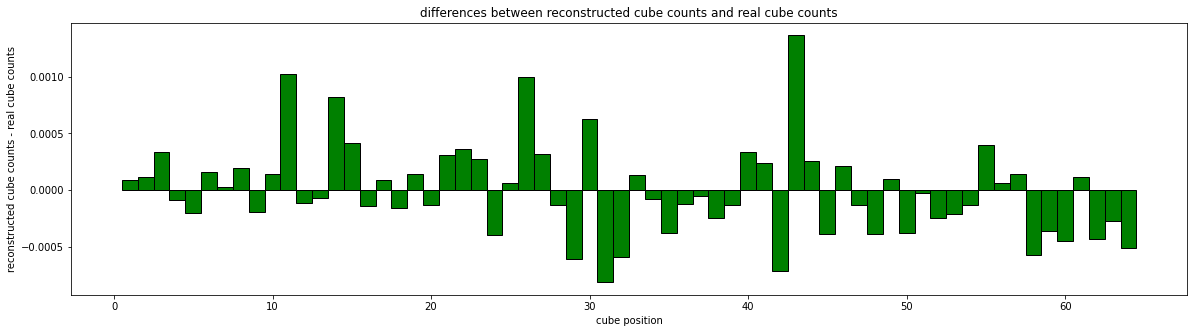

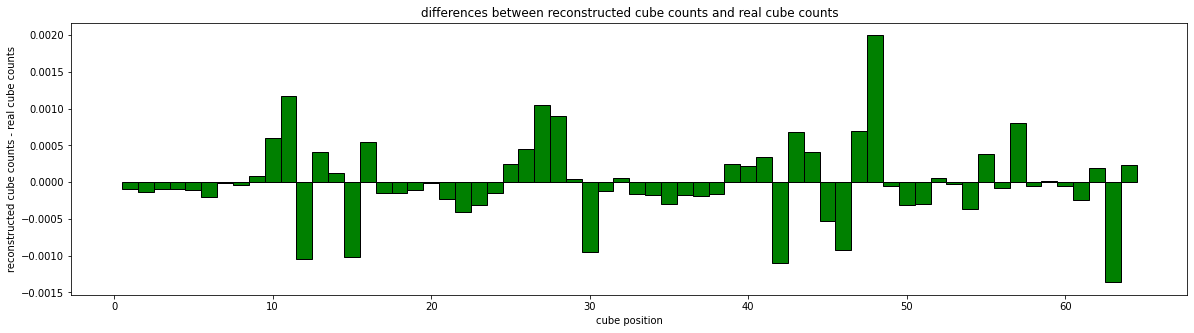

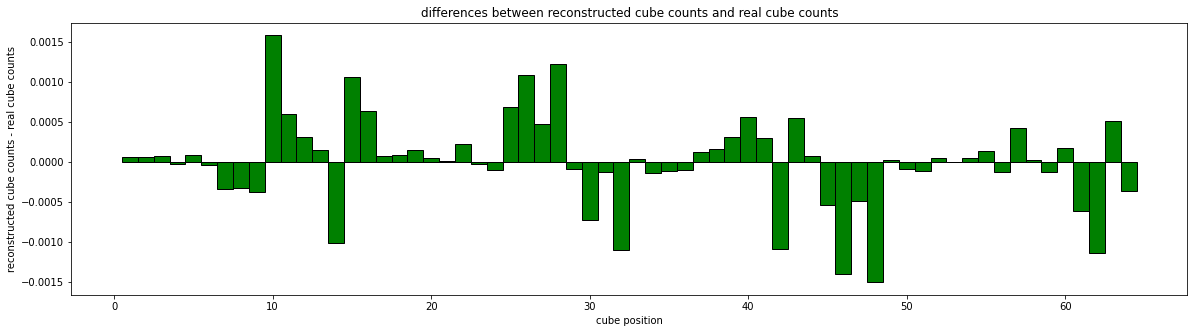

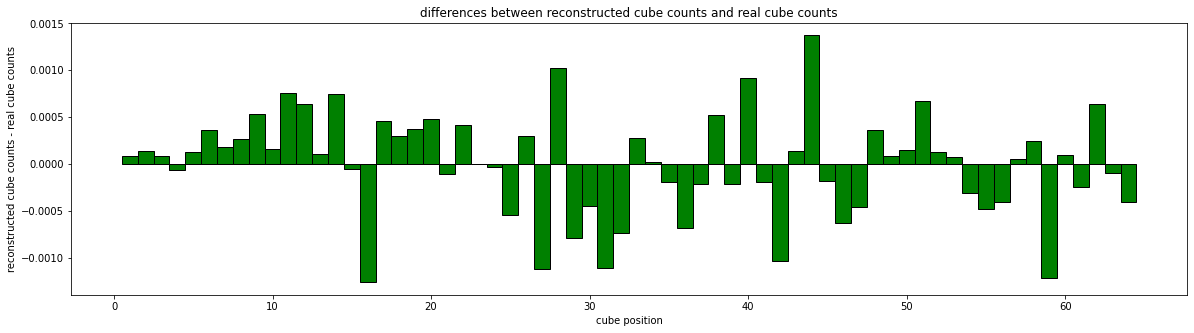

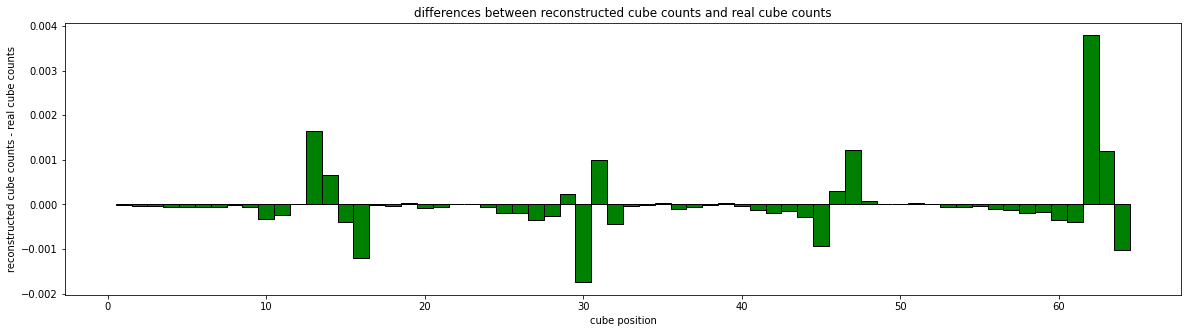

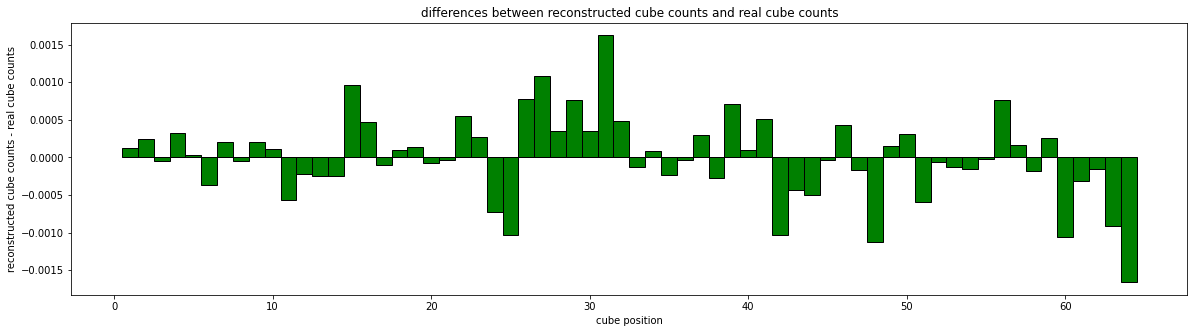

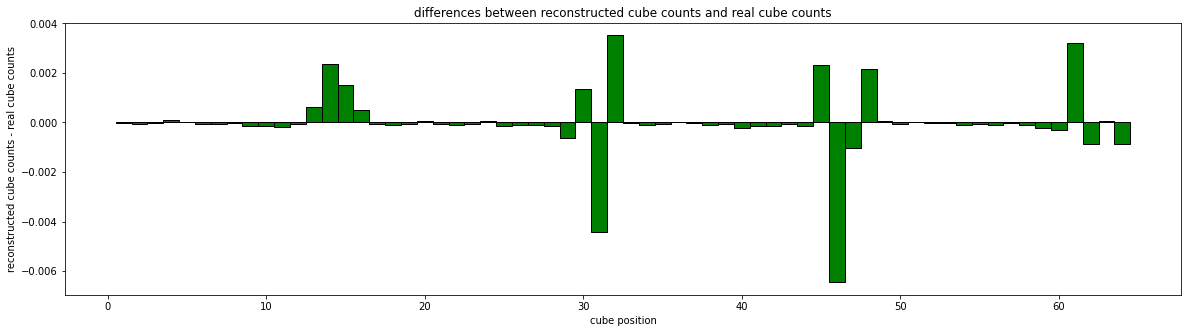

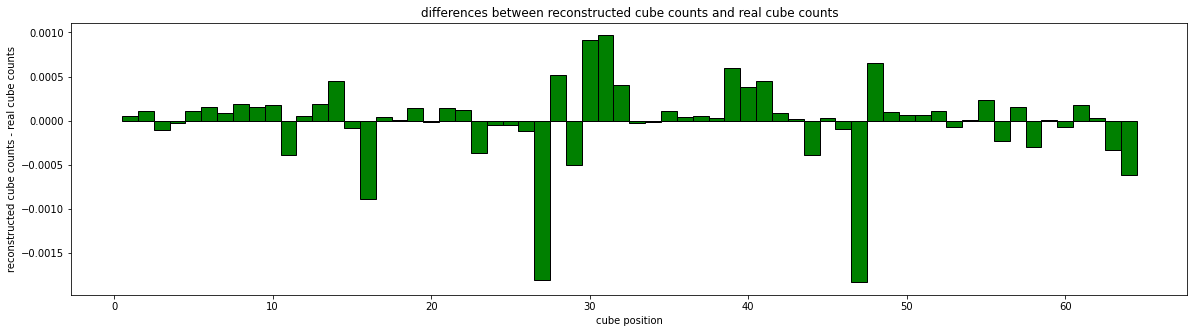

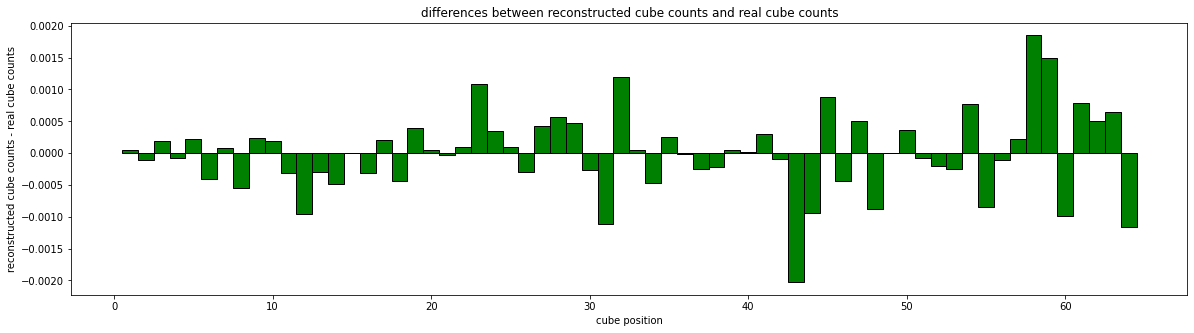

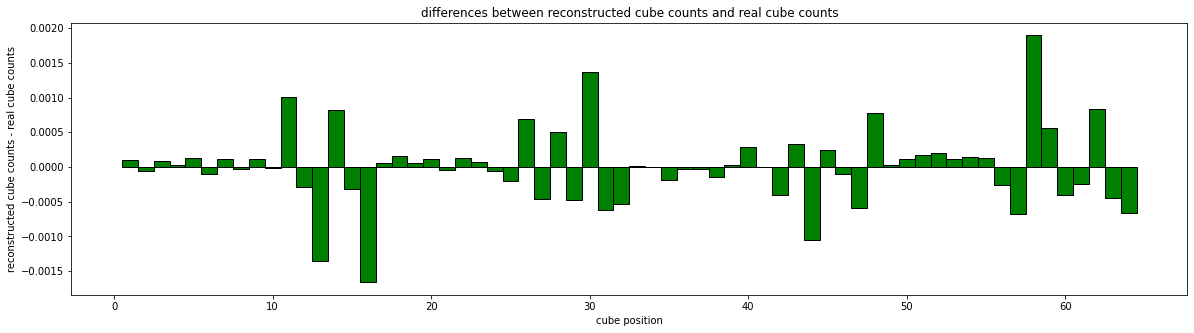

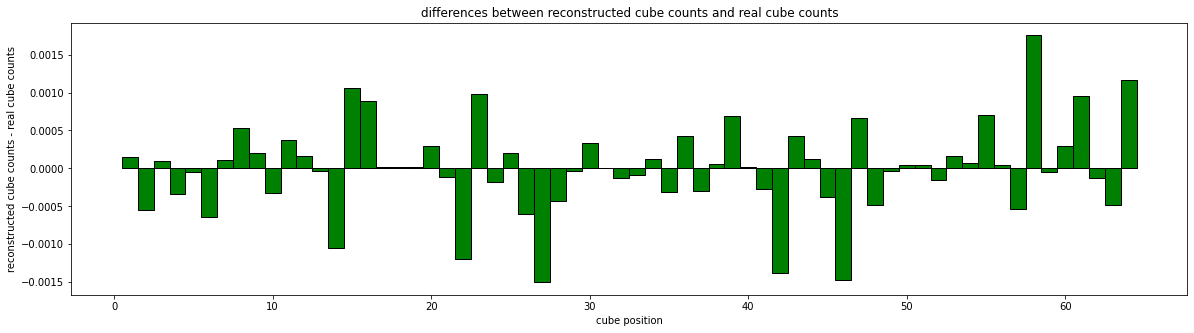

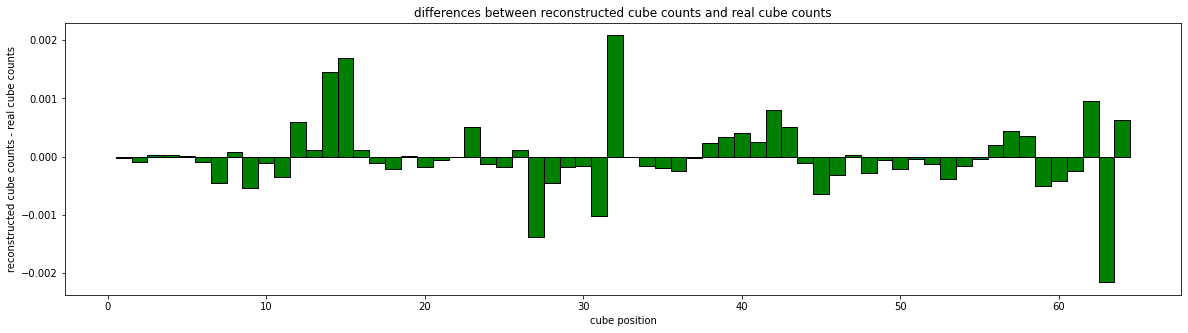

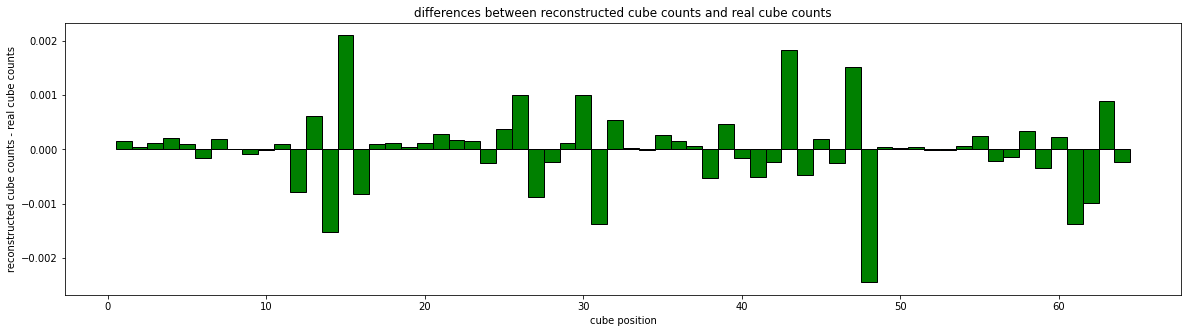

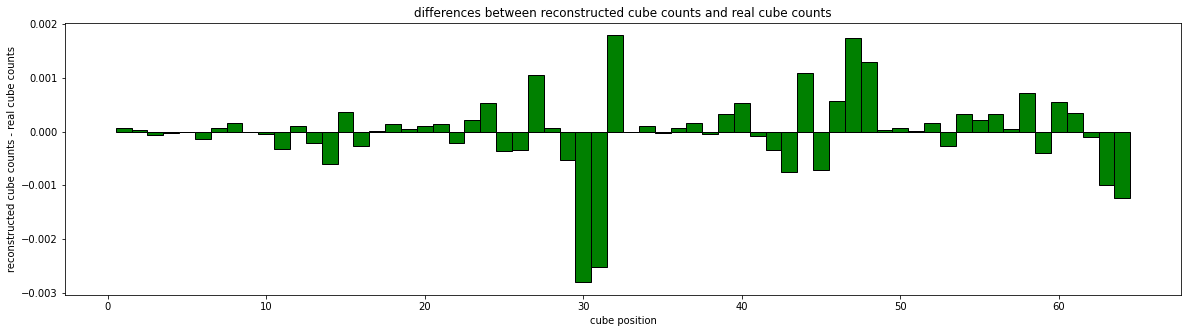

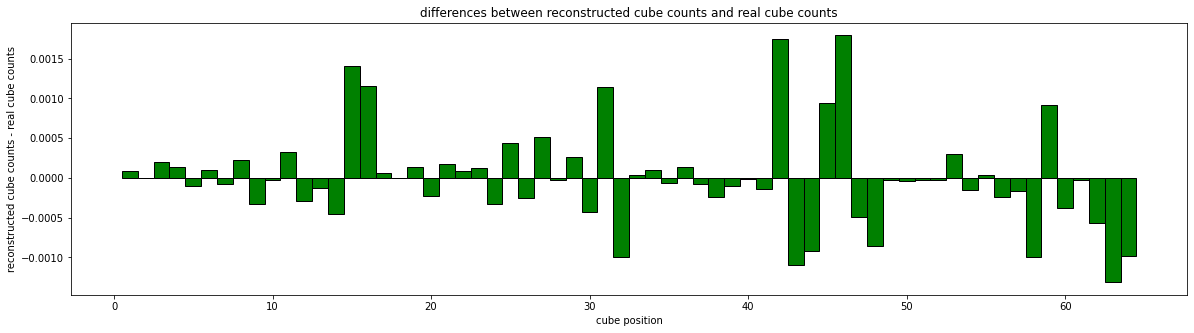

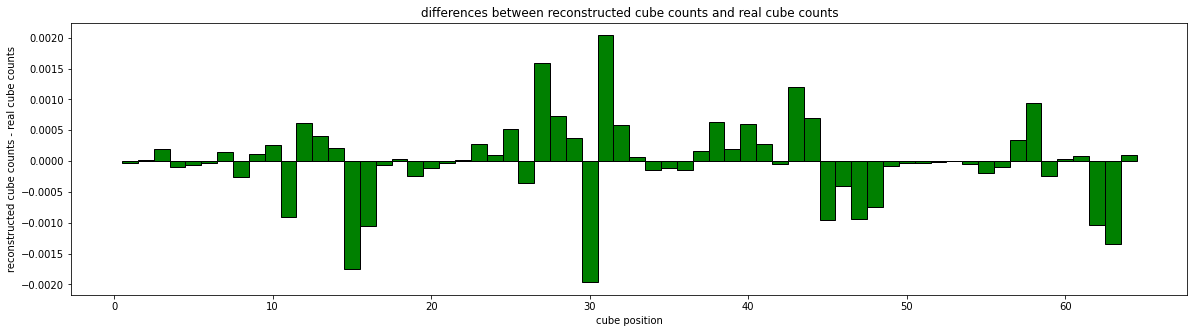

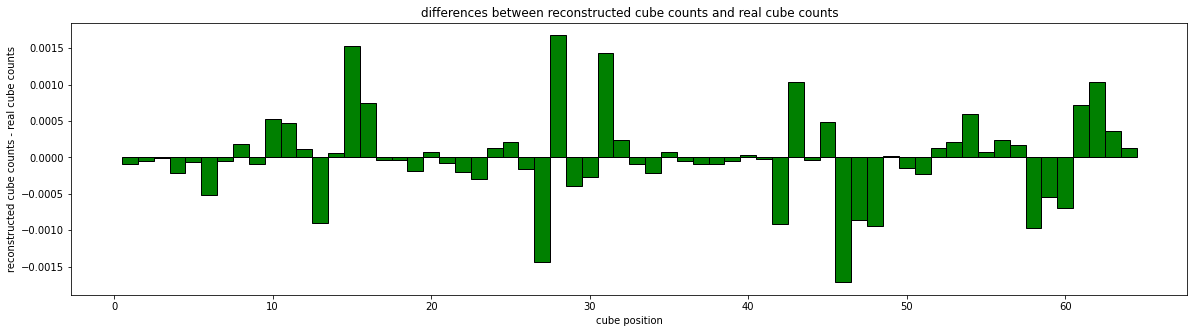

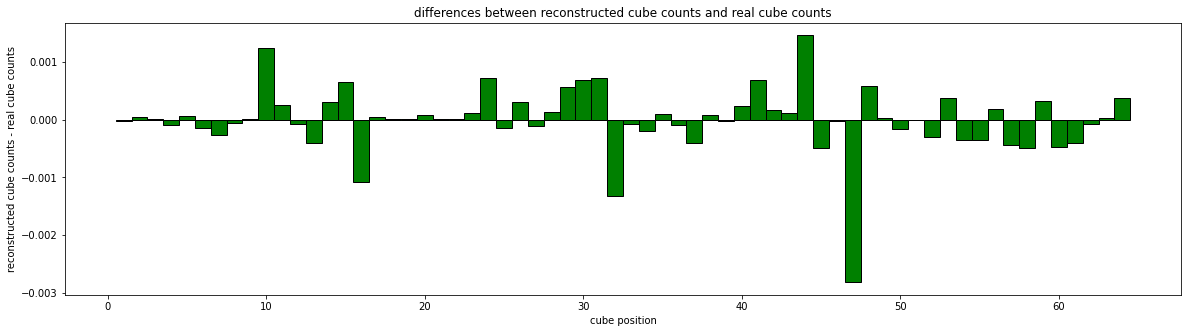

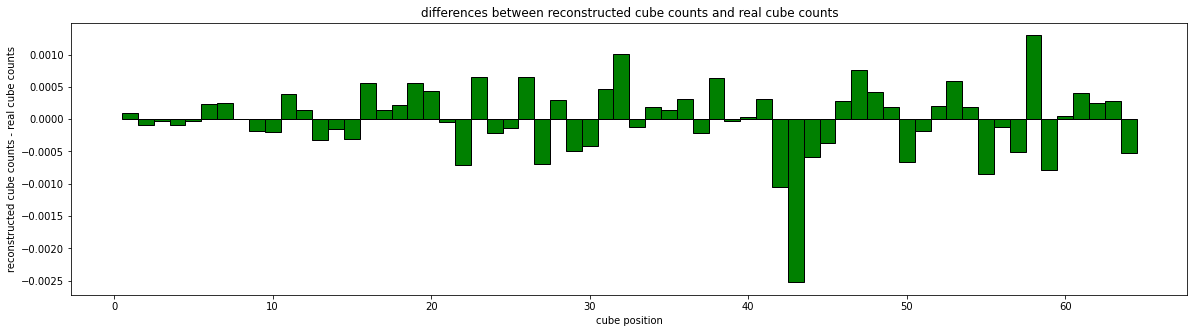

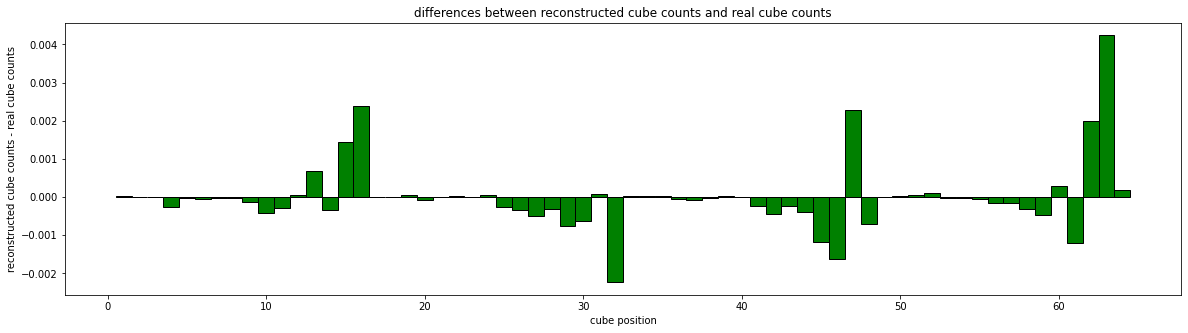

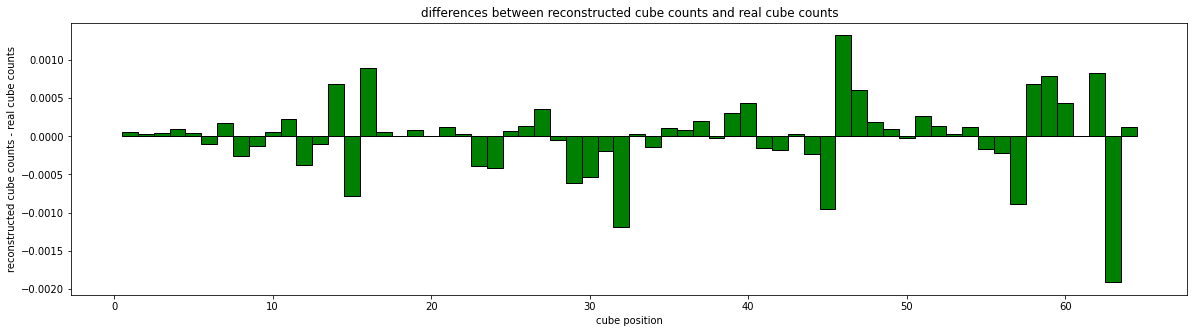

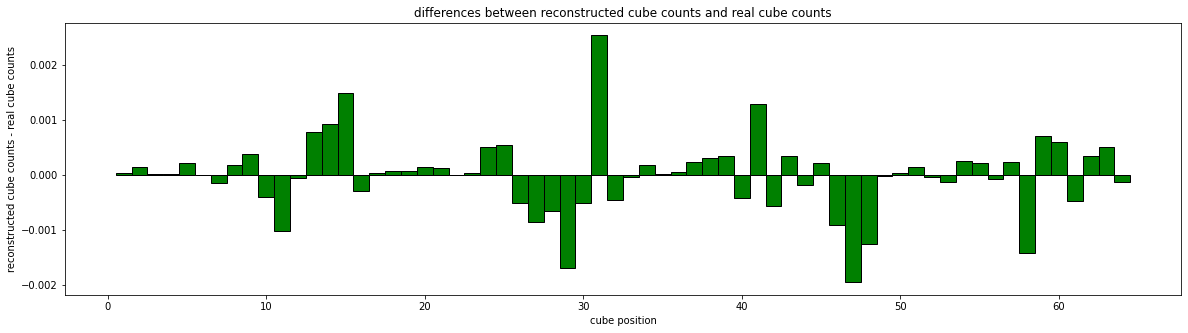

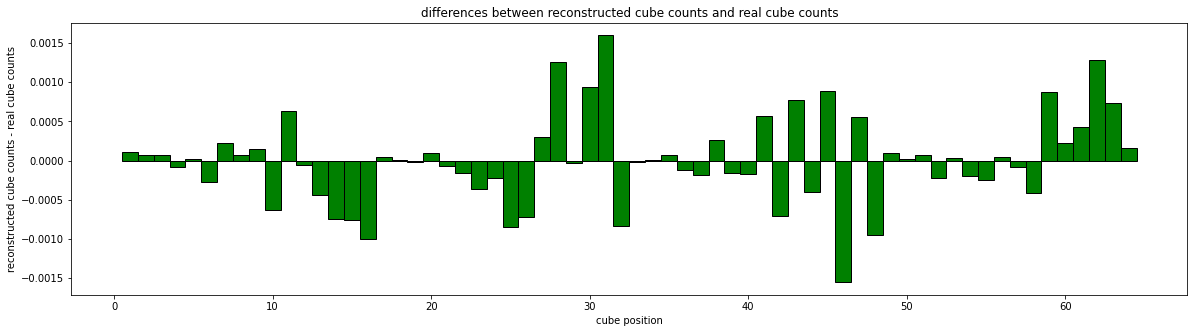

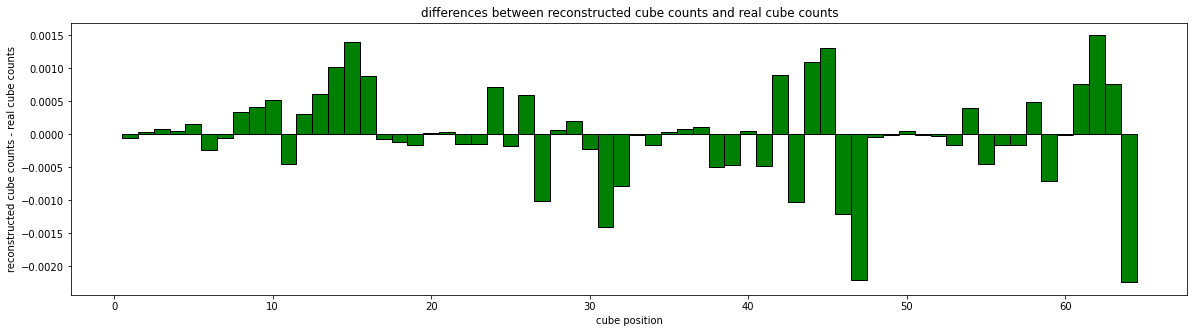

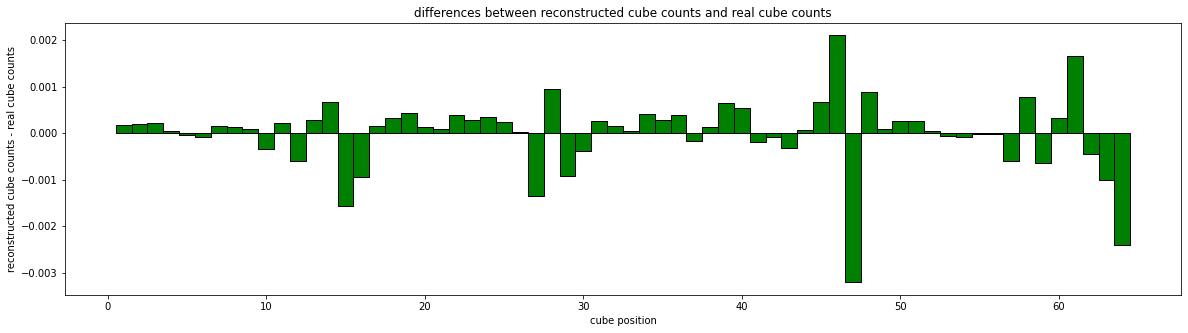

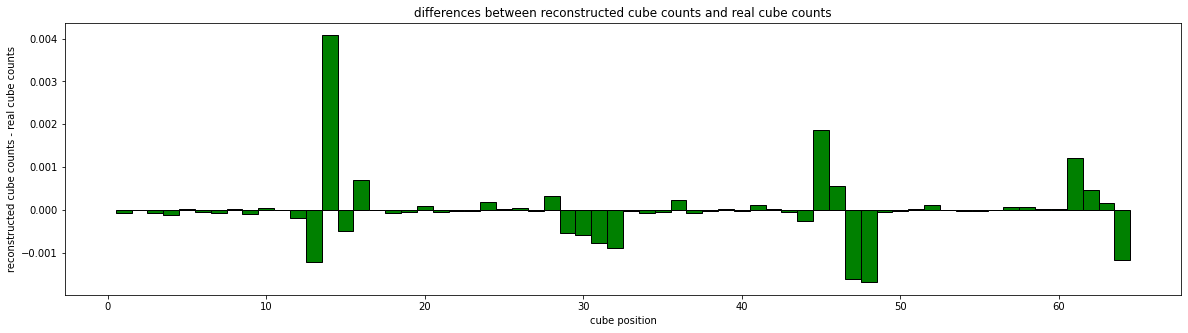

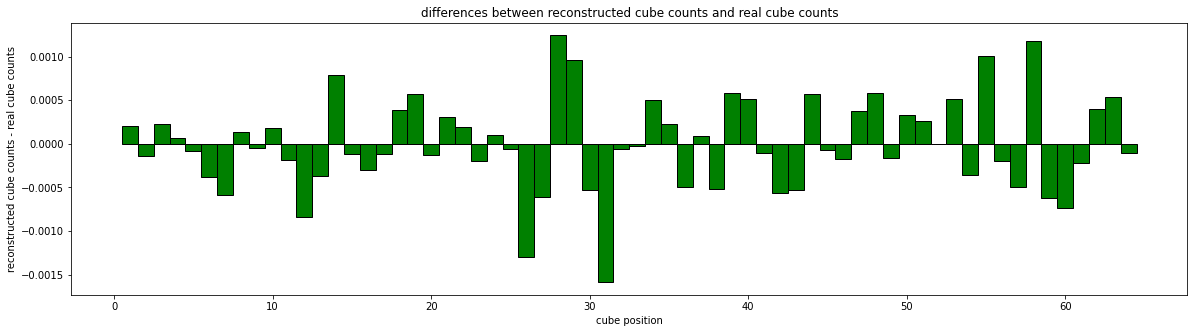

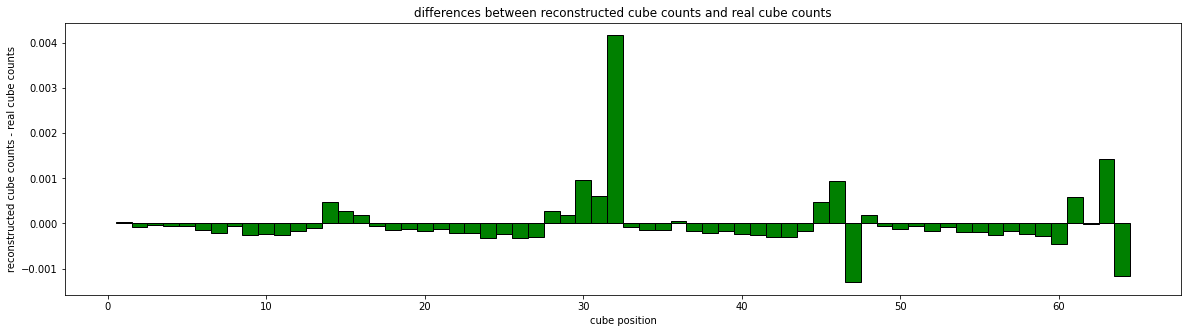

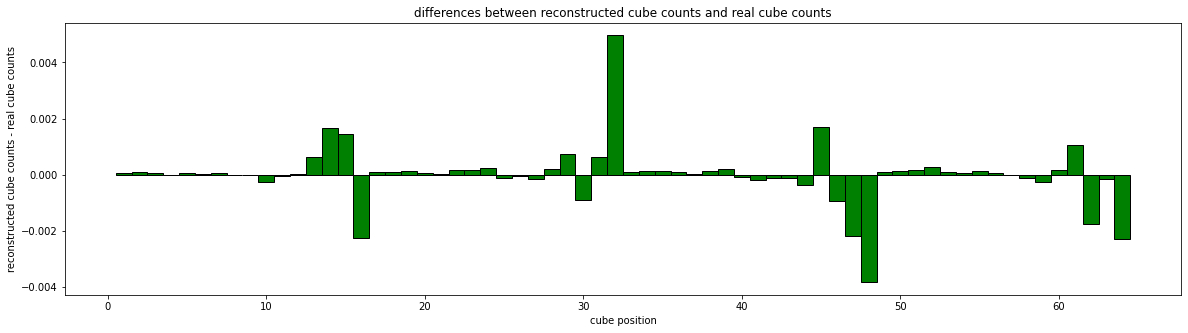

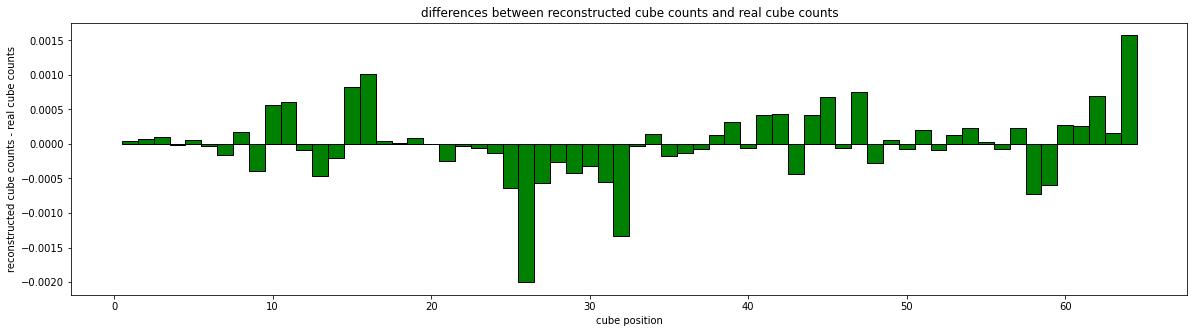

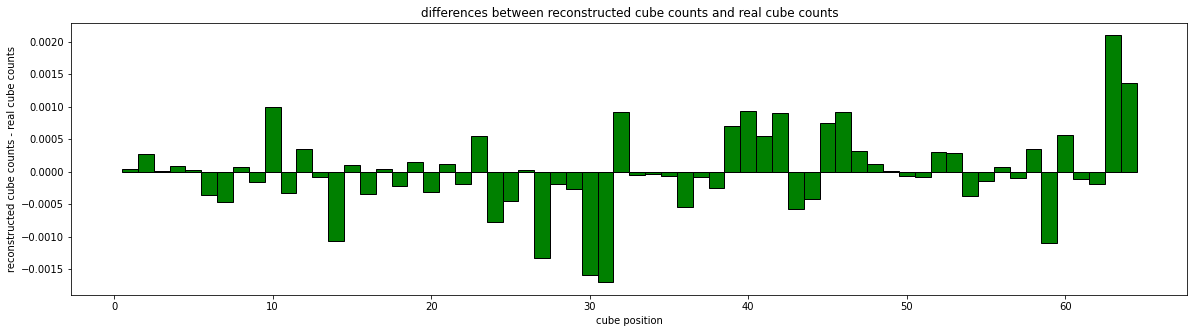

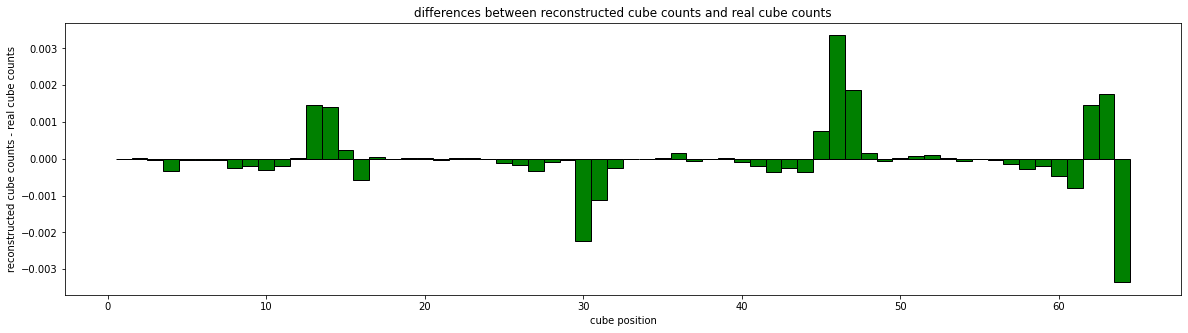

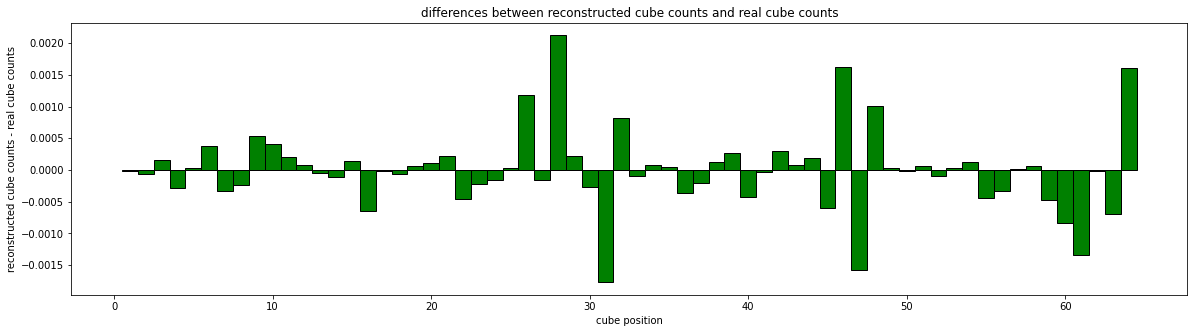

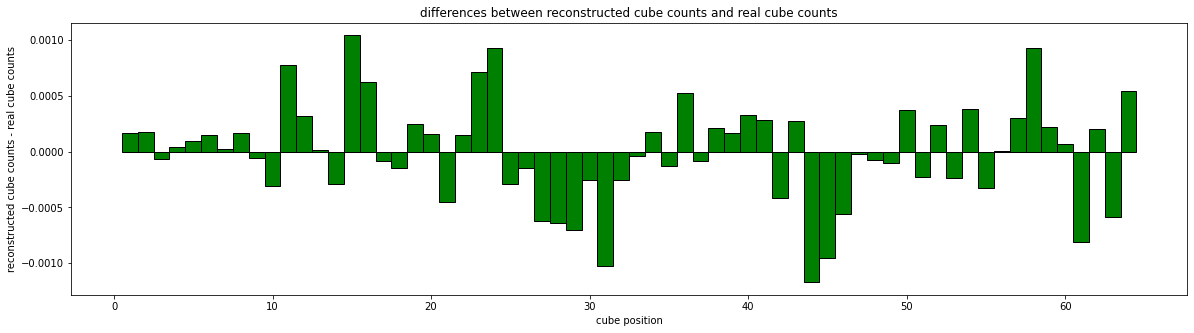

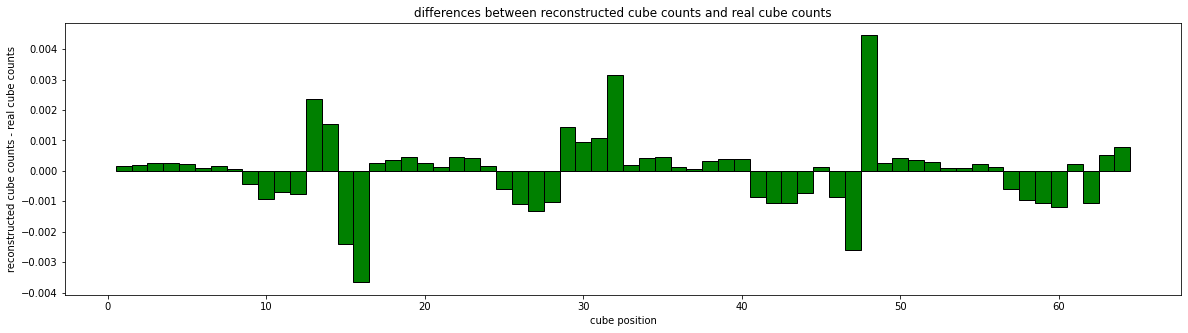

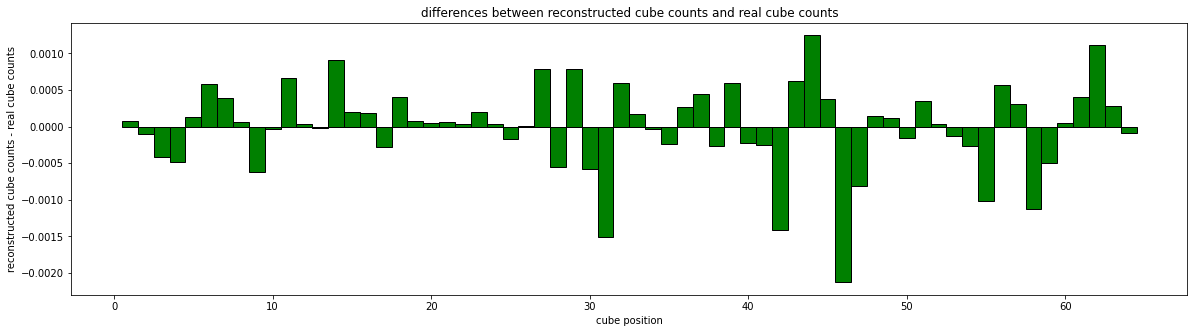

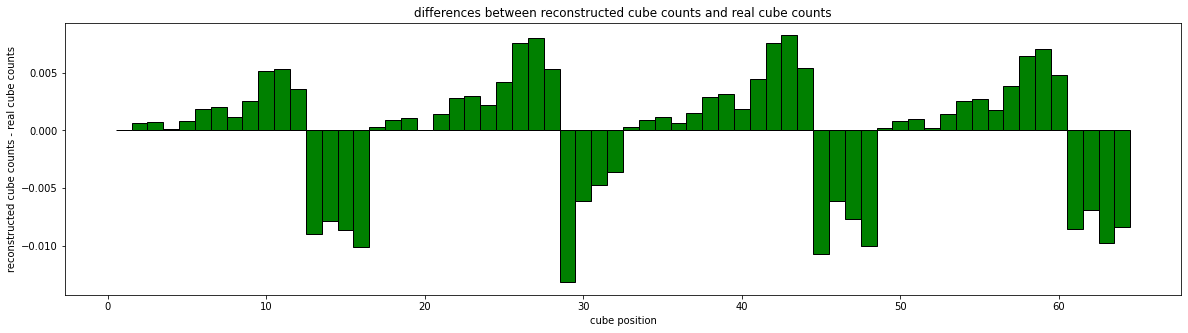

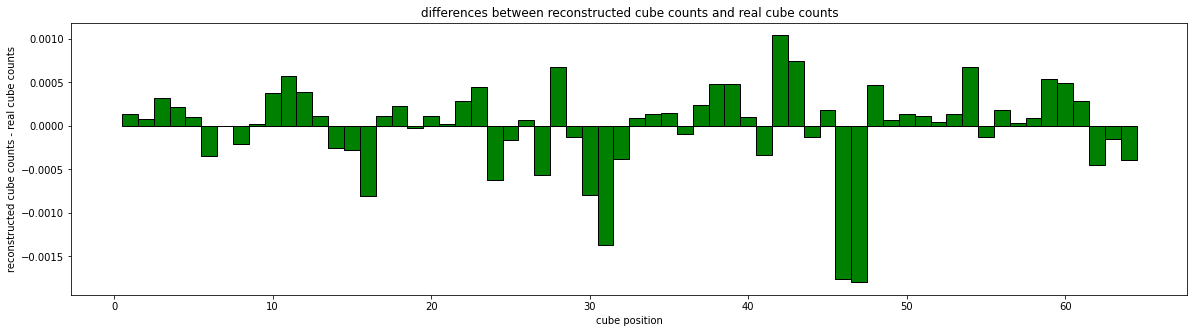

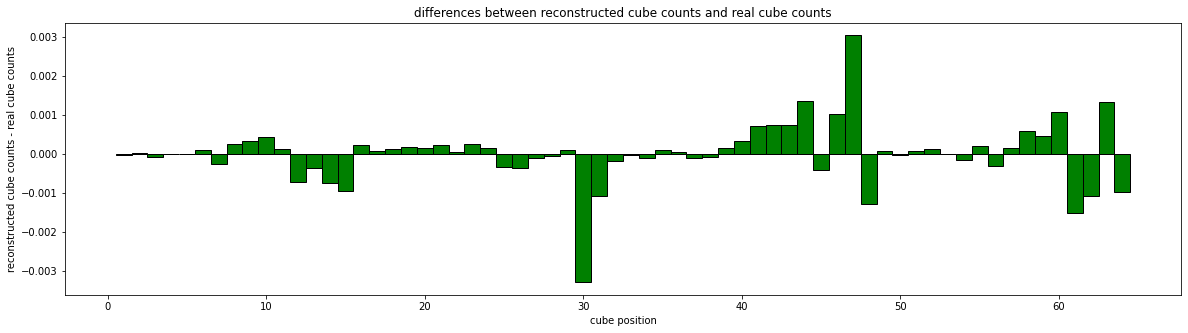

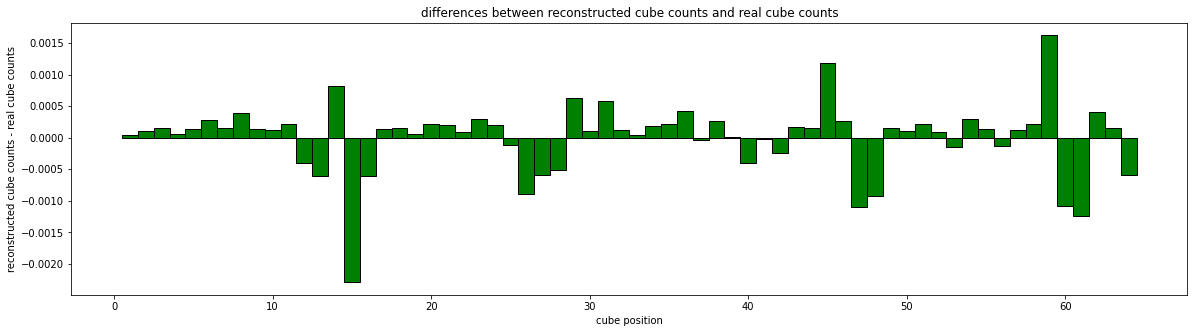

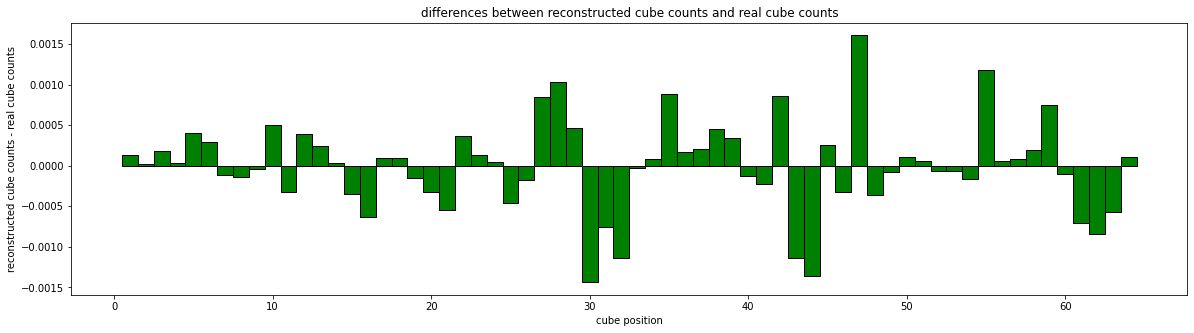

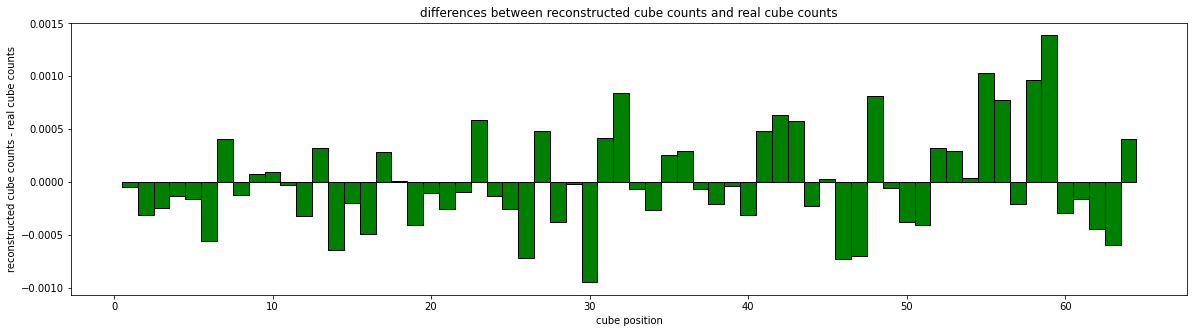

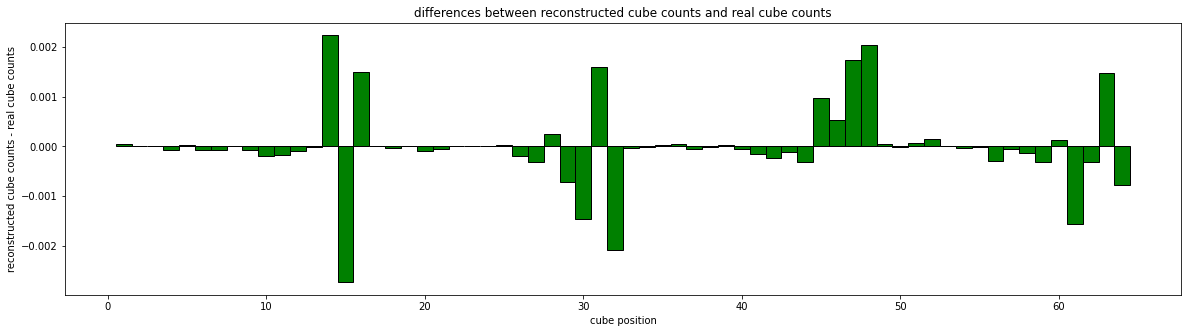

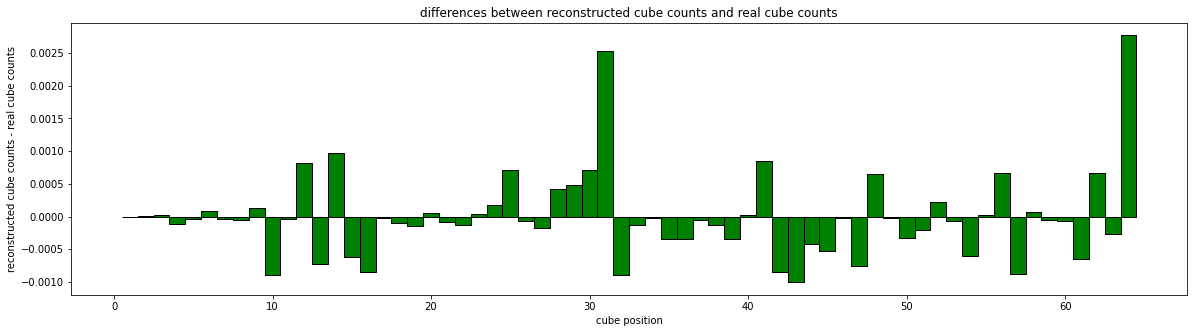

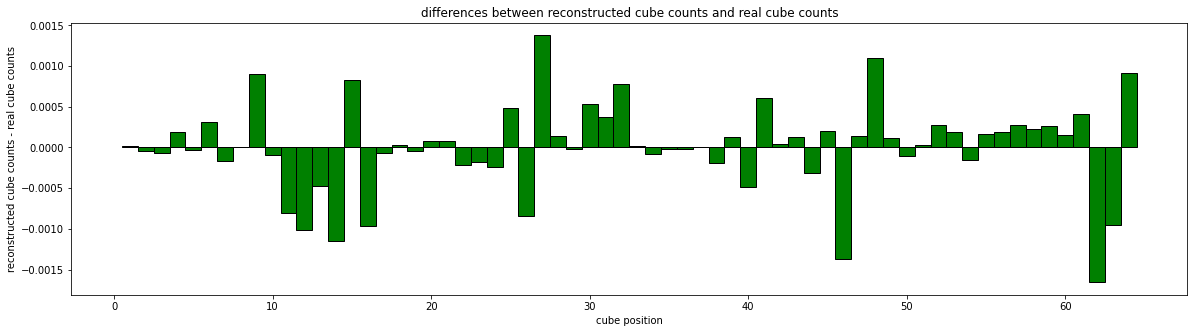

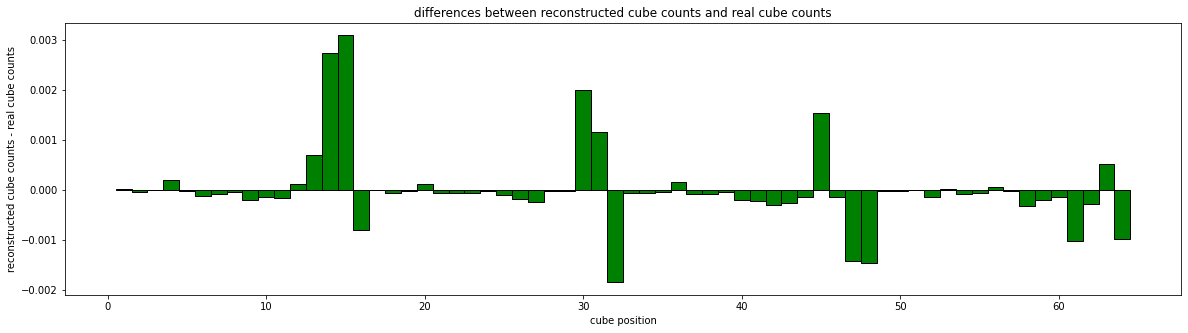

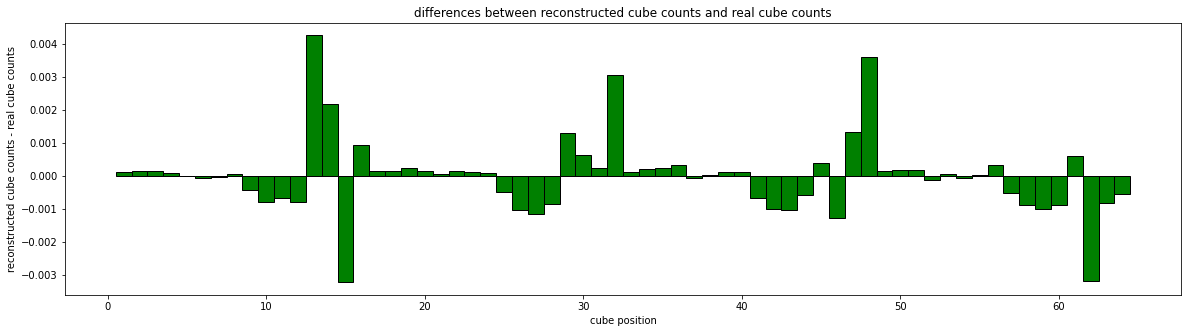

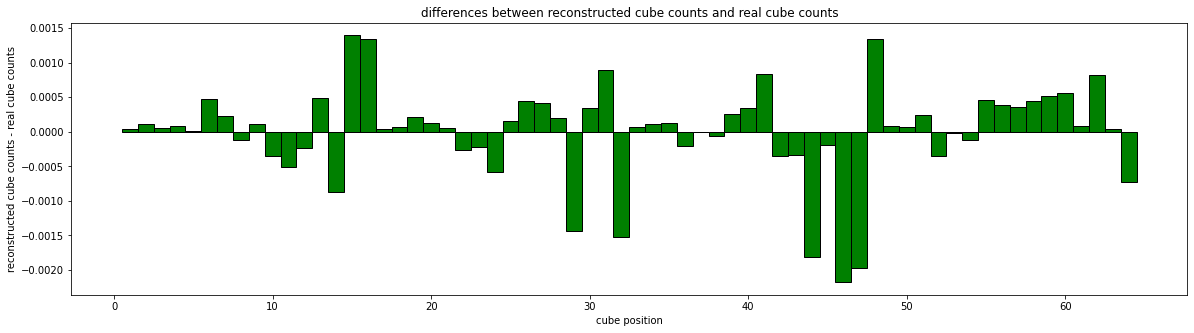

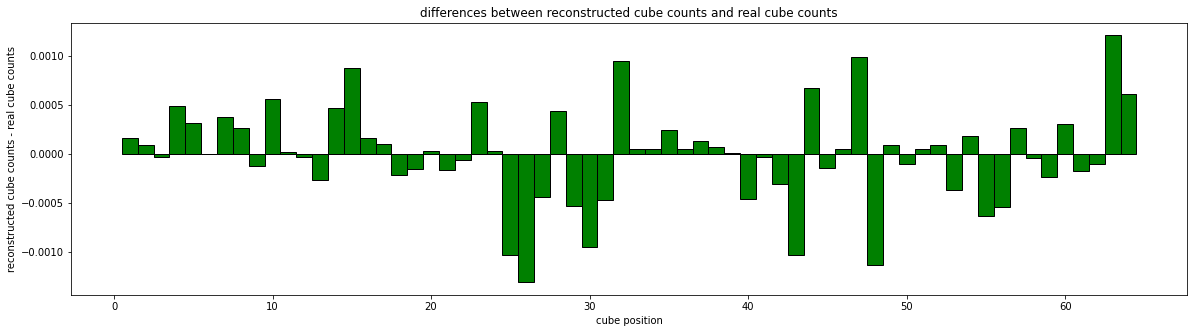

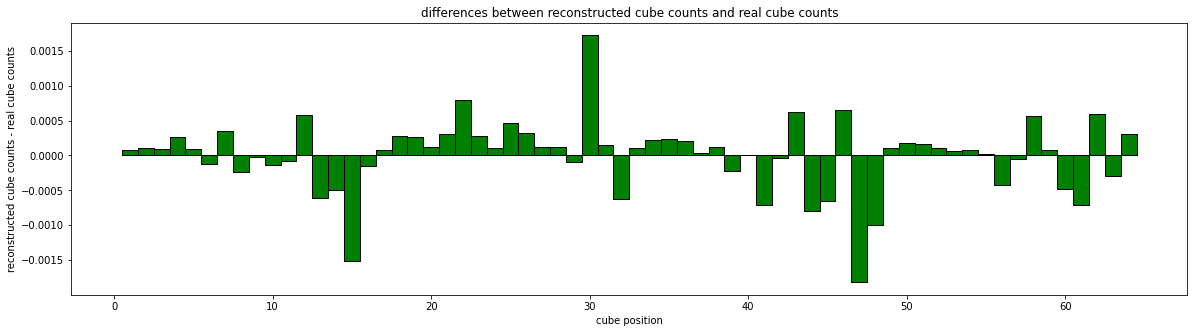

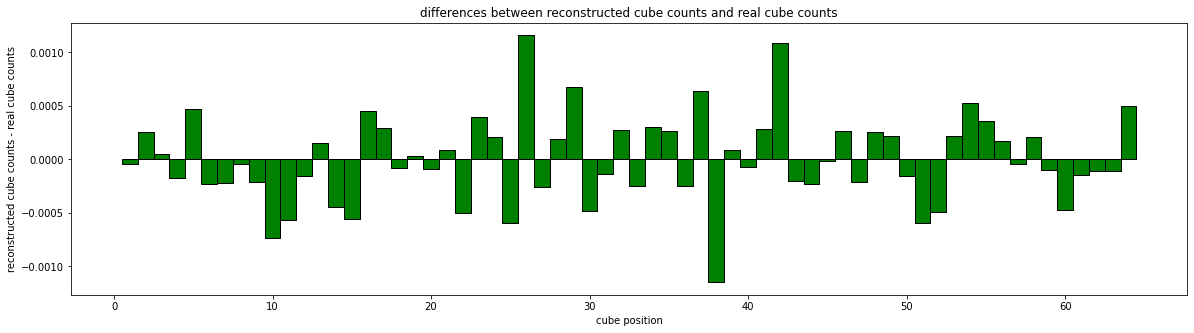

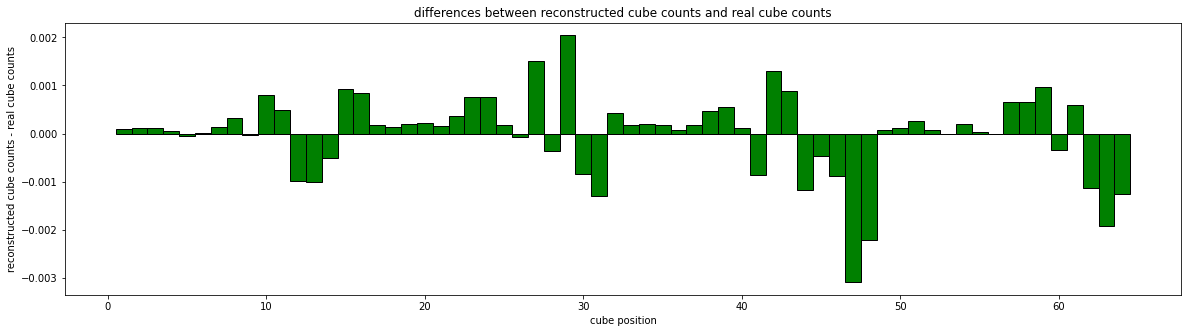

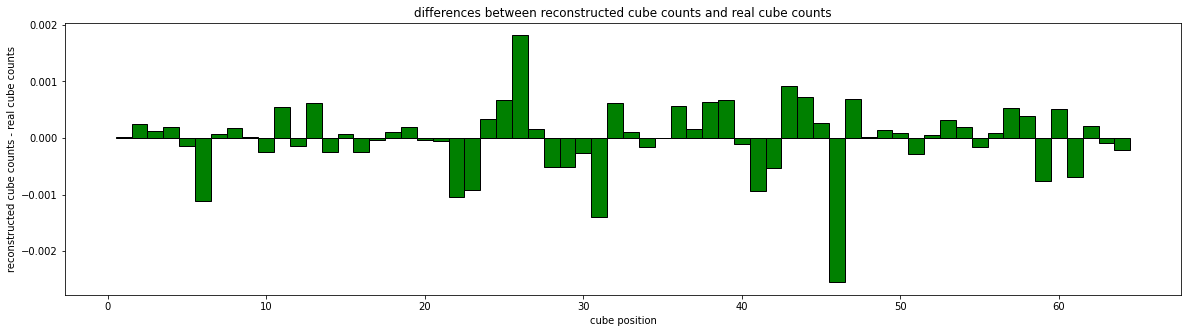

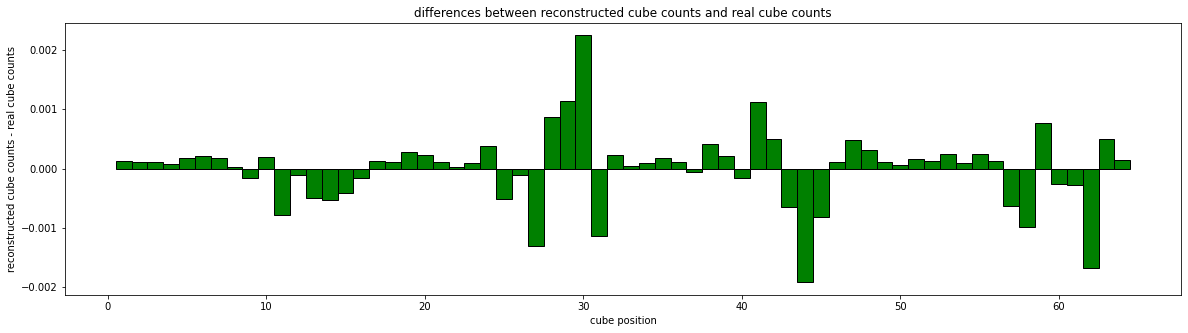

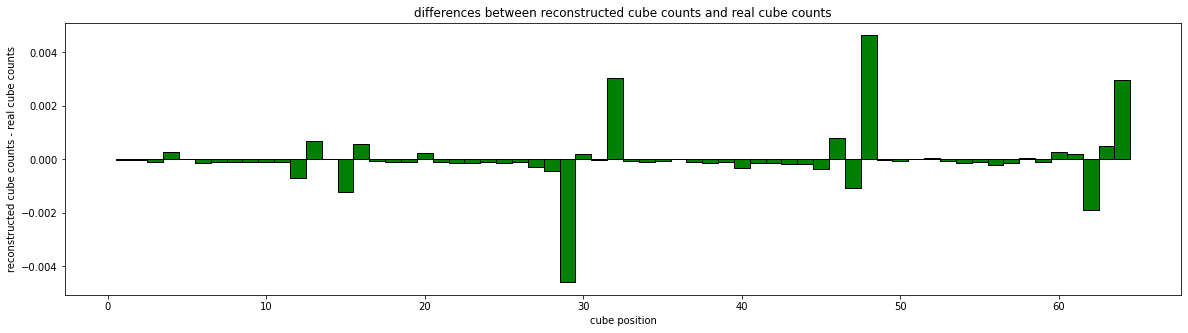

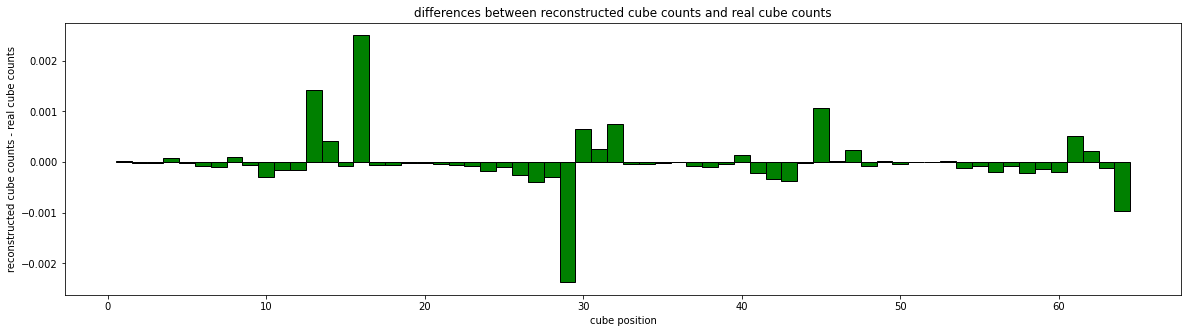

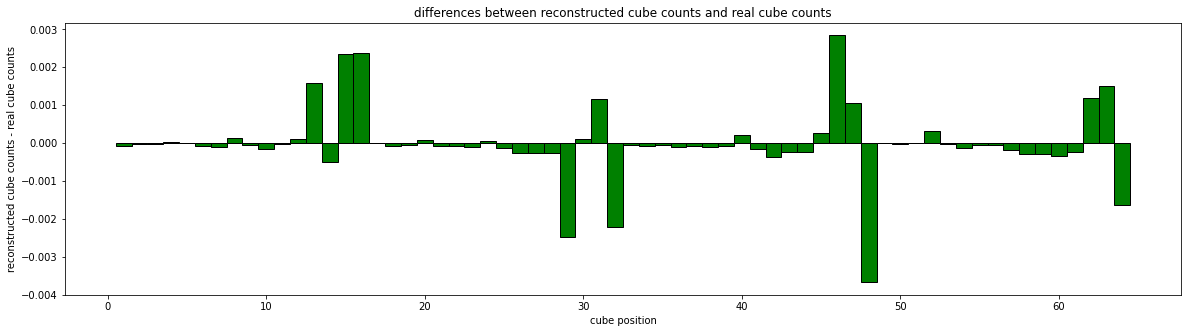

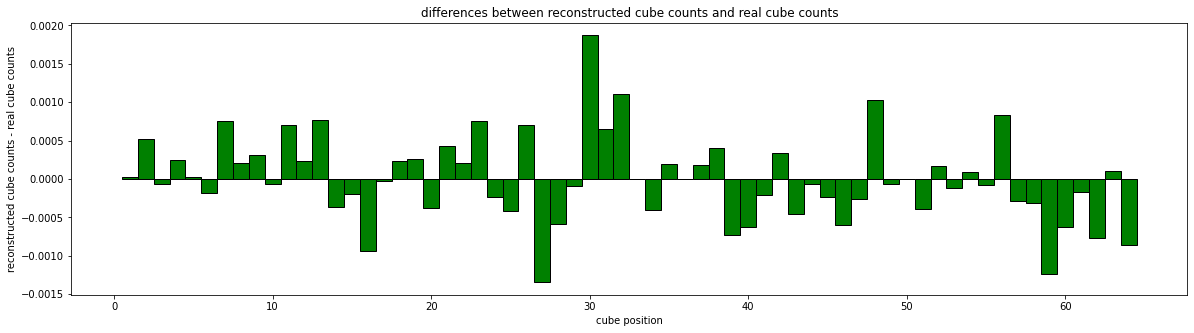

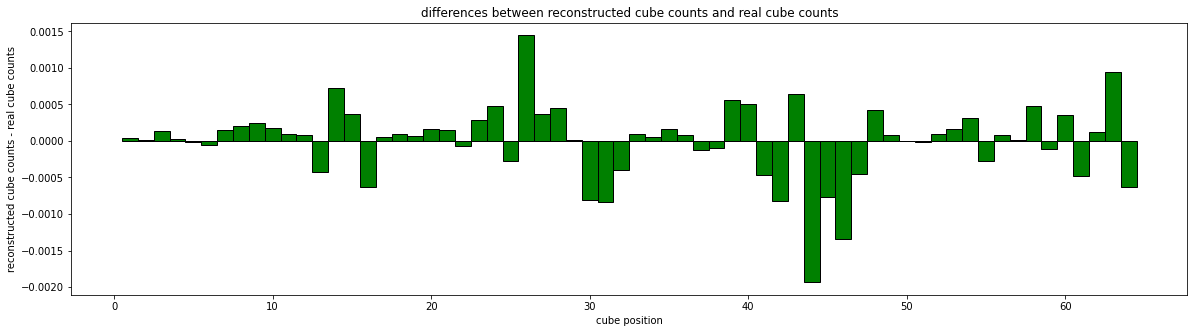

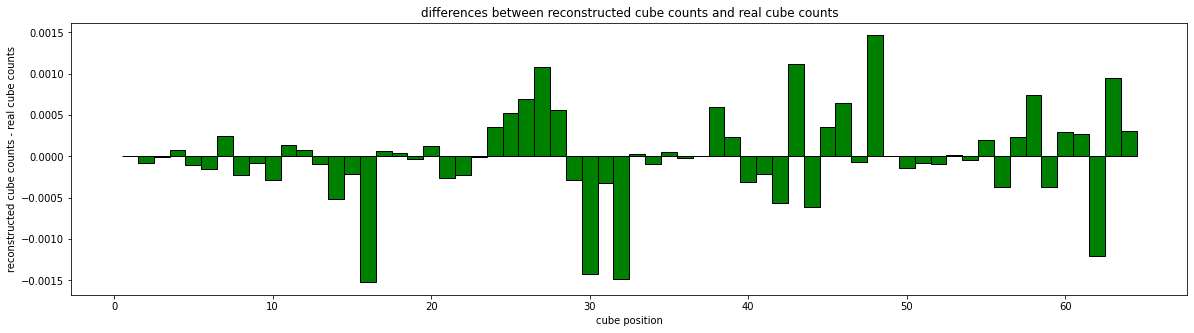

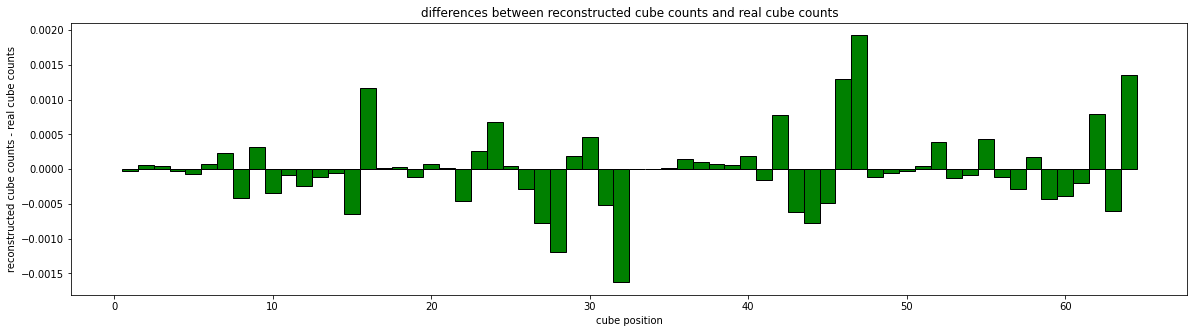

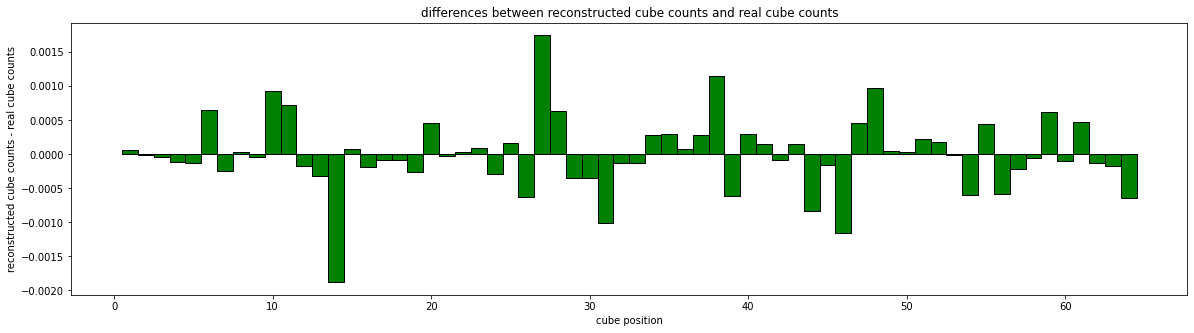

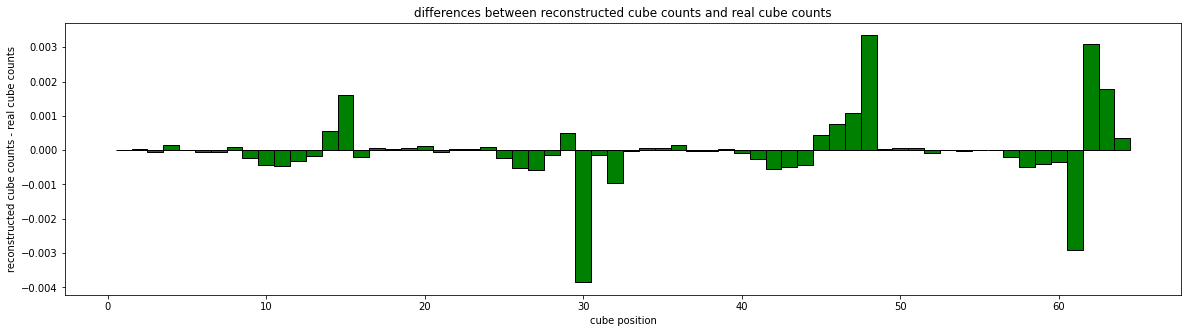

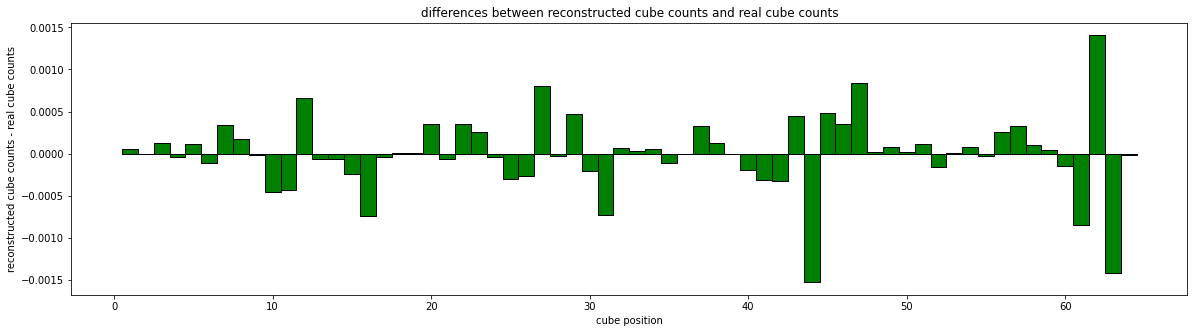

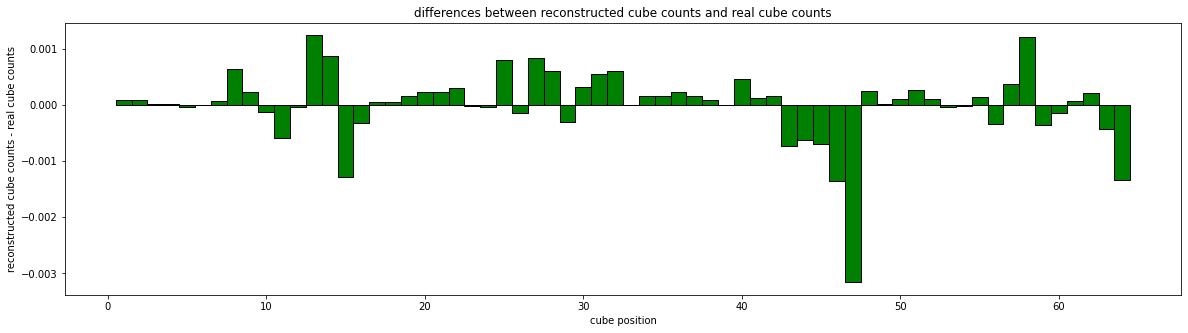

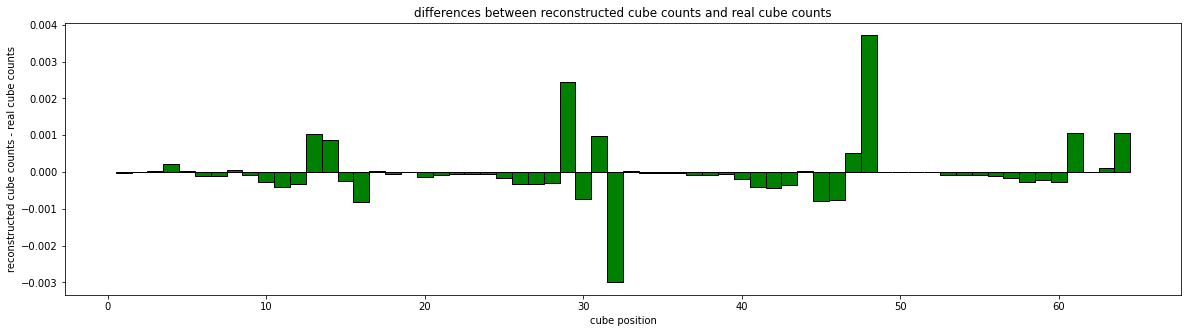

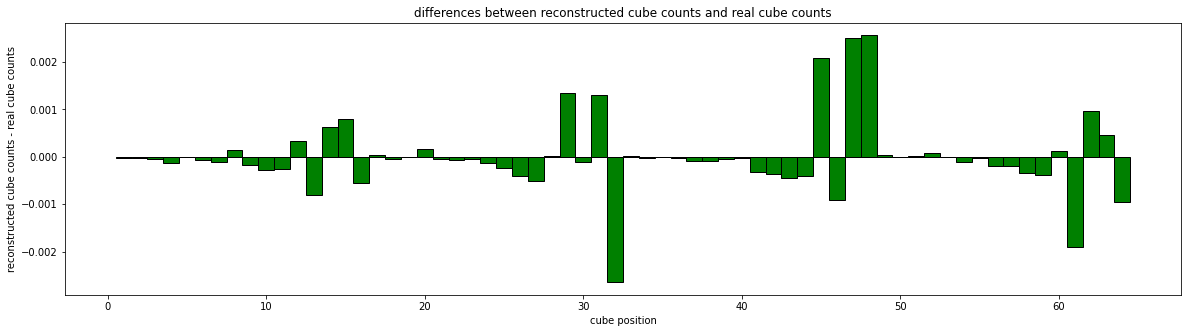

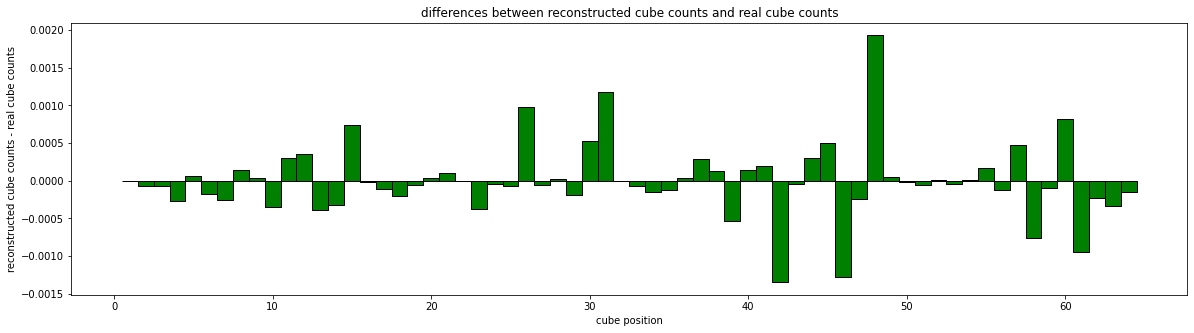

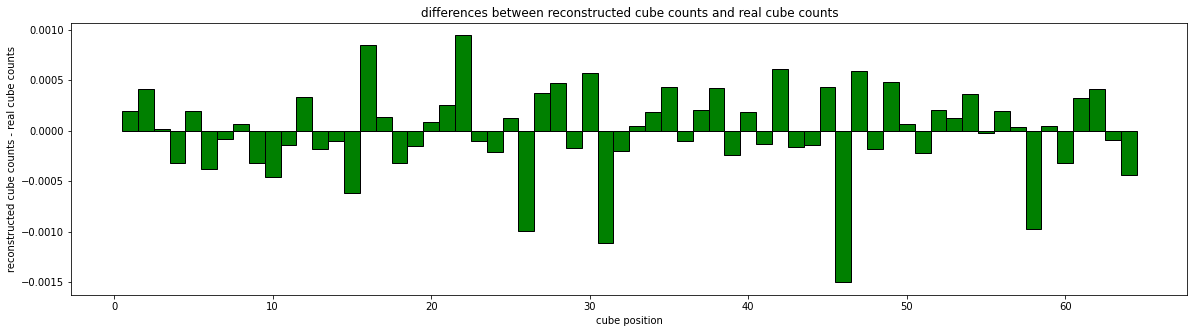

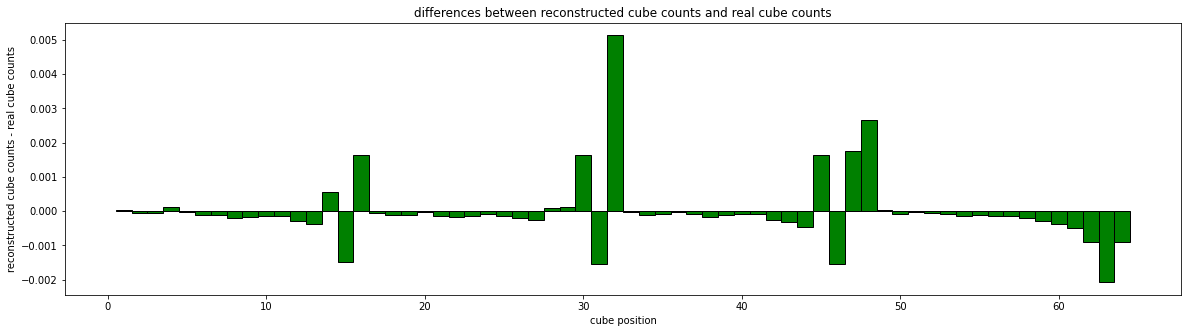

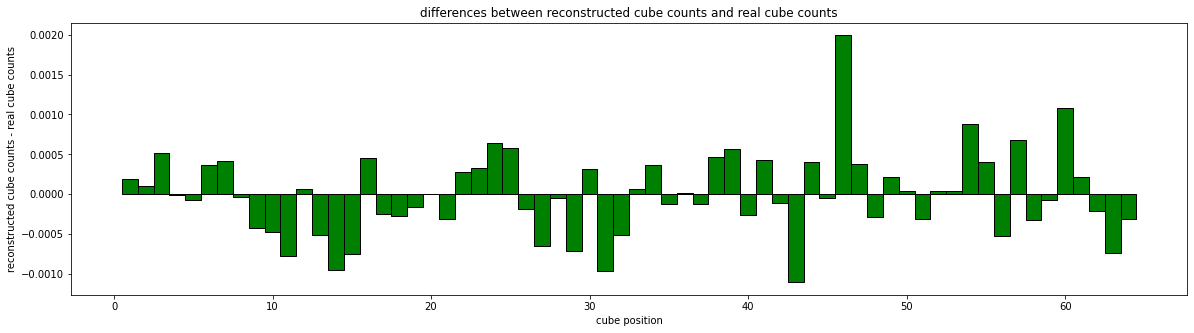

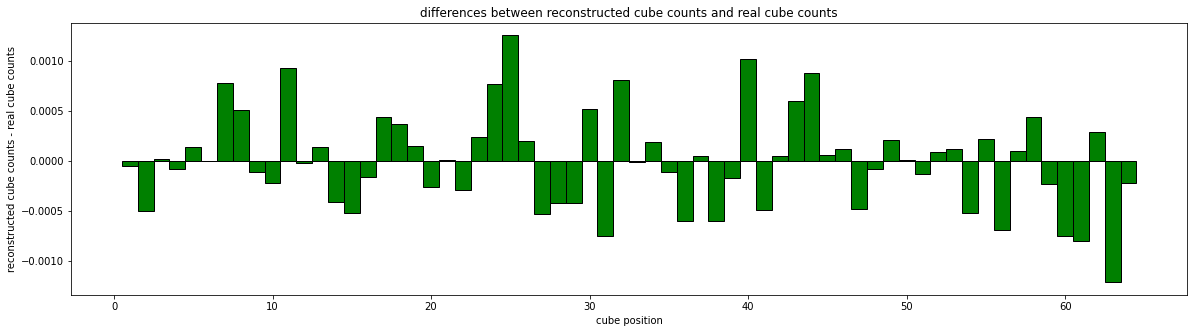

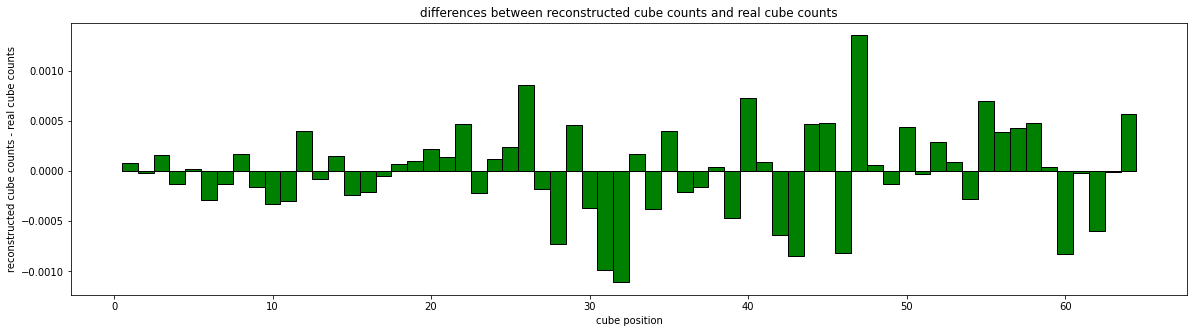

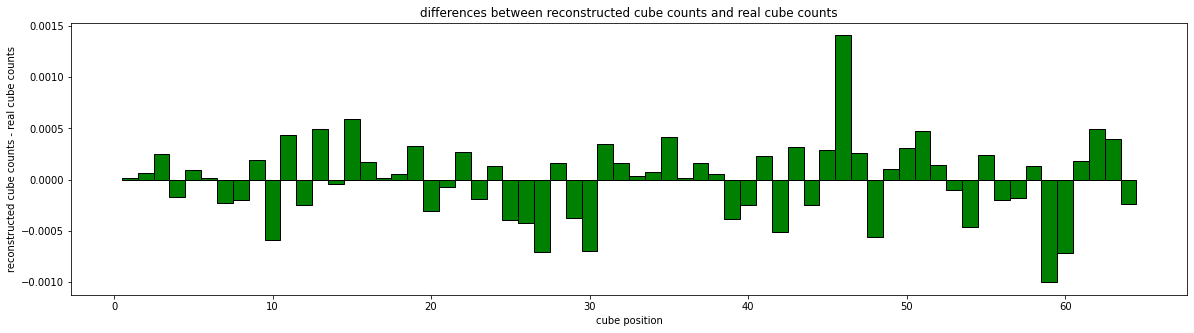

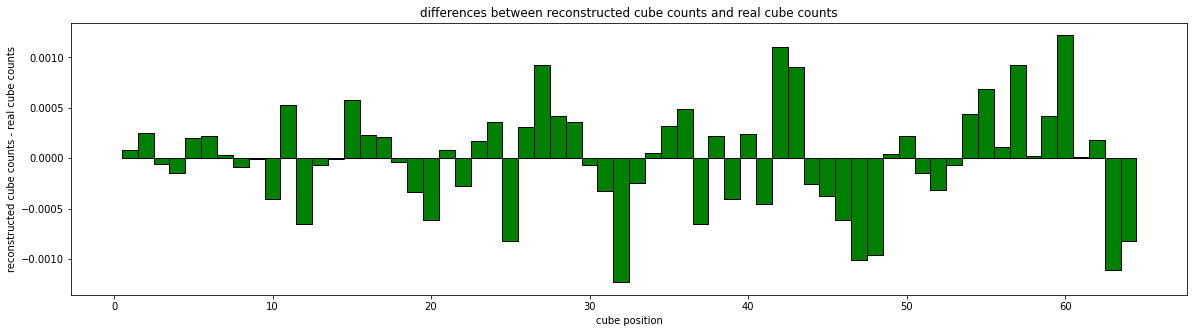

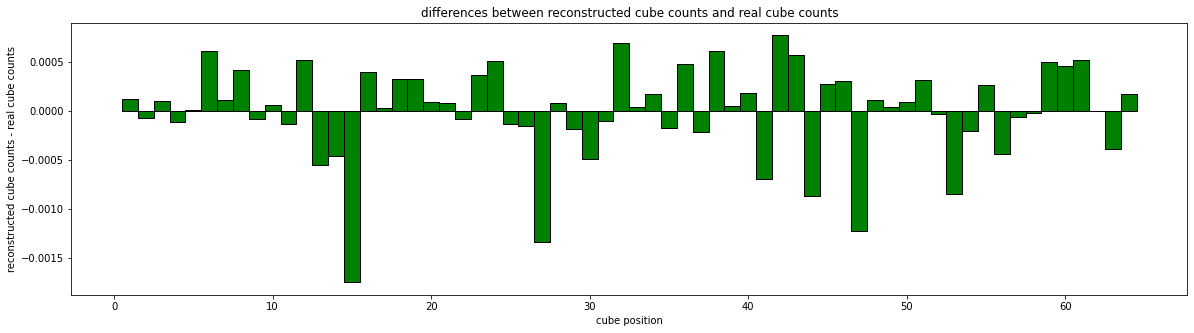

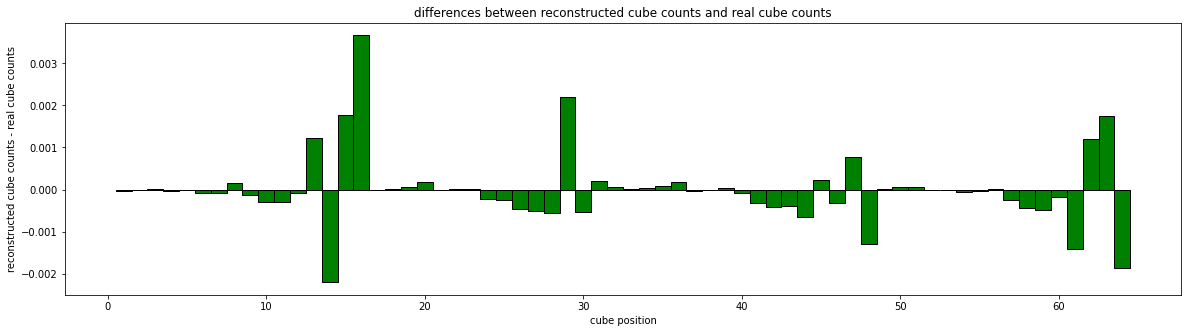

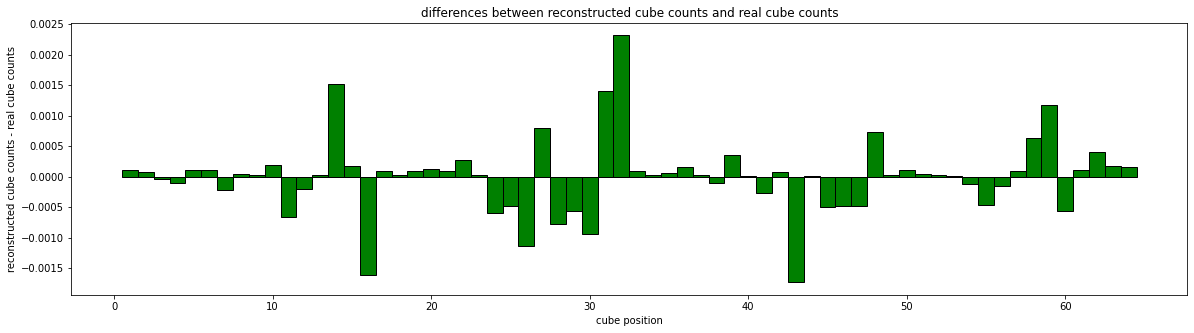

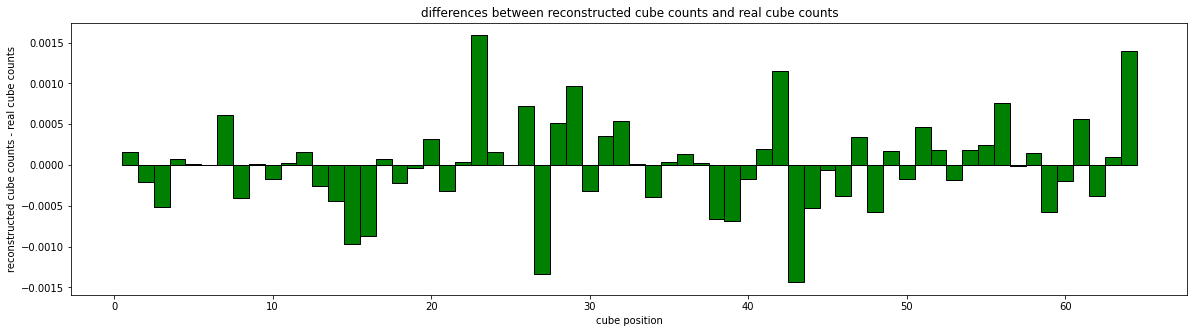

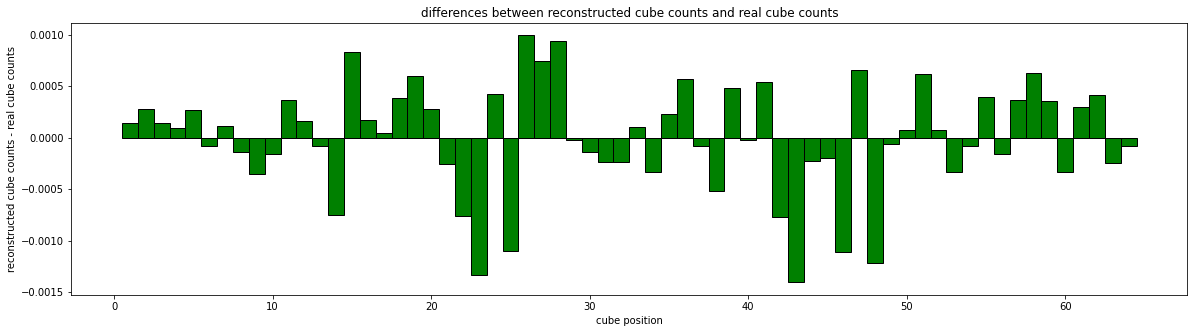

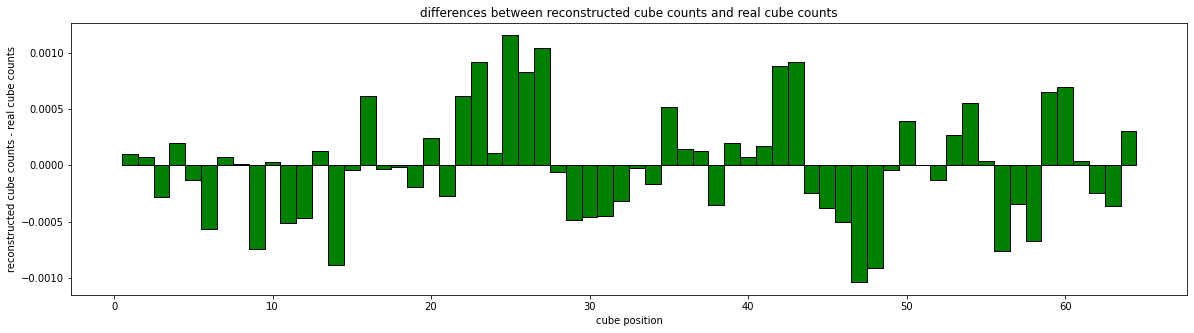

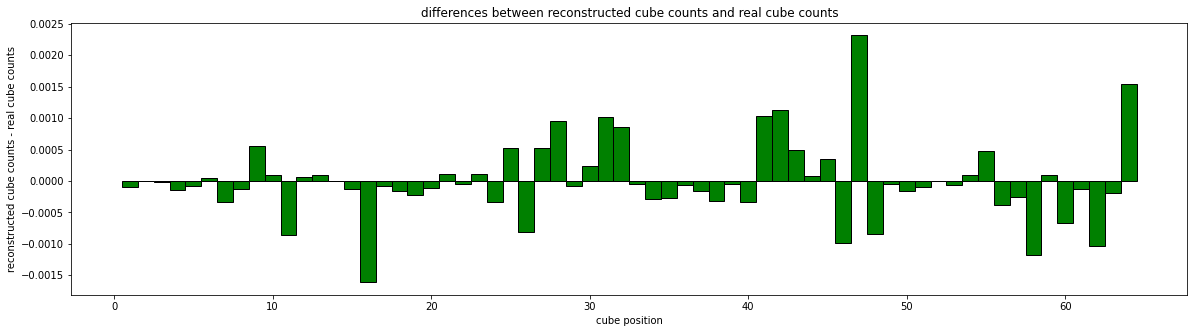

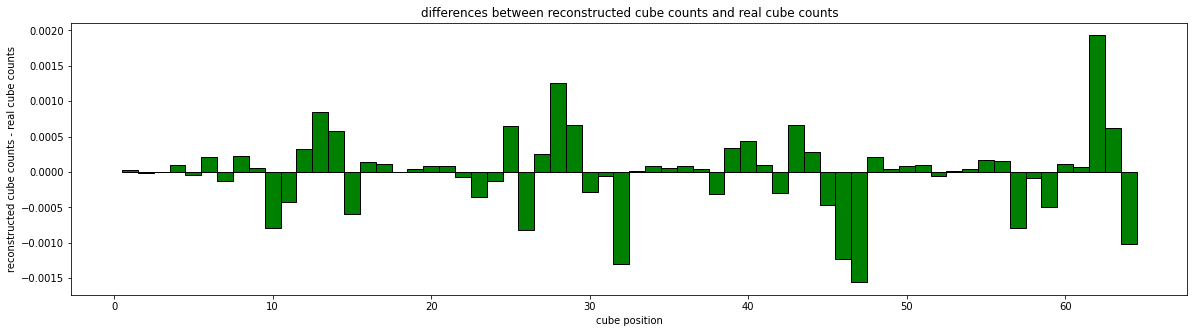

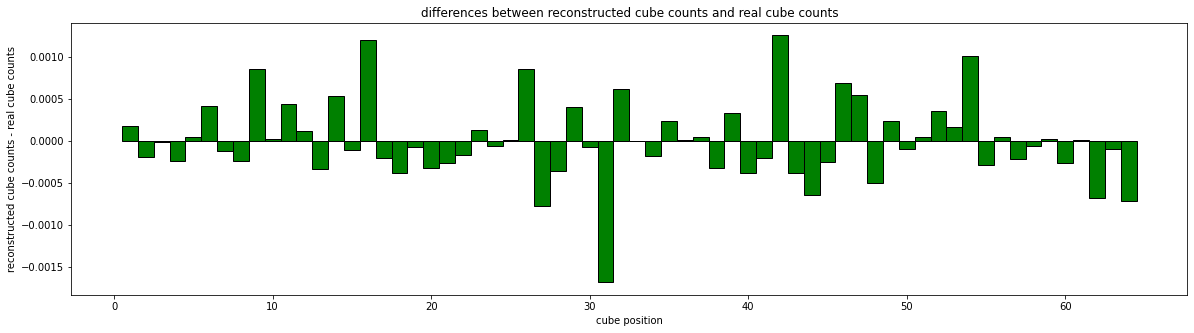

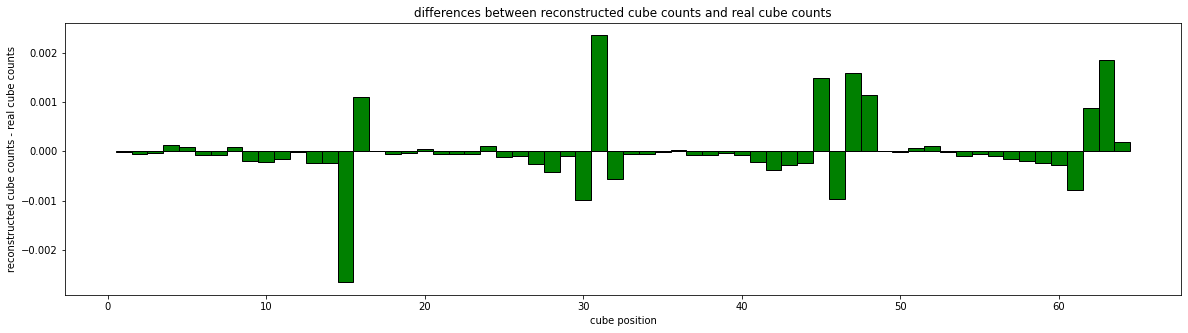

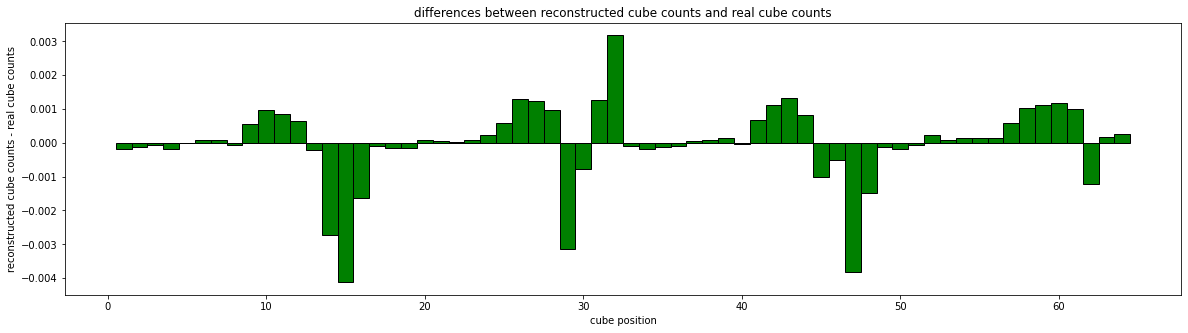

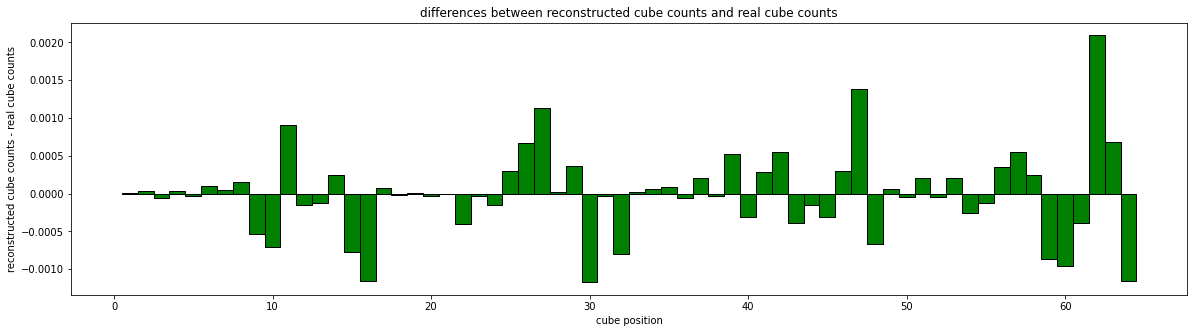

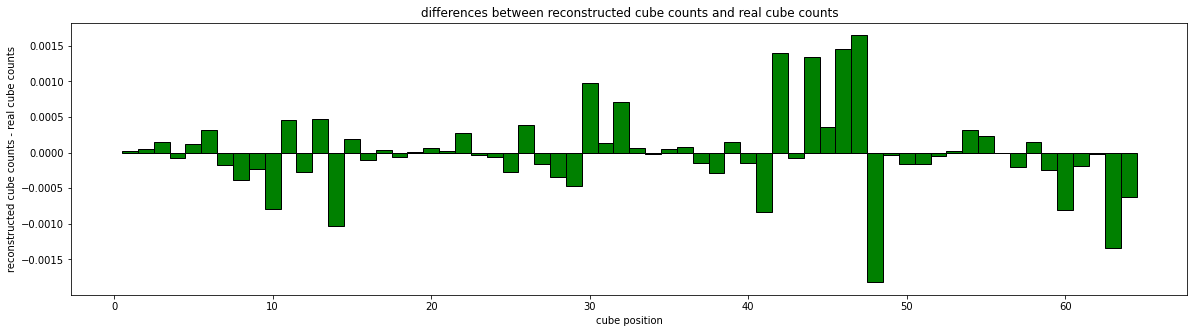

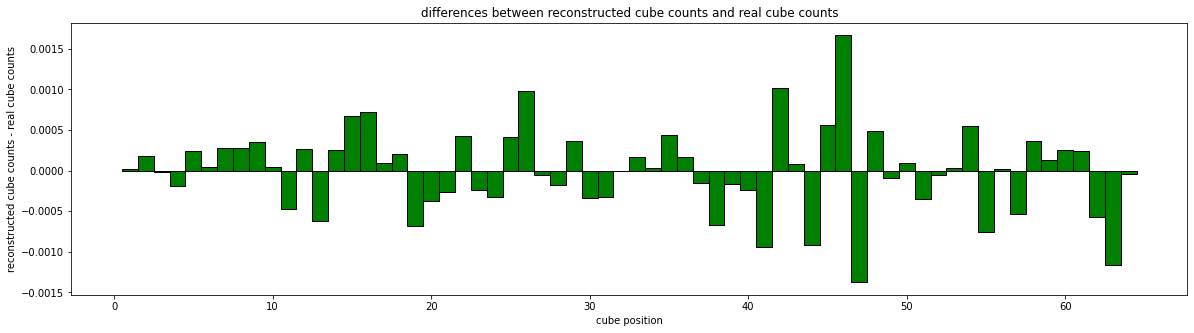

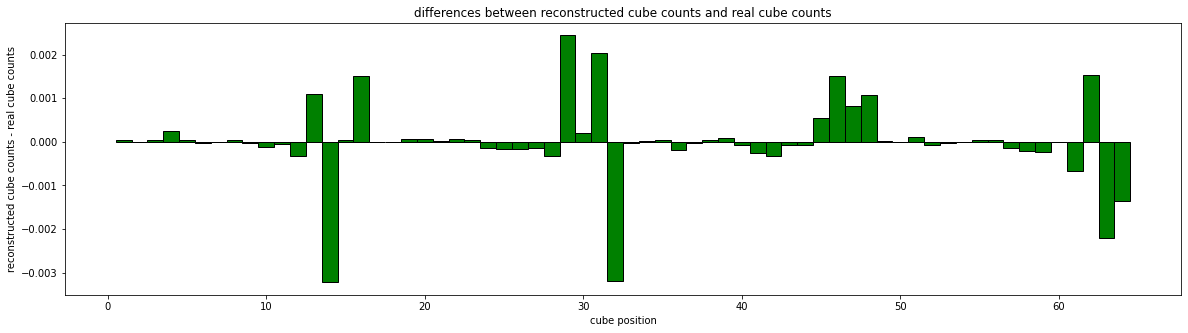

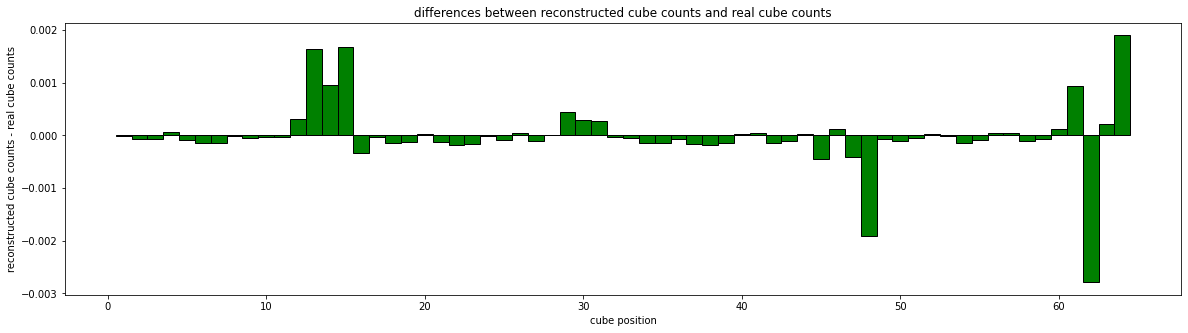

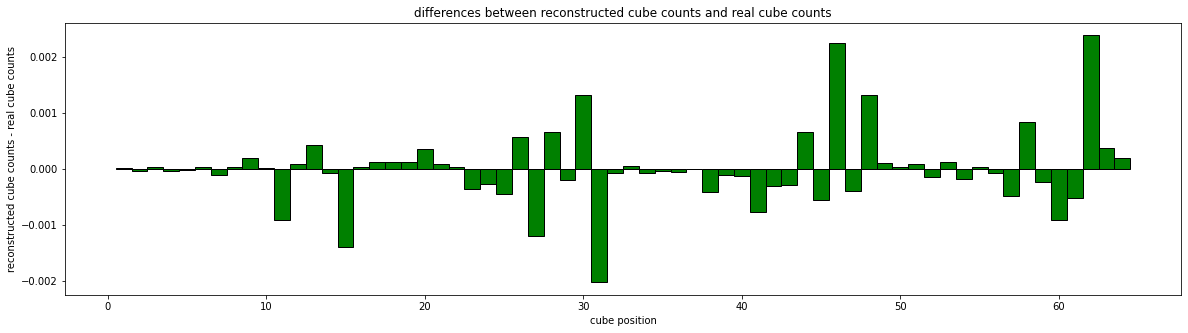

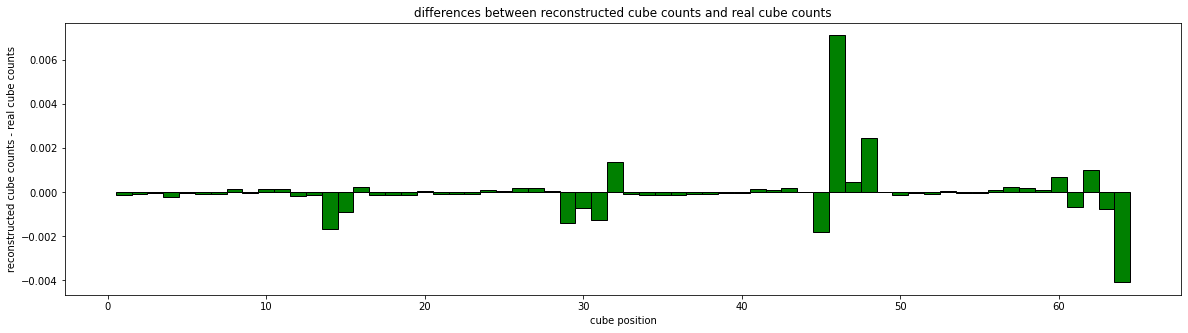

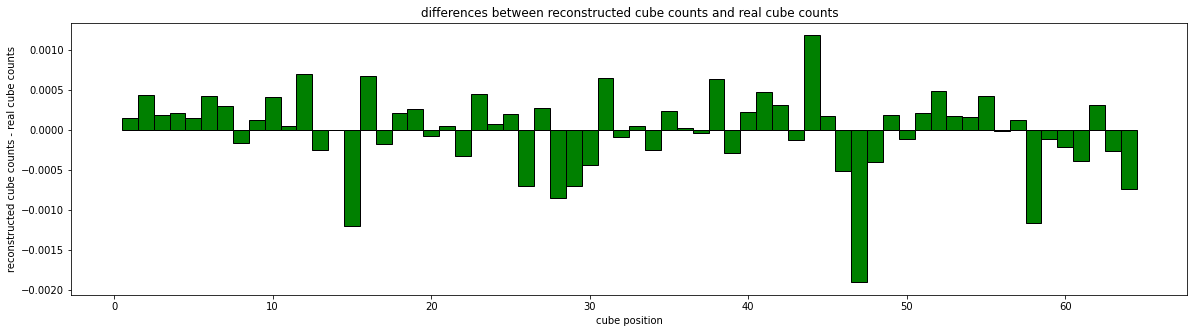

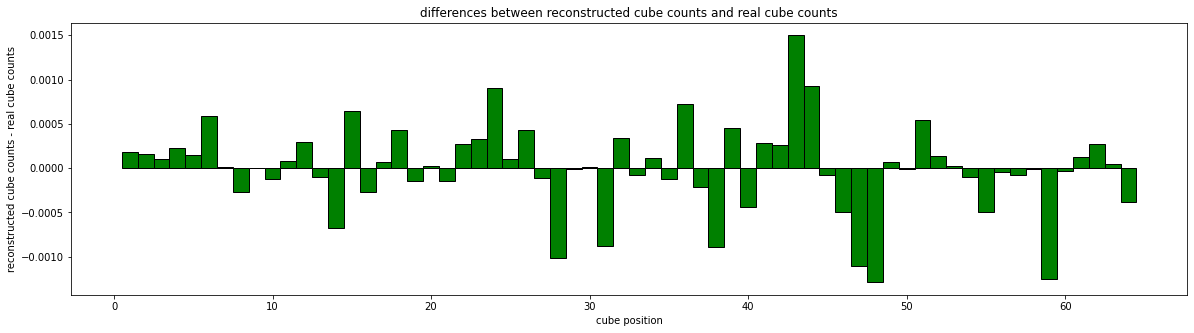

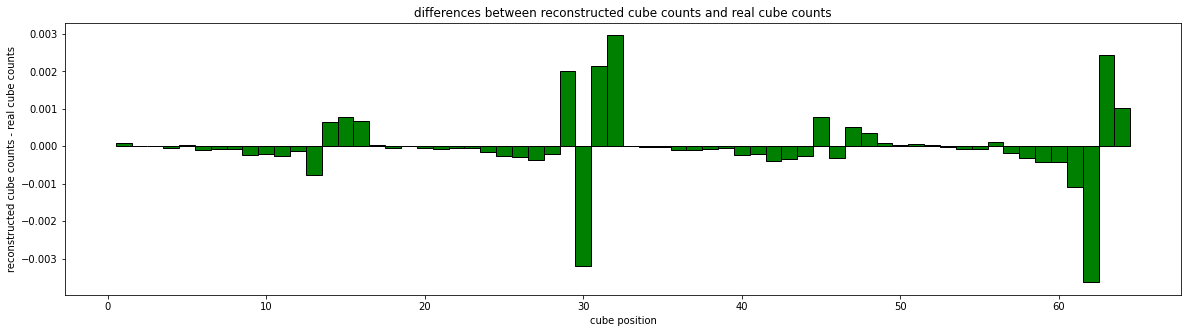

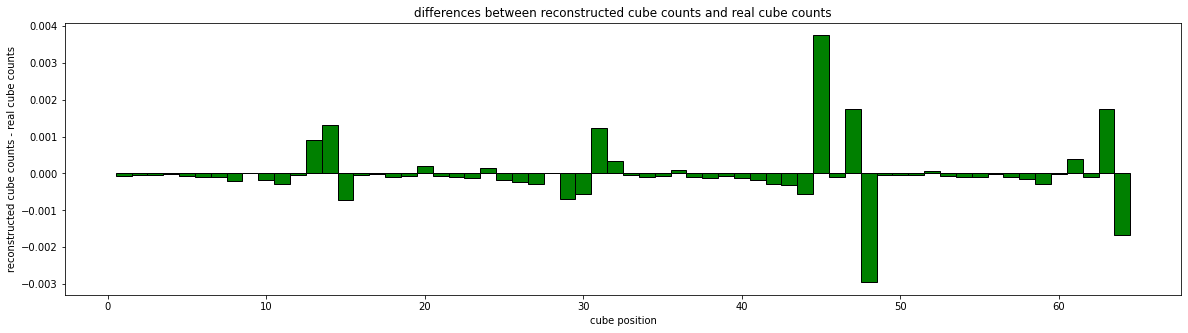

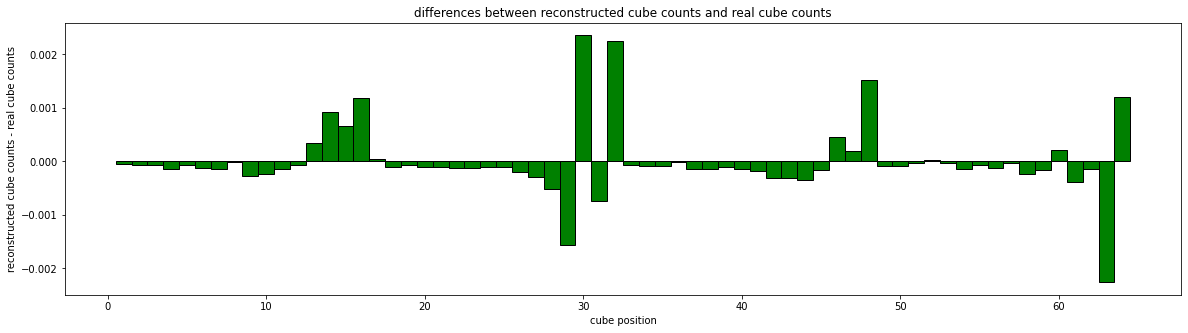

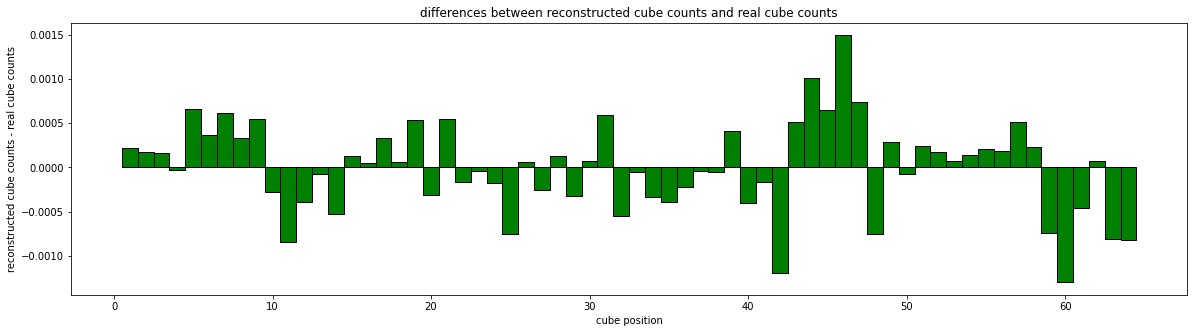

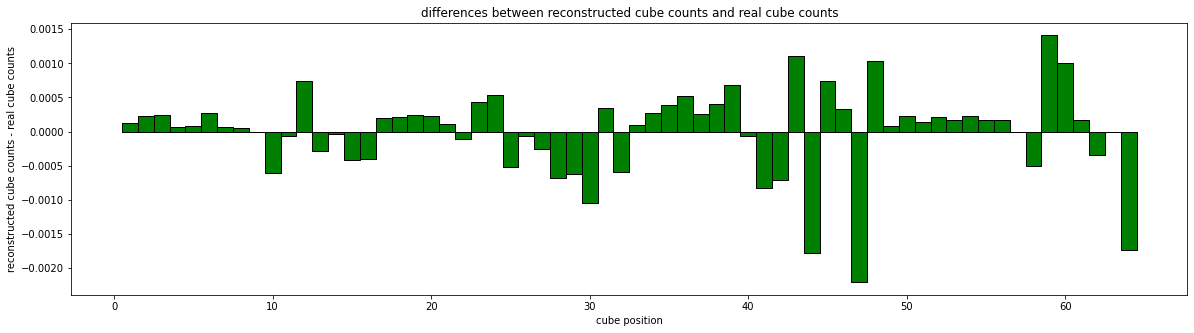

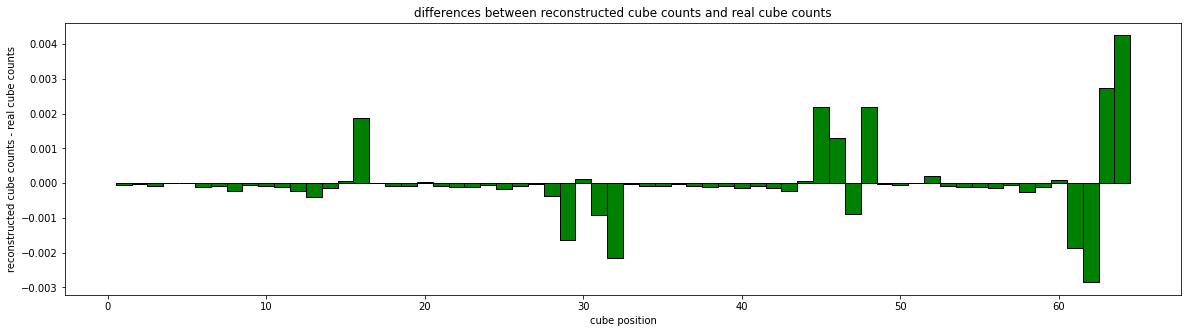

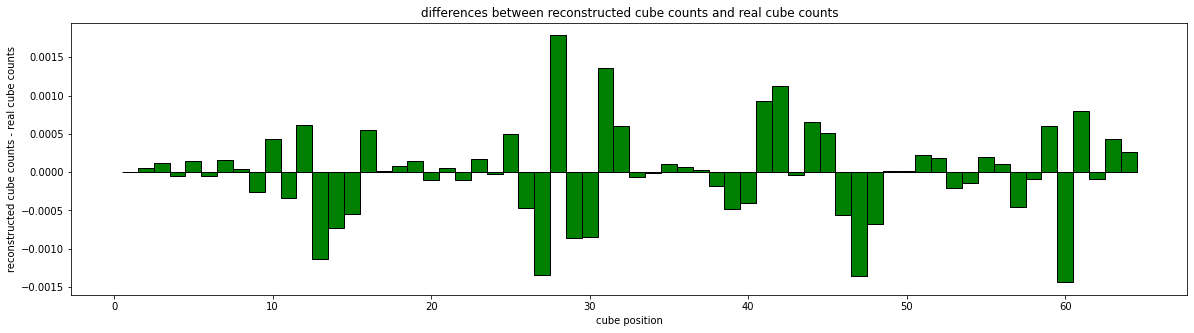

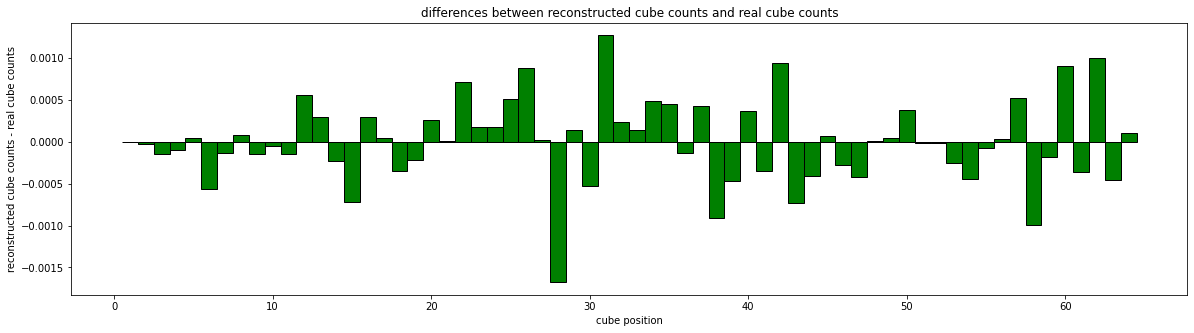

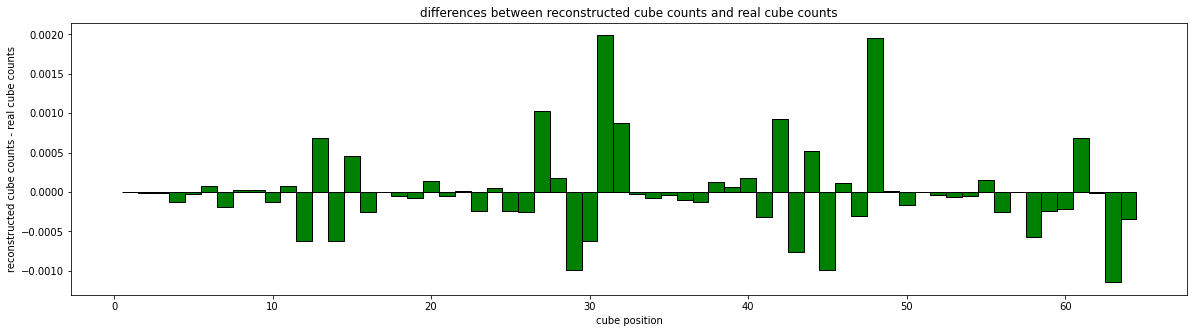

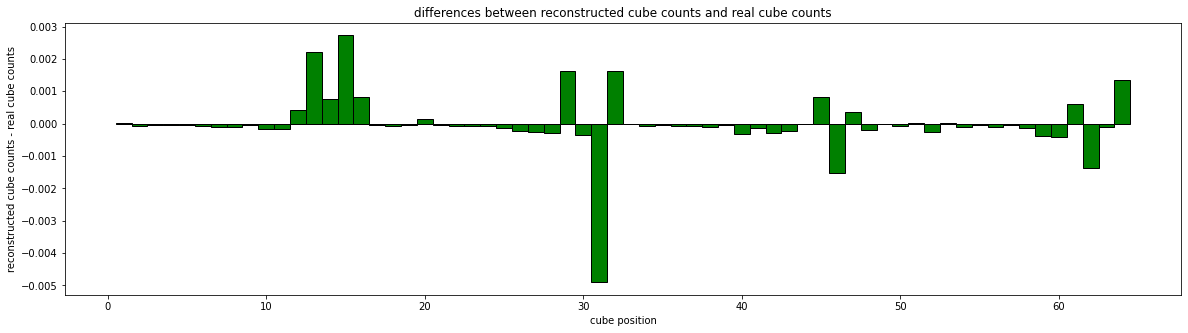

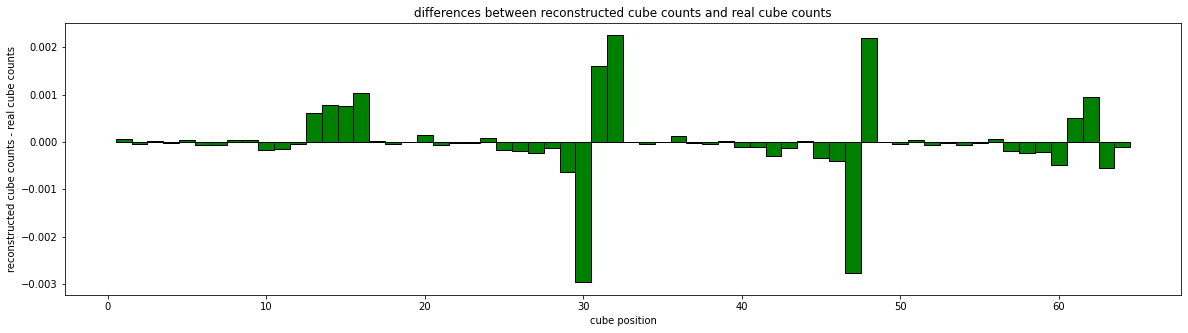

In [33]:
plt.rcParams['figure.figsize'] = (20, 5)

for i in range(128):
    
    event = events[i].cpu()
    #print(image.shape)
    recon_event = x_recon[i].cpu()


    plt.subplot(1, 1, 1)
    event = event.flatten()
    event = event/sum(event)
    event = np.array(event).tolist()
    label = labels[i]
    title = category_list[label]
#     plt.plot(event)
 
    

#     plt.subplot(1, 2, 2)
    recon_event = recon_event.flatten()
    recon_event = recon_event/sum(recon_event)
    recon_event = np.array(recon_event).tolist()
#     plt.plot(recon_event)
    difference_event = list(map(lambda x: x[0]-x[1], zip(recon_event, event)))
#     print(difference_event)

    plt.bar(x_axis, difference_event, width=1, linewidth=1, edgecolor='k', color ='g')
    plt.xlabel('cube position')
    plt.ylabel('reconstructed cube counts - real cube counts')
    plt.title('differences between reconstructed cube counts and real cube counts')
    plt.show()

In [34]:
# # get encode_indices of training signals
# train_indices = []
# label_indices = []
# for events, labels in train_loader:
#     events = events.cuda().float()
#     with torch.inference_mode():
#         z = model.encoder(events) # [B, C, h]
#         b, c, h = z.size()
#         # [B, C, H, W] -> [B, H, W, C]
#         z = z.permute(0, 2, 1).contiguous()
#         # [B, H, W, C] -> [BHW, C]
#         flat_z = z.reshape(-1, c)
#         encoding_indices = model.vq_layer.get_code_indices(flat_z) # [BHW,]
#         encoding_indices = encoding_indices.reshape(b, h)
# #         print(encoding_indices.cpu().shape)
#         labels = labels.reshape(b)
#         train_indices.append(encoding_indices.cpu())
#         label_indices.append(labels.cpu())
# # print(len(label_indices))
# # print(len(train_indices))

In [35]:
# print(train_indices[0])
# print(train_indices[0].shape)

In [36]:
# plt.rcParams['figure.figsize'] = (5, 5)
# for i in range (128):
#     event = np.array(train_indices[0][i]).reshape(8).tolist()
#     label = label_indices[0][i]
#     title = category_list[label]
#     plt.subplot(1, 1, 1)
#     plt.plot(event)
#     plt.title(title)
#     plt.show()

In [37]:
import pickle

# with open("train_data", "wb") as fp1:   #Pickling
#     pickle.dump(train_indices, fp1)
    

with open("train_data", "rb") as fp1:   # Unpickling
    train_indices = pickle.load(fp1)

In [38]:
# print(train_indices[0].shape)

In [39]:
# with open("train_label", "wb") as fp2:   #Pickling
#     pickle.dump(label_indices, fp2)
    
with open("train_label", "rb") as fp2:   # Unpickling
    label_indices = pickle.load(fp2)

In [40]:
# print(label_indices[0].shape)

In [41]:
import numpy as np


class CasualDilatedConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.ignoreOutIndex = (kernel_size - 1) * dilation
        self.conv1D = nn.Conv1d(in_channels, out_channels, kernel_size, dilation=dilation, bias=False, padding=self.ignoreOutIndex)

    def forward(self, x):
        return self.conv1D(x)[..., :-self.ignoreOutIndex]


class DenseLayer(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=2)
        self.conv1d = nn.Conv1d(in_channels, in_channels, kernel_size=2, bias=False, padding=3)

    def forward(self, skipConnection):
        # as b c outputsize -> skipConnection size
        out = torch.mean(skipConnection, dim=0)

        for i in range(2):
            out = self.relu(out)
            out = self.conv1d(out)
        return self.softmax(out)


class ResBlock(nn.Module):
    def __init__(self, res_channels, skip_channels, kernel_size, dilation, n_classes):
        super().__init__()
        self.casualDilatedConv1D = CasualDilatedConv1D(res_channels, res_channels, kernel_size, dilation=dilation)
        self.resConv1D = nn.Conv1d(res_channels, res_channels, kernel_size=1)
        self.skipConv1D = nn.Conv1d(res_channels, skip_channels, kernel_size=1)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.class_cond_embedding = nn.Embedding(n_classes, res_channels)
        

    def forward(self, inputX, h):
        h = self.class_cond_embedding(h)
        x = self.casualDilatedConv1D(inputX)
        x = x + h[:, :, None]
        x1 = self.tanh(x)
        x2 = self.sigmoid(x)
        x = x1 * x2
        resOutput = self.resConv1D(x)
        resOutput = resOutput + inputX[..., -resOutput.size(2):]
        skipOutput = self.skipConv1D(x)
        skipOutput = skipOutput[..., -6:]
        return resOutput, skipOutput


class StackOfResBlocks(nn.Module):

    def __init__(self, stack_size, layer_size, res_channels, skip_channels, kernel_size):
        super().__init__()
        buildDilationFunc = np.vectorize(self.buildDilation)
        dilations = buildDilationFunc(stack_size, layer_size)
        self.resBlocks = []
        for s,dilationPerStack in enumerate(dilations):
            for l,dilation in enumerate(dilationPerStack):
                resBlock=ResBlock(res_channels, skip_channels, kernel_size, dilation, n_classes)
                self.add_module(f'resBlock_{s}_{l}', resBlock) # Add modules manually
                self.resBlocks.append(resBlock)

    def buildDilation(self, stack_size, layer_size):
        # stack1=[1,2,4,8,16,...512]
        dilationsForAllStacks = []
        for stack in range(stack_size):
            dilations = []
            for layer in range(layer_size):
                dilations.append(2 ** layer)
            dilationsForAllStacks.append(dilations)
        return dilationsForAllStacks

    def forward(self, x, label):
        resOutput = x
        skipOutputs = []
        for resBlock in self.resBlocks:
            resOutput, skipOutput = resBlock(resOutput, label)
            skipOutputs.append(skipOutput)
        return resOutput, torch.stack(skipOutputs)


class WaveNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stack_size, layer_size):
        super().__init__()
        self.stack_size = stack_size
        self.layer_size = layer_size
        self.kernel_size = kernel_size
        self.casualConv1D = CasualDilatedConv1D(in_channels, in_channels, kernel_size, dilation=1)
        self.stackResBlock = StackOfResBlocks(self.stack_size, self.layer_size, in_channels, out_channels, kernel_size)
        self.denseLayer = DenseLayer(out_channels)
        self.batchnorm = nn.BatchNorm1d(in_channels)


#     def calculateReceptiveField(self):
#         return np.sum([(self.kernel_size - 1) * (2 ** l) for l in range(self.layer_size)] * self.stack_size)

#     def calculateOutputSize(self, x):
#         return int(x.size(2)) - self.calculateReceptiveField()

    def forward(self, x, label):
        # x: b c t -> input data size
        x = self.casualConv1D(x)
#         skipSize = self.calculateOutputSize(x)
        _, skipConnections = self.stackResBlock(x, label)
        dense=self.denseLayer(skipConnections)
        return dense

In [42]:
in_channels=64
out_channels=64
kernel_size = 2
padding=1
layer_size= 5
stack_size= 10
n_classes=3

In [43]:
wavenet = WaveNet(in_channels, out_channels, kernel_size, stack_size, layer_size)

In [44]:
# class_cond_embedding = nn.Embedding(n_classes, 64)
# label = label_indices[0]
# h = class_cond_embedding(label)
# print(h.shape)
# print(h[:, :, None].shape)
# one_hot_indices = F.one_hot(train_indices[0], num_embeddings).float().permute(0, 2, 1).contiguous()
# print(one_hot_indices.shape)

In [45]:
# one_hot_index = F.one_hot(train_indices[0], num_embeddings).float().permute(0, 2, 1).contiguous()
# print(one_hot_index.shape)
# output = wavenet(one_hot_index, label_indices[0])
# print(output.shape)

In [46]:
# from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter("./runs/")

In [47]:
# epochs = 30

# wavenet = wavenet.cuda()

# wavenet_optimizer = torch.optim.Adam(wavenet.parameters(), lr=0.001)

# # train wavenet
# print_freq = 100
# for epoch in range(epochs):
#     print("Start training epoch {}".format(epoch,))
#     for i, (indices) in enumerate(train_indices):
#         indices = indices.cuda()
# #         print(indices.shape)
#         one_hot_indices = F.one_hot(indices, num_embeddings).float().permute(0, 2, 1).contiguous()
# #         print(one_hot_indices.shape)
#         label = label_indices[i].cuda()
# #         print(label.shape)
#         outputs = wavenet(one_hot_indices, label)
# #         print(outputs.shape)
#         loss = F.cross_entropy(outputs, one_hot_indices)
    
#         writer.add_scalar('wavenet_loss_1/train', float(loss), 469*epoch+i)
        
        
#         wavenet_optimizer.zero_grad()
#         loss.backward()
#         wavenet_optimizer.step()
#         if (i + 1) % print_freq == 0 or (i + 1) == len(train_loader):
#             print("\t [{}/{}]: loss {}".format(i, len(train_loader), loss.item())) 

In [48]:
# torch.save(wavenet, './model_wavenet.pth')
# torch.save(wavenet_optimizer, './optimizer_wavenet.pth')

In [49]:
wavenet = torch.load('./model_wavenet.pth')
wavenet_optimizer = torch.load('./optimizer_wavenet.pth')

In [50]:
# Create an empty array of priors.

labels = torch.full([50], 0, dtype=torch.long).cuda()
#print(labels.shape)

n_samples = 50
prior_size = (16, ) # h, w
priors = torch.zeros((n_samples,) + prior_size, dtype=torch.long).cuda()
#print(priors.shape)
# use wavenet to generate priors
wavenet.eval()

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(prior_size[0]):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
    with torch.inference_mode():
        one_hot_priors = F.one_hot(priors, num_embeddings).float().permute(0, 2, 1).contiguous()
        #print(one_hot_priors)
        logits = wavenet(one_hot_priors, labels)
        #print(logits[:, :, row].shape)
        probs = F.softmax(logits[:, :, row], dim=-1)
        #print(probs.shape)
        # Use the probabilities to pick pixel values and append the values to the priors.
        priors[:, row] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
        #print(priors[:, row].shape)

In [51]:
print(priors.shape)

torch.Size([50, 16])


In [52]:
# Perform an embedding lookup and Generate new signals
with torch.inference_mode():
    z = model.vq_layer.quantize(priors)
    print(z.shape)
    z = z.permute(0, 2, 1).contiguous()
    print(z.shape)
    pred = model.decoder(z)
    #print(pred.shape)

torch.Size([50, 16, 1])
torch.Size([50, 1, 16])


In [53]:
print(pred.shape)

torch.Size([50, 1, 64])


Text(0.5, 1.0, 'cubes-AmBe')

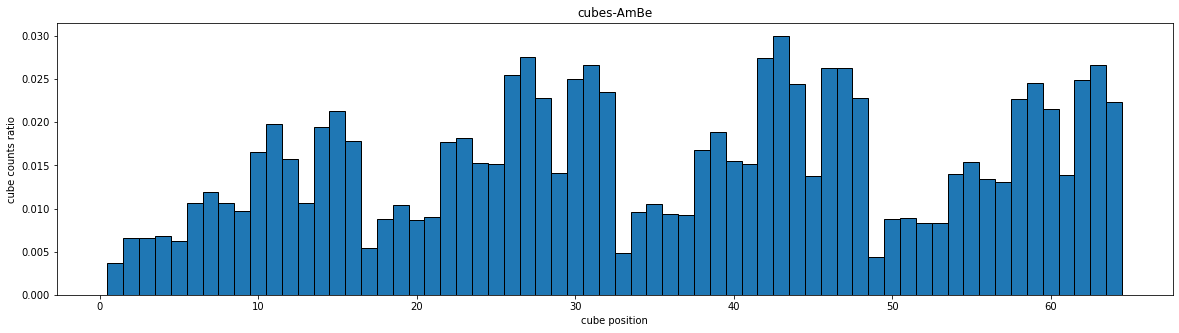

In [54]:
data1 = np.load('cubes-AmBe.npy')
data1 = data1.flatten()
data1 = data1/sum(data1)
data1 = np.array(data1).tolist()
plt.bar(x_axis, data1, width=1, linewidth=1, edgecolor='k')
plt.xlabel('cube position')
plt.ylabel('cube counts ratio')
plt.title('cubes-AmBe')


Text(0.5, 1.0, 'cubes-AmLi')

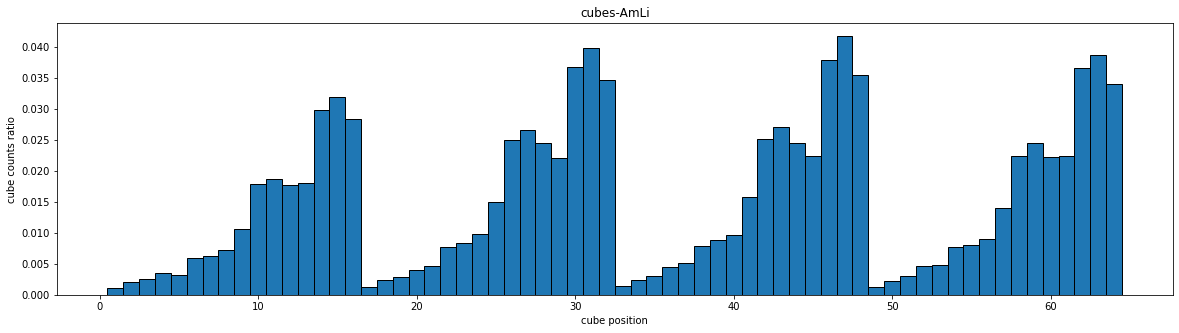

In [55]:
data2 = np.load('cubes-AmLi.npy')
data2 = data2.flatten()
data2 = data2/sum(data2)
data2 = np.array(data2).tolist()
plt.bar(x_axis, data2, width=1, linewidth=1, edgecolor='k')
plt.xlabel('cube position')
plt.ylabel('cube counts ratio')
plt.title('cubes-AmLi')



Text(0.5, 1.0, 'cubes-Thermal')

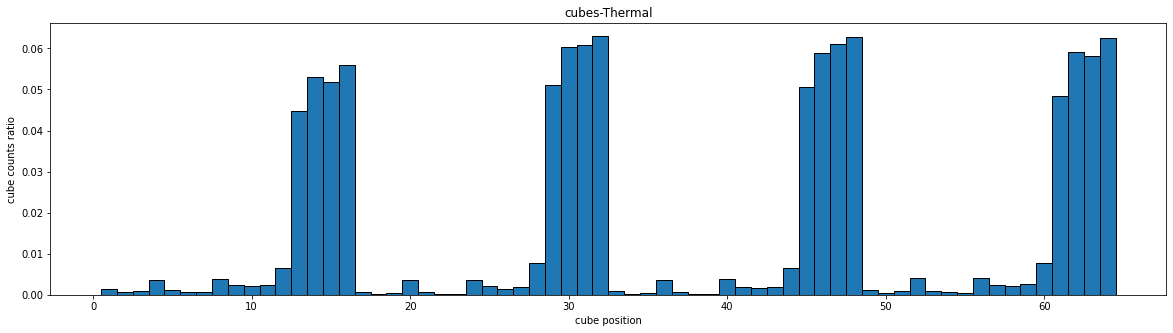

In [56]:
data3 = np.load('cubes-Thermal.npy')
data3 = data3.flatten()
data3 = data3/sum(data3)
data3 = np.array(data3).tolist()
plt.bar(x_axis, data3, width=1, linewidth=1, edgecolor='k')
plt.xlabel('cube position')
plt.ylabel('cube counts ratio')
plt.title('cubes-Thermal')



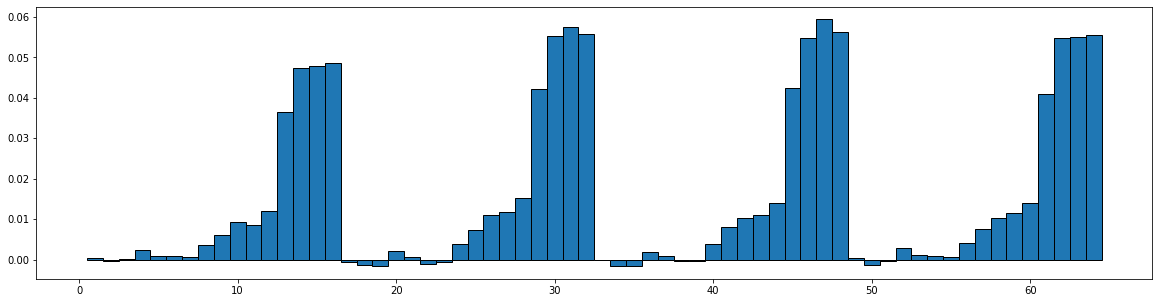

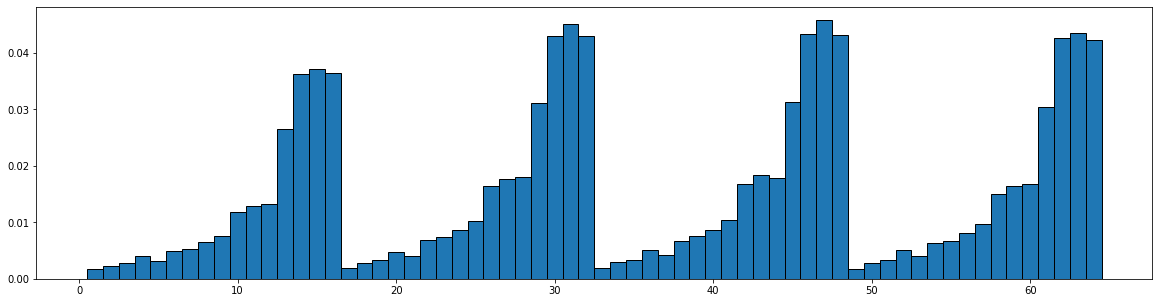

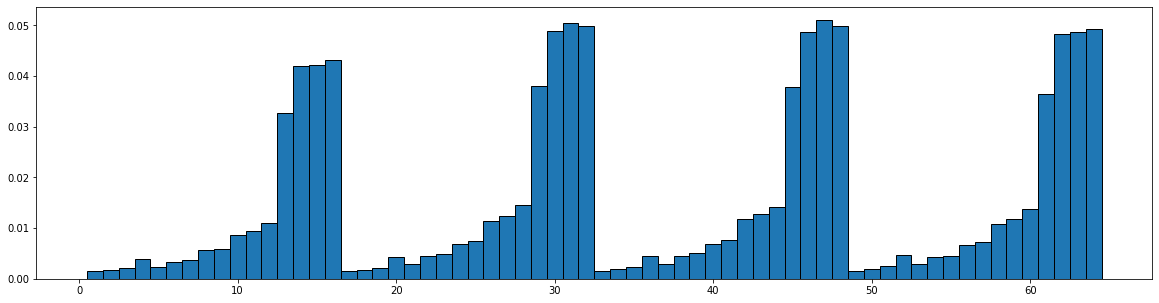

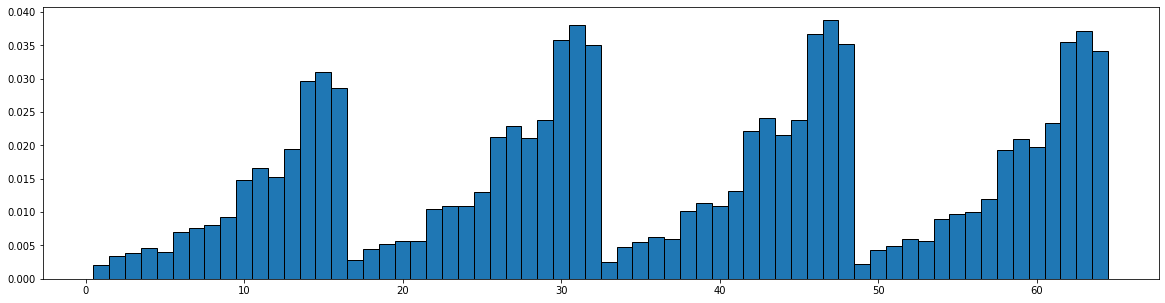

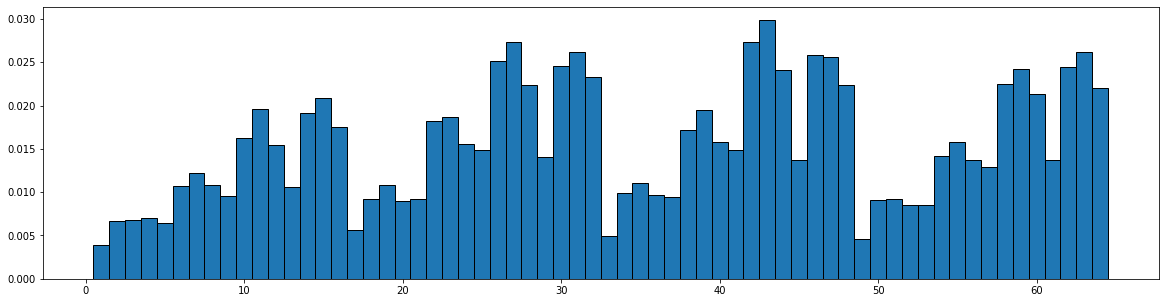

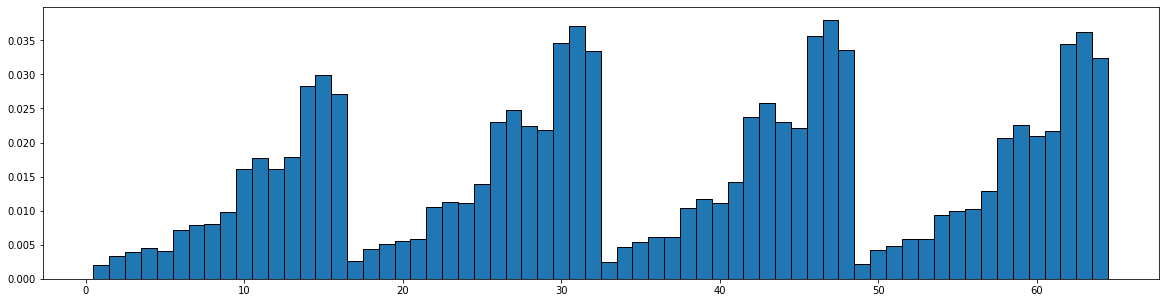

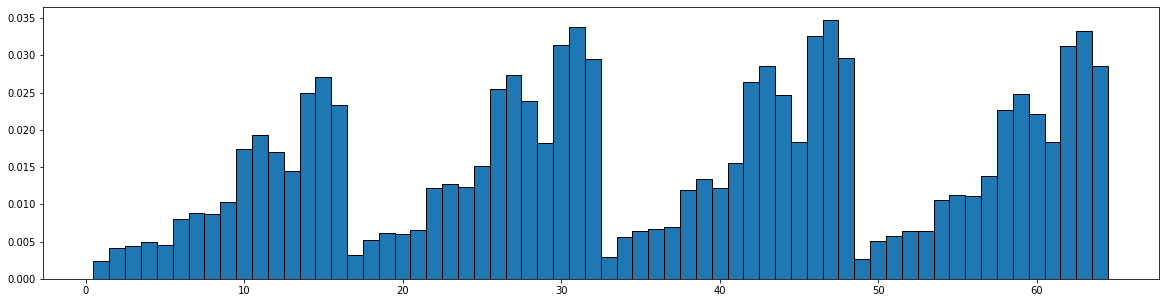

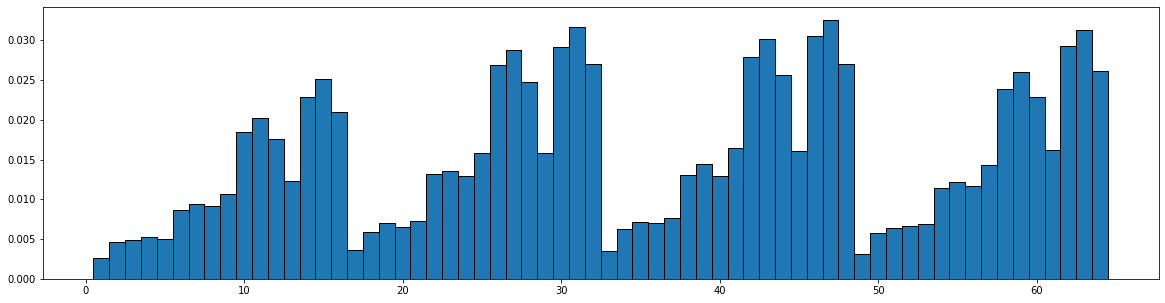

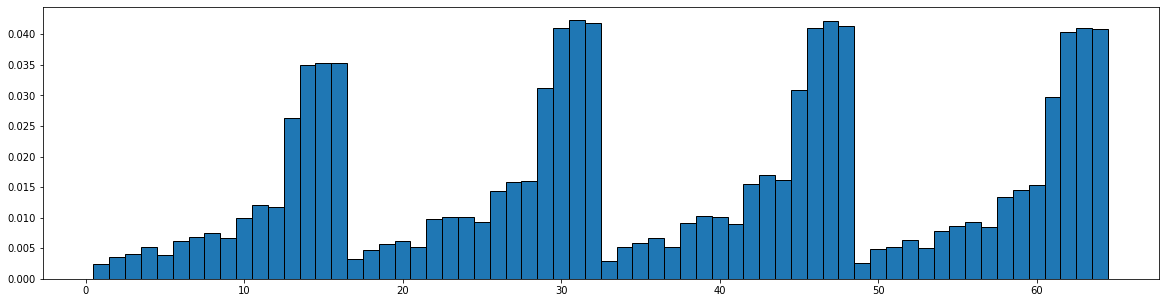

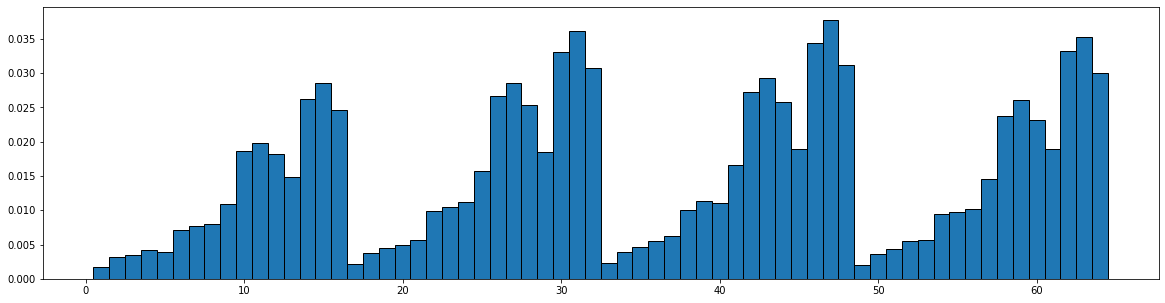

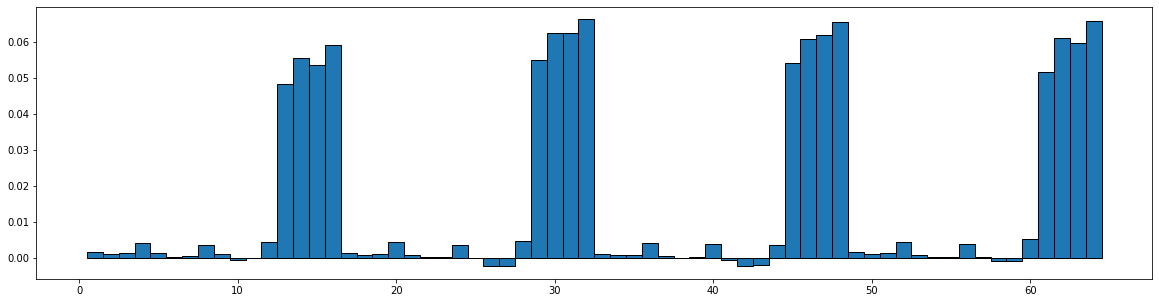

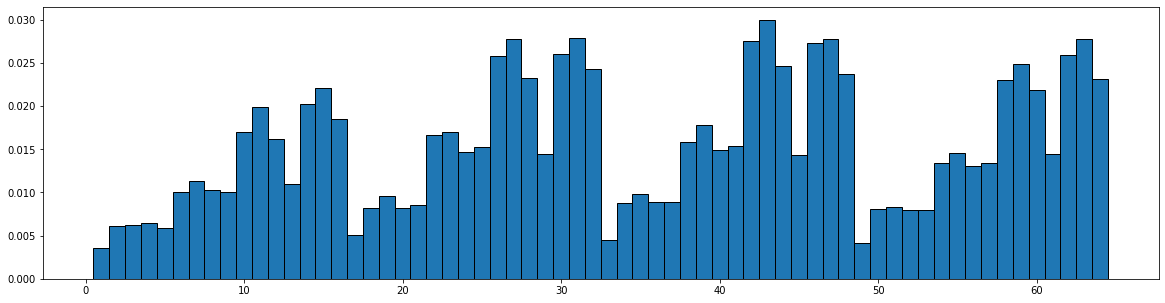

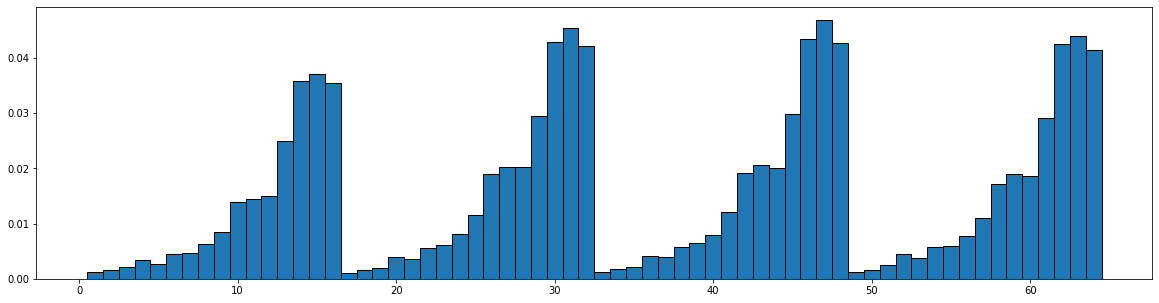

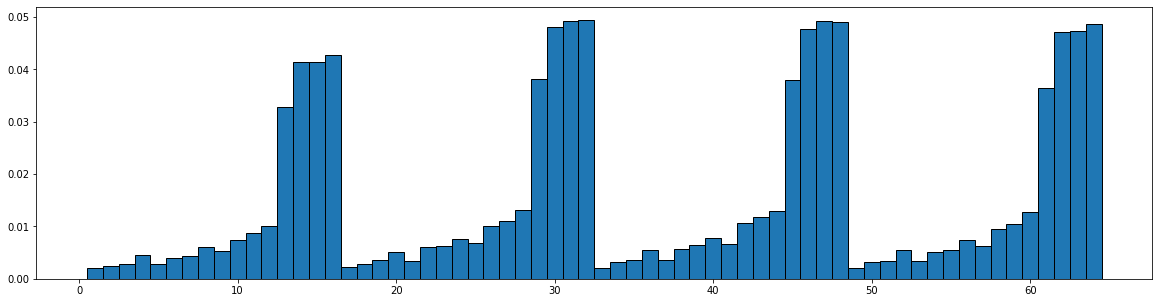

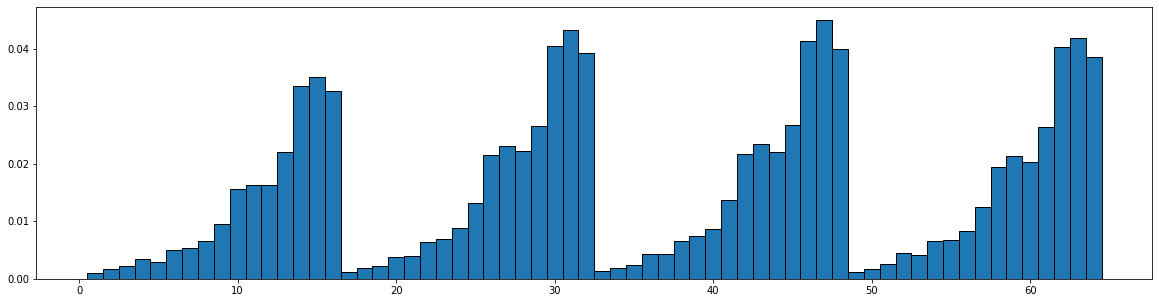

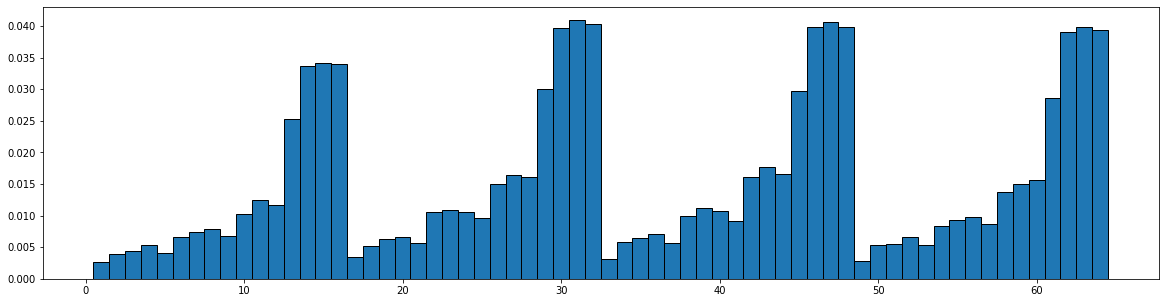

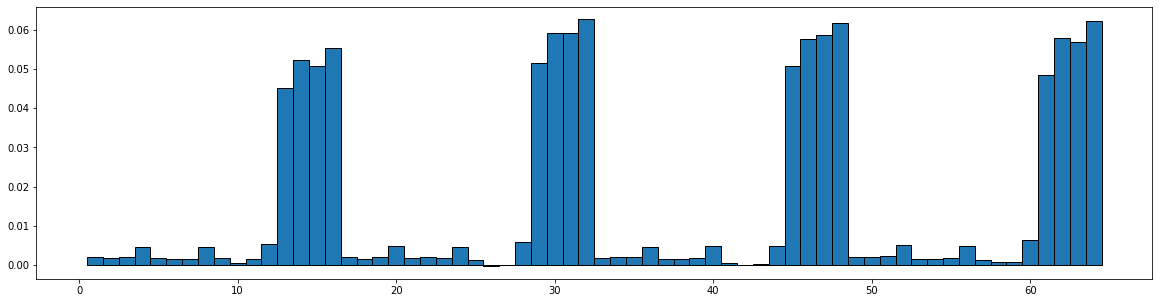

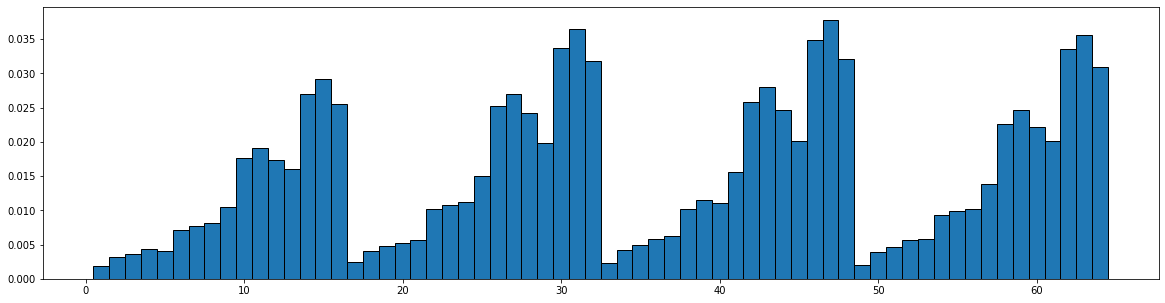

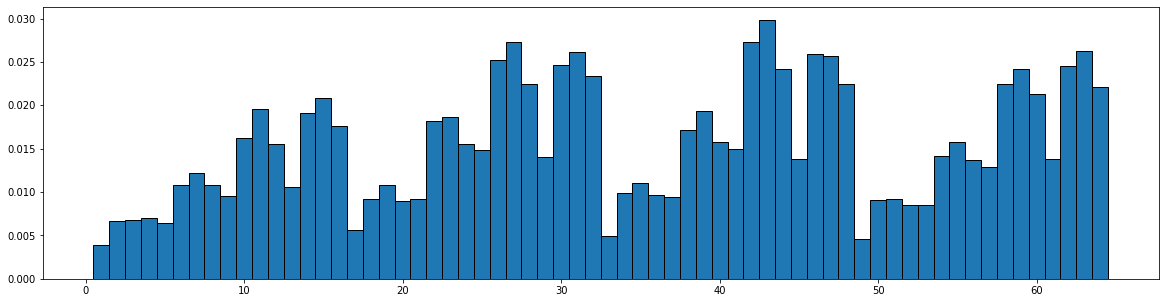

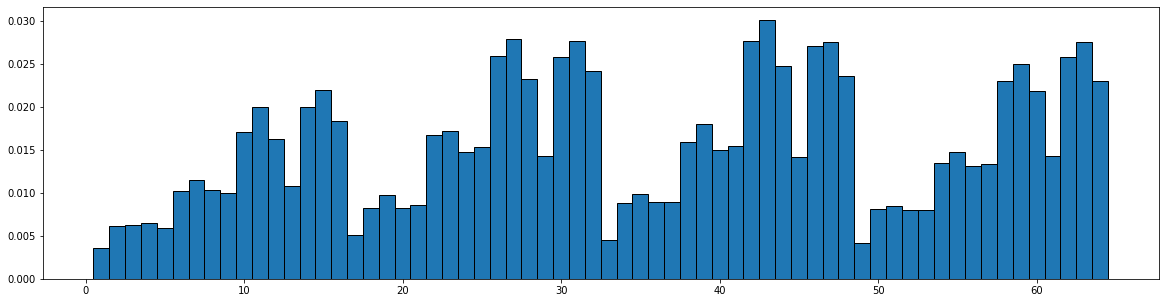

In [59]:
plt.rcParams['figure.figsize'] = (20, 5)
for i in range (20):
    event = pred[i].cpu().flatten()
    event = event/sum(event)
    event = np.array(event).tolist()
#     label = labels[i]
#     title = category_list[label]
    plt.subplot(1, 1, 1)
    plt.bar(x_axis, event, width=1, linewidth=1, edgecolor='k', label='Generated Cubes-AmBe')
#     if i == 0:
        
#         plt.bar(x_axis, event, width=1, linewidth=1, edgecolor='k', label='Generated Cubes-AmBe')
#         plt.bar(x_axis, data1, width=1, linewidth=1, edgecolor='k', label='Real cubes-AmBe')
#         plt.xlabel('cube position')
#         plt.ylabel('cube counts ratio')
#         plt.title('cube counts visualization for real data and generated data')
#         plt.legend(loc = 'upper left')
        
        
        
#     if i == 1:
        
#         plt.bar(x_axis, event, width=1, linewidth=1, edgecolor='k', label='Generated Cubes-AmLi')
#         plt.bar(x_axis, data2, width=1, linewidth=1, edgecolor='k', label='Real cubes-AmLi')
#         plt.xlabel('cube position')
#         plt.ylabel('cube counts ratio')
#         plt.title('cube counts visualization for real data and generated data')
#         plt.legend()

#     if i == 2:
        
#         plt.bar(x_axis, event, width=1, linewidth=1, edgecolor='k', label='Generated Cubes-Thermal')
#         plt.bar(x_axis, data3, width=1, linewidth=1, edgecolor='k', label='Real cubes-Thermal')
#         plt.xlabel('cube position')
#         plt.ylabel('cube counts ratio')
#         plt.title('cube counts visualization for real data and generated data')
#         plt.legend()


        
#     plt.plot(event)
#     plt.title(title)

    plt.show()

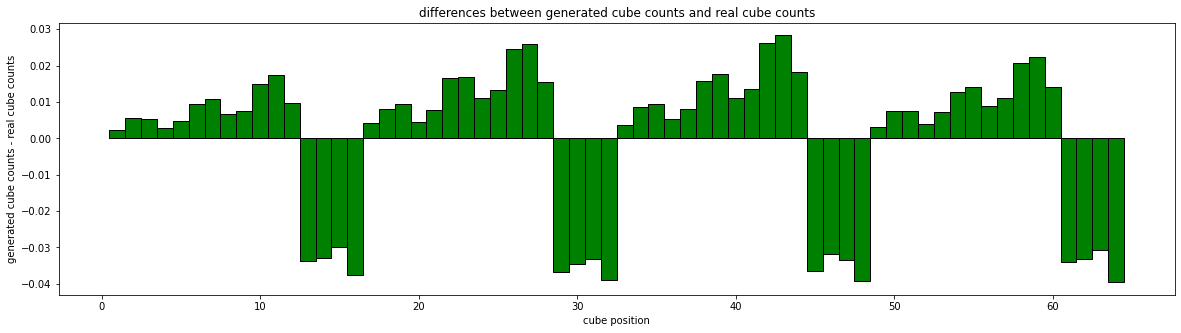

In [60]:
plt.rcParams['figure.figsize'] = (20, 5)
difference_event = list(map(lambda x: x[0]-x[1], zip(event, data3)))
#     print(difference_event)

plt.bar(x_axis, difference_event, width=1, linewidth=1, edgecolor='k', color ='g')
plt.xlabel('cube position')
plt.ylabel('generated cube counts - real cube counts')
plt.title('differences between generated cube counts and real cube counts')
plt.show()